In [1]:
#import non tensorflow libraries
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import IPython.display as display

#import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers as tfl
import pickle
import keras_cv

2024-04-15 23:20:28.978623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 23:20:28.978737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 23:20:29.120147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 16

IMG_SIZE = (224,224)

train_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/train',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/val',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 7304 files belonging to 2 classes.


Found 826 files belonging to 2 classes.


tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


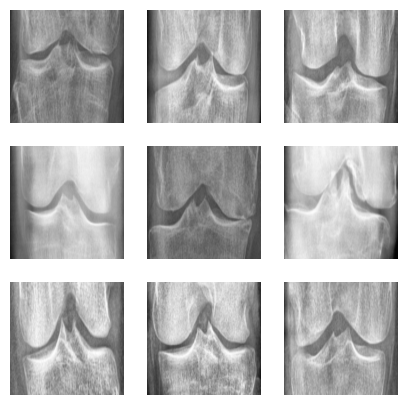

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(labels[i])
#         plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.Resizing(224,224),
        tf.keras.layers.RandomZoom(0.1)
    ])
    
    return data_augmentation

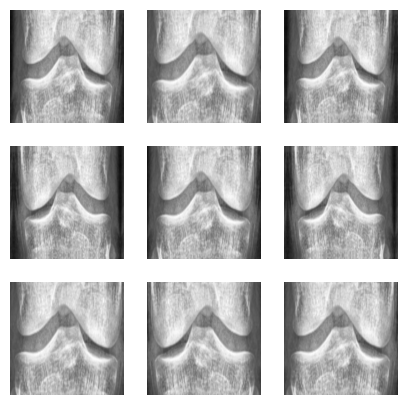

In [5]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras_cv.models.DenseNetBackbone.from_preset("densenet201_imagenet")

Attaching 'config.json' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...


Attaching 'config.json' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...


Attaching 'model.weights.h5' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...


In [7]:
base_model.trainable = True

In [8]:
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [9]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9), 
      loss = tf.keras.losses.BinaryCrossentropy(), 
      metrics=['accuracy',keras.metrics.AUC()])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_net_backbone              │ ?                      │    18,321,984 │
│ (DenseNetBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

None


In [10]:
epochs = 9

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)
checkpoint_filepath = '/kaggle/working/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
class_weights = {0: 1.7345048682023272, 1: 2.3614613643711606}

In [12]:
history = model.fit(train_dataset,
                    class_weight = class_weights,
                    epochs=epochs,
                    validation_data = validation_dataset,
                    callbacks=[early_stopper, reduce_lr,model_checkpoint_callback])

Epoch 1/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 12:44:38 101s/step - accuracy: 0.4375 - auc: 0.3077 - loss: 1.3189

  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:14:34 10s/step - accuracy: 0.4531 - auc: 0.2915 - loss: 1.3406  

  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:15:17 10s/step - accuracy: 0.4618 - auc: 0.3116 - loss: 1.3419

  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:09:45 9s/step - accuracy: 0.4753 - auc: 0.3528 - loss: 1.3430 

  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:41 9s/step - accuracy: 0.4827 - auc: 0.3757 - loss: 1.3475

  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:40 9s/step - accuracy: 0.4856 - auc: 0.3860 - loss: 1.3508

  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:20 8s/step - accuracy: 0.4876 - auc: 0.3943 - loss: 1.3525

  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:10 8s/step - accuracy: 0.4882 - auc: 0.3992 - loss: 1.3566

  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:15 8s/step - accuracy: 0.4903 - auc: 0.4066 - loss: 1.3611

 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:26 8s/step - accuracy: 0.4931 - auc: 0.4123 - loss: 1.3638

 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:01 8s/step - accuracy: 0.4984 - auc: 0.4189 - loss: 1.3647

 12/457 ━━━━━━━━━━━━━━━━━━━━ 59:25 8s/step - accuracy: 0.5020 - auc: 0.4229 - loss: 1.3662  

 13/457 ━━━━━━━━━━━━━━━━━━━━ 58:54 8s/step - accuracy: 0.5037 - auc: 0.4253 - loss: 1.3682

 14/457 ━━━━━━━━━━━━━━━━━━━━ 58:27 8s/step - accuracy: 0.5063 - auc: 0.4289 - loss: 1.3691

 15/457 ━━━━━━━━━━━━━━━━━━━━ 58:08 8s/step - accuracy: 0.5090 - auc: 0.4330 - loss: 1.3700

 16/457 ━━━━━━━━━━━━━━━━━━━━ 57:42 8s/step - accuracy: 0.5113 - auc: 0.4370 - loss: 1.3703

 17/457 ━━━━━━━━━━━━━━━━━━━━ 57:18 8s/step - accuracy: 0.5143 - auc: 0.4409 - loss: 1.3700

 18/457 ━━━━━━━━━━━━━━━━━━━━ 56:58 8s/step - accuracy: 0.5164 - auc: 0.4443 - loss: 1.3703

 19/457 ━━━━━━━━━━━━━━━━━━━━ 56:39 8s/step - accuracy: 0.5180 - auc: 0.4471 - loss: 1.3706

 20/457 ━━━━━━━━━━━━━━━━━━━━ 56:31 8s/step - accuracy: 0.5190 - auc: 0.4491 - loss: 1.3707

 21/457 ━━━━━━━━━━━━━━━━━━━━ 56:17 8s/step - accuracy: 0.5198 - auc: 0.4509 - loss: 1.3710

 22/457 ━━━━━━━━━━━━━━━━━━━━ 56:04 8s/step - accuracy: 0.5204 - auc: 0.4524 - loss: 1.3711

 23/457 ━━━━━━━━━━━━━━━━━━━━ 55:54 8s/step - accuracy: 0.5209 - auc: 0.4538 - loss: 1.3713

 24/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.5210 - auc: 0.4549 - loss: 1.3719

 25/457 ━━━━━━━━━━━━━━━━━━━━ 55:46 8s/step - accuracy: 0.5213 - auc: 0.4562 - loss: 1.3725

 26/457 ━━━━━━━━━━━━━━━━━━━━ 55:40 8s/step - accuracy: 0.5213 - auc: 0.4569 - loss: 1.3735

 27/457 ━━━━━━━━━━━━━━━━━━━━ 55:31 8s/step - accuracy: 0.5215 - auc: 0.4580 - loss: 1.3744

 28/457 ━━━━━━━━━━━━━━━━━━━━ 55:26 8s/step - accuracy: 0.5214 - auc: 0.4590 - loss: 1.3753

 29/457 ━━━━━━━━━━━━━━━━━━━━ 55:16 8s/step - accuracy: 0.5214 - auc: 0.4599 - loss: 1.3762

 30/457 ━━━━━━━━━━━━━━━━━━━━ 55:07 8s/step - accuracy: 0.5214 - auc: 0.4612 - loss: 1.3770

 31/457 ━━━━━━━━━━━━━━━━━━━━ 55:00 8s/step - accuracy: 0.5214 - auc: 0.4622 - loss: 1.3778

 32/457 ━━━━━━━━━━━━━━━━━━━━ 54:58 8s/step - accuracy: 0.5215 - auc: 0.4633 - loss: 1.3786

 33/457 ━━━━━━━━━━━━━━━━━━━━ 54:51 8s/step - accuracy: 0.5216 - auc: 0.4647 - loss: 1.3793

 34/457 ━━━━━━━━━━━━━━━━━━━━ 54:43 8s/step - accuracy: 0.5218 - auc: 0.4659 - loss: 1.3800

 35/457 ━━━━━━━━━━━━━━━━━━━━ 54:38 8s/step - accuracy: 0.5218 - auc: 0.4671 - loss: 1.3806

 36/457 ━━━━━━━━━━━━━━━━━━━━ 54:42 8s/step - accuracy: 0.5216 - auc: 0.4681 - loss: 1.3812

 37/457 ━━━━━━━━━━━━━━━━━━━━ 54:37 8s/step - accuracy: 0.5213 - auc: 0.4689 - loss: 1.3817

 38/457 ━━━━━━━━━━━━━━━━━━━━ 54:30 8s/step - accuracy: 0.5210 - auc: 0.4698 - loss: 1.3823

 39/457 ━━━━━━━━━━━━━━━━━━━━ 54:23 8s/step - accuracy: 0.5206 - auc: 0.4705 - loss: 1.3828

 40/457 ━━━━━━━━━━━━━━━━━━━━ 54:19 8s/step - accuracy: 0.5202 - auc: 0.4712 - loss: 1.3833

 41/457 ━━━━━━━━━━━━━━━━━━━━ 54:10 8s/step - accuracy: 0.5197 - auc: 0.4718 - loss: 1.3837

 42/457 ━━━━━━━━━━━━━━━━━━━━ 54:02 8s/step - accuracy: 0.5192 - auc: 0.4724 - loss: 1.3842

 43/457 ━━━━━━━━━━━━━━━━━━━━ 53:53 8s/step - accuracy: 0.5186 - auc: 0.4728 - loss: 1.3846

 44/457 ━━━━━━━━━━━━━━━━━━━━ 53:47 8s/step - accuracy: 0.5179 - auc: 0.4732 - loss: 1.3850

 45/457 ━━━━━━━━━━━━━━━━━━━━ 53:36 8s/step - accuracy: 0.5174 - auc: 0.4737 - loss: 1.3853

 46/457 ━━━━━━━━━━━━━━━━━━━━ 53:24 8s/step - accuracy: 0.5168 - auc: 0.4743 - loss: 1.3857

 47/457 ━━━━━━━━━━━━━━━━━━━━ 53:12 8s/step - accuracy: 0.5163 - auc: 0.4747 - loss: 1.3860

 48/457 ━━━━━━━━━━━━━━━━━━━━ 53:03 8s/step - accuracy: 0.5157 - auc: 0.4752 - loss: 1.3863

 49/457 ━━━━━━━━━━━━━━━━━━━━ 52:49 8s/step - accuracy: 0.5152 - auc: 0.4758 - loss: 1.3865

 50/457 ━━━━━━━━━━━━━━━━━━━━ 52:38 8s/step - accuracy: 0.5148 - auc: 0.4764 - loss: 1.3867

 51/457 ━━━━━━━━━━━━━━━━━━━━ 52:25 8s/step - accuracy: 0.5144 - auc: 0.4770 - loss: 1.3869

 52/457 ━━━━━━━━━━━━━━━━━━━━ 52:13 8s/step - accuracy: 0.5140 - auc: 0.4776 - loss: 1.3870

 53/457 ━━━━━━━━━━━━━━━━━━━━ 52:04 8s/step - accuracy: 0.5136 - auc: 0.4781 - loss: 1.3871

 54/457 ━━━━━━━━━━━━━━━━━━━━ 51:52 8s/step - accuracy: 0.5133 - auc: 0.4787 - loss: 1.3873

 55/457 ━━━━━━━━━━━━━━━━━━━━ 51:40 8s/step - accuracy: 0.5130 - auc: 0.4792 - loss: 1.3874

 56/457 ━━━━━━━━━━━━━━━━━━━━ 51:29 8s/step - accuracy: 0.5127 - auc: 0.4798 - loss: 1.3875

 57/457 ━━━━━━━━━━━━━━━━━━━━ 51:20 8s/step - accuracy: 0.5124 - auc: 0.4803 - loss: 1.3875

 58/457 ━━━━━━━━━━━━━━━━━━━━ 51:08 8s/step - accuracy: 0.5123 - auc: 0.4810 - loss: 1.3875

 59/457 ━━━━━━━━━━━━━━━━━━━━ 50:57 8s/step - accuracy: 0.5122 - auc: 0.4816 - loss: 1.3875

 60/457 ━━━━━━━━━━━━━━━━━━━━ 50:45 8s/step - accuracy: 0.5121 - auc: 0.4823 - loss: 1.3874

 61/457 ━━━━━━━━━━━━━━━━━━━━ 50:36 8s/step - accuracy: 0.5121 - auc: 0.4830 - loss: 1.3873

 62/457 ━━━━━━━━━━━━━━━━━━━━ 50:26 8s/step - accuracy: 0.5121 - auc: 0.4837 - loss: 1.3872

 63/457 ━━━━━━━━━━━━━━━━━━━━ 50:15 8s/step - accuracy: 0.5121 - auc: 0.4844 - loss: 1.3871

 64/457 ━━━━━━━━━━━━━━━━━━━━ 50:04 8s/step - accuracy: 0.5122 - auc: 0.4851 - loss: 1.3869

 65/457 ━━━━━━━━━━━━━━━━━━━━ 49:53 8s/step - accuracy: 0.5124 - auc: 0.4859 - loss: 1.3868

 66/457 ━━━━━━━━━━━━━━━━━━━━ 49:45 8s/step - accuracy: 0.5125 - auc: 0.4865 - loss: 1.3866

 67/457 ━━━━━━━━━━━━━━━━━━━━ 49:35 8s/step - accuracy: 0.5126 - auc: 0.4872 - loss: 1.3865

 68/457 ━━━━━━━━━━━━━━━━━━━━ 49:24 8s/step - accuracy: 0.5128 - auc: 0.4877 - loss: 1.3865

 69/457 ━━━━━━━━━━━━━━━━━━━━ 49:14 8s/step - accuracy: 0.5129 - auc: 0.4882 - loss: 1.3864

 70/457 ━━━━━━━━━━━━━━━━━━━━ 49:05 8s/step - accuracy: 0.5130 - auc: 0.4887 - loss: 1.3864

 71/457 ━━━━━━━━━━━━━━━━━━━━ 48:55 8s/step - accuracy: 0.5131 - auc: 0.4892 - loss: 1.3864

 72/457 ━━━━━━━━━━━━━━━━━━━━ 48:45 8s/step - accuracy: 0.5132 - auc: 0.4896 - loss: 1.3864

 73/457 ━━━━━━━━━━━━━━━━━━━━ 48:35 8s/step - accuracy: 0.5134 - auc: 0.4901 - loss: 1.3864

 74/457 ━━━━━━━━━━━━━━━━━━━━ 48:25 8s/step - accuracy: 0.5135 - auc: 0.4905 - loss: 1.3864

 75/457 ━━━━━━━━━━━━━━━━━━━━ 48:17 8s/step - accuracy: 0.5137 - auc: 0.4909 - loss: 1.3864

 76/457 ━━━━━━━━━━━━━━━━━━━━ 48:06 8s/step - accuracy: 0.5138 - auc: 0.4913 - loss: 1.3863

 77/457 ━━━━━━━━━━━━━━━━━━━━ 47:56 8s/step - accuracy: 0.5139 - auc: 0.4918 - loss: 1.3863

 78/457 ━━━━━━━━━━━━━━━━━━━━ 47:46 8s/step - accuracy: 0.5141 - auc: 0.4922 - loss: 1.3863

 79/457 ━━━━━━━━━━━━━━━━━━━━ 47:38 8s/step - accuracy: 0.5143 - auc: 0.4927 - loss: 1.3863

 80/457 ━━━━━━━━━━━━━━━━━━━━ 47:28 8s/step - accuracy: 0.5145 - auc: 0.4932 - loss: 1.3863

 81/457 ━━━━━━━━━━━━━━━━━━━━ 47:18 8s/step - accuracy: 0.5146 - auc: 0.4937 - loss: 1.3862

 82/457 ━━━━━━━━━━━━━━━━━━━━ 47:09 8s/step - accuracy: 0.5148 - auc: 0.4942 - loss: 1.3862

 83/457 ━━━━━━━━━━━━━━━━━━━━ 46:59 8s/step - accuracy: 0.5150 - auc: 0.4947 - loss: 1.3861

 84/457 ━━━━━━━━━━━━━━━━━━━━ 46:51 8s/step - accuracy: 0.5151 - auc: 0.4951 - loss: 1.3861

 85/457 ━━━━━━━━━━━━━━━━━━━━ 46:41 8s/step - accuracy: 0.5153 - auc: 0.4956 - loss: 1.3861

 86/457 ━━━━━━━━━━━━━━━━━━━━ 46:31 8s/step - accuracy: 0.5154 - auc: 0.4960 - loss: 1.3861

 87/457 ━━━━━━━━━━━━━━━━━━━━ 46:22 8s/step - accuracy: 0.5155 - auc: 0.4964 - loss: 1.3861

 88/457 ━━━━━━━━━━━━━━━━━━━━ 46:14 8s/step - accuracy: 0.5157 - auc: 0.4969 - loss: 1.3860

 89/457 ━━━━━━━━━━━━━━━━━━━━ 46:04 8s/step - accuracy: 0.5158 - auc: 0.4973 - loss: 1.3860

 90/457 ━━━━━━━━━━━━━━━━━━━━ 45:54 8s/step - accuracy: 0.5160 - auc: 0.4978 - loss: 1.3859

 91/457 ━━━━━━━━━━━━━━━━━━━━ 45:45 8s/step - accuracy: 0.5161 - auc: 0.4983 - loss: 1.3859

 92/457 ━━━━━━━━━━━━━━━━━━━━ 45:35 7s/step - accuracy: 0.5162 - auc: 0.4987 - loss: 1.3859

 93/457 ━━━━━━━━━━━━━━━━━━━━ 45:28 7s/step - accuracy: 0.5164 - auc: 0.4992 - loss: 1.3858

 94/457 ━━━━━━━━━━━━━━━━━━━━ 45:18 7s/step - accuracy: 0.5166 - auc: 0.4998 - loss: 1.3857

 95/457 ━━━━━━━━━━━━━━━━━━━━ 45:09 7s/step - accuracy: 0.5168 - auc: 0.5003 - loss: 1.3857

 96/457 ━━━━━━━━━━━━━━━━━━━━ 45:00 7s/step - accuracy: 0.5170 - auc: 0.5009 - loss: 1.3856

 97/457 ━━━━━━━━━━━━━━━━━━━━ 44:52 7s/step - accuracy: 0.5172 - auc: 0.5014 - loss: 1.3855

 98/457 ━━━━━━━━━━━━━━━━━━━━ 44:43 7s/step - accuracy: 0.5174 - auc: 0.5020 - loss: 1.3854

 99/457 ━━━━━━━━━━━━━━━━━━━━ 44:34 7s/step - accuracy: 0.5176 - auc: 0.5026 - loss: 1.3853

100/457 ━━━━━━━━━━━━━━━━━━━━ 44:25 7s/step - accuracy: 0.5177 - auc: 0.5031 - loss: 1.3852

101/457 ━━━━━━━━━━━━━━━━━━━━ 44:15 7s/step - accuracy: 0.5179 - auc: 0.5036 - loss: 1.3851

102/457 ━━━━━━━━━━━━━━━━━━━━ 44:08 7s/step - accuracy: 0.5180 - auc: 0.5041 - loss: 1.3850

103/457 ━━━━━━━━━━━━━━━━━━━━ 43:59 7s/step - accuracy: 0.5182 - auc: 0.5046 - loss: 1.3850

104/457 ━━━━━━━━━━━━━━━━━━━━ 43:50 7s/step - accuracy: 0.5183 - auc: 0.5052 - loss: 1.3849

105/457 ━━━━━━━━━━━━━━━━━━━━ 43:41 7s/step - accuracy: 0.5184 - auc: 0.5057 - loss: 1.3848

106/457 ━━━━━━━━━━━━━━━━━━━━ 43:35 7s/step - accuracy: 0.5186 - auc: 0.5062 - loss: 1.3847

107/457 ━━━━━━━━━━━━━━━━━━━━ 43:28 7s/step - accuracy: 0.5187 - auc: 0.5067 - loss: 1.3846

108/457 ━━━━━━━━━━━━━━━━━━━━ 43:20 7s/step - accuracy: 0.5188 - auc: 0.5071 - loss: 1.3845

109/457 ━━━━━━━━━━━━━━━━━━━━ 43:21 7s/step - accuracy: 0.5190 - auc: 0.5076 - loss: 1.3844

110/457 ━━━━━━━━━━━━━━━━━━━━ 43:20 7s/step - accuracy: 0.5191 - auc: 0.5081 - loss: 1.3843

111/457 ━━━━━━━━━━━━━━━━━━━━ 43:18 8s/step - accuracy: 0.5192 - auc: 0.5086 - loss: 1.3843

112/457 ━━━━━━━━━━━━━━━━━━━━ 43:18 8s/step - accuracy: 0.5193 - auc: 0.5090 - loss: 1.3842

113/457 ━━━━━━━━━━━━━━━━━━━━ 43:19 8s/step - accuracy: 0.5195 - auc: 0.5095 - loss: 1.3841

114/457 ━━━━━━━━━━━━━━━━━━━━ 43:21 8s/step - accuracy: 0.5196 - auc: 0.5100 - loss: 1.3840

115/457 ━━━━━━━━━━━━━━━━━━━━ 43:22 8s/step - accuracy: 0.5198 - auc: 0.5104 - loss: 1.3839

116/457 ━━━━━━━━━━━━━━━━━━━━ 43:27 8s/step - accuracy: 0.5199 - auc: 0.5109 - loss: 1.3838

117/457 ━━━━━━━━━━━━━━━━━━━━ 43:29 8s/step - accuracy: 0.5201 - auc: 0.5113 - loss: 1.3837

118/457 ━━━━━━━━━━━━━━━━━━━━ 43:32 8s/step - accuracy: 0.5202 - auc: 0.5118 - loss: 1.3836

119/457 ━━━━━━━━━━━━━━━━━━━━ 43:29 8s/step - accuracy: 0.5204 - auc: 0.5122 - loss: 1.3836

120/457 ━━━━━━━━━━━━━━━━━━━━ 43:25 8s/step - accuracy: 0.5205 - auc: 0.5127 - loss: 1.3835

121/457 ━━━━━━━━━━━━━━━━━━━━ 43:21 8s/step - accuracy: 0.5207 - auc: 0.5131 - loss: 1.3834

122/457 ━━━━━━━━━━━━━━━━━━━━ 43:13 8s/step - accuracy: 0.5208 - auc: 0.5135 - loss: 1.3833

123/457 ━━━━━━━━━━━━━━━━━━━━ 43:05 8s/step - accuracy: 0.5210 - auc: 0.5139 - loss: 1.3833

124/457 ━━━━━━━━━━━━━━━━━━━━ 42:57 8s/step - accuracy: 0.5211 - auc: 0.5143 - loss: 1.3832

125/457 ━━━━━━━━━━━━━━━━━━━━ 42:49 8s/step - accuracy: 0.5212 - auc: 0.5147 - loss: 1.3831

126/457 ━━━━━━━━━━━━━━━━━━━━ 42:41 8s/step - accuracy: 0.5214 - auc: 0.5151 - loss: 1.3831

127/457 ━━━━━━━━━━━━━━━━━━━━ 42:34 8s/step - accuracy: 0.5215 - auc: 0.5155 - loss: 1.3830

128/457 ━━━━━━━━━━━━━━━━━━━━ 42:25 8s/step - accuracy: 0.5217 - auc: 0.5159 - loss: 1.3829

129/457 ━━━━━━━━━━━━━━━━━━━━ 42:17 8s/step - accuracy: 0.5218 - auc: 0.5163 - loss: 1.3828

130/457 ━━━━━━━━━━━━━━━━━━━━ 42:08 8s/step - accuracy: 0.5220 - auc: 0.5167 - loss: 1.3828

131/457 ━━━━━━━━━━━━━━━━━━━━ 42:01 8s/step - accuracy: 0.5221 - auc: 0.5171 - loss: 1.3827

132/457 ━━━━━━━━━━━━━━━━━━━━ 41:52 8s/step - accuracy: 0.5223 - auc: 0.5175 - loss: 1.3826

133/457 ━━━━━━━━━━━━━━━━━━━━ 41:44 8s/step - accuracy: 0.5224 - auc: 0.5179 - loss: 1.3825

134/457 ━━━━━━━━━━━━━━━━━━━━ 41:36 8s/step - accuracy: 0.5226 - auc: 0.5183 - loss: 1.3824

135/457 ━━━━━━━━━━━━━━━━━━━━ 41:29 8s/step - accuracy: 0.5227 - auc: 0.5187 - loss: 1.3824

136/457 ━━━━━━━━━━━━━━━━━━━━ 41:22 8s/step - accuracy: 0.5229 - auc: 0.5191 - loss: 1.3823

137/457 ━━━━━━━━━━━━━━━━━━━━ 41:16 8s/step - accuracy: 0.5230 - auc: 0.5195 - loss: 1.3822

138/457 ━━━━━━━━━━━━━━━━━━━━ 41:11 8s/step - accuracy: 0.5232 - auc: 0.5198 - loss: 1.3821

139/457 ━━━━━━━━━━━━━━━━━━━━ 41:05 8s/step - accuracy: 0.5233 - auc: 0.5202 - loss: 1.3820

140/457 ━━━━━━━━━━━━━━━━━━━━ 40:58 8s/step - accuracy: 0.5235 - auc: 0.5206 - loss: 1.3820

141/457 ━━━━━━━━━━━━━━━━━━━━ 40:50 8s/step - accuracy: 0.5236 - auc: 0.5210 - loss: 1.3819

142/457 ━━━━━━━━━━━━━━━━━━━━ 40:43 8s/step - accuracy: 0.5238 - auc: 0.5214 - loss: 1.3818

143/457 ━━━━━━━━━━━━━━━━━━━━ 40:37 8s/step - accuracy: 0.5239 - auc: 0.5217 - loss: 1.3817

144/457 ━━━━━━━━━━━━━━━━━━━━ 40:30 8s/step - accuracy: 0.5240 - auc: 0.5221 - loss: 1.3816

145/457 ━━━━━━━━━━━━━━━━━━━━ 40:27 8s/step - accuracy: 0.5241 - auc: 0.5225 - loss: 1.3815

146/457 ━━━━━━━━━━━━━━━━━━━━ 40:22 8s/step - accuracy: 0.5243 - auc: 0.5228 - loss: 1.3814

147/457 ━━━━━━━━━━━━━━━━━━━━ 40:22 8s/step - accuracy: 0.5244 - auc: 0.5232 - loss: 1.3813

148/457 ━━━━━━━━━━━━━━━━━━━━ 40:19 8s/step - accuracy: 0.5245 - auc: 0.5235 - loss: 1.3812

149/457 ━━━━━━━━━━━━━━━━━━━━ 40:15 8s/step - accuracy: 0.5246 - auc: 0.5239 - loss: 1.3811

150/457 ━━━━━━━━━━━━━━━━━━━━ 40:10 8s/step - accuracy: 0.5248 - auc: 0.5243 - loss: 1.3810

151/457 ━━━━━━━━━━━━━━━━━━━━ 40:05 8s/step - accuracy: 0.5249 - auc: 0.5246 - loss: 1.3809

152/457 ━━━━━━━━━━━━━━━━━━━━ 39:59 8s/step - accuracy: 0.5251 - auc: 0.5250 - loss: 1.3808

153/457 ━━━━━━━━━━━━━━━━━━━━ 39:53 8s/step - accuracy: 0.5252 - auc: 0.5254 - loss: 1.3807

154/457 ━━━━━━━━━━━━━━━━━━━━ 39:48 8s/step - accuracy: 0.5254 - auc: 0.5258 - loss: 1.3806

155/457 ━━━━━━━━━━━━━━━━━━━━ 39:41 8s/step - accuracy: 0.5255 - auc: 0.5261 - loss: 1.3805

156/457 ━━━━━━━━━━━━━━━━━━━━ 39:33 8s/step - accuracy: 0.5257 - auc: 0.5265 - loss: 1.3803

157/457 ━━━━━━━━━━━━━━━━━━━━ 39:26 8s/step - accuracy: 0.5258 - auc: 0.5268 - loss: 1.3802

158/457 ━━━━━━━━━━━━━━━━━━━━ 39:18 8s/step - accuracy: 0.5260 - auc: 0.5272 - loss: 1.3801

159/457 ━━━━━━━━━━━━━━━━━━━━ 39:09 8s/step - accuracy: 0.5262 - auc: 0.5275 - loss: 1.3800

160/457 ━━━━━━━━━━━━━━━━━━━━ 39:01 8s/step - accuracy: 0.5263 - auc: 0.5279 - loss: 1.3799

161/457 ━━━━━━━━━━━━━━━━━━━━ 38:53 8s/step - accuracy: 0.5265 - auc: 0.5282 - loss: 1.3797

162/457 ━━━━━━━━━━━━━━━━━━━━ 38:44 8s/step - accuracy: 0.5267 - auc: 0.5286 - loss: 1.3796

163/457 ━━━━━━━━━━━━━━━━━━━━ 38:35 8s/step - accuracy: 0.5268 - auc: 0.5289 - loss: 1.3795

164/457 ━━━━━━━━━━━━━━━━━━━━ 38:26 8s/step - accuracy: 0.5270 - auc: 0.5293 - loss: 1.3794

165/457 ━━━━━━━━━━━━━━━━━━━━ 38:17 8s/step - accuracy: 0.5272 - auc: 0.5296 - loss: 1.3793

166/457 ━━━━━━━━━━━━━━━━━━━━ 38:09 8s/step - accuracy: 0.5274 - auc: 0.5300 - loss: 1.3791

167/457 ━━━━━━━━━━━━━━━━━━━━ 38:00 8s/step - accuracy: 0.5275 - auc: 0.5303 - loss: 1.3790

168/457 ━━━━━━━━━━━━━━━━━━━━ 37:51 8s/step - accuracy: 0.5277 - auc: 0.5307 - loss: 1.3789

169/457 ━━━━━━━━━━━━━━━━━━━━ 37:42 8s/step - accuracy: 0.5279 - auc: 0.5310 - loss: 1.3787

170/457 ━━━━━━━━━━━━━━━━━━━━ 37:33 8s/step - accuracy: 0.5281 - auc: 0.5313 - loss: 1.3786

171/457 ━━━━━━━━━━━━━━━━━━━━ 37:24 8s/step - accuracy: 0.5283 - auc: 0.5317 - loss: 1.3785

172/457 ━━━━━━━━━━━━━━━━━━━━ 37:15 8s/step - accuracy: 0.5285 - auc: 0.5320 - loss: 1.3783

173/457 ━━━━━━━━━━━━━━━━━━━━ 37:06 8s/step - accuracy: 0.5287 - auc: 0.5324 - loss: 1.3782

174/457 ━━━━━━━━━━━━━━━━━━━━ 36:58 8s/step - accuracy: 0.5289 - auc: 0.5327 - loss: 1.3781

175/457 ━━━━━━━━━━━━━━━━━━━━ 36:49 8s/step - accuracy: 0.5291 - auc: 0.5331 - loss: 1.3779

176/457 ━━━━━━━━━━━━━━━━━━━━ 36:40 8s/step - accuracy: 0.5293 - auc: 0.5335 - loss: 1.3778

177/457 ━━━━━━━━━━━━━━━━━━━━ 36:31 8s/step - accuracy: 0.5295 - auc: 0.5338 - loss: 1.3777

178/457 ━━━━━━━━━━━━━━━━━━━━ 36:22 8s/step - accuracy: 0.5297 - auc: 0.5342 - loss: 1.3775

179/457 ━━━━━━━━━━━━━━━━━━━━ 36:14 8s/step - accuracy: 0.5299 - auc: 0.5345 - loss: 1.3774

180/457 ━━━━━━━━━━━━━━━━━━━━ 36:05 8s/step - accuracy: 0.5301 - auc: 0.5349 - loss: 1.3773

181/457 ━━━━━━━━━━━━━━━━━━━━ 35:56 8s/step - accuracy: 0.5303 - auc: 0.5352 - loss: 1.3771

182/457 ━━━━━━━━━━━━━━━━━━━━ 35:48 8s/step - accuracy: 0.5305 - auc: 0.5356 - loss: 1.3770

183/457 ━━━━━━━━━━━━━━━━━━━━ 35:39 8s/step - accuracy: 0.5307 - auc: 0.5359 - loss: 1.3768

184/457 ━━━━━━━━━━━━━━━━━━━━ 35:31 8s/step - accuracy: 0.5309 - auc: 0.5363 - loss: 1.3767

185/457 ━━━━━━━━━━━━━━━━━━━━ 35:22 8s/step - accuracy: 0.5311 - auc: 0.5366 - loss: 1.3766

186/457 ━━━━━━━━━━━━━━━━━━━━ 35:13 8s/step - accuracy: 0.5313 - auc: 0.5370 - loss: 1.3764

187/457 ━━━━━━━━━━━━━━━━━━━━ 35:04 8s/step - accuracy: 0.5315 - auc: 0.5373 - loss: 1.3763

188/457 ━━━━━━━━━━━━━━━━━━━━ 34:56 8s/step - accuracy: 0.5317 - auc: 0.5377 - loss: 1.3761

189/457 ━━━━━━━━━━━━━━━━━━━━ 34:48 8s/step - accuracy: 0.5319 - auc: 0.5380 - loss: 1.3760

190/457 ━━━━━━━━━━━━━━━━━━━━ 34:39 8s/step - accuracy: 0.5321 - auc: 0.5384 - loss: 1.3758

191/457 ━━━━━━━━━━━━━━━━━━━━ 34:30 8s/step - accuracy: 0.5323 - auc: 0.5387 - loss: 1.3757

192/457 ━━━━━━━━━━━━━━━━━━━━ 34:22 8s/step - accuracy: 0.5325 - auc: 0.5391 - loss: 1.3755

193/457 ━━━━━━━━━━━━━━━━━━━━ 34:13 8s/step - accuracy: 0.5327 - auc: 0.5395 - loss: 1.3754

194/457 ━━━━━━━━━━━━━━━━━━━━ 34:05 8s/step - accuracy: 0.5329 - auc: 0.5398 - loss: 1.3752

195/457 ━━━━━━━━━━━━━━━━━━━━ 33:56 8s/step - accuracy: 0.5330 - auc: 0.5402 - loss: 1.3751

196/457 ━━━━━━━━━━━━━━━━━━━━ 33:47 8s/step - accuracy: 0.5332 - auc: 0.5405 - loss: 1.3749

197/457 ━━━━━━━━━━━━━━━━━━━━ 33:39 8s/step - accuracy: 0.5334 - auc: 0.5408 - loss: 1.3748

198/457 ━━━━━━━━━━━━━━━━━━━━ 33:30 8s/step - accuracy: 0.5336 - auc: 0.5412 - loss: 1.3746

199/457 ━━━━━━━━━━━━━━━━━━━━ 33:22 8s/step - accuracy: 0.5338 - auc: 0.5415 - loss: 1.3745

200/457 ━━━━━━━━━━━━━━━━━━━━ 33:13 8s/step - accuracy: 0.5341 - auc: 0.5419 - loss: 1.3743

201/457 ━━━━━━━━━━━━━━━━━━━━ 33:05 8s/step - accuracy: 0.5343 - auc: 0.5423 - loss: 1.3741

202/457 ━━━━━━━━━━━━━━━━━━━━ 32:56 8s/step - accuracy: 0.5345 - auc: 0.5426 - loss: 1.3740

203/457 ━━━━━━━━━━━━━━━━━━━━ 32:48 8s/step - accuracy: 0.5347 - auc: 0.5429 - loss: 1.3738

204/457 ━━━━━━━━━━━━━━━━━━━━ 32:39 8s/step - accuracy: 0.5349 - auc: 0.5433 - loss: 1.3737

205/457 ━━━━━━━━━━━━━━━━━━━━ 32:31 8s/step - accuracy: 0.5351 - auc: 0.5436 - loss: 1.3735

206/457 ━━━━━━━━━━━━━━━━━━━━ 32:22 8s/step - accuracy: 0.5353 - auc: 0.5440 - loss: 1.3734

207/457 ━━━━━━━━━━━━━━━━━━━━ 32:14 8s/step - accuracy: 0.5355 - auc: 0.5443 - loss: 1.3732

208/457 ━━━━━━━━━━━━━━━━━━━━ 32:05 8s/step - accuracy: 0.5357 - auc: 0.5446 - loss: 1.3731

209/457 ━━━━━━━━━━━━━━━━━━━━ 31:57 8s/step - accuracy: 0.5359 - auc: 0.5450 - loss: 1.3729

210/457 ━━━━━━━━━━━━━━━━━━━━ 31:48 8s/step - accuracy: 0.5361 - auc: 0.5453 - loss: 1.3728

211/457 ━━━━━━━━━━━━━━━━━━━━ 31:40 8s/step - accuracy: 0.5363 - auc: 0.5456 - loss: 1.3726

212/457 ━━━━━━━━━━━━━━━━━━━━ 31:31 8s/step - accuracy: 0.5365 - auc: 0.5460 - loss: 1.3725

213/457 ━━━━━━━━━━━━━━━━━━━━ 31:23 8s/step - accuracy: 0.5367 - auc: 0.5463 - loss: 1.3724

214/457 ━━━━━━━━━━━━━━━━━━━━ 31:14 8s/step - accuracy: 0.5369 - auc: 0.5466 - loss: 1.3722

215/457 ━━━━━━━━━━━━━━━━━━━━ 31:06 8s/step - accuracy: 0.5371 - auc: 0.5470 - loss: 1.3721

216/457 ━━━━━━━━━━━━━━━━━━━━ 30:57 8s/step - accuracy: 0.5373 - auc: 0.5473 - loss: 1.3719

217/457 ━━━━━━━━━━━━━━━━━━━━ 30:49 8s/step - accuracy: 0.5375 - auc: 0.5476 - loss: 1.3718

218/457 ━━━━━━━━━━━━━━━━━━━━ 30:41 8s/step - accuracy: 0.5377 - auc: 0.5479 - loss: 1.3716

219/457 ━━━━━━━━━━━━━━━━━━━━ 30:32 8s/step - accuracy: 0.5379 - auc: 0.5482 - loss: 1.3715

220/457 ━━━━━━━━━━━━━━━━━━━━ 30:24 8s/step - accuracy: 0.5381 - auc: 0.5486 - loss: 1.3714

221/457 ━━━━━━━━━━━━━━━━━━━━ 30:15 8s/step - accuracy: 0.5383 - auc: 0.5489 - loss: 1.3712

222/457 ━━━━━━━━━━━━━━━━━━━━ 30:07 8s/step - accuracy: 0.5385 - auc: 0.5492 - loss: 1.3711

223/457 ━━━━━━━━━━━━━━━━━━━━ 29:59 8s/step - accuracy: 0.5386 - auc: 0.5495 - loss: 1.3709

224/457 ━━━━━━━━━━━━━━━━━━━━ 29:51 8s/step - accuracy: 0.5388 - auc: 0.5498 - loss: 1.3708

225/457 ━━━━━━━━━━━━━━━━━━━━ 29:42 8s/step - accuracy: 0.5390 - auc: 0.5502 - loss: 1.3707

226/457 ━━━━━━━━━━━━━━━━━━━━ 29:34 8s/step - accuracy: 0.5392 - auc: 0.5505 - loss: 1.3705

227/457 ━━━━━━━━━━━━━━━━━━━━ 29:25 8s/step - accuracy: 0.5394 - auc: 0.5508 - loss: 1.3704

228/457 ━━━━━━━━━━━━━━━━━━━━ 29:18 8s/step - accuracy: 0.5396 - auc: 0.5511 - loss: 1.3702

229/457 ━━━━━━━━━━━━━━━━━━━━ 29:10 8s/step - accuracy: 0.5398 - auc: 0.5514 - loss: 1.3701

230/457 ━━━━━━━━━━━━━━━━━━━━ 29:02 8s/step - accuracy: 0.5400 - auc: 0.5517 - loss: 1.3699

231/457 ━━━━━━━━━━━━━━━━━━━━ 28:54 8s/step - accuracy: 0.5402 - auc: 0.5520 - loss: 1.3698

232/457 ━━━━━━━━━━━━━━━━━━━━ 28:47 8s/step - accuracy: 0.5403 - auc: 0.5524 - loss: 1.3697

233/457 ━━━━━━━━━━━━━━━━━━━━ 28:39 8s/step - accuracy: 0.5405 - auc: 0.5527 - loss: 1.3695

234/457 ━━━━━━━━━━━━━━━━━━━━ 28:31 8s/step - accuracy: 0.5407 - auc: 0.5530 - loss: 1.3694

235/457 ━━━━━━━━━━━━━━━━━━━━ 28:23 8s/step - accuracy: 0.5409 - auc: 0.5533 - loss: 1.3692

236/457 ━━━━━━━━━━━━━━━━━━━━ 28:15 8s/step - accuracy: 0.5411 - auc: 0.5536 - loss: 1.3691

237/457 ━━━━━━━━━━━━━━━━━━━━ 28:08 8s/step - accuracy: 0.5413 - auc: 0.5539 - loss: 1.3689

238/457 ━━━━━━━━━━━━━━━━━━━━ 28:00 8s/step - accuracy: 0.5415 - auc: 0.5542 - loss: 1.3688

239/457 ━━━━━━━━━━━━━━━━━━━━ 27:52 8s/step - accuracy: 0.5417 - auc: 0.5545 - loss: 1.3686

240/457 ━━━━━━━━━━━━━━━━━━━━ 27:45 8s/step - accuracy: 0.5418 - auc: 0.5548 - loss: 1.3685

241/457 ━━━━━━━━━━━━━━━━━━━━ 27:37 8s/step - accuracy: 0.5420 - auc: 0.5551 - loss: 1.3683

242/457 ━━━━━━━━━━━━━━━━━━━━ 27:29 8s/step - accuracy: 0.5422 - auc: 0.5554 - loss: 1.3682

243/457 ━━━━━━━━━━━━━━━━━━━━ 27:21 8s/step - accuracy: 0.5424 - auc: 0.5557 - loss: 1.3680

244/457 ━━━━━━━━━━━━━━━━━━━━ 27:14 8s/step - accuracy: 0.5426 - auc: 0.5560 - loss: 1.3679

245/457 ━━━━━━━━━━━━━━━━━━━━ 27:06 8s/step - accuracy: 0.5428 - auc: 0.5563 - loss: 1.3678

246/457 ━━━━━━━━━━━━━━━━━━━━ 26:58 8s/step - accuracy: 0.5429 - auc: 0.5566 - loss: 1.3676

247/457 ━━━━━━━━━━━━━━━━━━━━ 26:50 8s/step - accuracy: 0.5431 - auc: 0.5569 - loss: 1.3675

248/457 ━━━━━━━━━━━━━━━━━━━━ 26:42 8s/step - accuracy: 0.5433 - auc: 0.5572 - loss: 1.3673

249/457 ━━━━━━━━━━━━━━━━━━━━ 26:34 8s/step - accuracy: 0.5435 - auc: 0.5575 - loss: 1.3672

250/457 ━━━━━━━━━━━━━━━━━━━━ 26:26 8s/step - accuracy: 0.5437 - auc: 0.5578 - loss: 1.3670

251/457 ━━━━━━━━━━━━━━━━━━━━ 26:18 8s/step - accuracy: 0.5438 - auc: 0.5581 - loss: 1.3669

252/457 ━━━━━━━━━━━━━━━━━━━━ 26:10 8s/step - accuracy: 0.5440 - auc: 0.5584 - loss: 1.3667

253/457 ━━━━━━━━━━━━━━━━━━━━ 26:02 8s/step - accuracy: 0.5442 - auc: 0.5587 - loss: 1.3666

254/457 ━━━━━━━━━━━━━━━━━━━━ 25:54 8s/step - accuracy: 0.5444 - auc: 0.5591 - loss: 1.3664

255/457 ━━━━━━━━━━━━━━━━━━━━ 25:46 8s/step - accuracy: 0.5446 - auc: 0.5594 - loss: 1.3663

256/457 ━━━━━━━━━━━━━━━━━━━━ 25:38 8s/step - accuracy: 0.5448 - auc: 0.5597 - loss: 1.3661

257/457 ━━━━━━━━━━━━━━━━━━━━ 25:30 8s/step - accuracy: 0.5449 - auc: 0.5600 - loss: 1.3660

258/457 ━━━━━━━━━━━━━━━━━━━━ 25:23 8s/step - accuracy: 0.5451 - auc: 0.5603 - loss: 1.3658

259/457 ━━━━━━━━━━━━━━━━━━━━ 25:16 8s/step - accuracy: 0.5453 - auc: 0.5606 - loss: 1.3657

260/457 ━━━━━━━━━━━━━━━━━━━━ 25:09 8s/step - accuracy: 0.5455 - auc: 0.5609 - loss: 1.3655

261/457 ━━━━━━━━━━━━━━━━━━━━ 25:04 8s/step - accuracy: 0.5457 - auc: 0.5612 - loss: 1.3654

262/457 ━━━━━━━━━━━━━━━━━━━━ 24:57 8s/step - accuracy: 0.5458 - auc: 0.5615 - loss: 1.3652

263/457 ━━━━━━━━━━━━━━━━━━━━ 24:50 8s/step - accuracy: 0.5460 - auc: 0.5617 - loss: 1.3651

264/457 ━━━━━━━━━━━━━━━━━━━━ 24:43 8s/step - accuracy: 0.5462 - auc: 0.5620 - loss: 1.3649

265/457 ━━━━━━━━━━━━━━━━━━━━ 24:36 8s/step - accuracy: 0.5463 - auc: 0.5623 - loss: 1.3648

266/457 ━━━━━━━━━━━━━━━━━━━━ 24:29 8s/step - accuracy: 0.5465 - auc: 0.5626 - loss: 1.3647

267/457 ━━━━━━━━━━━━━━━━━━━━ 24:22 8s/step - accuracy: 0.5467 - auc: 0.5629 - loss: 1.3645

268/457 ━━━━━━━━━━━━━━━━━━━━ 24:17 8s/step - accuracy: 0.5468 - auc: 0.5632 - loss: 1.3644

269/457 ━━━━━━━━━━━━━━━━━━━━ 24:11 8s/step - accuracy: 0.5470 - auc: 0.5634 - loss: 1.3643

270/457 ━━━━━━━━━━━━━━━━━━━━ 24:05 8s/step - accuracy: 0.5471 - auc: 0.5637 - loss: 1.3641

271/457 ━━━━━━━━━━━━━━━━━━━━ 23:59 8s/step - accuracy: 0.5473 - auc: 0.5640 - loss: 1.3640

272/457 ━━━━━━━━━━━━━━━━━━━━ 23:53 8s/step - accuracy: 0.5474 - auc: 0.5642 - loss: 1.3639

273/457 ━━━━━━━━━━━━━━━━━━━━ 23:46 8s/step - accuracy: 0.5476 - auc: 0.5645 - loss: 1.3637

274/457 ━━━━━━━━━━━━━━━━━━━━ 23:39 8s/step - accuracy: 0.5477 - auc: 0.5648 - loss: 1.3636

275/457 ━━━━━━━━━━━━━━━━━━━━ 23:31 8s/step - accuracy: 0.5479 - auc: 0.5650 - loss: 1.3635

276/457 ━━━━━━━━━━━━━━━━━━━━ 23:24 8s/step - accuracy: 0.5480 - auc: 0.5653 - loss: 1.3634

277/457 ━━━━━━━━━━━━━━━━━━━━ 23:16 8s/step - accuracy: 0.5481 - auc: 0.5655 - loss: 1.3632

278/457 ━━━━━━━━━━━━━━━━━━━━ 23:08 8s/step - accuracy: 0.5483 - auc: 0.5658 - loss: 1.3631

279/457 ━━━━━━━━━━━━━━━━━━━━ 23:01 8s/step - accuracy: 0.5484 - auc: 0.5660 - loss: 1.3630

280/457 ━━━━━━━━━━━━━━━━━━━━ 22:53 8s/step - accuracy: 0.5486 - auc: 0.5663 - loss: 1.3628

281/457 ━━━━━━━━━━━━━━━━━━━━ 22:45 8s/step - accuracy: 0.5487 - auc: 0.5666 - loss: 1.3627

282/457 ━━━━━━━━━━━━━━━━━━━━ 22:37 8s/step - accuracy: 0.5489 - auc: 0.5668 - loss: 1.3626

283/457 ━━━━━━━━━━━━━━━━━━━━ 22:29 8s/step - accuracy: 0.5490 - auc: 0.5671 - loss: 1.3625

284/457 ━━━━━━━━━━━━━━━━━━━━ 22:22 8s/step - accuracy: 0.5492 - auc: 0.5673 - loss: 1.3623

285/457 ━━━━━━━━━━━━━━━━━━━━ 22:14 8s/step - accuracy: 0.5493 - auc: 0.5676 - loss: 1.3622

286/457 ━━━━━━━━━━━━━━━━━━━━ 22:06 8s/step - accuracy: 0.5495 - auc: 0.5678 - loss: 1.3621

287/457 ━━━━━━━━━━━━━━━━━━━━ 21:58 8s/step - accuracy: 0.5496 - auc: 0.5681 - loss: 1.3619

288/457 ━━━━━━━━━━━━━━━━━━━━ 21:50 8s/step - accuracy: 0.5497 - auc: 0.5683 - loss: 1.3618

289/457 ━━━━━━━━━━━━━━━━━━━━ 21:43 8s/step - accuracy: 0.5499 - auc: 0.5686 - loss: 1.3617

290/457 ━━━━━━━━━━━━━━━━━━━━ 21:35 8s/step - accuracy: 0.5500 - auc: 0.5688 - loss: 1.3615

291/457 ━━━━━━━━━━━━━━━━━━━━ 21:27 8s/step - accuracy: 0.5502 - auc: 0.5691 - loss: 1.3614

292/457 ━━━━━━━━━━━━━━━━━━━━ 21:19 8s/step - accuracy: 0.5503 - auc: 0.5693 - loss: 1.3613

293/457 ━━━━━━━━━━━━━━━━━━━━ 21:11 8s/step - accuracy: 0.5505 - auc: 0.5695 - loss: 1.3612

294/457 ━━━━━━━━━━━━━━━━━━━━ 21:03 8s/step - accuracy: 0.5506 - auc: 0.5698 - loss: 1.3610

295/457 ━━━━━━━━━━━━━━━━━━━━ 20:55 8s/step - accuracy: 0.5508 - auc: 0.5700 - loss: 1.3609

296/457 ━━━━━━━━━━━━━━━━━━━━ 20:48 8s/step - accuracy: 0.5509 - auc: 0.5703 - loss: 1.3608

297/457 ━━━━━━━━━━━━━━━━━━━━ 20:40 8s/step - accuracy: 0.5510 - auc: 0.5705 - loss: 1.3606

298/457 ━━━━━━━━━━━━━━━━━━━━ 20:32 8s/step - accuracy: 0.5512 - auc: 0.5708 - loss: 1.3605

299/457 ━━━━━━━━━━━━━━━━━━━━ 20:24 8s/step - accuracy: 0.5513 - auc: 0.5710 - loss: 1.3604

300/457 ━━━━━━━━━━━━━━━━━━━━ 20:16 8s/step - accuracy: 0.5515 - auc: 0.5712 - loss: 1.3603

301/457 ━━━━━━━━━━━━━━━━━━━━ 20:08 8s/step - accuracy: 0.5516 - auc: 0.5715 - loss: 1.3601

302/457 ━━━━━━━━━━━━━━━━━━━━ 20:00 8s/step - accuracy: 0.5517 - auc: 0.5717 - loss: 1.3600

303/457 ━━━━━━━━━━━━━━━━━━━━ 19:52 8s/step - accuracy: 0.5519 - auc: 0.5719 - loss: 1.3599

304/457 ━━━━━━━━━━━━━━━━━━━━ 19:44 8s/step - accuracy: 0.5520 - auc: 0.5721 - loss: 1.3598

305/457 ━━━━━━━━━━━━━━━━━━━━ 19:37 8s/step - accuracy: 0.5522 - auc: 0.5724 - loss: 1.3596

306/457 ━━━━━━━━━━━━━━━━━━━━ 19:29 8s/step - accuracy: 0.5523 - auc: 0.5726 - loss: 1.3595

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:21 8s/step - accuracy: 0.5524 - auc: 0.5728 - loss: 1.3594

308/457 ━━━━━━━━━━━━━━━━━━━━ 19:13 8s/step - accuracy: 0.5526 - auc: 0.5731 - loss: 1.3593

309/457 ━━━━━━━━━━━━━━━━━━━━ 19:05 8s/step - accuracy: 0.5527 - auc: 0.5733 - loss: 1.3592

310/457 ━━━━━━━━━━━━━━━━━━━━ 18:57 8s/step - accuracy: 0.5528 - auc: 0.5735 - loss: 1.3590

311/457 ━━━━━━━━━━━━━━━━━━━━ 18:50 8s/step - accuracy: 0.5530 - auc: 0.5737 - loss: 1.3589

312/457 ━━━━━━━━━━━━━━━━━━━━ 18:42 8s/step - accuracy: 0.5531 - auc: 0.5739 - loss: 1.3588

313/457 ━━━━━━━━━━━━━━━━━━━━ 18:34 8s/step - accuracy: 0.5533 - auc: 0.5742 - loss: 1.3587

314/457 ━━━━━━━━━━━━━━━━━━━━ 18:26 8s/step - accuracy: 0.5534 - auc: 0.5744 - loss: 1.3586

315/457 ━━━━━━━━━━━━━━━━━━━━ 18:18 8s/step - accuracy: 0.5535 - auc: 0.5746 - loss: 1.3584

316/457 ━━━━━━━━━━━━━━━━━━━━ 18:10 8s/step - accuracy: 0.5537 - auc: 0.5748 - loss: 1.3583

317/457 ━━━━━━━━━━━━━━━━━━━━ 18:02 8s/step - accuracy: 0.5538 - auc: 0.5750 - loss: 1.3582

318/457 ━━━━━━━━━━━━━━━━━━━━ 17:54 8s/step - accuracy: 0.5539 - auc: 0.5753 - loss: 1.3581

319/457 ━━━━━━━━━━━━━━━━━━━━ 17:46 8s/step - accuracy: 0.5541 - auc: 0.5755 - loss: 1.3579

320/457 ━━━━━━━━━━━━━━━━━━━━ 17:38 8s/step - accuracy: 0.5542 - auc: 0.5757 - loss: 1.3578

321/457 ━━━━━━━━━━━━━━━━━━━━ 17:30 8s/step - accuracy: 0.5544 - auc: 0.5759 - loss: 1.3577

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:22 8s/step - accuracy: 0.5545 - auc: 0.5761 - loss: 1.3576

323/457 ━━━━━━━━━━━━━━━━━━━━ 17:14 8s/step - accuracy: 0.5546 - auc: 0.5764 - loss: 1.3574

324/457 ━━━━━━━━━━━━━━━━━━━━ 17:06 8s/step - accuracy: 0.5548 - auc: 0.5766 - loss: 1.3573

325/457 ━━━━━━━━━━━━━━━━━━━━ 16:58 8s/step - accuracy: 0.5549 - auc: 0.5768 - loss: 1.3572

326/457 ━━━━━━━━━━━━━━━━━━━━ 16:50 8s/step - accuracy: 0.5551 - auc: 0.5770 - loss: 1.3571

327/457 ━━━━━━━━━━━━━━━━━━━━ 16:42 8s/step - accuracy: 0.5552 - auc: 0.5772 - loss: 1.3569

328/457 ━━━━━━━━━━━━━━━━━━━━ 16:34 8s/step - accuracy: 0.5553 - auc: 0.5774 - loss: 1.3568

329/457 ━━━━━━━━━━━━━━━━━━━━ 16:27 8s/step - accuracy: 0.5555 - auc: 0.5777 - loss: 1.3567

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:19 8s/step - accuracy: 0.5556 - auc: 0.5779 - loss: 1.3566

331/457 ━━━━━━━━━━━━━━━━━━━━ 16:11 8s/step - accuracy: 0.5557 - auc: 0.5781 - loss: 1.3565

332/457 ━━━━━━━━━━━━━━━━━━━━ 16:03 8s/step - accuracy: 0.5559 - auc: 0.5783 - loss: 1.3563

333/457 ━━━━━━━━━━━━━━━━━━━━ 15:55 8s/step - accuracy: 0.5560 - auc: 0.5785 - loss: 1.3562

334/457 ━━━━━━━━━━━━━━━━━━━━ 15:47 8s/step - accuracy: 0.5562 - auc: 0.5787 - loss: 1.3561

335/457 ━━━━━━━━━━━━━━━━━━━━ 15:39 8s/step - accuracy: 0.5563 - auc: 0.5789 - loss: 1.3560

336/457 ━━━━━━━━━━━━━━━━━━━━ 15:31 8s/step - accuracy: 0.5564 - auc: 0.5792 - loss: 1.3558

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:23 8s/step - accuracy: 0.5566 - auc: 0.5794 - loss: 1.3557

338/457 ━━━━━━━━━━━━━━━━━━━━ 15:15 8s/step - accuracy: 0.5567 - auc: 0.5796 - loss: 1.3556

339/457 ━━━━━━━━━━━━━━━━━━━━ 15:07 8s/step - accuracy: 0.5569 - auc: 0.5798 - loss: 1.3555

340/457 ━━━━━━━━━━━━━━━━━━━━ 14:59 8s/step - accuracy: 0.5570 - auc: 0.5800 - loss: 1.3553

341/457 ━━━━━━━━━━━━━━━━━━━━ 14:52 8s/step - accuracy: 0.5571 - auc: 0.5802 - loss: 1.3552

342/457 ━━━━━━━━━━━━━━━━━━━━ 14:44 8s/step - accuracy: 0.5573 - auc: 0.5804 - loss: 1.3551

343/457 ━━━━━━━━━━━━━━━━━━━━ 14:36 8s/step - accuracy: 0.5574 - auc: 0.5807 - loss: 1.3550

344/457 ━━━━━━━━━━━━━━━━━━━━ 14:28 8s/step - accuracy: 0.5576 - auc: 0.5809 - loss: 1.3548

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:21 8s/step - accuracy: 0.5577 - auc: 0.5811 - loss: 1.3547

346/457 ━━━━━━━━━━━━━━━━━━━━ 14:13 8s/step - accuracy: 0.5579 - auc: 0.5813 - loss: 1.3546

347/457 ━━━━━━━━━━━━━━━━━━━━ 14:05 8s/step - accuracy: 0.5580 - auc: 0.5815 - loss: 1.3545

348/457 ━━━━━━━━━━━━━━━━━━━━ 13:58 8s/step - accuracy: 0.5581 - auc: 0.5817 - loss: 1.3543

349/457 ━━━━━━━━━━━━━━━━━━━━ 13:50 8s/step - accuracy: 0.5583 - auc: 0.5819 - loss: 1.3542

350/457 ━━━━━━━━━━━━━━━━━━━━ 13:43 8s/step - accuracy: 0.5584 - auc: 0.5821 - loss: 1.3541

351/457 ━━━━━━━━━━━━━━━━━━━━ 13:35 8s/step - accuracy: 0.5586 - auc: 0.5823 - loss: 1.3540

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:28 8s/step - accuracy: 0.5587 - auc: 0.5826 - loss: 1.3538

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:20 8s/step - accuracy: 0.5588 - auc: 0.5828 - loss: 1.3537

354/457 ━━━━━━━━━━━━━━━━━━━━ 13:12 8s/step - accuracy: 0.5590 - auc: 0.5830 - loss: 1.3536

355/457 ━━━━━━━━━━━━━━━━━━━━ 13:05 8s/step - accuracy: 0.5591 - auc: 0.5832 - loss: 1.3534

356/457 ━━━━━━━━━━━━━━━━━━━━ 12:57 8s/step - accuracy: 0.5593 - auc: 0.5834 - loss: 1.3533

357/457 ━━━━━━━━━━━━━━━━━━━━ 12:50 8s/step - accuracy: 0.5594 - auc: 0.5836 - loss: 1.3532

358/457 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - accuracy: 0.5595 - auc: 0.5838 - loss: 1.3531

359/457 ━━━━━━━━━━━━━━━━━━━━ 12:34 8s/step - accuracy: 0.5597 - auc: 0.5840 - loss: 1.3530

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:26 8s/step - accuracy: 0.5598 - auc: 0.5842 - loss: 1.3528

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:19 8s/step - accuracy: 0.5599 - auc: 0.5844 - loss: 1.3527

362/457 ━━━━━━━━━━━━━━━━━━━━ 12:11 8s/step - accuracy: 0.5601 - auc: 0.5846 - loss: 1.3526

363/457 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - accuracy: 0.5602 - auc: 0.5848 - loss: 1.3525

364/457 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - accuracy: 0.5603 - auc: 0.5850 - loss: 1.3523

365/457 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - accuracy: 0.5605 - auc: 0.5852 - loss: 1.3522

366/457 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - accuracy: 0.5606 - auc: 0.5854 - loss: 1.3521

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - accuracy: 0.5607 - auc: 0.5856 - loss: 1.3520

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:24 8s/step - accuracy: 0.5609 - auc: 0.5858 - loss: 1.3519

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - accuracy: 0.5610 - auc: 0.5860 - loss: 1.3517

370/457 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - accuracy: 0.5611 - auc: 0.5862 - loss: 1.3516

371/457 ━━━━━━━━━━━━━━━━━━━━ 11:01 8s/step - accuracy: 0.5613 - auc: 0.5864 - loss: 1.3515

372/457 ━━━━━━━━━━━━━━━━━━━━ 10:53 8s/step - accuracy: 0.5614 - auc: 0.5866 - loss: 1.3514

373/457 ━━━━━━━━━━━━━━━━━━━━ 10:46 8s/step - accuracy: 0.5615 - auc: 0.5868 - loss: 1.3512

374/457 ━━━━━━━━━━━━━━━━━━━━ 10:38 8s/step - accuracy: 0.5616 - auc: 0.5869 - loss: 1.3511

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:30 8s/step - accuracy: 0.5618 - auc: 0.5871 - loss: 1.3510

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:23 8s/step - accuracy: 0.5619 - auc: 0.5873 - loss: 1.3509

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:15 8s/step - accuracy: 0.5620 - auc: 0.5875 - loss: 1.3508

378/457 ━━━━━━━━━━━━━━━━━━━━ 10:07 8s/step - accuracy: 0.5621 - auc: 0.5877 - loss: 1.3507

379/457 ━━━━━━━━━━━━━━━━━━━━ 10:00 8s/step - accuracy: 0.5622 - auc: 0.5879 - loss: 1.3505

380/457 ━━━━━━━━━━━━━━━━━━━━ 9:52 8s/step - accuracy: 0.5624 - auc: 0.5881 - loss: 1.3504 

381/457 ━━━━━━━━━━━━━━━━━━━━ 9:44 8s/step - accuracy: 0.5625 - auc: 0.5883 - loss: 1.3503

382/457 ━━━━━━━━━━━━━━━━━━━━ 9:37 8s/step - accuracy: 0.5626 - auc: 0.5884 - loss: 1.3502

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:29 8s/step - accuracy: 0.5627 - auc: 0.5886 - loss: 1.3501

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:21 8s/step - accuracy: 0.5629 - auc: 0.5888 - loss: 1.3499

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:14 8s/step - accuracy: 0.5630 - auc: 0.5890 - loss: 1.3498

386/457 ━━━━━━━━━━━━━━━━━━━━ 9:06 8s/step - accuracy: 0.5631 - auc: 0.5892 - loss: 1.3497

387/457 ━━━━━━━━━━━━━━━━━━━━ 8:59 8s/step - accuracy: 0.5632 - auc: 0.5894 - loss: 1.3496

388/457 ━━━━━━━━━━━━━━━━━━━━ 8:51 8s/step - accuracy: 0.5633 - auc: 0.5895 - loss: 1.3495

389/457 ━━━━━━━━━━━━━━━━━━━━ 8:43 8s/step - accuracy: 0.5635 - auc: 0.5897 - loss: 1.3494

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:36 8s/step - accuracy: 0.5636 - auc: 0.5899 - loss: 1.3492

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:28 8s/step - accuracy: 0.5637 - auc: 0.5901 - loss: 1.3491

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:20 8s/step - accuracy: 0.5638 - auc: 0.5903 - loss: 1.3490

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:13 8s/step - accuracy: 0.5640 - auc: 0.5904 - loss: 1.3489

394/457 ━━━━━━━━━━━━━━━━━━━━ 8:05 8s/step - accuracy: 0.5641 - auc: 0.5906 - loss: 1.3488

395/457 ━━━━━━━━━━━━━━━━━━━━ 7:57 8s/step - accuracy: 0.5642 - auc: 0.5908 - loss: 1.3487

396/457 ━━━━━━━━━━━━━━━━━━━━ 7:49 8s/step - accuracy: 0.5643 - auc: 0.5910 - loss: 1.3485

397/457 ━━━━━━━━━━━━━━━━━━━━ 7:42 8s/step - accuracy: 0.5644 - auc: 0.5912 - loss: 1.3484

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:34 8s/step - accuracy: 0.5646 - auc: 0.5913 - loss: 1.3483

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:26 8s/step - accuracy: 0.5647 - auc: 0.5915 - loss: 1.3482

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:19 8s/step - accuracy: 0.5648 - auc: 0.5917 - loss: 1.3481

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:11 8s/step - accuracy: 0.5649 - auc: 0.5919 - loss: 1.3480

402/457 ━━━━━━━━━━━━━━━━━━━━ 7:03 8s/step - accuracy: 0.5650 - auc: 0.5920 - loss: 1.3478

403/457 ━━━━━━━━━━━━━━━━━━━━ 6:55 8s/step - accuracy: 0.5652 - auc: 0.5922 - loss: 1.3477

404/457 ━━━━━━━━━━━━━━━━━━━━ 6:48 8s/step - accuracy: 0.5653 - auc: 0.5924 - loss: 1.3476

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:40 8s/step - accuracy: 0.5654 - auc: 0.5926 - loss: 1.3475

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:32 8s/step - accuracy: 0.5655 - auc: 0.5927 - loss: 1.3474

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:24 8s/step - accuracy: 0.5656 - auc: 0.5929 - loss: 1.3473

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:17 8s/step - accuracy: 0.5658 - auc: 0.5931 - loss: 1.3471

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:09 8s/step - accuracy: 0.5659 - auc: 0.5933 - loss: 1.3470

410/457 ━━━━━━━━━━━━━━━━━━━━ 6:01 8s/step - accuracy: 0.5660 - auc: 0.5934 - loss: 1.3469

411/457 ━━━━━━━━━━━━━━━━━━━━ 5:53 8s/step - accuracy: 0.5661 - auc: 0.5936 - loss: 1.3468

412/457 ━━━━━━━━━━━━━━━━━━━━ 5:46 8s/step - accuracy: 0.5662 - auc: 0.5938 - loss: 1.3467

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:38 8s/step - accuracy: 0.5664 - auc: 0.5940 - loss: 1.3466

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:30 8s/step - accuracy: 0.5665 - auc: 0.5942 - loss: 1.3464

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:23 8s/step - accuracy: 0.5666 - auc: 0.5943 - loss: 1.3463

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:15 8s/step - accuracy: 0.5667 - auc: 0.5945 - loss: 1.3462

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:07 8s/step - accuracy: 0.5668 - auc: 0.5947 - loss: 1.3461

418/457 ━━━━━━━━━━━━━━━━━━━━ 5:00 8s/step - accuracy: 0.5669 - auc: 0.5948 - loss: 1.3460

419/457 ━━━━━━━━━━━━━━━━━━━━ 4:52 8s/step - accuracy: 0.5671 - auc: 0.5950 - loss: 1.3458

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:45 8s/step - accuracy: 0.5672 - auc: 0.5952 - loss: 1.3457

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:37 8s/step - accuracy: 0.5673 - auc: 0.5954 - loss: 1.3456

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:29 8s/step - accuracy: 0.5674 - auc: 0.5955 - loss: 1.3455

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:22 8s/step - accuracy: 0.5675 - auc: 0.5957 - loss: 1.3454

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:14 8s/step - accuracy: 0.5676 - auc: 0.5959 - loss: 1.3453

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:07 8s/step - accuracy: 0.5678 - auc: 0.5960 - loss: 1.3451

426/457 ━━━━━━━━━━━━━━━━━━━━ 3:59 8s/step - accuracy: 0.5679 - auc: 0.5962 - loss: 1.3450

427/457 ━━━━━━━━━━━━━━━━━━━━ 3:51 8s/step - accuracy: 0.5680 - auc: 0.5964 - loss: 1.3449

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:44 8s/step - accuracy: 0.5681 - auc: 0.5965 - loss: 1.3448

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:36 8s/step - accuracy: 0.5682 - auc: 0.5967 - loss: 1.3447

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:28 8s/step - accuracy: 0.5683 - auc: 0.5969 - loss: 1.3446

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:20 8s/step - accuracy: 0.5684 - auc: 0.5970 - loss: 1.3444

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:13 8s/step - accuracy: 0.5686 - auc: 0.5972 - loss: 1.3443

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:05 8s/step - accuracy: 0.5687 - auc: 0.5974 - loss: 1.3442

434/457 ━━━━━━━━━━━━━━━━━━━━ 2:57 8s/step - accuracy: 0.5688 - auc: 0.5975 - loss: 1.3441

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:49 8s/step - accuracy: 0.5689 - auc: 0.5977 - loss: 1.3440

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:42 8s/step - accuracy: 0.5690 - auc: 0.5979 - loss: 1.3439

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:34 8s/step - accuracy: 0.5691 - auc: 0.5980 - loss: 1.3438

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:26 8s/step - accuracy: 0.5692 - auc: 0.5982 - loss: 1.3436

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:19 8s/step - accuracy: 0.5694 - auc: 0.5984 - loss: 1.3435

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:11 8s/step - accuracy: 0.5695 - auc: 0.5985 - loss: 1.3434

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:03 8s/step - accuracy: 0.5696 - auc: 0.5987 - loss: 1.3433

442/457 ━━━━━━━━━━━━━━━━━━━━ 1:55 8s/step - accuracy: 0.5697 - auc: 0.5989 - loss: 1.3432

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:48 8s/step - accuracy: 0.5698 - auc: 0.5990 - loss: 1.3430

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:40 8s/step - accuracy: 0.5699 - auc: 0.5992 - loss: 1.3429

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:32 8s/step - accuracy: 0.5701 - auc: 0.5994 - loss: 1.3428

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:24 8s/step - accuracy: 0.5702 - auc: 0.5995 - loss: 1.3427

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:17 8s/step - accuracy: 0.5703 - auc: 0.5997 - loss: 1.3426

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:09 8s/step - accuracy: 0.5704 - auc: 0.5998 - loss: 1.3425

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:01 8s/step - accuracy: 0.5705 - auc: 0.6000 - loss: 1.3423

450/457 ━━━━━━━━━━━━━━━━━━━━ 54s 8s/step - accuracy: 0.5706 - auc: 0.6002 - loss: 1.3422 

451/457 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - accuracy: 0.5707 - auc: 0.6003 - loss: 1.3421

452/457 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.5708 - auc: 0.6005 - loss: 1.3420

453/457 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.5710 - auc: 0.6006 - loss: 1.3419

454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.5711 - auc: 0.6008 - loss: 1.3418

455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5712 - auc: 0.6010 - loss: 1.3416

456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.5713 - auc: 0.6011 - loss: 1.3415 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5714 - auc: 0.6013 - loss: 1.3414

457/457 ━━━━━━━━━━━━━━━━━━━━ 3771s 8s/step - accuracy: 0.5715 - auc: 0.6015 - loss: 1.3413 - val_accuracy: 0.6271 - val_auc: 0.6815 - val_loss: 0.6417 - learning_rate: 0.0010


Epoch 2/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 57:21 8s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.7399

  2/457 ━━━━━━━━━━━━━━━━━━━━ 55:05 7s/step - accuracy: 0.9219 - auc: 0.9722 - loss: 0.8159

  3/457 ━━━━━━━━━━━━━━━━━━━━ 56:27 7s/step - accuracy: 0.8785 - auc: 0.9571 - loss: 0.8535

  4/457 ━━━━━━━━━━━━━━━━━━━━ 56:01 7s/step - accuracy: 0.8581 - auc: 0.9448 - loss: 0.8794

  5/457 ━━━━━━━━━━━━━━━━━━━━ 55:41 7s/step - accuracy: 0.8440 - auc: 0.9349 - loss: 0.8991

  6/457 ━━━━━━━━━━━━━━━━━━━━ 55:25 7s/step - accuracy: 0.8352 - auc: 0.9301 - loss: 0.9114

  7/457 ━━━━━━━━━━━━━━━━━━━━ 55:39 7s/step - accuracy: 0.8218 - auc: 0.9246 - loss: 0.9258

  8/457 ━━━━━━━━━━━━━━━━━━━━ 55:27 7s/step - accuracy: 0.8109 - auc: 0.9169 - loss: 0.9407

  9/457 ━━━━━━━━━━━━━━━━━━━━ 55:17 7s/step - accuracy: 0.7979 - auc: 0.9076 - loss: 0.9559

 10/457 ━━━━━━━━━━━━━━━━━━━━ 55:08 7s/step - accuracy: 0.7863 - auc: 0.8985 - loss: 0.9694

 11/457 ━━━━━━━━━━━━━━━━━━━━ 55:04 7s/step - accuracy: 0.7773 - auc: 0.8913 - loss: 0.9804

 12/457 ━━━━━━━━━━━━━━━━━━━━ 54:55 7s/step - accuracy: 0.7698 - auc: 0.8850 - loss: 0.9901

 13/457 ━━━━━━━━━━━━━━━━━━━━ 54:40 7s/step - accuracy: 0.7635 - auc: 0.8788 - loss: 0.9996

 14/457 ━━━━━━━━━━━━━━━━━━━━ 54:25 7s/step - accuracy: 0.7587 - auc: 0.8738 - loss: 1.0076

 15/457 ━━━━━━━━━━━━━━━━━━━━ 54:16 7s/step - accuracy: 0.7531 - auc: 0.8682 - loss: 1.0161

 16/457 ━━━━━━━━━━━━━━━━━━━━ 54:33 7s/step - accuracy: 0.7480 - auc: 0.8631 - loss: 1.0238

 17/457 ━━━━━━━━━━━━━━━━━━━━ 54:31 7s/step - accuracy: 0.7436 - auc: 0.8586 - loss: 1.0306

 18/457 ━━━━━━━━━━━━━━━━━━━━ 54:31 7s/step - accuracy: 0.7395 - auc: 0.8544 - loss: 1.0369

 19/457 ━━━━━━━━━━━━━━━━━━━━ 54:52 8s/step - accuracy: 0.7356 - auc: 0.8502 - loss: 1.0427

 20/457 ━━━━━━━━━━━━━━━━━━━━ 55:08 8s/step - accuracy: 0.7327 - auc: 0.8467 - loss: 1.0477

 21/457 ━━━━━━━━━━━━━━━━━━━━ 55:10 8s/step - accuracy: 0.7301 - auc: 0.8431 - loss: 1.0526

 22/457 ━━━━━━━━━━━━━━━━━━━━ 55:14 8s/step - accuracy: 0.7278 - auc: 0.8399 - loss: 1.0569

 23/457 ━━━━━━━━━━━━━━━━━━━━ 55:18 8s/step - accuracy: 0.7258 - auc: 0.8368 - loss: 1.0609

 24/457 ━━━━━━━━━━━━━━━━━━━━ 55:38 8s/step - accuracy: 0.7239 - auc: 0.8338 - loss: 1.0649

 25/457 ━━━━━━━━━━━━━━━━━━━━ 55:49 8s/step - accuracy: 0.7223 - auc: 0.8311 - loss: 1.0685

 26/457 ━━━━━━━━━━━━━━━━━━━━ 56:08 8s/step - accuracy: 0.7209 - auc: 0.8285 - loss: 1.0720

 27/457 ━━━━━━━━━━━━━━━━━━━━ 56:31 8s/step - accuracy: 0.7197 - auc: 0.8261 - loss: 1.0751

 28/457 ━━━━━━━━━━━━━━━━━━━━ 56:57 8s/step - accuracy: 0.7186 - auc: 0.8238 - loss: 1.0782

 29/457 ━━━━━━━━━━━━━━━━━━━━ 56:58 8s/step - accuracy: 0.7177 - auc: 0.8219 - loss: 1.0809

 30/457 ━━━━━━━━━━━━━━━━━━━━ 56:45 8s/step - accuracy: 0.7169 - auc: 0.8201 - loss: 1.0833

 31/457 ━━━━━━━━━━━━━━━━━━━━ 56:36 8s/step - accuracy: 0.7162 - auc: 0.8185 - loss: 1.0855

 32/457 ━━━━━━━━━━━━━━━━━━━━ 56:24 8s/step - accuracy: 0.7152 - auc: 0.8168 - loss: 1.0879

 33/457 ━━━━━━━━━━━━━━━━━━━━ 56:10 8s/step - accuracy: 0.7144 - auc: 0.8153 - loss: 1.0899

 34/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.7134 - auc: 0.8137 - loss: 1.0919

 35/457 ━━━━━━━━━━━━━━━━━━━━ 55:47 8s/step - accuracy: 0.7125 - auc: 0.8122 - loss: 1.0938

 36/457 ━━━━━━━━━━━━━━━━━━━━ 55:32 8s/step - accuracy: 0.7118 - auc: 0.8109 - loss: 1.0954

 37/457 ━━━━━━━━━━━━━━━━━━━━ 55:17 8s/step - accuracy: 0.7112 - auc: 0.8098 - loss: 1.0967

 38/457 ━━━━━━━━━━━━━━━━━━━━ 55:05 8s/step - accuracy: 0.7106 - auc: 0.8088 - loss: 1.0980

 39/457 ━━━━━━━━━━━━━━━━━━━━ 54:55 8s/step - accuracy: 0.7100 - auc: 0.8078 - loss: 1.0992

 40/457 ━━━━━━━━━━━━━━━━━━━━ 54:40 8s/step - accuracy: 0.7095 - auc: 0.8069 - loss: 1.1003

 41/457 ━━━━━━━━━━━━━━━━━━━━ 54:27 8s/step - accuracy: 0.7090 - auc: 0.8060 - loss: 1.1013

 42/457 ━━━━━━━━━━━━━━━━━━━━ 54:14 8s/step - accuracy: 0.7085 - auc: 0.8052 - loss: 1.1022

 43/457 ━━━━━━━━━━━━━━━━━━━━ 54:02 8s/step - accuracy: 0.7079 - auc: 0.8043 - loss: 1.1032

 44/457 ━━━━━━━━━━━━━━━━━━━━ 53:54 8s/step - accuracy: 0.7074 - auc: 0.8036 - loss: 1.1041

 45/457 ━━━━━━━━━━━━━━━━━━━━ 53:42 8s/step - accuracy: 0.7069 - auc: 0.8028 - loss: 1.1049

 46/457 ━━━━━━━━━━━━━━━━━━━━ 53:33 8s/step - accuracy: 0.7064 - auc: 0.8021 - loss: 1.1058

 47/457 ━━━━━━━━━━━━━━━━━━━━ 53:22 8s/step - accuracy: 0.7058 - auc: 0.8014 - loss: 1.1066

 48/457 ━━━━━━━━━━━━━━━━━━━━ 53:17 8s/step - accuracy: 0.7053 - auc: 0.8008 - loss: 1.1073

 49/457 ━━━━━━━━━━━━━━━━━━━━ 53:07 8s/step - accuracy: 0.7049 - auc: 0.8003 - loss: 1.1081

 50/457 ━━━━━━━━━━━━━━━━━━━━ 52:57 8s/step - accuracy: 0.7045 - auc: 0.7997 - loss: 1.1087

 51/457 ━━━━━━━━━━━━━━━━━━━━ 52:46 8s/step - accuracy: 0.7041 - auc: 0.7993 - loss: 1.1093

 52/457 ━━━━━━━━━━━━━━━━━━━━ 52:39 8s/step - accuracy: 0.7038 - auc: 0.7988 - loss: 1.1098

 53/457 ━━━━━━━━━━━━━━━━━━━━ 52:29 8s/step - accuracy: 0.7035 - auc: 0.7984 - loss: 1.1103

 54/457 ━━━━━━━━━━━━━━━━━━━━ 52:20 8s/step - accuracy: 0.7031 - auc: 0.7979 - loss: 1.1109

 55/457 ━━━━━━━━━━━━━━━━━━━━ 52:10 8s/step - accuracy: 0.7026 - auc: 0.7974 - loss: 1.1115

 56/457 ━━━━━━━━━━━━━━━━━━━━ 52:04 8s/step - accuracy: 0.7022 - auc: 0.7969 - loss: 1.1122

 57/457 ━━━━━━━━━━━━━━━━━━━━ 51:55 8s/step - accuracy: 0.7017 - auc: 0.7963 - loss: 1.1128

 58/457 ━━━━━━━━━━━━━━━━━━━━ 51:47 8s/step - accuracy: 0.7013 - auc: 0.7958 - loss: 1.1135

 59/457 ━━━━━━━━━━━━━━━━━━━━ 51:38 8s/step - accuracy: 0.7010 - auc: 0.7954 - loss: 1.1140

 60/457 ━━━━━━━━━━━━━━━━━━━━ 51:33 8s/step - accuracy: 0.7006 - auc: 0.7950 - loss: 1.1145

 61/457 ━━━━━━━━━━━━━━━━━━━━ 51:23 8s/step - accuracy: 0.7003 - auc: 0.7945 - loss: 1.1150

 62/457 ━━━━━━━━━━━━━━━━━━━━ 51:14 8s/step - accuracy: 0.7000 - auc: 0.7941 - loss: 1.1155

 63/457 ━━━━━━━━━━━━━━━━━━━━ 51:07 8s/step - accuracy: 0.6998 - auc: 0.7938 - loss: 1.1158

 64/457 ━━━━━━━━━━━━━━━━━━━━ 51:03 8s/step - accuracy: 0.6996 - auc: 0.7934 - loss: 1.1162

 65/457 ━━━━━━━━━━━━━━━━━━━━ 50:55 8s/step - accuracy: 0.6994 - auc: 0.7930 - loss: 1.1165

 66/457 ━━━━━━━━━━━━━━━━━━━━ 50:46 8s/step - accuracy: 0.6992 - auc: 0.7927 - loss: 1.1168

 67/457 ━━━━━━━━━━━━━━━━━━━━ 50:38 8s/step - accuracy: 0.6990 - auc: 0.7923 - loss: 1.1173

 68/457 ━━━━━━━━━━━━━━━━━━━━ 50:30 8s/step - accuracy: 0.6988 - auc: 0.7919 - loss: 1.1178

 69/457 ━━━━━━━━━━━━━━━━━━━━ 50:21 8s/step - accuracy: 0.6986 - auc: 0.7915 - loss: 1.1182

 70/457 ━━━━━━━━━━━━━━━━━━━━ 50:11 8s/step - accuracy: 0.6985 - auc: 0.7911 - loss: 1.1187

 71/457 ━━━━━━━━━━━━━━━━━━━━ 50:01 8s/step - accuracy: 0.6983 - auc: 0.7907 - loss: 1.1192

 72/457 ━━━━━━━━━━━━━━━━━━━━ 49:52 8s/step - accuracy: 0.6981 - auc: 0.7903 - loss: 1.1197

 73/457 ━━━━━━━━━━━━━━━━━━━━ 49:43 8s/step - accuracy: 0.6980 - auc: 0.7899 - loss: 1.1201

 74/457 ━━━━━━━━━━━━━━━━━━━━ 49:33 8s/step - accuracy: 0.6978 - auc: 0.7895 - loss: 1.1206

 75/457 ━━━━━━━━━━━━━━━━━━━━ 49:23 8s/step - accuracy: 0.6977 - auc: 0.7892 - loss: 1.1210

 76/457 ━━━━━━━━━━━━━━━━━━━━ 49:12 8s/step - accuracy: 0.6975 - auc: 0.7888 - loss: 1.1215

 77/457 ━━━━━━━━━━━━━━━━━━━━ 49:03 8s/step - accuracy: 0.6974 - auc: 0.7884 - loss: 1.1219

 78/457 ━━━━━━━━━━━━━━━━━━━━ 48:53 8s/step - accuracy: 0.6972 - auc: 0.7881 - loss: 1.1223

 79/457 ━━━━━━━━━━━━━━━━━━━━ 48:42 8s/step - accuracy: 0.6971 - auc: 0.7878 - loss: 1.1227

 80/457 ━━━━━━━━━━━━━━━━━━━━ 48:32 8s/step - accuracy: 0.6970 - auc: 0.7875 - loss: 1.1230

 81/457 ━━━━━━━━━━━━━━━━━━━━ 48:23 8s/step - accuracy: 0.6969 - auc: 0.7872 - loss: 1.1234

 82/457 ━━━━━━━━━━━━━━━━━━━━ 48:13 8s/step - accuracy: 0.6968 - auc: 0.7869 - loss: 1.1238

 83/457 ━━━━━━━━━━━━━━━━━━━━ 48:03 8s/step - accuracy: 0.6967 - auc: 0.7867 - loss: 1.1241

 84/457 ━━━━━━━━━━━━━━━━━━━━ 47:53 8s/step - accuracy: 0.6966 - auc: 0.7864 - loss: 1.1244

 85/457 ━━━━━━━━━━━━━━━━━━━━ 47:43 8s/step - accuracy: 0.6966 - auc: 0.7862 - loss: 1.1247

 86/457 ━━━━━━━━━━━━━━━━━━━━ 47:34 8s/step - accuracy: 0.6965 - auc: 0.7859 - loss: 1.1250

 87/457 ━━━━━━━━━━━━━━━━━━━━ 47:24 8s/step - accuracy: 0.6964 - auc: 0.7857 - loss: 1.1252

 88/457 ━━━━━━━━━━━━━━━━━━━━ 47:14 8s/step - accuracy: 0.6963 - auc: 0.7855 - loss: 1.1255

 89/457 ━━━━━━━━━━━━━━━━━━━━ 47:04 8s/step - accuracy: 0.6962 - auc: 0.7853 - loss: 1.1258

 90/457 ━━━━━━━━━━━━━━━━━━━━ 46:56 8s/step - accuracy: 0.6961 - auc: 0.7851 - loss: 1.1260

 91/457 ━━━━━━━━━━━━━━━━━━━━ 46:46 8s/step - accuracy: 0.6960 - auc: 0.7849 - loss: 1.1263

 92/457 ━━━━━━━━━━━━━━━━━━━━ 46:36 8s/step - accuracy: 0.6960 - auc: 0.7847 - loss: 1.1265

 93/457 ━━━━━━━━━━━━━━━━━━━━ 46:27 8s/step - accuracy: 0.6959 - auc: 0.7845 - loss: 1.1267

 94/457 ━━━━━━━━━━━━━━━━━━━━ 46:18 8s/step - accuracy: 0.6958 - auc: 0.7844 - loss: 1.1270

 95/457 ━━━━━━━━━━━━━━━━━━━━ 46:12 8s/step - accuracy: 0.6957 - auc: 0.7842 - loss: 1.1271

 96/457 ━━━━━━━━━━━━━━━━━━━━ 46:04 8s/step - accuracy: 0.6957 - auc: 0.7841 - loss: 1.1273

 97/457 ━━━━━━━━━━━━━━━━━━━━ 45:57 8s/step - accuracy: 0.6957 - auc: 0.7839 - loss: 1.1275

 98/457 ━━━━━━━━━━━━━━━━━━━━ 45:51 8s/step - accuracy: 0.6956 - auc: 0.7838 - loss: 1.1276

 99/457 ━━━━━━━━━━━━━━━━━━━━ 45:44 8s/step - accuracy: 0.6956 - auc: 0.7837 - loss: 1.1278

100/457 ━━━━━━━━━━━━━━━━━━━━ 45:37 8s/step - accuracy: 0.6955 - auc: 0.7836 - loss: 1.1279

101/457 ━━━━━━━━━━━━━━━━━━━━ 45:30 8s/step - accuracy: 0.6955 - auc: 0.7835 - loss: 1.1281

102/457 ━━━━━━━━━━━━━━━━━━━━ 45:23 8s/step - accuracy: 0.6954 - auc: 0.7833 - loss: 1.1282

103/457 ━━━━━━━━━━━━━━━━━━━━ 45:18 8s/step - accuracy: 0.6953 - auc: 0.7832 - loss: 1.1284

104/457 ━━━━━━━━━━━━━━━━━━━━ 45:11 8s/step - accuracy: 0.6952 - auc: 0.7831 - loss: 1.1286

105/457 ━━━━━━━━━━━━━━━━━━━━ 45:05 8s/step - accuracy: 0.6951 - auc: 0.7829 - loss: 1.1288

106/457 ━━━━━━━━━━━━━━━━━━━━ 44:58 8s/step - accuracy: 0.6950 - auc: 0.7827 - loss: 1.1290

107/457 ━━━━━━━━━━━━━━━━━━━━ 44:53 8s/step - accuracy: 0.6949 - auc: 0.7826 - loss: 1.1292

108/457 ━━━━━━━━━━━━━━━━━━━━ 44:46 8s/step - accuracy: 0.6948 - auc: 0.7824 - loss: 1.1294

109/457 ━━━━━━━━━━━━━━━━━━━━ 44:38 8s/step - accuracy: 0.6947 - auc: 0.7823 - loss: 1.1296

110/457 ━━━━━━━━━━━━━━━━━━━━ 44:29 8s/step - accuracy: 0.6946 - auc: 0.7821 - loss: 1.1298

111/457 ━━━━━━━━━━━━━━━━━━━━ 44:22 8s/step - accuracy: 0.6945 - auc: 0.7820 - loss: 1.1300

112/457 ━━━━━━━━━━━━━━━━━━━━ 44:14 8s/step - accuracy: 0.6944 - auc: 0.7819 - loss: 1.1301

113/457 ━━━━━━━━━━━━━━━━━━━━ 44:05 8s/step - accuracy: 0.6944 - auc: 0.7818 - loss: 1.1302

114/457 ━━━━━━━━━━━━━━━━━━━━ 43:57 8s/step - accuracy: 0.6943 - auc: 0.7817 - loss: 1.1303

115/457 ━━━━━━━━━━━━━━━━━━━━ 43:49 8s/step - accuracy: 0.6943 - auc: 0.7816 - loss: 1.1304

116/457 ━━━━━━━━━━━━━━━━━━━━ 43:41 8s/step - accuracy: 0.6942 - auc: 0.7815 - loss: 1.1305

117/457 ━━━━━━━━━━━━━━━━━━━━ 43:32 8s/step - accuracy: 0.6942 - auc: 0.7814 - loss: 1.1307

118/457 ━━━━━━━━━━━━━━━━━━━━ 43:23 8s/step - accuracy: 0.6941 - auc: 0.7813 - loss: 1.1308

119/457 ━━━━━━━━━━━━━━━━━━━━ 43:15 8s/step - accuracy: 0.6941 - auc: 0.7813 - loss: 1.1309

120/457 ━━━━━━━━━━━━━━━━━━━━ 43:06 8s/step - accuracy: 0.6940 - auc: 0.7812 - loss: 1.1310

121/457 ━━━━━━━━━━━━━━━━━━━━ 42:58 8s/step - accuracy: 0.6940 - auc: 0.7811 - loss: 1.1311

122/457 ━━━━━━━━━━━━━━━━━━━━ 42:49 8s/step - accuracy: 0.6939 - auc: 0.7810 - loss: 1.1312

123/457 ━━━━━━━━━━━━━━━━━━━━ 42:40 8s/step - accuracy: 0.6939 - auc: 0.7809 - loss: 1.1314

124/457 ━━━━━━━━━━━━━━━━━━━━ 42:32 8s/step - accuracy: 0.6938 - auc: 0.7808 - loss: 1.1314

125/457 ━━━━━━━━━━━━━━━━━━━━ 42:24 8s/step - accuracy: 0.6938 - auc: 0.7807 - loss: 1.1316

126/457 ━━━━━━━━━━━━━━━━━━━━ 42:15 8s/step - accuracy: 0.6937 - auc: 0.7806 - loss: 1.1317

127/457 ━━━━━━━━━━━━━━━━━━━━ 42:07 8s/step - accuracy: 0.6937 - auc: 0.7805 - loss: 1.1318

128/457 ━━━━━━━━━━━━━━━━━━━━ 42:00 8s/step - accuracy: 0.6936 - auc: 0.7804 - loss: 1.1320

129/457 ━━━━━━━━━━━━━━━━━━━━ 41:52 8s/step - accuracy: 0.6936 - auc: 0.7803 - loss: 1.1321

130/457 ━━━━━━━━━━━━━━━━━━━━ 41:45 8s/step - accuracy: 0.6935 - auc: 0.7802 - loss: 1.1322

131/457 ━━━━━━━━━━━━━━━━━━━━ 41:37 8s/step - accuracy: 0.6935 - auc: 0.7801 - loss: 1.1323

132/457 ━━━━━━━━━━━━━━━━━━━━ 41:29 8s/step - accuracy: 0.6935 - auc: 0.7800 - loss: 1.1324

133/457 ━━━━━━━━━━━━━━━━━━━━ 41:22 8s/step - accuracy: 0.6934 - auc: 0.7799 - loss: 1.1325

134/457 ━━━━━━━━━━━━━━━━━━━━ 41:15 8s/step - accuracy: 0.6934 - auc: 0.7799 - loss: 1.1326

135/457 ━━━━━━━━━━━━━━━━━━━━ 41:07 8s/step - accuracy: 0.6934 - auc: 0.7798 - loss: 1.1327

136/457 ━━━━━━━━━━━━━━━━━━━━ 41:00 8s/step - accuracy: 0.6933 - auc: 0.7797 - loss: 1.1328

137/457 ━━━━━━━━━━━━━━━━━━━━ 40:53 8s/step - accuracy: 0.6933 - auc: 0.7797 - loss: 1.1328

138/457 ━━━━━━━━━━━━━━━━━━━━ 40:45 8s/step - accuracy: 0.6933 - auc: 0.7796 - loss: 1.1329

139/457 ━━━━━━━━━━━━━━━━━━━━ 40:39 8s/step - accuracy: 0.6933 - auc: 0.7795 - loss: 1.1330

140/457 ━━━━━━━━━━━━━━━━━━━━ 40:33 8s/step - accuracy: 0.6932 - auc: 0.7795 - loss: 1.1330

141/457 ━━━━━━━━━━━━━━━━━━━━ 40:26 8s/step - accuracy: 0.6932 - auc: 0.7794 - loss: 1.1331

142/457 ━━━━━━━━━━━━━━━━━━━━ 40:20 8s/step - accuracy: 0.6932 - auc: 0.7793 - loss: 1.1332

143/457 ━━━━━━━━━━━━━━━━━━━━ 40:15 8s/step - accuracy: 0.6932 - auc: 0.7793 - loss: 1.1332

144/457 ━━━━━━━━━━━━━━━━━━━━ 40:11 8s/step - accuracy: 0.6932 - auc: 0.7793 - loss: 1.1332

145/457 ━━━━━━━━━━━━━━━━━━━━ 40:06 8s/step - accuracy: 0.6932 - auc: 0.7792 - loss: 1.1333

146/457 ━━━━━━━━━━━━━━━━━━━━ 39:59 8s/step - accuracy: 0.6932 - auc: 0.7792 - loss: 1.1333

147/457 ━━━━━━━━━━━━━━━━━━━━ 39:52 8s/step - accuracy: 0.6932 - auc: 0.7792 - loss: 1.1333

148/457 ━━━━━━━━━━━━━━━━━━━━ 39:45 8s/step - accuracy: 0.6932 - auc: 0.7791 - loss: 1.1333

149/457 ━━━━━━━━━━━━━━━━━━━━ 39:37 8s/step - accuracy: 0.6932 - auc: 0.7791 - loss: 1.1333

150/457 ━━━━━━━━━━━━━━━━━━━━ 39:29 8s/step - accuracy: 0.6933 - auc: 0.7791 - loss: 1.1334

151/457 ━━━━━━━━━━━━━━━━━━━━ 39:21 8s/step - accuracy: 0.6933 - auc: 0.7790 - loss: 1.1334

152/457 ━━━━━━━━━━━━━━━━━━━━ 39:14 8s/step - accuracy: 0.6933 - auc: 0.7790 - loss: 1.1334

153/457 ━━━━━━━━━━━━━━━━━━━━ 39:06 8s/step - accuracy: 0.6933 - auc: 0.7790 - loss: 1.1334

154/457 ━━━━━━━━━━━━━━━━━━━━ 38:57 8s/step - accuracy: 0.6934 - auc: 0.7790 - loss: 1.1334

155/457 ━━━━━━━━━━━━━━━━━━━━ 38:49 8s/step - accuracy: 0.6934 - auc: 0.7790 - loss: 1.1333

156/457 ━━━━━━━━━━━━━━━━━━━━ 38:41 8s/step - accuracy: 0.6934 - auc: 0.7790 - loss: 1.1333

157/457 ━━━━━━━━━━━━━━━━━━━━ 38:32 8s/step - accuracy: 0.6935 - auc: 0.7789 - loss: 1.1333

158/457 ━━━━━━━━━━━━━━━━━━━━ 38:24 8s/step - accuracy: 0.6935 - auc: 0.7789 - loss: 1.1333

159/457 ━━━━━━━━━━━━━━━━━━━━ 38:15 8s/step - accuracy: 0.6936 - auc: 0.7789 - loss: 1.1332

160/457 ━━━━━━━━━━━━━━━━━━━━ 38:07 8s/step - accuracy: 0.6936 - auc: 0.7789 - loss: 1.1332

161/457 ━━━━━━━━━━━━━━━━━━━━ 37:58 8s/step - accuracy: 0.6936 - auc: 0.7789 - loss: 1.1332

162/457 ━━━━━━━━━━━━━━━━━━━━ 37:50 8s/step - accuracy: 0.6937 - auc: 0.7789 - loss: 1.1331

163/457 ━━━━━━━━━━━━━━━━━━━━ 37:41 8s/step - accuracy: 0.6937 - auc: 0.7789 - loss: 1.1331

164/457 ━━━━━━━━━━━━━━━━━━━━ 37:33 8s/step - accuracy: 0.6938 - auc: 0.7789 - loss: 1.1331

165/457 ━━━━━━━━━━━━━━━━━━━━ 37:25 8s/step - accuracy: 0.6938 - auc: 0.7789 - loss: 1.1330

166/457 ━━━━━━━━━━━━━━━━━━━━ 37:17 8s/step - accuracy: 0.6938 - auc: 0.7789 - loss: 1.1330

167/457 ━━━━━━━━━━━━━━━━━━━━ 37:09 8s/step - accuracy: 0.6939 - auc: 0.7789 - loss: 1.1330

168/457 ━━━━━━━━━━━━━━━━━━━━ 37:00 8s/step - accuracy: 0.6939 - auc: 0.7789 - loss: 1.1330

169/457 ━━━━━━━━━━━━━━━━━━━━ 36:52 8s/step - accuracy: 0.6940 - auc: 0.7789 - loss: 1.1330

170/457 ━━━━━━━━━━━━━━━━━━━━ 36:44 8s/step - accuracy: 0.6940 - auc: 0.7789 - loss: 1.1329

171/457 ━━━━━━━━━━━━━━━━━━━━ 36:36 8s/step - accuracy: 0.6941 - auc: 0.7789 - loss: 1.1329

172/457 ━━━━━━━━━━━━━━━━━━━━ 36:28 8s/step - accuracy: 0.6941 - auc: 0.7789 - loss: 1.1329

173/457 ━━━━━━━━━━━━━━━━━━━━ 36:22 8s/step - accuracy: 0.6941 - auc: 0.7788 - loss: 1.1329

174/457 ━━━━━━━━━━━━━━━━━━━━ 36:15 8s/step - accuracy: 0.6942 - auc: 0.7788 - loss: 1.1329

175/457 ━━━━━━━━━━━━━━━━━━━━ 36:08 8s/step - accuracy: 0.6942 - auc: 0.7788 - loss: 1.1329

176/457 ━━━━━━━━━━━━━━━━━━━━ 36:00 8s/step - accuracy: 0.6943 - auc: 0.7788 - loss: 1.1329

177/457 ━━━━━━━━━━━━━━━━━━━━ 35:53 8s/step - accuracy: 0.6943 - auc: 0.7788 - loss: 1.1329

178/457 ━━━━━━━━━━━━━━━━━━━━ 35:46 8s/step - accuracy: 0.6944 - auc: 0.7788 - loss: 1.1329

179/457 ━━━━━━━━━━━━━━━━━━━━ 35:39 8s/step - accuracy: 0.6944 - auc: 0.7787 - loss: 1.1329

180/457 ━━━━━━━━━━━━━━━━━━━━ 35:33 8s/step - accuracy: 0.6945 - auc: 0.7787 - loss: 1.1329

181/457 ━━━━━━━━━━━━━━━━━━━━ 35:28 8s/step - accuracy: 0.6945 - auc: 0.7787 - loss: 1.1329

182/457 ━━━━━━━━━━━━━━━━━━━━ 35:23 8s/step - accuracy: 0.6946 - auc: 0.7787 - loss: 1.1329

183/457 ━━━━━━━━━━━━━━━━━━━━ 35:17 8s/step - accuracy: 0.6946 - auc: 0.7787 - loss: 1.1329

184/457 ━━━━━━━━━━━━━━━━━━━━ 35:11 8s/step - accuracy: 0.6947 - auc: 0.7787 - loss: 1.1329

185/457 ━━━━━━━━━━━━━━━━━━━━ 35:05 8s/step - accuracy: 0.6947 - auc: 0.7787 - loss: 1.1329

186/457 ━━━━━━━━━━━━━━━━━━━━ 34:57 8s/step - accuracy: 0.6948 - auc: 0.7787 - loss: 1.1329

187/457 ━━━━━━━━━━━━━━━━━━━━ 34:49 8s/step - accuracy: 0.6948 - auc: 0.7787 - loss: 1.1328

188/457 ━━━━━━━━━━━━━━━━━━━━ 34:42 8s/step - accuracy: 0.6948 - auc: 0.7787 - loss: 1.1328

189/457 ━━━━━━━━━━━━━━━━━━━━ 34:34 8s/step - accuracy: 0.6949 - auc: 0.7787 - loss: 1.1328

190/457 ━━━━━━━━━━━━━━━━━━━━ 34:26 8s/step - accuracy: 0.6949 - auc: 0.7786 - loss: 1.1328

191/457 ━━━━━━━━━━━━━━━━━━━━ 34:18 8s/step - accuracy: 0.6950 - auc: 0.7786 - loss: 1.1328

192/457 ━━━━━━━━━━━━━━━━━━━━ 34:10 8s/step - accuracy: 0.6950 - auc: 0.7786 - loss: 1.1328

193/457 ━━━━━━━━━━━━━━━━━━━━ 34:02 8s/step - accuracy: 0.6951 - auc: 0.7786 - loss: 1.1328

194/457 ━━━━━━━━━━━━━━━━━━━━ 33:54 8s/step - accuracy: 0.6951 - auc: 0.7786 - loss: 1.1328

195/457 ━━━━━━━━━━━━━━━━━━━━ 33:46 8s/step - accuracy: 0.6952 - auc: 0.7786 - loss: 1.1328

196/457 ━━━━━━━━━━━━━━━━━━━━ 33:37 8s/step - accuracy: 0.6952 - auc: 0.7786 - loss: 1.1328

197/457 ━━━━━━━━━━━━━━━━━━━━ 33:29 8s/step - accuracy: 0.6952 - auc: 0.7786 - loss: 1.1328

198/457 ━━━━━━━━━━━━━━━━━━━━ 33:21 8s/step - accuracy: 0.6953 - auc: 0.7786 - loss: 1.1328

199/457 ━━━━━━━━━━━━━━━━━━━━ 33:13 8s/step - accuracy: 0.6953 - auc: 0.7785 - loss: 1.1328

200/457 ━━━━━━━━━━━━━━━━━━━━ 33:04 8s/step - accuracy: 0.6953 - auc: 0.7785 - loss: 1.1328

201/457 ━━━━━━━━━━━━━━━━━━━━ 32:56 8s/step - accuracy: 0.6954 - auc: 0.7785 - loss: 1.1328

202/457 ━━━━━━━━━━━━━━━━━━━━ 32:48 8s/step - accuracy: 0.6954 - auc: 0.7785 - loss: 1.1328

203/457 ━━━━━━━━━━━━━━━━━━━━ 32:40 8s/step - accuracy: 0.6955 - auc: 0.7785 - loss: 1.1328

204/457 ━━━━━━━━━━━━━━━━━━━━ 32:33 8s/step - accuracy: 0.6955 - auc: 0.7784 - loss: 1.1329

205/457 ━━━━━━━━━━━━━━━━━━━━ 32:25 8s/step - accuracy: 0.6955 - auc: 0.7784 - loss: 1.1329

206/457 ━━━━━━━━━━━━━━━━━━━━ 32:18 8s/step - accuracy: 0.6956 - auc: 0.7784 - loss: 1.1329

207/457 ━━━━━━━━━━━━━━━━━━━━ 32:10 8s/step - accuracy: 0.6956 - auc: 0.7784 - loss: 1.1329

208/457 ━━━━━━━━━━━━━━━━━━━━ 32:02 8s/step - accuracy: 0.6956 - auc: 0.7783 - loss: 1.1330

209/457 ━━━━━━━━━━━━━━━━━━━━ 31:54 8s/step - accuracy: 0.6957 - auc: 0.7783 - loss: 1.1330

210/457 ━━━━━━━━━━━━━━━━━━━━ 31:46 8s/step - accuracy: 0.6957 - auc: 0.7783 - loss: 1.1330

211/457 ━━━━━━━━━━━━━━━━━━━━ 31:38 8s/step - accuracy: 0.6958 - auc: 0.7783 - loss: 1.1330

212/457 ━━━━━━━━━━━━━━━━━━━━ 31:30 8s/step - accuracy: 0.6958 - auc: 0.7782 - loss: 1.1330

213/457 ━━━━━━━━━━━━━━━━━━━━ 31:22 8s/step - accuracy: 0.6958 - auc: 0.7782 - loss: 1.1331

214/457 ━━━━━━━━━━━━━━━━━━━━ 31:15 8s/step - accuracy: 0.6959 - auc: 0.7782 - loss: 1.1331

215/457 ━━━━━━━━━━━━━━━━━━━━ 31:09 8s/step - accuracy: 0.6959 - auc: 0.7782 - loss: 1.1331

216/457 ━━━━━━━━━━━━━━━━━━━━ 31:02 8s/step - accuracy: 0.6959 - auc: 0.7782 - loss: 1.1331

217/457 ━━━━━━━━━━━━━━━━━━━━ 30:54 8s/step - accuracy: 0.6960 - auc: 0.7782 - loss: 1.1331

218/457 ━━━━━━━━━━━━━━━━━━━━ 30:48 8s/step - accuracy: 0.6960 - auc: 0.7781 - loss: 1.1331

219/457 ━━━━━━━━━━━━━━━━━━━━ 30:41 8s/step - accuracy: 0.6961 - auc: 0.7781 - loss: 1.1331

220/457 ━━━━━━━━━━━━━━━━━━━━ 30:34 8s/step - accuracy: 0.6961 - auc: 0.7781 - loss: 1.1332

221/457 ━━━━━━━━━━━━━━━━━━━━ 30:29 8s/step - accuracy: 0.6961 - auc: 0.7781 - loss: 1.1332

222/457 ━━━━━━━━━━━━━━━━━━━━ 30:24 8s/step - accuracy: 0.6962 - auc: 0.7781 - loss: 1.1332

223/457 ━━━━━━━━━━━━━━━━━━━━ 30:18 8s/step - accuracy: 0.6962 - auc: 0.7781 - loss: 1.1332

224/457 ━━━━━━━━━━━━━━━━━━━━ 30:11 8s/step - accuracy: 0.6962 - auc: 0.7781 - loss: 1.1332

225/457 ━━━━━━━━━━━━━━━━━━━━ 30:04 8s/step - accuracy: 0.6963 - auc: 0.7781 - loss: 1.1332

226/457 ━━━━━━━━━━━━━━━━━━━━ 29:57 8s/step - accuracy: 0.6963 - auc: 0.7781 - loss: 1.1332

227/457 ━━━━━━━━━━━━━━━━━━━━ 29:49 8s/step - accuracy: 0.6964 - auc: 0.7781 - loss: 1.1331

228/457 ━━━━━━━━━━━━━━━━━━━━ 29:41 8s/step - accuracy: 0.6964 - auc: 0.7781 - loss: 1.1331

229/457 ━━━━━━━━━━━━━━━━━━━━ 29:33 8s/step - accuracy: 0.6964 - auc: 0.7781 - loss: 1.1331

230/457 ━━━━━━━━━━━━━━━━━━━━ 29:25 8s/step - accuracy: 0.6965 - auc: 0.7781 - loss: 1.1331

231/457 ━━━━━━━━━━━━━━━━━━━━ 29:17 8s/step - accuracy: 0.6965 - auc: 0.7781 - loss: 1.1331

232/457 ━━━━━━━━━━━━━━━━━━━━ 29:09 8s/step - accuracy: 0.6966 - auc: 0.7781 - loss: 1.1331

233/457 ━━━━━━━━━━━━━━━━━━━━ 29:01 8s/step - accuracy: 0.6966 - auc: 0.7781 - loss: 1.1331

234/457 ━━━━━━━━━━━━━━━━━━━━ 28:53 8s/step - accuracy: 0.6967 - auc: 0.7781 - loss: 1.1331

235/457 ━━━━━━━━━━━━━━━━━━━━ 28:44 8s/step - accuracy: 0.6967 - auc: 0.7781 - loss: 1.1330

236/457 ━━━━━━━━━━━━━━━━━━━━ 28:36 8s/step - accuracy: 0.6967 - auc: 0.7781 - loss: 1.1330

237/457 ━━━━━━━━━━━━━━━━━━━━ 28:28 8s/step - accuracy: 0.6968 - auc: 0.7781 - loss: 1.1330

238/457 ━━━━━━━━━━━━━━━━━━━━ 28:20 8s/step - accuracy: 0.6968 - auc: 0.7781 - loss: 1.1330

239/457 ━━━━━━━━━━━━━━━━━━━━ 28:12 8s/step - accuracy: 0.6969 - auc: 0.7781 - loss: 1.1329

240/457 ━━━━━━━━━━━━━━━━━━━━ 28:04 8s/step - accuracy: 0.6969 - auc: 0.7781 - loss: 1.1329

241/457 ━━━━━━━━━━━━━━━━━━━━ 27:56 8s/step - accuracy: 0.6970 - auc: 0.7781 - loss: 1.1329

242/457 ━━━━━━━━━━━━━━━━━━━━ 27:48 8s/step - accuracy: 0.6970 - auc: 0.7781 - loss: 1.1329

243/457 ━━━━━━━━━━━━━━━━━━━━ 27:40 8s/step - accuracy: 0.6970 - auc: 0.7781 - loss: 1.1329

244/457 ━━━━━━━━━━━━━━━━━━━━ 27:31 8s/step - accuracy: 0.6971 - auc: 0.7781 - loss: 1.1328

245/457 ━━━━━━━━━━━━━━━━━━━━ 27:24 8s/step - accuracy: 0.6971 - auc: 0.7781 - loss: 1.1328

246/457 ━━━━━━━━━━━━━━━━━━━━ 27:16 8s/step - accuracy: 0.6972 - auc: 0.7782 - loss: 1.1328

247/457 ━━━━━━━━━━━━━━━━━━━━ 27:09 8s/step - accuracy: 0.6972 - auc: 0.7782 - loss: 1.1327

248/457 ━━━━━━━━━━━━━━━━━━━━ 27:03 8s/step - accuracy: 0.6973 - auc: 0.7782 - loss: 1.1327

249/457 ━━━━━━━━━━━━━━━━━━━━ 26:59 8s/step - accuracy: 0.6973 - auc: 0.7782 - loss: 1.1327

250/457 ━━━━━━━━━━━━━━━━━━━━ 26:54 8s/step - accuracy: 0.6974 - auc: 0.7782 - loss: 1.1326

251/457 ━━━━━━━━━━━━━━━━━━━━ 26:48 8s/step - accuracy: 0.6974 - auc: 0.7782 - loss: 1.1326

252/457 ━━━━━━━━━━━━━━━━━━━━ 26:42 8s/step - accuracy: 0.6974 - auc: 0.7782 - loss: 1.1326

253/457 ━━━━━━━━━━━━━━━━━━━━ 26:37 8s/step - accuracy: 0.6975 - auc: 0.7782 - loss: 1.1325

254/457 ━━━━━━━━━━━━━━━━━━━━ 26:32 8s/step - accuracy: 0.6975 - auc: 0.7783 - loss: 1.1325

255/457 ━━━━━━━━━━━━━━━━━━━━ 26:29 8s/step - accuracy: 0.6976 - auc: 0.7783 - loss: 1.1325

256/457 ━━━━━━━━━━━━━━━━━━━━ 26:26 8s/step - accuracy: 0.6976 - auc: 0.7783 - loss: 1.1324

257/457 ━━━━━━━━━━━━━━━━━━━━ 26:21 8s/step - accuracy: 0.6977 - auc: 0.7783 - loss: 1.1324

258/457 ━━━━━━━━━━━━━━━━━━━━ 26:16 8s/step - accuracy: 0.6977 - auc: 0.7783 - loss: 1.1324

259/457 ━━━━━━━━━━━━━━━━━━━━ 26:12 8s/step - accuracy: 0.6977 - auc: 0.7783 - loss: 1.1323

260/457 ━━━━━━━━━━━━━━━━━━━━ 26:07 8s/step - accuracy: 0.6978 - auc: 0.7783 - loss: 1.1323

261/457 ━━━━━━━━━━━━━━━━━━━━ 25:59 8s/step - accuracy: 0.6978 - auc: 0.7783 - loss: 1.1323

262/457 ━━━━━━━━━━━━━━━━━━━━ 25:51 8s/step - accuracy: 0.6979 - auc: 0.7784 - loss: 1.1322

263/457 ━━━━━━━━━━━━━━━━━━━━ 25:43 8s/step - accuracy: 0.6979 - auc: 0.7784 - loss: 1.1322

264/457 ━━━━━━━━━━━━━━━━━━━━ 25:35 8s/step - accuracy: 0.6980 - auc: 0.7784 - loss: 1.1322

265/457 ━━━━━━━━━━━━━━━━━━━━ 25:27 8s/step - accuracy: 0.6980 - auc: 0.7784 - loss: 1.1321

266/457 ━━━━━━━━━━━━━━━━━━━━ 25:19 8s/step - accuracy: 0.6981 - auc: 0.7784 - loss: 1.1321

267/457 ━━━━━━━━━━━━━━━━━━━━ 25:10 8s/step - accuracy: 0.6981 - auc: 0.7785 - loss: 1.1321

268/457 ━━━━━━━━━━━━━━━━━━━━ 25:02 8s/step - accuracy: 0.6982 - auc: 0.7785 - loss: 1.1320

269/457 ━━━━━━━━━━━━━━━━━━━━ 24:54 8s/step - accuracy: 0.6982 - auc: 0.7785 - loss: 1.1320

270/457 ━━━━━━━━━━━━━━━━━━━━ 24:46 8s/step - accuracy: 0.6982 - auc: 0.7785 - loss: 1.1320

271/457 ━━━━━━━━━━━━━━━━━━━━ 24:37 8s/step - accuracy: 0.6983 - auc: 0.7785 - loss: 1.1320

272/457 ━━━━━━━━━━━━━━━━━━━━ 24:29 8s/step - accuracy: 0.6983 - auc: 0.7785 - loss: 1.1319

273/457 ━━━━━━━━━━━━━━━━━━━━ 24:21 8s/step - accuracy: 0.6984 - auc: 0.7785 - loss: 1.1319

274/457 ━━━━━━━━━━━━━━━━━━━━ 24:13 8s/step - accuracy: 0.6984 - auc: 0.7786 - loss: 1.1319

275/457 ━━━━━━━━━━━━━━━━━━━━ 24:04 8s/step - accuracy: 0.6984 - auc: 0.7786 - loss: 1.1318

276/457 ━━━━━━━━━━━━━━━━━━━━ 23:56 8s/step - accuracy: 0.6985 - auc: 0.7786 - loss: 1.1318

277/457 ━━━━━━━━━━━━━━━━━━━━ 23:48 8s/step - accuracy: 0.6985 - auc: 0.7786 - loss: 1.1318

278/457 ━━━━━━━━━━━━━━━━━━━━ 23:40 8s/step - accuracy: 0.6986 - auc: 0.7786 - loss: 1.1318

279/457 ━━━━━━━━━━━━━━━━━━━━ 23:32 8s/step - accuracy: 0.6986 - auc: 0.7786 - loss: 1.1317

280/457 ━━━━━━━━━━━━━━━━━━━━ 23:24 8s/step - accuracy: 0.6986 - auc: 0.7786 - loss: 1.1317

281/457 ━━━━━━━━━━━━━━━━━━━━ 23:16 8s/step - accuracy: 0.6987 - auc: 0.7786 - loss: 1.1317

282/457 ━━━━━━━━━━━━━━━━━━━━ 23:07 8s/step - accuracy: 0.6987 - auc: 0.7787 - loss: 1.1317

283/457 ━━━━━━━━━━━━━━━━━━━━ 22:59 8s/step - accuracy: 0.6988 - auc: 0.7787 - loss: 1.1316

284/457 ━━━━━━━━━━━━━━━━━━━━ 22:51 8s/step - accuracy: 0.6988 - auc: 0.7787 - loss: 1.1316

285/457 ━━━━━━━━━━━━━━━━━━━━ 22:43 8s/step - accuracy: 0.6988 - auc: 0.7787 - loss: 1.1316

286/457 ━━━━━━━━━━━━━━━━━━━━ 22:35 8s/step - accuracy: 0.6989 - auc: 0.7787 - loss: 1.1316

287/457 ━━━━━━━━━━━━━━━━━━━━ 22:27 8s/step - accuracy: 0.6989 - auc: 0.7787 - loss: 1.1315

288/457 ━━━━━━━━━━━━━━━━━━━━ 22:19 8s/step - accuracy: 0.6989 - auc: 0.7787 - loss: 1.1315

289/457 ━━━━━━━━━━━━━━━━━━━━ 22:11 8s/step - accuracy: 0.6990 - auc: 0.7787 - loss: 1.1315

290/457 ━━━━━━━━━━━━━━━━━━━━ 22:03 8s/step - accuracy: 0.6990 - auc: 0.7788 - loss: 1.1315

291/457 ━━━━━━━━━━━━━━━━━━━━ 21:54 8s/step - accuracy: 0.6991 - auc: 0.7788 - loss: 1.1314

292/457 ━━━━━━━━━━━━━━━━━━━━ 21:46 8s/step - accuracy: 0.6991 - auc: 0.7788 - loss: 1.1314

293/457 ━━━━━━━━━━━━━━━━━━━━ 21:38 8s/step - accuracy: 0.6991 - auc: 0.7788 - loss: 1.1314

294/457 ━━━━━━━━━━━━━━━━━━━━ 21:30 8s/step - accuracy: 0.6992 - auc: 0.7788 - loss: 1.1314

295/457 ━━━━━━━━━━━━━━━━━━━━ 21:22 8s/step - accuracy: 0.6992 - auc: 0.7788 - loss: 1.1313

296/457 ━━━━━━━━━━━━━━━━━━━━ 21:14 8s/step - accuracy: 0.6992 - auc: 0.7788 - loss: 1.1313

297/457 ━━━━━━━━━━━━━━━━━━━━ 21:06 8s/step - accuracy: 0.6993 - auc: 0.7788 - loss: 1.1313

298/457 ━━━━━━━━━━━━━━━━━━━━ 20:58 8s/step - accuracy: 0.6993 - auc: 0.7788 - loss: 1.1312

299/457 ━━━━━━━━━━━━━━━━━━━━ 20:49 8s/step - accuracy: 0.6993 - auc: 0.7789 - loss: 1.1312

300/457 ━━━━━━━━━━━━━━━━━━━━ 20:41 8s/step - accuracy: 0.6994 - auc: 0.7789 - loss: 1.1312

301/457 ━━━━━━━━━━━━━━━━━━━━ 20:33 8s/step - accuracy: 0.6994 - auc: 0.7789 - loss: 1.1312

302/457 ━━━━━━━━━━━━━━━━━━━━ 20:25 8s/step - accuracy: 0.6994 - auc: 0.7789 - loss: 1.1311

303/457 ━━━━━━━━━━━━━━━━━━━━ 20:17 8s/step - accuracy: 0.6995 - auc: 0.7789 - loss: 1.1311

304/457 ━━━━━━━━━━━━━━━━━━━━ 20:09 8s/step - accuracy: 0.6995 - auc: 0.7789 - loss: 1.1311

305/457 ━━━━━━━━━━━━━━━━━━━━ 20:00 8s/step - accuracy: 0.6995 - auc: 0.7789 - loss: 1.1311

306/457 ━━━━━━━━━━━━━━━━━━━━ 19:52 8s/step - accuracy: 0.6995 - auc: 0.7789 - loss: 1.1311

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:44 8s/step - accuracy: 0.6996 - auc: 0.7789 - loss: 1.1310

308/457 ━━━━━━━━━━━━━━━━━━━━ 19:36 8s/step - accuracy: 0.6996 - auc: 0.7789 - loss: 1.1310

309/457 ━━━━━━━━━━━━━━━━━━━━ 19:28 8s/step - accuracy: 0.6996 - auc: 0.7789 - loss: 1.1310

310/457 ━━━━━━━━━━━━━━━━━━━━ 19:19 8s/step - accuracy: 0.6997 - auc: 0.7789 - loss: 1.1310

311/457 ━━━━━━━━━━━━━━━━━━━━ 19:11 8s/step - accuracy: 0.6997 - auc: 0.7790 - loss: 1.1310

312/457 ━━━━━━━━━━━━━━━━━━━━ 19:03 8s/step - accuracy: 0.6997 - auc: 0.7790 - loss: 1.1309

313/457 ━━━━━━━━━━━━━━━━━━━━ 18:55 8s/step - accuracy: 0.6998 - auc: 0.7790 - loss: 1.1309

314/457 ━━━━━━━━━━━━━━━━━━━━ 18:47 8s/step - accuracy: 0.6998 - auc: 0.7790 - loss: 1.1309

315/457 ━━━━━━━━━━━━━━━━━━━━ 18:39 8s/step - accuracy: 0.6998 - auc: 0.7790 - loss: 1.1309

316/457 ━━━━━━━━━━━━━━━━━━━━ 18:30 8s/step - accuracy: 0.6999 - auc: 0.7790 - loss: 1.1309

317/457 ━━━━━━━━━━━━━━━━━━━━ 18:22 8s/step - accuracy: 0.6999 - auc: 0.7790 - loss: 1.1308

318/457 ━━━━━━━━━━━━━━━━━━━━ 18:14 8s/step - accuracy: 0.6999 - auc: 0.7790 - loss: 1.1308

319/457 ━━━━━━━━━━━━━━━━━━━━ 18:06 8s/step - accuracy: 0.7000 - auc: 0.7790 - loss: 1.1308

320/457 ━━━━━━━━━━━━━━━━━━━━ 17:58 8s/step - accuracy: 0.7000 - auc: 0.7790 - loss: 1.1307

321/457 ━━━━━━━━━━━━━━━━━━━━ 17:50 8s/step - accuracy: 0.7000 - auc: 0.7790 - loss: 1.1307

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:41 8s/step - accuracy: 0.7001 - auc: 0.7791 - loss: 1.1307

323/457 ━━━━━━━━━━━━━━━━━━━━ 17:33 8s/step - accuracy: 0.7001 - auc: 0.7791 - loss: 1.1307

324/457 ━━━━━━━━━━━━━━━━━━━━ 17:25 8s/step - accuracy: 0.7001 - auc: 0.7791 - loss: 1.1306

325/457 ━━━━━━━━━━━━━━━━━━━━ 17:17 8s/step - accuracy: 0.7002 - auc: 0.7791 - loss: 1.1306

326/457 ━━━━━━━━━━━━━━━━━━━━ 17:10 8s/step - accuracy: 0.7002 - auc: 0.7791 - loss: 1.1306

327/457 ━━━━━━━━━━━━━━━━━━━━ 17:03 8s/step - accuracy: 0.7002 - auc: 0.7791 - loss: 1.1305

328/457 ━━━━━━━━━━━━━━━━━━━━ 16:57 8s/step - accuracy: 0.7003 - auc: 0.7791 - loss: 1.1305

329/457 ━━━━━━━━━━━━━━━━━━━━ 16:50 8s/step - accuracy: 0.7003 - auc: 0.7791 - loss: 1.1305

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:42 8s/step - accuracy: 0.7003 - auc: 0.7791 - loss: 1.1305

331/457 ━━━━━━━━━━━━━━━━━━━━ 16:35 8s/step - accuracy: 0.7003 - auc: 0.7791 - loss: 1.1304

332/457 ━━━━━━━━━━━━━━━━━━━━ 16:27 8s/step - accuracy: 0.7004 - auc: 0.7791 - loss: 1.1304

333/457 ━━━━━━━━━━━━━━━━━━━━ 16:21 8s/step - accuracy: 0.7004 - auc: 0.7791 - loss: 1.1304

334/457 ━━━━━━━━━━━━━━━━━━━━ 16:14 8s/step - accuracy: 0.7004 - auc: 0.7791 - loss: 1.1304

335/457 ━━━━━━━━━━━━━━━━━━━━ 16:08 8s/step - accuracy: 0.7005 - auc: 0.7792 - loss: 1.1304

336/457 ━━━━━━━━━━━━━━━━━━━━ 16:01 8s/step - accuracy: 0.7005 - auc: 0.7792 - loss: 1.1304

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:55 8s/step - accuracy: 0.7005 - auc: 0.7792 - loss: 1.1303

338/457 ━━━━━━━━━━━━━━━━━━━━ 15:49 8s/step - accuracy: 0.7006 - auc: 0.7792 - loss: 1.1303

339/457 ━━━━━━━━━━━━━━━━━━━━ 15:41 8s/step - accuracy: 0.7006 - auc: 0.7792 - loss: 1.1303

340/457 ━━━━━━━━━━━━━━━━━━━━ 15:33 8s/step - accuracy: 0.7006 - auc: 0.7792 - loss: 1.1303

341/457 ━━━━━━━━━━━━━━━━━━━━ 15:25 8s/step - accuracy: 0.7007 - auc: 0.7792 - loss: 1.1303

342/457 ━━━━━━━━━━━━━━━━━━━━ 15:16 8s/step - accuracy: 0.7007 - auc: 0.7792 - loss: 1.1302

343/457 ━━━━━━━━━━━━━━━━━━━━ 15:08 8s/step - accuracy: 0.7007 - auc: 0.7792 - loss: 1.1302

344/457 ━━━━━━━━━━━━━━━━━━━━ 15:00 8s/step - accuracy: 0.7008 - auc: 0.7792 - loss: 1.1302

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:52 8s/step - accuracy: 0.7008 - auc: 0.7792 - loss: 1.1302

346/457 ━━━━━━━━━━━━━━━━━━━━ 14:44 8s/step - accuracy: 0.7008 - auc: 0.7792 - loss: 1.1301

347/457 ━━━━━━━━━━━━━━━━━━━━ 14:36 8s/step - accuracy: 0.7009 - auc: 0.7793 - loss: 1.1301

348/457 ━━━━━━━━━━━━━━━━━━━━ 14:28 8s/step - accuracy: 0.7009 - auc: 0.7793 - loss: 1.1301

349/457 ━━━━━━━━━━━━━━━━━━━━ 14:20 8s/step - accuracy: 0.7009 - auc: 0.7793 - loss: 1.1300

350/457 ━━━━━━━━━━━━━━━━━━━━ 14:12 8s/step - accuracy: 0.7010 - auc: 0.7793 - loss: 1.1300

351/457 ━━━━━━━━━━━━━━━━━━━━ 14:04 8s/step - accuracy: 0.7010 - auc: 0.7793 - loss: 1.1300

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:56 8s/step - accuracy: 0.7011 - auc: 0.7793 - loss: 1.1299

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:48 8s/step - accuracy: 0.7011 - auc: 0.7793 - loss: 1.1299

354/457 ━━━━━━━━━━━━━━━━━━━━ 13:40 8s/step - accuracy: 0.7011 - auc: 0.7793 - loss: 1.1299

355/457 ━━━━━━━━━━━━━━━━━━━━ 13:32 8s/step - accuracy: 0.7012 - auc: 0.7793 - loss: 1.1298

356/457 ━━━━━━━━━━━━━━━━━━━━ 13:24 8s/step - accuracy: 0.7012 - auc: 0.7794 - loss: 1.1298

357/457 ━━━━━━━━━━━━━━━━━━━━ 13:16 8s/step - accuracy: 0.7013 - auc: 0.7794 - loss: 1.1298

358/457 ━━━━━━━━━━━━━━━━━━━━ 13:08 8s/step - accuracy: 0.7013 - auc: 0.7794 - loss: 1.1298

359/457 ━━━━━━━━━━━━━━━━━━━━ 13:00 8s/step - accuracy: 0.7013 - auc: 0.7794 - loss: 1.1297

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:52 8s/step - accuracy: 0.7014 - auc: 0.7794 - loss: 1.1297

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:44 8s/step - accuracy: 0.7014 - auc: 0.7794 - loss: 1.1297

362/457 ━━━━━━━━━━━━━━━━━━━━ 12:36 8s/step - accuracy: 0.7014 - auc: 0.7794 - loss: 1.1297

363/457 ━━━━━━━━━━━━━━━━━━━━ 12:28 8s/step - accuracy: 0.7015 - auc: 0.7794 - loss: 1.1296

364/457 ━━━━━━━━━━━━━━━━━━━━ 12:20 8s/step - accuracy: 0.7015 - auc: 0.7794 - loss: 1.1296

365/457 ━━━━━━━━━━━━━━━━━━━━ 12:12 8s/step - accuracy: 0.7016 - auc: 0.7794 - loss: 1.1296

366/457 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - accuracy: 0.7016 - auc: 0.7795 - loss: 1.1295

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - accuracy: 0.7016 - auc: 0.7795 - loss: 1.1295

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:49 8s/step - accuracy: 0.7017 - auc: 0.7795 - loss: 1.1295

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:41 8s/step - accuracy: 0.7017 - auc: 0.7795 - loss: 1.1295

370/457 ━━━━━━━━━━━━━━━━━━━━ 11:33 8s/step - accuracy: 0.7017 - auc: 0.7795 - loss: 1.1294

371/457 ━━━━━━━━━━━━━━━━━━━━ 11:25 8s/step - accuracy: 0.7018 - auc: 0.7795 - loss: 1.1294

372/457 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - accuracy: 0.7018 - auc: 0.7795 - loss: 1.1294

373/457 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - accuracy: 0.7018 - auc: 0.7795 - loss: 1.1294

374/457 ━━━━━━━━━━━━━━━━━━━━ 11:00 8s/step - accuracy: 0.7019 - auc: 0.7795 - loss: 1.1294

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:52 8s/step - accuracy: 0.7019 - auc: 0.7795 - loss: 1.1293

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - accuracy: 0.7020 - auc: 0.7795 - loss: 1.1293

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - accuracy: 0.7020 - auc: 0.7795 - loss: 1.1293

378/457 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - accuracy: 0.7020 - auc: 0.7795 - loss: 1.1293

379/457 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - accuracy: 0.7021 - auc: 0.7796 - loss: 1.1292

380/457 ━━━━━━━━━━━━━━━━━━━━ 10:12 8s/step - accuracy: 0.7021 - auc: 0.7796 - loss: 1.1292

381/457 ━━━━━━━━━━━━━━━━━━━━ 10:04 8s/step - accuracy: 0.7021 - auc: 0.7796 - loss: 1.1292

382/457 ━━━━━━━━━━━━━━━━━━━━ 9:56 8s/step - accuracy: 0.7022 - auc: 0.7796 - loss: 1.1291 

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:48 8s/step - accuracy: 0.7022 - auc: 0.7796 - loss: 1.1291

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:40 8s/step - accuracy: 0.7022 - auc: 0.7796 - loss: 1.1291

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:32 8s/step - accuracy: 0.7023 - auc: 0.7796 - loss: 1.1291

386/457 ━━━━━━━━━━━━━━━━━━━━ 9:24 8s/step - accuracy: 0.7023 - auc: 0.7796 - loss: 1.1290

387/457 ━━━━━━━━━━━━━━━━━━━━ 9:15 8s/step - accuracy: 0.7024 - auc: 0.7796 - loss: 1.1290

388/457 ━━━━━━━━━━━━━━━━━━━━ 9:07 8s/step - accuracy: 0.7024 - auc: 0.7797 - loss: 1.1290

389/457 ━━━━━━━━━━━━━━━━━━━━ 8:59 8s/step - accuracy: 0.7024 - auc: 0.7797 - loss: 1.1289

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:51 8s/step - accuracy: 0.7025 - auc: 0.7797 - loss: 1.1289

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:43 8s/step - accuracy: 0.7025 - auc: 0.7797 - loss: 1.1289

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:35 8s/step - accuracy: 0.7025 - auc: 0.7797 - loss: 1.1288

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:27 8s/step - accuracy: 0.7026 - auc: 0.7797 - loss: 1.1288

394/457 ━━━━━━━━━━━━━━━━━━━━ 8:19 8s/step - accuracy: 0.7026 - auc: 0.7797 - loss: 1.1288

395/457 ━━━━━━━━━━━━━━━━━━━━ 8:11 8s/step - accuracy: 0.7026 - auc: 0.7797 - loss: 1.1288

396/457 ━━━━━━━━━━━━━━━━━━━━ 8:03 8s/step - accuracy: 0.7027 - auc: 0.7797 - loss: 1.1287

397/457 ━━━━━━━━━━━━━━━━━━━━ 7:56 8s/step - accuracy: 0.7027 - auc: 0.7797 - loss: 1.1287

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:48 8s/step - accuracy: 0.7028 - auc: 0.7798 - loss: 1.1287

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:41 8s/step - accuracy: 0.7028 - auc: 0.7798 - loss: 1.1286

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:33 8s/step - accuracy: 0.7028 - auc: 0.7798 - loss: 1.1286

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:26 8s/step - accuracy: 0.7029 - auc: 0.7798 - loss: 1.1286

402/457 ━━━━━━━━━━━━━━━━━━━━ 7:18 8s/step - accuracy: 0.7029 - auc: 0.7798 - loss: 1.1286

403/457 ━━━━━━━━━━━━━━━━━━━━ 7:10 8s/step - accuracy: 0.7029 - auc: 0.7798 - loss: 1.1285

404/457 ━━━━━━━━━━━━━━━━━━━━ 7:02 8s/step - accuracy: 0.7030 - auc: 0.7798 - loss: 1.1285

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:55 8s/step - accuracy: 0.7030 - auc: 0.7798 - loss: 1.1285

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:47 8s/step - accuracy: 0.7030 - auc: 0.7798 - loss: 1.1284

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:39 8s/step - accuracy: 0.7031 - auc: 0.7798 - loss: 1.1284

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:32 8s/step - accuracy: 0.7031 - auc: 0.7799 - loss: 1.1284

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:24 8s/step - accuracy: 0.7031 - auc: 0.7799 - loss: 1.1284

410/457 ━━━━━━━━━━━━━━━━━━━━ 6:16 8s/step - accuracy: 0.7032 - auc: 0.7799 - loss: 1.1283

411/457 ━━━━━━━━━━━━━━━━━━━━ 6:08 8s/step - accuracy: 0.7032 - auc: 0.7799 - loss: 1.1283

412/457 ━━━━━━━━━━━━━━━━━━━━ 5:59 8s/step - accuracy: 0.7032 - auc: 0.7799 - loss: 1.1283

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:51 8s/step - accuracy: 0.7033 - auc: 0.7799 - loss: 1.1283

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:43 8s/step - accuracy: 0.7033 - auc: 0.7799 - loss: 1.1282

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:35 8s/step - accuracy: 0.7033 - auc: 0.7799 - loss: 1.1282

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:27 8s/step - accuracy: 0.7034 - auc: 0.7799 - loss: 1.1282

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:19 8s/step - accuracy: 0.7034 - auc: 0.7799 - loss: 1.1282

418/457 ━━━━━━━━━━━━━━━━━━━━ 5:11 8s/step - accuracy: 0.7034 - auc: 0.7799 - loss: 1.1281

419/457 ━━━━━━━━━━━━━━━━━━━━ 5:03 8s/step - accuracy: 0.7035 - auc: 0.7800 - loss: 1.1281

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:55 8s/step - accuracy: 0.7035 - auc: 0.7800 - loss: 1.1281

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:47 8s/step - accuracy: 0.7035 - auc: 0.7800 - loss: 1.1280

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:39 8s/step - accuracy: 0.7036 - auc: 0.7800 - loss: 1.1280

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:31 8s/step - accuracy: 0.7036 - auc: 0.7800 - loss: 1.1280

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:23 8s/step - accuracy: 0.7036 - auc: 0.7800 - loss: 1.1280

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:15 8s/step - accuracy: 0.7037 - auc: 0.7800 - loss: 1.1279

426/457 ━━━━━━━━━━━━━━━━━━━━ 4:07 8s/step - accuracy: 0.7037 - auc: 0.7800 - loss: 1.1279

427/457 ━━━━━━━━━━━━━━━━━━━━ 3:59 8s/step - accuracy: 0.7037 - auc: 0.7800 - loss: 1.1279

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:51 8s/step - accuracy: 0.7038 - auc: 0.7800 - loss: 1.1279

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:43 8s/step - accuracy: 0.7038 - auc: 0.7800 - loss: 1.1278

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:35 8s/step - accuracy: 0.7038 - auc: 0.7801 - loss: 1.1278

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:27 8s/step - accuracy: 0.7039 - auc: 0.7801 - loss: 1.1278

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:19 8s/step - accuracy: 0.7039 - auc: 0.7801 - loss: 1.1277

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:11 8s/step - accuracy: 0.7039 - auc: 0.7801 - loss: 1.1277

434/457 ━━━━━━━━━━━━━━━━━━━━ 3:03 8s/step - accuracy: 0.7040 - auc: 0.7801 - loss: 1.1277

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:55 8s/step - accuracy: 0.7040 - auc: 0.7801 - loss: 1.1276

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:47 8s/step - accuracy: 0.7040 - auc: 0.7801 - loss: 1.1276

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:39 8s/step - accuracy: 0.7040 - auc: 0.7801 - loss: 1.1276

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:31 8s/step - accuracy: 0.7041 - auc: 0.7801 - loss: 1.1276

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:23 8s/step - accuracy: 0.7041 - auc: 0.7802 - loss: 1.1275

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:15 8s/step - accuracy: 0.7041 - auc: 0.7802 - loss: 1.1275

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:07 8s/step - accuracy: 0.7042 - auc: 0.7802 - loss: 1.1275

442/457 ━━━━━━━━━━━━━━━━━━━━ 1:59 8s/step - accuracy: 0.7042 - auc: 0.7802 - loss: 1.1274

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:51 8s/step - accuracy: 0.7042 - auc: 0.7802 - loss: 1.1274

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:43 8s/step - accuracy: 0.7043 - auc: 0.7802 - loss: 1.1274

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:35 8s/step - accuracy: 0.7043 - auc: 0.7802 - loss: 1.1273

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:27 8s/step - accuracy: 0.7043 - auc: 0.7802 - loss: 1.1273

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:19 8s/step - accuracy: 0.7044 - auc: 0.7802 - loss: 1.1273

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:11 8s/step - accuracy: 0.7044 - auc: 0.7803 - loss: 1.1272

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:03 8s/step - accuracy: 0.7044 - auc: 0.7803 - loss: 1.1272

450/457 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.7045 - auc: 0.7803 - loss: 1.1272 

451/457 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.7045 - auc: 0.7803 - loss: 1.1271

452/457 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.7045 - auc: 0.7803 - loss: 1.1271

453/457 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.7045 - auc: 0.7803 - loss: 1.1271

454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.7046 - auc: 0.7803 - loss: 1.1270

455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.7046 - auc: 0.7803 - loss: 1.1270

456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.7046 - auc: 0.7803 - loss: 1.1270 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7047 - auc: 0.7803 - loss: 1.1269

457/457 ━━━━━━━━━━━━━━━━━━━━ 3722s 8s/step - accuracy: 0.7047 - auc: 0.7804 - loss: 1.1269 - val_accuracy: 0.6646 - val_auc: 0.7989 - val_loss: 0.6111 - learning_rate: 0.0010


Epoch 3/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 3:31:12 28s/step - accuracy: 0.8125 - auc: 0.8750 - loss: 0.8771

  2/457 ━━━━━━━━━━━━━━━━━━━━ 58:56 8s/step - accuracy: 0.7812 - auc: 0.8711 - loss: 0.9025   

  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:26 8s/step - accuracy: 0.7639 - auc: 0.8694 - loss: 0.9125

  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:11 8s/step - accuracy: 0.7682 - auc: 0.8757 - loss: 0.9040

  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:38 8s/step - accuracy: 0.7771 - auc: 0.8807 - loss: 0.8917

  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:48 8s/step - accuracy: 0.7760 - auc: 0.8827 - loss: 0.8851

  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:02 8s/step - accuracy: 0.7723 - auc: 0.8827 - loss: 0.8868

  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:05 8s/step - accuracy: 0.7676 - auc: 0.8826 - loss: 0.8900

  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:04 8s/step - accuracy: 0.7641 - auc: 0.8828 - loss: 0.8926

 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:41 9s/step - accuracy: 0.7608 - auc: 0.8824 - loss: 0.8965

 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:33 9s/step - accuracy: 0.7572 - auc: 0.8809 - loss: 0.9017

 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:33 9s/step - accuracy: 0.7536 - auc: 0.8799 - loss: 0.9057

 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:38 9s/step - accuracy: 0.7504 - auc: 0.8787 - loss: 0.9108

 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:19 9s/step - accuracy: 0.7478 - auc: 0.8771 - loss: 0.9154

 15/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:25 9s/step - accuracy: 0.7457 - auc: 0.8761 - loss: 0.9187

 16/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:56 9s/step - accuracy: 0.7438 - auc: 0.8748 - loss: 0.9218

 17/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:40 9s/step - accuracy: 0.7426 - auc: 0.8742 - loss: 0.9239

 18/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:06 9s/step - accuracy: 0.7417 - auc: 0.8738 - loss: 0.9253

 19/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:28 9s/step - accuracy: 0.7409 - auc: 0.8732 - loss: 0.9272

 20/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:54 9s/step - accuracy: 0.7400 - auc: 0.8721 - loss: 0.9293

 21/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:29 9s/step - accuracy: 0.7387 - auc: 0.8707 - loss: 0.9321

 22/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:55 9s/step - accuracy: 0.7376 - auc: 0.8692 - loss: 0.9351

 23/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:25 9s/step - accuracy: 0.7367 - auc: 0.8680 - loss: 0.9374

 24/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:58 9s/step - accuracy: 0.7361 - auc: 0.8669 - loss: 0.9394

 25/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:40 9s/step - accuracy: 0.7354 - auc: 0.8656 - loss: 0.9418

 26/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:12 9s/step - accuracy: 0.7348 - auc: 0.8641 - loss: 0.9444

 27/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:48 8s/step - accuracy: 0.7341 - auc: 0.8626 - loss: 0.9470

 28/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:26 8s/step - accuracy: 0.7336 - auc: 0.8612 - loss: 0.9494

 29/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:11 8s/step - accuracy: 0.7333 - auc: 0.8601 - loss: 0.9512

 30/457 ━━━━━━━━━━━━━━━━━━━━ 59:53 8s/step - accuracy: 0.7331 - auc: 0.8590 - loss: 0.9530  

 31/457 ━━━━━━━━━━━━━━━━━━━━ 59:39 8s/step - accuracy: 0.7328 - auc: 0.8579 - loss: 0.9549

 32/457 ━━━━━━━━━━━━━━━━━━━━ 59:28 8s/step - accuracy: 0.7325 - auc: 0.8567 - loss: 0.9569

 33/457 ━━━━━━━━━━━━━━━━━━━━ 59:24 8s/step - accuracy: 0.7322 - auc: 0.8557 - loss: 0.9585

 34/457 ━━━━━━━━━━━━━━━━━━━━ 59:21 8s/step - accuracy: 0.7320 - auc: 0.8548 - loss: 0.9601

 35/457 ━━━━━━━━━━━━━━━━━━━━ 59:08 8s/step - accuracy: 0.7318 - auc: 0.8539 - loss: 0.9614

 36/457 ━━━━━━━━━━━━━━━━━━━━ 58:49 8s/step - accuracy: 0.7316 - auc: 0.8532 - loss: 0.9626

 37/457 ━━━━━━━━━━━━━━━━━━━━ 58:35 8s/step - accuracy: 0.7315 - auc: 0.8525 - loss: 0.9637

 38/457 ━━━━━━━━━━━━━━━━━━━━ 58:16 8s/step - accuracy: 0.7315 - auc: 0.8518 - loss: 0.9648

 39/457 ━━━━━━━━━━━━━━━━━━━━ 57:59 8s/step - accuracy: 0.7314 - auc: 0.8512 - loss: 0.9657

 40/457 ━━━━━━━━━━━━━━━━━━━━ 57:41 8s/step - accuracy: 0.7314 - auc: 0.8507 - loss: 0.9665

 41/457 ━━━━━━━━━━━━━━━━━━━━ 57:26 8s/step - accuracy: 0.7315 - auc: 0.8502 - loss: 0.9672

 42/457 ━━━━━━━━━━━━━━━━━━━━ 57:10 8s/step - accuracy: 0.7315 - auc: 0.8498 - loss: 0.9679

 43/457 ━━━━━━━━━━━━━━━━━━━━ 56:55 8s/step - accuracy: 0.7315 - auc: 0.8493 - loss: 0.9686

 44/457 ━━━━━━━━━━━━━━━━━━━━ 56:41 8s/step - accuracy: 0.7315 - auc: 0.8488 - loss: 0.9694

 45/457 ━━━━━━━━━━━━━━━━━━━━ 56:25 8s/step - accuracy: 0.7316 - auc: 0.8484 - loss: 0.9699

 46/457 ━━━━━━━━━━━━━━━━━━━━ 56:13 8s/step - accuracy: 0.7317 - auc: 0.8481 - loss: 0.9704

 47/457 ━━━━━━━━━━━━━━━━━━━━ 55:58 8s/step - accuracy: 0.7319 - auc: 0.8478 - loss: 0.9708

 48/457 ━━━━━━━━━━━━━━━━━━━━ 55:44 8s/step - accuracy: 0.7320 - auc: 0.8475 - loss: 0.9713

 49/457 ━━━━━━━━━━━━━━━━━━━━ 55:29 8s/step - accuracy: 0.7321 - auc: 0.8473 - loss: 0.9717

 50/457 ━━━━━━━━━━━━━━━━━━━━ 55:18 8s/step - accuracy: 0.7322 - auc: 0.8470 - loss: 0.9721

 51/457 ━━━━━━━━━━━━━━━━━━━━ 55:05 8s/step - accuracy: 0.7322 - auc: 0.8466 - loss: 0.9728

 52/457 ━━━━━━━━━━━━━━━━━━━━ 54:51 8s/step - accuracy: 0.7322 - auc: 0.8462 - loss: 0.9734

 53/457 ━━━━━━━━━━━━━━━━━━━━ 54:38 8s/step - accuracy: 0.7321 - auc: 0.8459 - loss: 0.9741

 54/457 ━━━━━━━━━━━━━━━━━━━━ 54:26 8s/step - accuracy: 0.7321 - auc: 0.8454 - loss: 0.9749

 55/457 ━━━━━━━━━━━━━━━━━━━━ 54:13 8s/step - accuracy: 0.7320 - auc: 0.8451 - loss: 0.9755

 56/457 ━━━━━━━━━━━━━━━━━━━━ 54:02 8s/step - accuracy: 0.7320 - auc: 0.8447 - loss: 0.9762

 57/457 ━━━━━━━━━━━━━━━━━━━━ 53:49 8s/step - accuracy: 0.7320 - auc: 0.8443 - loss: 0.9768

 58/457 ━━━━━━━━━━━━━━━━━━━━ 53:38 8s/step - accuracy: 0.7320 - auc: 0.8440 - loss: 0.9775

 59/457 ━━━━━━━━━━━━━━━━━━━━ 53:24 8s/step - accuracy: 0.7319 - auc: 0.8436 - loss: 0.9781

 60/457 ━━━━━━━━━━━━━━━━━━━━ 53:10 8s/step - accuracy: 0.7319 - auc: 0.8432 - loss: 0.9787

 61/457 ━━━━━━━━━━━━━━━━━━━━ 52:56 8s/step - accuracy: 0.7319 - auc: 0.8429 - loss: 0.9792

 62/457 ━━━━━━━━━━━━━━━━━━━━ 52:43 8s/step - accuracy: 0.7319 - auc: 0.8425 - loss: 0.9798

 63/457 ━━━━━━━━━━━━━━━━━━━━ 52:31 8s/step - accuracy: 0.7320 - auc: 0.8421 - loss: 0.9804

 64/457 ━━━━━━━━━━━━━━━━━━━━ 52:17 8s/step - accuracy: 0.7320 - auc: 0.8417 - loss: 0.9810

 65/457 ━━━━━━━━━━━━━━━━━━━━ 52:04 8s/step - accuracy: 0.7320 - auc: 0.8413 - loss: 0.9817

 66/457 ━━━━━━━━━━━━━━━━━━━━ 51:51 8s/step - accuracy: 0.7319 - auc: 0.8409 - loss: 0.9824

 67/457 ━━━━━━━━━━━━━━━━━━━━ 51:40 8s/step - accuracy: 0.7319 - auc: 0.8405 - loss: 0.9831

 68/457 ━━━━━━━━━━━━━━━━━━━━ 51:28 8s/step - accuracy: 0.7319 - auc: 0.8401 - loss: 0.9838

 69/457 ━━━━━━━━━━━━━━━━━━━━ 51:16 8s/step - accuracy: 0.7318 - auc: 0.8397 - loss: 0.9845

 70/457 ━━━━━━━━━━━━━━━━━━━━ 51:03 8s/step - accuracy: 0.7318 - auc: 0.8393 - loss: 0.9852

 71/457 ━━━━━━━━━━━━━━━━━━━━ 50:51 8s/step - accuracy: 0.7319 - auc: 0.8389 - loss: 0.9858

 72/457 ━━━━━━━━━━━━━━━━━━━━ 50:41 8s/step - accuracy: 0.7319 - auc: 0.8386 - loss: 0.9865

 73/457 ━━━━━━━━━━━━━━━━━━━━ 50:29 8s/step - accuracy: 0.7319 - auc: 0.8382 - loss: 0.9872

 74/457 ━━━━━━━━━━━━━━━━━━━━ 50:18 8s/step - accuracy: 0.7319 - auc: 0.8378 - loss: 0.9879

 75/457 ━━━━━━━━━━━━━━━━━━━━ 50:07 8s/step - accuracy: 0.7319 - auc: 0.8375 - loss: 0.9886

 76/457 ━━━━━━━━━━━━━━━━━━━━ 49:56 8s/step - accuracy: 0.7320 - auc: 0.8372 - loss: 0.9892

 77/457 ━━━━━━━━━━━━━━━━━━━━ 49:46 8s/step - accuracy: 0.7320 - auc: 0.8368 - loss: 0.9898

 78/457 ━━━━━━━━━━━━━━━━━━━━ 49:38 8s/step - accuracy: 0.7321 - auc: 0.8366 - loss: 0.9903

 79/457 ━━━━━━━━━━━━━━━━━━━━ 49:30 8s/step - accuracy: 0.7322 - auc: 0.8363 - loss: 0.9909

 80/457 ━━━━━━━━━━━━━━━━━━━━ 49:24 8s/step - accuracy: 0.7323 - auc: 0.8360 - loss: 0.9914

 81/457 ━━━━━━━━━━━━━━━━━━━━ 49:17 8s/step - accuracy: 0.7323 - auc: 0.8358 - loss: 0.9919

 82/457 ━━━━━━━━━━━━━━━━━━━━ 49:10 8s/step - accuracy: 0.7324 - auc: 0.8355 - loss: 0.9924

 83/457 ━━━━━━━━━━━━━━━━━━━━ 49:03 8s/step - accuracy: 0.7325 - auc: 0.8353 - loss: 0.9928

 84/457 ━━━━━━━━━━━━━━━━━━━━ 49:00 8s/step - accuracy: 0.7325 - auc: 0.8351 - loss: 0.9933

 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:03 8s/step - accuracy: 0.7325 - auc: 0.8349 - loss: 0.9938

 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:07 8s/step - accuracy: 0.7325 - auc: 0.8346 - loss: 0.9943

 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:04 8s/step - accuracy: 0.7325 - auc: 0.8344 - loss: 0.9948

 88/457 ━━━━━━━━━━━━━━━━━━━━ 48:59 8s/step - accuracy: 0.7325 - auc: 0.8342 - loss: 0.9953

 89/457 ━━━━━━━━━━━━━━━━━━━━ 48:54 8s/step - accuracy: 0.7325 - auc: 0.8339 - loss: 0.9957

 90/457 ━━━━━━━━━━━━━━━━━━━━ 48:50 8s/step - accuracy: 0.7325 - auc: 0.8337 - loss: 0.9962

 91/457 ━━━━━━━━━━━━━━━━━━━━ 48:43 8s/step - accuracy: 0.7325 - auc: 0.8335 - loss: 0.9966

 92/457 ━━━━━━━━━━━━━━━━━━━━ 48:33 8s/step - accuracy: 0.7326 - auc: 0.8333 - loss: 0.9970

 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:23 8s/step - accuracy: 0.7326 - auc: 0.8332 - loss: 0.9974

 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:12 8s/step - accuracy: 0.7326 - auc: 0.8330 - loss: 0.9978

 95/457 ━━━━━━━━━━━━━━━━━━━━ 48:03 8s/step - accuracy: 0.7327 - auc: 0.8328 - loss: 0.9982

 96/457 ━━━━━━━━━━━━━━━━━━━━ 47:53 8s/step - accuracy: 0.7327 - auc: 0.8327 - loss: 0.9985

 97/457 ━━━━━━━━━━━━━━━━━━━━ 47:43 8s/step - accuracy: 0.7328 - auc: 0.8325 - loss: 0.9988

 98/457 ━━━━━━━━━━━━━━━━━━━━ 47:33 8s/step - accuracy: 0.7329 - auc: 0.8324 - loss: 0.9991

 99/457 ━━━━━━━━━━━━━━━━━━━━ 47:24 8s/step - accuracy: 0.7330 - auc: 0.8323 - loss: 0.9994

100/457 ━━━━━━━━━━━━━━━━━━━━ 47:15 8s/step - accuracy: 0.7331 - auc: 0.8322 - loss: 0.9996

101/457 ━━━━━━━━━━━━━━━━━━━━ 47:05 8s/step - accuracy: 0.7332 - auc: 0.8321 - loss: 0.9999

102/457 ━━━━━━━━━━━━━━━━━━━━ 46:54 8s/step - accuracy: 0.7333 - auc: 0.8320 - loss: 1.0001

103/457 ━━━━━━━━━━━━━━━━━━━━ 46:44 8s/step - accuracy: 0.7334 - auc: 0.8319 - loss: 1.0003

104/457 ━━━━━━━━━━━━━━━━━━━━ 46:36 8s/step - accuracy: 0.7335 - auc: 0.8318 - loss: 1.0005

105/457 ━━━━━━━━━━━━━━━━━━━━ 46:26 8s/step - accuracy: 0.7336 - auc: 0.8317 - loss: 1.0007

106/457 ━━━━━━━━━━━━━━━━━━━━ 46:16 8s/step - accuracy: 0.7337 - auc: 0.8316 - loss: 1.0009

107/457 ━━━━━━━━━━━━━━━━━━━━ 46:07 8s/step - accuracy: 0.7338 - auc: 0.8315 - loss: 1.0012

108/457 ━━━━━━━━━━━━━━━━━━━━ 45:58 8s/step - accuracy: 0.7339 - auc: 0.8314 - loss: 1.0013

109/457 ━━━━━━━━━━━━━━━━━━━━ 45:49 8s/step - accuracy: 0.7339 - auc: 0.8314 - loss: 1.0016

110/457 ━━━━━━━━━━━━━━━━━━━━ 45:40 8s/step - accuracy: 0.7340 - auc: 0.8313 - loss: 1.0018

111/457 ━━━━━━━━━━━━━━━━━━━━ 45:31 8s/step - accuracy: 0.7341 - auc: 0.8312 - loss: 1.0020

112/457 ━━━━━━━━━━━━━━━━━━━━ 45:24 8s/step - accuracy: 0.7342 - auc: 0.8311 - loss: 1.0022

113/457 ━━━━━━━━━━━━━━━━━━━━ 45:16 8s/step - accuracy: 0.7343 - auc: 0.8310 - loss: 1.0024

114/457 ━━━━━━━━━━━━━━━━━━━━ 45:10 8s/step - accuracy: 0.7344 - auc: 0.8309 - loss: 1.0027

115/457 ━━━━━━━━━━━━━━━━━━━━ 45:01 8s/step - accuracy: 0.7345 - auc: 0.8308 - loss: 1.0029

116/457 ━━━━━━━━━━━━━━━━━━━━ 44:54 8s/step - accuracy: 0.7346 - auc: 0.8307 - loss: 1.0031

117/457 ━━━━━━━━━━━━━━━━━━━━ 44:45 8s/step - accuracy: 0.7347 - auc: 0.8307 - loss: 1.0033

118/457 ━━━━━━━━━━━━━━━━━━━━ 44:37 8s/step - accuracy: 0.7348 - auc: 0.8306 - loss: 1.0035

119/457 ━━━━━━━━━━━━━━━━━━━━ 44:28 8s/step - accuracy: 0.7349 - auc: 0.8305 - loss: 1.0037

120/457 ━━━━━━━━━━━━━━━━━━━━ 44:22 8s/step - accuracy: 0.7350 - auc: 0.8304 - loss: 1.0039

121/457 ━━━━━━━━━━━━━━━━━━━━ 44:15 8s/step - accuracy: 0.7351 - auc: 0.8304 - loss: 1.0040

122/457 ━━━━━━━━━━━━━━━━━━━━ 44:08 8s/step - accuracy: 0.7352 - auc: 0.8303 - loss: 1.0042

123/457 ━━━━━━━━━━━━━━━━━━━━ 44:01 8s/step - accuracy: 0.7352 - auc: 0.8302 - loss: 1.0044

124/457 ━━━━━━━━━━━━━━━━━━━━ 43:56 8s/step - accuracy: 0.7353 - auc: 0.8302 - loss: 1.0046

125/457 ━━━━━━━━━━━━━━━━━━━━ 43:51 8s/step - accuracy: 0.7354 - auc: 0.8301 - loss: 1.0048

126/457 ━━━━━━━━━━━━━━━━━━━━ 43:46 8s/step - accuracy: 0.7355 - auc: 0.8300 - loss: 1.0050

127/457 ━━━━━━━━━━━━━━━━━━━━ 43:40 8s/step - accuracy: 0.7356 - auc: 0.8300 - loss: 1.0051

128/457 ━━━━━━━━━━━━━━━━━━━━ 43:34 8s/step - accuracy: 0.7357 - auc: 0.8299 - loss: 1.0053

129/457 ━━━━━━━━━━━━━━━━━━━━ 43:26 8s/step - accuracy: 0.7358 - auc: 0.8299 - loss: 1.0055

130/457 ━━━━━━━━━━━━━━━━━━━━ 43:18 8s/step - accuracy: 0.7358 - auc: 0.8298 - loss: 1.0056

131/457 ━━━━━━━━━━━━━━━━━━━━ 43:09 8s/step - accuracy: 0.7359 - auc: 0.8297 - loss: 1.0058

132/457 ━━━━━━━━━━━━━━━━━━━━ 43:00 8s/step - accuracy: 0.7360 - auc: 0.8297 - loss: 1.0059

133/457 ━━━━━━━━━━━━━━━━━━━━ 42:51 8s/step - accuracy: 0.7361 - auc: 0.8296 - loss: 1.0060

134/457 ━━━━━━━━━━━━━━━━━━━━ 42:41 8s/step - accuracy: 0.7362 - auc: 0.8296 - loss: 1.0062

135/457 ━━━━━━━━━━━━━━━━━━━━ 42:32 8s/step - accuracy: 0.7363 - auc: 0.8295 - loss: 1.0063

136/457 ━━━━━━━━━━━━━━━━━━━━ 42:23 8s/step - accuracy: 0.7364 - auc: 0.8295 - loss: 1.0065

137/457 ━━━━━━━━━━━━━━━━━━━━ 42:13 8s/step - accuracy: 0.7364 - auc: 0.8295 - loss: 1.0066

138/457 ━━━━━━━━━━━━━━━━━━━━ 42:04 8s/step - accuracy: 0.7365 - auc: 0.8294 - loss: 1.0067

139/457 ━━━━━━━━━━━━━━━━━━━━ 41:54 8s/step - accuracy: 0.7366 - auc: 0.8294 - loss: 1.0068

140/457 ━━━━━━━━━━━━━━━━━━━━ 41:45 8s/step - accuracy: 0.7367 - auc: 0.8293 - loss: 1.0070

141/457 ━━━━━━━━━━━━━━━━━━━━ 41:36 8s/step - accuracy: 0.7368 - auc: 0.8293 - loss: 1.0071

142/457 ━━━━━━━━━━━━━━━━━━━━ 41:26 8s/step - accuracy: 0.7369 - auc: 0.8293 - loss: 1.0071

143/457 ━━━━━━━━━━━━━━━━━━━━ 41:16 8s/step - accuracy: 0.7370 - auc: 0.8292 - loss: 1.0072

144/457 ━━━━━━━━━━━━━━━━━━━━ 41:07 8s/step - accuracy: 0.7371 - auc: 0.8292 - loss: 1.0073

145/457 ━━━━━━━━━━━━━━━━━━━━ 40:58 8s/step - accuracy: 0.7372 - auc: 0.8292 - loss: 1.0074

146/457 ━━━━━━━━━━━━━━━━━━━━ 40:49 8s/step - accuracy: 0.7373 - auc: 0.8292 - loss: 1.0074

147/457 ━━━━━━━━━━━━━━━━━━━━ 40:39 8s/step - accuracy: 0.7374 - auc: 0.8292 - loss: 1.0075

148/457 ━━━━━━━━━━━━━━━━━━━━ 40:30 8s/step - accuracy: 0.7375 - auc: 0.8292 - loss: 1.0075

149/457 ━━━━━━━━━━━━━━━━━━━━ 40:22 8s/step - accuracy: 0.7376 - auc: 0.8291 - loss: 1.0075

150/457 ━━━━━━━━━━━━━━━━━━━━ 40:14 8s/step - accuracy: 0.7377 - auc: 0.8291 - loss: 1.0076

151/457 ━━━━━━━━━━━━━━━━━━━━ 40:06 8s/step - accuracy: 0.7378 - auc: 0.8291 - loss: 1.0077

152/457 ━━━━━━━━━━━━━━━━━━━━ 39:58 8s/step - accuracy: 0.7379 - auc: 0.8291 - loss: 1.0077

153/457 ━━━━━━━━━━━━━━━━━━━━ 39:51 8s/step - accuracy: 0.7380 - auc: 0.8291 - loss: 1.0077

154/457 ━━━━━━━━━━━━━━━━━━━━ 39:45 8s/step - accuracy: 0.7381 - auc: 0.8291 - loss: 1.0078

155/457 ━━━━━━━━━━━━━━━━━━━━ 39:38 8s/step - accuracy: 0.7382 - auc: 0.8291 - loss: 1.0078

156/457 ━━━━━━━━━━━━━━━━━━━━ 39:31 8s/step - accuracy: 0.7383 - auc: 0.8290 - loss: 1.0078

157/457 ━━━━━━━━━━━━━━━━━━━━ 39:25 8s/step - accuracy: 0.7384 - auc: 0.8290 - loss: 1.0079

158/457 ━━━━━━━━━━━━━━━━━━━━ 39:21 8s/step - accuracy: 0.7385 - auc: 0.8290 - loss: 1.0079

159/457 ━━━━━━━━━━━━━━━━━━━━ 39:16 8s/step - accuracy: 0.7385 - auc: 0.8290 - loss: 1.0080

160/457 ━━━━━━━━━━━━━━━━━━━━ 39:10 8s/step - accuracy: 0.7386 - auc: 0.8289 - loss: 1.0080

161/457 ━━━━━━━━━━━━━━━━━━━━ 39:04 8s/step - accuracy: 0.7387 - auc: 0.8289 - loss: 1.0081

162/457 ━━━━━━━━━━━━━━━━━━━━ 38:58 8s/step - accuracy: 0.7388 - auc: 0.8289 - loss: 1.0081

163/457 ━━━━━━━━━━━━━━━━━━━━ 38:53 8s/step - accuracy: 0.7389 - auc: 0.8289 - loss: 1.0081

164/457 ━━━━━━━━━━━━━━━━━━━━ 38:46 8s/step - accuracy: 0.7390 - auc: 0.8289 - loss: 1.0082

165/457 ━━━━━━━━━━━━━━━━━━━━ 38:38 8s/step - accuracy: 0.7391 - auc: 0.8289 - loss: 1.0082

166/457 ━━━━━━━━━━━━━━━━━━━━ 38:30 8s/step - accuracy: 0.7392 - auc: 0.8289 - loss: 1.0082

167/457 ━━━━━━━━━━━━━━━━━━━━ 38:21 8s/step - accuracy: 0.7392 - auc: 0.8288 - loss: 1.0083

168/457 ━━━━━━━━━━━━━━━━━━━━ 38:13 8s/step - accuracy: 0.7393 - auc: 0.8288 - loss: 1.0083

169/457 ━━━━━━━━━━━━━━━━━━━━ 38:05 8s/step - accuracy: 0.7394 - auc: 0.8288 - loss: 1.0083

170/457 ━━━━━━━━━━━━━━━━━━━━ 37:56 8s/step - accuracy: 0.7395 - auc: 0.8288 - loss: 1.0084

171/457 ━━━━━━━━━━━━━━━━━━━━ 37:47 8s/step - accuracy: 0.7396 - auc: 0.8288 - loss: 1.0084

172/457 ━━━━━━━━━━━━━━━━━━━━ 37:39 8s/step - accuracy: 0.7397 - auc: 0.8288 - loss: 1.0084

173/457 ━━━━━━━━━━━━━━━━━━━━ 37:31 8s/step - accuracy: 0.7398 - auc: 0.8288 - loss: 1.0085

174/457 ━━━━━━━━━━━━━━━━━━━━ 37:22 8s/step - accuracy: 0.7399 - auc: 0.8287 - loss: 1.0085

175/457 ━━━━━━━━━━━━━━━━━━━━ 37:13 8s/step - accuracy: 0.7400 - auc: 0.8287 - loss: 1.0085

176/457 ━━━━━━━━━━━━━━━━━━━━ 37:04 8s/step - accuracy: 0.7401 - auc: 0.8287 - loss: 1.0085

177/457 ━━━━━━━━━━━━━━━━━━━━ 36:56 8s/step - accuracy: 0.7402 - auc: 0.8287 - loss: 1.0085

178/457 ━━━━━━━━━━━━━━━━━━━━ 36:47 8s/step - accuracy: 0.7403 - auc: 0.8287 - loss: 1.0085

179/457 ━━━━━━━━━━━━━━━━━━━━ 36:39 8s/step - accuracy: 0.7404 - auc: 0.8287 - loss: 1.0085

180/457 ━━━━━━━━━━━━━━━━━━━━ 36:30 8s/step - accuracy: 0.7404 - auc: 0.8287 - loss: 1.0085

181/457 ━━━━━━━━━━━━━━━━━━━━ 36:22 8s/step - accuracy: 0.7405 - auc: 0.8287 - loss: 1.0085

182/457 ━━━━━━━━━━━━━━━━━━━━ 36:14 8s/step - accuracy: 0.7406 - auc: 0.8287 - loss: 1.0085

183/457 ━━━━━━━━━━━━━━━━━━━━ 36:05 8s/step - accuracy: 0.7407 - auc: 0.8287 - loss: 1.0085

184/457 ━━━━━━━━━━━━━━━━━━━━ 35:57 8s/step - accuracy: 0.7408 - auc: 0.8287 - loss: 1.0085

185/457 ━━━━━━━━━━━━━━━━━━━━ 35:49 8s/step - accuracy: 0.7409 - auc: 0.8287 - loss: 1.0085

186/457 ━━━━━━━━━━━━━━━━━━━━ 35:41 8s/step - accuracy: 0.7410 - auc: 0.8288 - loss: 1.0085

187/457 ━━━━━━━━━━━━━━━━━━━━ 35:32 8s/step - accuracy: 0.7411 - auc: 0.8288 - loss: 1.0084

188/457 ━━━━━━━━━━━━━━━━━━━━ 35:23 8s/step - accuracy: 0.7412 - auc: 0.8288 - loss: 1.0084

189/457 ━━━━━━━━━━━━━━━━━━━━ 35:15 8s/step - accuracy: 0.7413 - auc: 0.8288 - loss: 1.0084

190/457 ━━━━━━━━━━━━━━━━━━━━ 35:06 8s/step - accuracy: 0.7414 - auc: 0.8288 - loss: 1.0084

191/457 ━━━━━━━━━━━━━━━━━━━━ 34:58 8s/step - accuracy: 0.7415 - auc: 0.8288 - loss: 1.0083

192/457 ━━━━━━━━━━━━━━━━━━━━ 34:49 8s/step - accuracy: 0.7416 - auc: 0.8288 - loss: 1.0083

193/457 ━━━━━━━━━━━━━━━━━━━━ 34:41 8s/step - accuracy: 0.7417 - auc: 0.8288 - loss: 1.0083

194/457 ━━━━━━━━━━━━━━━━━━━━ 34:32 8s/step - accuracy: 0.7417 - auc: 0.8288 - loss: 1.0082

195/457 ━━━━━━━━━━━━━━━━━━━━ 34:24 8s/step - accuracy: 0.7418 - auc: 0.8288 - loss: 1.0082

196/457 ━━━━━━━━━━━━━━━━━━━━ 34:15 8s/step - accuracy: 0.7419 - auc: 0.8288 - loss: 1.0082

197/457 ━━━━━━━━━━━━━━━━━━━━ 34:07 8s/step - accuracy: 0.7420 - auc: 0.8288 - loss: 1.0082

198/457 ━━━━━━━━━━━━━━━━━━━━ 33:59 8s/step - accuracy: 0.7420 - auc: 0.8288 - loss: 1.0082

199/457 ━━━━━━━━━━━━━━━━━━━━ 33:50 8s/step - accuracy: 0.7421 - auc: 0.8288 - loss: 1.0082

200/457 ━━━━━━━━━━━━━━━━━━━━ 33:42 8s/step - accuracy: 0.7422 - auc: 0.8288 - loss: 1.0082

201/457 ━━━━━━━━━━━━━━━━━━━━ 33:33 8s/step - accuracy: 0.7423 - auc: 0.8288 - loss: 1.0083

202/457 ━━━━━━━━━━━━━━━━━━━━ 33:25 8s/step - accuracy: 0.7423 - auc: 0.8288 - loss: 1.0083

203/457 ━━━━━━━━━━━━━━━━━━━━ 33:17 8s/step - accuracy: 0.7424 - auc: 0.8288 - loss: 1.0083

204/457 ━━━━━━━━━━━━━━━━━━━━ 33:08 8s/step - accuracy: 0.7425 - auc: 0.8288 - loss: 1.0083

205/457 ━━━━━━━━━━━━━━━━━━━━ 32:59 8s/step - accuracy: 0.7425 - auc: 0.8288 - loss: 1.0083

206/457 ━━━━━━━━━━━━━━━━━━━━ 32:51 8s/step - accuracy: 0.7426 - auc: 0.8288 - loss: 1.0084

207/457 ━━━━━━━━━━━━━━━━━━━━ 32:42 8s/step - accuracy: 0.7427 - auc: 0.8287 - loss: 1.0084

208/457 ━━━━━━━━━━━━━━━━━━━━ 32:34 8s/step - accuracy: 0.7427 - auc: 0.8287 - loss: 1.0084

209/457 ━━━━━━━━━━━━━━━━━━━━ 32:25 8s/step - accuracy: 0.7428 - auc: 0.8287 - loss: 1.0085

210/457 ━━━━━━━━━━━━━━━━━━━━ 32:16 8s/step - accuracy: 0.7429 - auc: 0.8287 - loss: 1.0085

211/457 ━━━━━━━━━━━━━━━━━━━━ 32:08 8s/step - accuracy: 0.7429 - auc: 0.8287 - loss: 1.0086

212/457 ━━━━━━━━━━━━━━━━━━━━ 31:59 8s/step - accuracy: 0.7430 - auc: 0.8286 - loss: 1.0086

213/457 ━━━━━━━━━━━━━━━━━━━━ 31:50 8s/step - accuracy: 0.7430 - auc: 0.8286 - loss: 1.0087

214/457 ━━━━━━━━━━━━━━━━━━━━ 31:42 8s/step - accuracy: 0.7431 - auc: 0.8286 - loss: 1.0087

215/457 ━━━━━━━━━━━━━━━━━━━━ 31:33 8s/step - accuracy: 0.7431 - auc: 0.8286 - loss: 1.0088

216/457 ━━━━━━━━━━━━━━━━━━━━ 31:24 8s/step - accuracy: 0.7432 - auc: 0.8285 - loss: 1.0088

217/457 ━━━━━━━━━━━━━━━━━━━━ 31:16 8s/step - accuracy: 0.7432 - auc: 0.8285 - loss: 1.0089

218/457 ━━━━━━━━━━━━━━━━━━━━ 31:07 8s/step - accuracy: 0.7433 - auc: 0.8285 - loss: 1.0089

219/457 ━━━━━━━━━━━━━━━━━━━━ 30:58 8s/step - accuracy: 0.7434 - auc: 0.8285 - loss: 1.0090

220/457 ━━━━━━━━━━━━━━━━━━━━ 30:50 8s/step - accuracy: 0.7434 - auc: 0.8285 - loss: 1.0090

221/457 ━━━━━━━━━━━━━━━━━━━━ 30:41 8s/step - accuracy: 0.7434 - auc: 0.8284 - loss: 1.0091

222/457 ━━━━━━━━━━━━━━━━━━━━ 30:33 8s/step - accuracy: 0.7435 - auc: 0.8284 - loss: 1.0091

223/457 ━━━━━━━━━━━━━━━━━━━━ 30:24 8s/step - accuracy: 0.7435 - auc: 0.8284 - loss: 1.0092

224/457 ━━━━━━━━━━━━━━━━━━━━ 30:16 8s/step - accuracy: 0.7436 - auc: 0.8284 - loss: 1.0093

225/457 ━━━━━━━━━━━━━━━━━━━━ 30:07 8s/step - accuracy: 0.7436 - auc: 0.8283 - loss: 1.0093

226/457 ━━━━━━━━━━━━━━━━━━━━ 29:59 8s/step - accuracy: 0.7437 - auc: 0.8283 - loss: 1.0094

227/457 ━━━━━━━━━━━━━━━━━━━━ 29:50 8s/step - accuracy: 0.7437 - auc: 0.8283 - loss: 1.0094

228/457 ━━━━━━━━━━━━━━━━━━━━ 29:41 8s/step - accuracy: 0.7438 - auc: 0.8283 - loss: 1.0094

229/457 ━━━━━━━━━━━━━━━━━━━━ 29:33 8s/step - accuracy: 0.7438 - auc: 0.8283 - loss: 1.0095

230/457 ━━━━━━━━━━━━━━━━━━━━ 29:25 8s/step - accuracy: 0.7439 - auc: 0.8283 - loss: 1.0095

231/457 ━━━━━━━━━━━━━━━━━━━━ 29:16 8s/step - accuracy: 0.7439 - auc: 0.8283 - loss: 1.0095

232/457 ━━━━━━━━━━━━━━━━━━━━ 29:08 8s/step - accuracy: 0.7440 - auc: 0.8282 - loss: 1.0096

233/457 ━━━━━━━━━━━━━━━━━━━━ 28:59 8s/step - accuracy: 0.7440 - auc: 0.8282 - loss: 1.0096

234/457 ━━━━━━━━━━━━━━━━━━━━ 28:51 8s/step - accuracy: 0.7441 - auc: 0.8282 - loss: 1.0096

235/457 ━━━━━━━━━━━━━━━━━━━━ 28:42 8s/step - accuracy: 0.7441 - auc: 0.8282 - loss: 1.0097

236/457 ━━━━━━━━━━━━━━━━━━━━ 28:34 8s/step - accuracy: 0.7442 - auc: 0.8282 - loss: 1.0097

237/457 ━━━━━━━━━━━━━━━━━━━━ 28:25 8s/step - accuracy: 0.7442 - auc: 0.8282 - loss: 1.0097

238/457 ━━━━━━━━━━━━━━━━━━━━ 28:17 8s/step - accuracy: 0.7442 - auc: 0.8282 - loss: 1.0097

239/457 ━━━━━━━━━━━━━━━━━━━━ 28:09 8s/step - accuracy: 0.7443 - auc: 0.8282 - loss: 1.0098

240/457 ━━━━━━━━━━━━━━━━━━━━ 28:01 8s/step - accuracy: 0.7443 - auc: 0.8282 - loss: 1.0098

241/457 ━━━━━━━━━━━━━━━━━━━━ 27:52 8s/step - accuracy: 0.7444 - auc: 0.8282 - loss: 1.0098

242/457 ━━━━━━━━━━━━━━━━━━━━ 27:44 8s/step - accuracy: 0.7444 - auc: 0.8282 - loss: 1.0098

243/457 ━━━━━━━━━━━━━━━━━━━━ 27:36 8s/step - accuracy: 0.7445 - auc: 0.8282 - loss: 1.0098

244/457 ━━━━━━━━━━━━━━━━━━━━ 27:27 8s/step - accuracy: 0.7445 - auc: 0.8281 - loss: 1.0098

245/457 ━━━━━━━━━━━━━━━━━━━━ 27:19 8s/step - accuracy: 0.7446 - auc: 0.8281 - loss: 1.0099

246/457 ━━━━━━━━━━━━━━━━━━━━ 27:11 8s/step - accuracy: 0.7446 - auc: 0.8281 - loss: 1.0099

247/457 ━━━━━━━━━━━━━━━━━━━━ 27:02 8s/step - accuracy: 0.7447 - auc: 0.8281 - loss: 1.0099

248/457 ━━━━━━━━━━━━━━━━━━━━ 26:54 8s/step - accuracy: 0.7447 - auc: 0.8281 - loss: 1.0100

249/457 ━━━━━━━━━━━━━━━━━━━━ 26:46 8s/step - accuracy: 0.7447 - auc: 0.8281 - loss: 1.0100

250/457 ━━━━━━━━━━━━━━━━━━━━ 26:37 8s/step - accuracy: 0.7448 - auc: 0.8281 - loss: 1.0100

251/457 ━━━━━━━━━━━━━━━━━━━━ 26:29 8s/step - accuracy: 0.7448 - auc: 0.8281 - loss: 1.0100

252/457 ━━━━━━━━━━━━━━━━━━━━ 26:21 8s/step - accuracy: 0.7449 - auc: 0.8281 - loss: 1.0100

253/457 ━━━━━━━━━━━━━━━━━━━━ 26:13 8s/step - accuracy: 0.7449 - auc: 0.8281 - loss: 1.0100

254/457 ━━━━━━━━━━━━━━━━━━━━ 26:05 8s/step - accuracy: 0.7450 - auc: 0.8281 - loss: 1.0100

255/457 ━━━━━━━━━━━━━━━━━━━━ 25:56 8s/step - accuracy: 0.7450 - auc: 0.8281 - loss: 1.0101

256/457 ━━━━━━━━━━━━━━━━━━━━ 25:48 8s/step - accuracy: 0.7451 - auc: 0.8281 - loss: 1.0101

257/457 ━━━━━━━━━━━━━━━━━━━━ 25:40 8s/step - accuracy: 0.7451 - auc: 0.8281 - loss: 1.0101

258/457 ━━━━━━━━━━━━━━━━━━━━ 25:32 8s/step - accuracy: 0.7451 - auc: 0.8281 - loss: 1.0101

259/457 ━━━━━━━━━━━━━━━━━━━━ 25:24 8s/step - accuracy: 0.7452 - auc: 0.8281 - loss: 1.0101

260/457 ━━━━━━━━━━━━━━━━━━━━ 25:16 8s/step - accuracy: 0.7452 - auc: 0.8281 - loss: 1.0101

261/457 ━━━━━━━━━━━━━━━━━━━━ 25:07 8s/step - accuracy: 0.7453 - auc: 0.8281 - loss: 1.0101

262/457 ━━━━━━━━━━━━━━━━━━━━ 24:59 8s/step - accuracy: 0.7453 - auc: 0.8281 - loss: 1.0101

263/457 ━━━━━━━━━━━━━━━━━━━━ 24:51 8s/step - accuracy: 0.7454 - auc: 0.8281 - loss: 1.0101

264/457 ━━━━━━━━━━━━━━━━━━━━ 24:43 8s/step - accuracy: 0.7454 - auc: 0.8281 - loss: 1.0102

265/457 ━━━━━━━━━━━━━━━━━━━━ 24:35 8s/step - accuracy: 0.7455 - auc: 0.8281 - loss: 1.0102

266/457 ━━━━━━━━━━━━━━━━━━━━ 24:27 8s/step - accuracy: 0.7455 - auc: 0.8281 - loss: 1.0102

267/457 ━━━━━━━━━━━━━━━━━━━━ 24:19 8s/step - accuracy: 0.7455 - auc: 0.8281 - loss: 1.0102

268/457 ━━━━━━━━━━━━━━━━━━━━ 24:10 8s/step - accuracy: 0.7456 - auc: 0.8281 - loss: 1.0102

269/457 ━━━━━━━━━━━━━━━━━━━━ 24:02 8s/step - accuracy: 0.7456 - auc: 0.8281 - loss: 1.0103

270/457 ━━━━━━━━━━━━━━━━━━━━ 23:54 8s/step - accuracy: 0.7457 - auc: 0.8281 - loss: 1.0103

271/457 ━━━━━━━━━━━━━━━━━━━━ 23:46 8s/step - accuracy: 0.7457 - auc: 0.8280 - loss: 1.0103

272/457 ━━━━━━━━━━━━━━━━━━━━ 23:38 8s/step - accuracy: 0.7457 - auc: 0.8280 - loss: 1.0104

273/457 ━━━━━━━━━━━━━━━━━━━━ 23:30 8s/step - accuracy: 0.7458 - auc: 0.8280 - loss: 1.0104

274/457 ━━━━━━━━━━━━━━━━━━━━ 23:22 8s/step - accuracy: 0.7458 - auc: 0.8280 - loss: 1.0104

275/457 ━━━━━━━━━━━━━━━━━━━━ 23:14 8s/step - accuracy: 0.7458 - auc: 0.8280 - loss: 1.0105

276/457 ━━━━━━━━━━━━━━━━━━━━ 23:06 8s/step - accuracy: 0.7459 - auc: 0.8280 - loss: 1.0105

277/457 ━━━━━━━━━━━━━━━━━━━━ 22:58 8s/step - accuracy: 0.7459 - auc: 0.8280 - loss: 1.0105

278/457 ━━━━━━━━━━━━━━━━━━━━ 22:50 8s/step - accuracy: 0.7459 - auc: 0.8280 - loss: 1.0106

279/457 ━━━━━━━━━━━━━━━━━━━━ 22:42 8s/step - accuracy: 0.7460 - auc: 0.8280 - loss: 1.0106

280/457 ━━━━━━━━━━━━━━━━━━━━ 22:34 8s/step - accuracy: 0.7460 - auc: 0.8279 - loss: 1.0107

281/457 ━━━━━━━━━━━━━━━━━━━━ 22:26 8s/step - accuracy: 0.7460 - auc: 0.8279 - loss: 1.0107

282/457 ━━━━━━━━━━━━━━━━━━━━ 22:18 8s/step - accuracy: 0.7460 - auc: 0.8279 - loss: 1.0108

283/457 ━━━━━━━━━━━━━━━━━━━━ 22:10 8s/step - accuracy: 0.7461 - auc: 0.8279 - loss: 1.0108

284/457 ━━━━━━━━━━━━━━━━━━━━ 22:02 8s/step - accuracy: 0.7461 - auc: 0.8279 - loss: 1.0109

285/457 ━━━━━━━━━━━━━━━━━━━━ 21:54 8s/step - accuracy: 0.7461 - auc: 0.8279 - loss: 1.0109

286/457 ━━━━━━━━━━━━━━━━━━━━ 21:46 8s/step - accuracy: 0.7461 - auc: 0.8279 - loss: 1.0110

287/457 ━━━━━━━━━━━━━━━━━━━━ 21:38 8s/step - accuracy: 0.7462 - auc: 0.8278 - loss: 1.0110

288/457 ━━━━━━━━━━━━━━━━━━━━ 21:30 8s/step - accuracy: 0.7462 - auc: 0.8278 - loss: 1.0110

289/457 ━━━━━━━━━━━━━━━━━━━━ 21:22 8s/step - accuracy: 0.7462 - auc: 0.8278 - loss: 1.0111

290/457 ━━━━━━━━━━━━━━━━━━━━ 21:14 8s/step - accuracy: 0.7462 - auc: 0.8278 - loss: 1.0111

291/457 ━━━━━━━━━━━━━━━━━━━━ 21:06 8s/step - accuracy: 0.7463 - auc: 0.8278 - loss: 1.0112

292/457 ━━━━━━━━━━━━━━━━━━━━ 20:58 8s/step - accuracy: 0.7463 - auc: 0.8278 - loss: 1.0112

293/457 ━━━━━━━━━━━━━━━━━━━━ 20:50 8s/step - accuracy: 0.7463 - auc: 0.8278 - loss: 1.0112

294/457 ━━━━━━━━━━━━━━━━━━━━ 20:42 8s/step - accuracy: 0.7463 - auc: 0.8278 - loss: 1.0113

295/457 ━━━━━━━━━━━━━━━━━━━━ 20:34 8s/step - accuracy: 0.7463 - auc: 0.8277 - loss: 1.0113

296/457 ━━━━━━━━━━━━━━━━━━━━ 20:27 8s/step - accuracy: 0.7464 - auc: 0.8277 - loss: 1.0114

297/457 ━━━━━━━━━━━━━━━━━━━━ 20:19 8s/step - accuracy: 0.7464 - auc: 0.8277 - loss: 1.0114

298/457 ━━━━━━━━━━━━━━━━━━━━ 20:11 8s/step - accuracy: 0.7464 - auc: 0.8277 - loss: 1.0114

299/457 ━━━━━━━━━━━━━━━━━━━━ 20:03 8s/step - accuracy: 0.7464 - auc: 0.8277 - loss: 1.0115

300/457 ━━━━━━━━━━━━━━━━━━━━ 19:55 8s/step - accuracy: 0.7464 - auc: 0.8277 - loss: 1.0115

301/457 ━━━━━━━━━━━━━━━━━━━━ 19:47 8s/step - accuracy: 0.7465 - auc: 0.8277 - loss: 1.0116

302/457 ━━━━━━━━━━━━━━━━━━━━ 19:39 8s/step - accuracy: 0.7465 - auc: 0.8276 - loss: 1.0116

303/457 ━━━━━━━━━━━━━━━━━━━━ 19:31 8s/step - accuracy: 0.7465 - auc: 0.8276 - loss: 1.0116

304/457 ━━━━━━━━━━━━━━━━━━━━ 19:23 8s/step - accuracy: 0.7465 - auc: 0.8276 - loss: 1.0117

305/457 ━━━━━━━━━━━━━━━━━━━━ 19:15 8s/step - accuracy: 0.7466 - auc: 0.8276 - loss: 1.0117

306/457 ━━━━━━━━━━━━━━━━━━━━ 19:08 8s/step - accuracy: 0.7466 - auc: 0.8276 - loss: 1.0118

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:00 8s/step - accuracy: 0.7466 - auc: 0.8276 - loss: 1.0118

308/457 ━━━━━━━━━━━━━━━━━━━━ 18:52 8s/step - accuracy: 0.7466 - auc: 0.8276 - loss: 1.0118

309/457 ━━━━━━━━━━━━━━━━━━━━ 18:44 8s/step - accuracy: 0.7466 - auc: 0.8275 - loss: 1.0119

310/457 ━━━━━━━━━━━━━━━━━━━━ 18:36 8s/step - accuracy: 0.7467 - auc: 0.8275 - loss: 1.0119

311/457 ━━━━━━━━━━━━━━━━━━━━ 18:28 8s/step - accuracy: 0.7467 - auc: 0.8275 - loss: 1.0120

312/457 ━━━━━━━━━━━━━━━━━━━━ 18:21 8s/step - accuracy: 0.7467 - auc: 0.8275 - loss: 1.0120

313/457 ━━━━━━━━━━━━━━━━━━━━ 18:13 8s/step - accuracy: 0.7467 - auc: 0.8275 - loss: 1.0121

314/457 ━━━━━━━━━━━━━━━━━━━━ 18:05 8s/step - accuracy: 0.7467 - auc: 0.8275 - loss: 1.0121

315/457 ━━━━━━━━━━━━━━━━━━━━ 17:57 8s/step - accuracy: 0.7467 - auc: 0.8274 - loss: 1.0122

316/457 ━━━━━━━━━━━━━━━━━━━━ 17:49 8s/step - accuracy: 0.7467 - auc: 0.8274 - loss: 1.0122

317/457 ━━━━━━━━━━━━━━━━━━━━ 17:41 8s/step - accuracy: 0.7468 - auc: 0.8274 - loss: 1.0123

318/457 ━━━━━━━━━━━━━━━━━━━━ 17:34 8s/step - accuracy: 0.7468 - auc: 0.8274 - loss: 1.0123

319/457 ━━━━━━━━━━━━━━━━━━━━ 17:26 8s/step - accuracy: 0.7468 - auc: 0.8274 - loss: 1.0123

320/457 ━━━━━━━━━━━━━━━━━━━━ 17:18 8s/step - accuracy: 0.7468 - auc: 0.8274 - loss: 1.0124

321/457 ━━━━━━━━━━━━━━━━━━━━ 17:10 8s/step - accuracy: 0.7468 - auc: 0.8273 - loss: 1.0124

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:02 8s/step - accuracy: 0.7468 - auc: 0.8273 - loss: 1.0125

323/457 ━━━━━━━━━━━━━━━━━━━━ 16:55 8s/step - accuracy: 0.7469 - auc: 0.8273 - loss: 1.0125

324/457 ━━━━━━━━━━━━━━━━━━━━ 16:47 8s/step - accuracy: 0.7469 - auc: 0.8273 - loss: 1.0126

325/457 ━━━━━━━━━━━━━━━━━━━━ 16:39 8s/step - accuracy: 0.7469 - auc: 0.8273 - loss: 1.0126

326/457 ━━━━━━━━━━━━━━━━━━━━ 16:31 8s/step - accuracy: 0.7469 - auc: 0.8273 - loss: 1.0126

327/457 ━━━━━━━━━━━━━━━━━━━━ 16:24 8s/step - accuracy: 0.7469 - auc: 0.8272 - loss: 1.0127

328/457 ━━━━━━━━━━━━━━━━━━━━ 16:16 8s/step - accuracy: 0.7469 - auc: 0.8272 - loss: 1.0127

329/457 ━━━━━━━━━━━━━━━━━━━━ 16:08 8s/step - accuracy: 0.7469 - auc: 0.8272 - loss: 1.0128

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:00 8s/step - accuracy: 0.7470 - auc: 0.8272 - loss: 1.0128

331/457 ━━━━━━━━━━━━━━━━━━━━ 15:53 8s/step - accuracy: 0.7470 - auc: 0.8272 - loss: 1.0129

332/457 ━━━━━━━━━━━━━━━━━━━━ 15:45 8s/step - accuracy: 0.7470 - auc: 0.8272 - loss: 1.0129

333/457 ━━━━━━━━━━━━━━━━━━━━ 15:37 8s/step - accuracy: 0.7470 - auc: 0.8271 - loss: 1.0129

334/457 ━━━━━━━━━━━━━━━━━━━━ 15:29 8s/step - accuracy: 0.7470 - auc: 0.8271 - loss: 1.0130

335/457 ━━━━━━━━━━━━━━━━━━━━ 15:22 8s/step - accuracy: 0.7470 - auc: 0.8271 - loss: 1.0130

336/457 ━━━━━━━━━━━━━━━━━━━━ 15:14 8s/step - accuracy: 0.7470 - auc: 0.8271 - loss: 1.0131

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:06 8s/step - accuracy: 0.7471 - auc: 0.8271 - loss: 1.0131

338/457 ━━━━━━━━━━━━━━━━━━━━ 14:59 8s/step - accuracy: 0.7471 - auc: 0.8271 - loss: 1.0131

339/457 ━━━━━━━━━━━━━━━━━━━━ 14:51 8s/step - accuracy: 0.7471 - auc: 0.8271 - loss: 1.0132

340/457 ━━━━━━━━━━━━━━━━━━━━ 14:43 8s/step - accuracy: 0.7471 - auc: 0.8270 - loss: 1.0132

341/457 ━━━━━━━━━━━━━━━━━━━━ 14:35 8s/step - accuracy: 0.7471 - auc: 0.8270 - loss: 1.0132

342/457 ━━━━━━━━━━━━━━━━━━━━ 14:28 8s/step - accuracy: 0.7471 - auc: 0.8270 - loss: 1.0133

343/457 ━━━━━━━━━━━━━━━━━━━━ 14:20 8s/step - accuracy: 0.7471 - auc: 0.8270 - loss: 1.0133

344/457 ━━━━━━━━━━━━━━━━━━━━ 14:12 8s/step - accuracy: 0.7472 - auc: 0.8270 - loss: 1.0134

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:05 8s/step - accuracy: 0.7472 - auc: 0.8270 - loss: 1.0134

346/457 ━━━━━━━━━━━━━━━━━━━━ 13:57 8s/step - accuracy: 0.7472 - auc: 0.8270 - loss: 1.0134

347/457 ━━━━━━━━━━━━━━━━━━━━ 13:49 8s/step - accuracy: 0.7472 - auc: 0.8269 - loss: 1.0135

348/457 ━━━━━━━━━━━━━━━━━━━━ 13:41 8s/step - accuracy: 0.7472 - auc: 0.8269 - loss: 1.0135

349/457 ━━━━━━━━━━━━━━━━━━━━ 13:34 8s/step - accuracy: 0.7472 - auc: 0.8269 - loss: 1.0135

350/457 ━━━━━━━━━━━━━━━━━━━━ 13:26 8s/step - accuracy: 0.7472 - auc: 0.8269 - loss: 1.0136

351/457 ━━━━━━━━━━━━━━━━━━━━ 13:19 8s/step - accuracy: 0.7473 - auc: 0.8269 - loss: 1.0136

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:11 8s/step - accuracy: 0.7473 - auc: 0.8269 - loss: 1.0136

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:03 8s/step - accuracy: 0.7473 - auc: 0.8269 - loss: 1.0137

354/457 ━━━━━━━━━━━━━━━━━━━━ 12:56 8s/step - accuracy: 0.7473 - auc: 0.8269 - loss: 1.0137

355/457 ━━━━━━━━━━━━━━━━━━━━ 12:48 8s/step - accuracy: 0.7473 - auc: 0.8268 - loss: 1.0137

356/457 ━━━━━━━━━━━━━━━━━━━━ 12:41 8s/step - accuracy: 0.7473 - auc: 0.8268 - loss: 1.0137

357/457 ━━━━━━━━━━━━━━━━━━━━ 12:34 8s/step - accuracy: 0.7473 - auc: 0.8268 - loss: 1.0138

358/457 ━━━━━━━━━━━━━━━━━━━━ 12:27 8s/step - accuracy: 0.7474 - auc: 0.8268 - loss: 1.0138

359/457 ━━━━━━━━━━━━━━━━━━━━ 12:20 8s/step - accuracy: 0.7474 - auc: 0.8268 - loss: 1.0138

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:13 8s/step - accuracy: 0.7474 - auc: 0.8268 - loss: 1.0138

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:06 8s/step - accuracy: 0.7474 - auc: 0.8268 - loss: 1.0139

362/457 ━━━━━━━━━━━━━━━━━━━━ 12:00 8s/step - accuracy: 0.7474 - auc: 0.8268 - loss: 1.0139

363/457 ━━━━━━━━━━━━━━━━━━━━ 11:54 8s/step - accuracy: 0.7474 - auc: 0.8268 - loss: 1.0139

364/457 ━━━━━━━━━━━━━━━━━━━━ 11:47 8s/step - accuracy: 0.7474 - auc: 0.8267 - loss: 1.0140

365/457 ━━━━━━━━━━━━━━━━━━━━ 11:41 8s/step - accuracy: 0.7474 - auc: 0.8267 - loss: 1.0140

366/457 ━━━━━━━━━━━━━━━━━━━━ 11:35 8s/step - accuracy: 0.7474 - auc: 0.8267 - loss: 1.0140

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:28 8s/step - accuracy: 0.7475 - auc: 0.8267 - loss: 1.0140

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:21 8s/step - accuracy: 0.7475 - auc: 0.8267 - loss: 1.0141

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:13 8s/step - accuracy: 0.7475 - auc: 0.8267 - loss: 1.0141

370/457 ━━━━━━━━━━━━━━━━━━━━ 11:06 8s/step - accuracy: 0.7475 - auc: 0.8267 - loss: 1.0141

371/457 ━━━━━━━━━━━━━━━━━━━━ 10:58 8s/step - accuracy: 0.7475 - auc: 0.8267 - loss: 1.0141

372/457 ━━━━━━━━━━━━━━━━━━━━ 10:50 8s/step - accuracy: 0.7475 - auc: 0.8267 - loss: 1.0142

373/457 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - accuracy: 0.7475 - auc: 0.8266 - loss: 1.0142

374/457 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - accuracy: 0.7475 - auc: 0.8266 - loss: 1.0142

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - accuracy: 0.7475 - auc: 0.8266 - loss: 1.0143

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - accuracy: 0.7476 - auc: 0.8266 - loss: 1.0143

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:12 8s/step - accuracy: 0.7476 - auc: 0.8266 - loss: 1.0143

378/457 ━━━━━━━━━━━━━━━━━━━━ 10:04 8s/step - accuracy: 0.7476 - auc: 0.8266 - loss: 1.0143

379/457 ━━━━━━━━━━━━━━━━━━━━ 9:57 8s/step - accuracy: 0.7476 - auc: 0.8266 - loss: 1.0143 

380/457 ━━━━━━━━━━━━━━━━━━━━ 9:49 8s/step - accuracy: 0.7476 - auc: 0.8266 - loss: 1.0143

381/457 ━━━━━━━━━━━━━━━━━━━━ 9:41 8s/step - accuracy: 0.7476 - auc: 0.8266 - loss: 1.0144

382/457 ━━━━━━━━━━━━━━━━━━━━ 9:34 8s/step - accuracy: 0.7476 - auc: 0.8266 - loss: 1.0144

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:26 8s/step - accuracy: 0.7477 - auc: 0.8266 - loss: 1.0144

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:19 8s/step - accuracy: 0.7477 - auc: 0.8266 - loss: 1.0144

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:11 8s/step - accuracy: 0.7477 - auc: 0.8266 - loss: 1.0144

386/457 ━━━━━━━━━━━━━━━━━━━━ 9:04 8s/step - accuracy: 0.7477 - auc: 0.8265 - loss: 1.0144

387/457 ━━━━━━━━━━━━━━━━━━━━ 8:56 8s/step - accuracy: 0.7477 - auc: 0.8265 - loss: 1.0144

388/457 ━━━━━━━━━━━━━━━━━━━━ 8:49 8s/step - accuracy: 0.7477 - auc: 0.8265 - loss: 1.0144

389/457 ━━━━━━━━━━━━━━━━━━━━ 8:41 8s/step - accuracy: 0.7477 - auc: 0.8265 - loss: 1.0145

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:33 8s/step - accuracy: 0.7478 - auc: 0.8265 - loss: 1.0145

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:26 8s/step - accuracy: 0.7478 - auc: 0.8265 - loss: 1.0145

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:18 8s/step - accuracy: 0.7478 - auc: 0.8265 - loss: 1.0145

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:11 8s/step - accuracy: 0.7478 - auc: 0.8265 - loss: 1.0145

394/457 ━━━━━━━━━━━━━━━━━━━━ 8:03 8s/step - accuracy: 0.7478 - auc: 0.8265 - loss: 1.0145

395/457 ━━━━━━━━━━━━━━━━━━━━ 7:55 8s/step - accuracy: 0.7478 - auc: 0.8265 - loss: 1.0145

396/457 ━━━━━━━━━━━━━━━━━━━━ 7:48 8s/step - accuracy: 0.7478 - auc: 0.8265 - loss: 1.0145

397/457 ━━━━━━━━━━━━━━━━━━━━ 7:40 8s/step - accuracy: 0.7479 - auc: 0.8265 - loss: 1.0145

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:33 8s/step - accuracy: 0.7479 - auc: 0.8265 - loss: 1.0146

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:25 8s/step - accuracy: 0.7479 - auc: 0.8265 - loss: 1.0146

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:18 8s/step - accuracy: 0.7479 - auc: 0.8265 - loss: 1.0146

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:10 8s/step - accuracy: 0.7479 - auc: 0.8265 - loss: 1.0146

402/457 ━━━━━━━━━━━━━━━━━━━━ 7:03 8s/step - accuracy: 0.7479 - auc: 0.8264 - loss: 1.0146

403/457 ━━━━━━━━━━━━━━━━━━━━ 6:55 8s/step - accuracy: 0.7479 - auc: 0.8264 - loss: 1.0146

404/457 ━━━━━━━━━━━━━━━━━━━━ 6:47 8s/step - accuracy: 0.7480 - auc: 0.8264 - loss: 1.0146

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:39 8s/step - accuracy: 0.7480 - auc: 0.8264 - loss: 1.0146

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:32 8s/step - accuracy: 0.7480 - auc: 0.8264 - loss: 1.0147

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:24 8s/step - accuracy: 0.7480 - auc: 0.8264 - loss: 1.0147

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:16 8s/step - accuracy: 0.7480 - auc: 0.8264 - loss: 1.0147

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:09 8s/step - accuracy: 0.7480 - auc: 0.8264 - loss: 1.0147

410/457 ━━━━━━━━━━━━━━━━━━━━ 6:01 8s/step - accuracy: 0.7480 - auc: 0.8264 - loss: 1.0147

411/457 ━━━━━━━━━━━━━━━━━━━━ 5:53 8s/step - accuracy: 0.7480 - auc: 0.8264 - loss: 1.0147

412/457 ━━━━━━━━━━━━━━━━━━━━ 5:45 8s/step - accuracy: 0.7481 - auc: 0.8264 - loss: 1.0147

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:38 8s/step - accuracy: 0.7481 - auc: 0.8264 - loss: 1.0147

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:30 8s/step - accuracy: 0.7481 - auc: 0.8264 - loss: 1.0147

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:22 8s/step - accuracy: 0.7481 - auc: 0.8264 - loss: 1.0147

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:14 8s/step - accuracy: 0.7481 - auc: 0.8264 - loss: 1.0147

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:07 8s/step - accuracy: 0.7481 - auc: 0.8264 - loss: 1.0148

418/457 ━━━━━━━━━━━━━━━━━━━━ 4:59 8s/step - accuracy: 0.7481 - auc: 0.8264 - loss: 1.0148

419/457 ━━━━━━━━━━━━━━━━━━━━ 4:51 8s/step - accuracy: 0.7482 - auc: 0.8264 - loss: 1.0148

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:43 8s/step - accuracy: 0.7482 - auc: 0.8263 - loss: 1.0148

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:36 8s/step - accuracy: 0.7482 - auc: 0.8263 - loss: 1.0148

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:28 8s/step - accuracy: 0.7482 - auc: 0.8263 - loss: 1.0148

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:20 8s/step - accuracy: 0.7482 - auc: 0.8263 - loss: 1.0148

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:13 8s/step - accuracy: 0.7482 - auc: 0.8263 - loss: 1.0148

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:05 8s/step - accuracy: 0.7482 - auc: 0.8263 - loss: 1.0148

426/457 ━━━━━━━━━━━━━━━━━━━━ 3:57 8s/step - accuracy: 0.7482 - auc: 0.8263 - loss: 1.0148

427/457 ━━━━━━━━━━━━━━━━━━━━ 3:49 8s/step - accuracy: 0.7483 - auc: 0.8263 - loss: 1.0148

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:42 8s/step - accuracy: 0.7483 - auc: 0.8263 - loss: 1.0148

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:34 8s/step - accuracy: 0.7483 - auc: 0.8263 - loss: 1.0148

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:26 8s/step - accuracy: 0.7483 - auc: 0.8263 - loss: 1.0148

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:19 8s/step - accuracy: 0.7483 - auc: 0.8263 - loss: 1.0148

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:11 8s/step - accuracy: 0.7483 - auc: 0.8263 - loss: 1.0148

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:03 8s/step - accuracy: 0.7483 - auc: 0.8263 - loss: 1.0148

434/457 ━━━━━━━━━━━━━━━━━━━━ 2:56 8s/step - accuracy: 0.7484 - auc: 0.8263 - loss: 1.0148

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:48 8s/step - accuracy: 0.7484 - auc: 0.8263 - loss: 1.0148

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:40 8s/step - accuracy: 0.7484 - auc: 0.8263 - loss: 1.0148

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:32 8s/step - accuracy: 0.7484 - auc: 0.8263 - loss: 1.0148

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:25 8s/step - accuracy: 0.7484 - auc: 0.8263 - loss: 1.0148

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:17 8s/step - accuracy: 0.7484 - auc: 0.8263 - loss: 1.0148

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:09 8s/step - accuracy: 0.7485 - auc: 0.8263 - loss: 1.0148

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:02 8s/step - accuracy: 0.7485 - auc: 0.8263 - loss: 1.0148

442/457 ━━━━━━━━━━━━━━━━━━━━ 1:54 8s/step - accuracy: 0.7485 - auc: 0.8263 - loss: 1.0148

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:46 8s/step - accuracy: 0.7485 - auc: 0.8263 - loss: 1.0148

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:39 8s/step - accuracy: 0.7485 - auc: 0.8263 - loss: 1.0148

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:31 8s/step - accuracy: 0.7485 - auc: 0.8263 - loss: 1.0148

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:24 8s/step - accuracy: 0.7486 - auc: 0.8263 - loss: 1.0148

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:16 8s/step - accuracy: 0.7486 - auc: 0.8263 - loss: 1.0148

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:08 8s/step - accuracy: 0.7486 - auc: 0.8263 - loss: 1.0148

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:01 8s/step - accuracy: 0.7486 - auc: 0.8263 - loss: 1.0148

450/457 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - accuracy: 0.7486 - auc: 0.8263 - loss: 1.0148 

451/457 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.7486 - auc: 0.8263 - loss: 1.0148

452/457 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.7486 - auc: 0.8263 - loss: 1.0148

453/457 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.7487 - auc: 0.8263 - loss: 1.0147

454/457 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.7487 - auc: 0.8263 - loss: 1.0147

455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.7487 - auc: 0.8263 - loss: 1.0147

456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.7487 - auc: 0.8263 - loss: 1.0147 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7487 - auc: 0.8263 - loss: 1.0147

457/457 ━━━━━━━━━━━━━━━━━━━━ 3585s 8s/step - accuracy: 0.7487 - auc: 0.8263 - loss: 1.0147 - val_accuracy: 0.7228 - val_auc: 0.8058 - val_loss: 0.5333 - learning_rate: 0.0010


Epoch 4/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 57:38 8s/step - accuracy: 0.8750 - auc: 0.9841 - loss: 0.6916

  2/457 ━━━━━━━━━━━━━━━━━━━━ 52:36 7s/step - accuracy: 0.8594 - auc: 0.9623 - loss: 0.7143

  3/457 ━━━━━━━━━━━━━━━━━━━━ 52:38 7s/step - accuracy: 0.8507 - auc: 0.9500 - loss: 0.7286

  4/457 ━━━━━━━━━━━━━━━━━━━━ 52:38 7s/step - accuracy: 0.8451 - auc: 0.9402 - loss: 0.7477

  5/457 ━━━━━━━━━━━━━━━━━━━━ 53:07 7s/step - accuracy: 0.8460 - auc: 0.9379 - loss: 0.7482

  6/457 ━━━━━━━━━━━━━━━━━━━━ 52:55 7s/step - accuracy: 0.8439 - auc: 0.9358 - loss: 0.7524

  7/457 ━━━━━━━━━━━━━━━━━━━━ 53:25 7s/step - accuracy: 0.8420 - auc: 0.9342 - loss: 0.7560

  8/457 ━━━━━━━━━━━━━━━━━━━━ 54:36 7s/step - accuracy: 0.8373 - auc: 0.9316 - loss: 0.7652

  9/457 ━━━━━━━━━━━━━━━━━━━━ 56:52 8s/step - accuracy: 0.8346 - auc: 0.9305 - loss: 0.7690

 10/457 ━━━━━━━━━━━━━━━━━━━━ 59:38 8s/step - accuracy: 0.8286 - auc: 0.9277 - loss: 0.7799

 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:55 8s/step - accuracy: 0.8246 - auc: 0.9263 - loss: 0.7865

 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:12 8s/step - accuracy: 0.8197 - auc: 0.9247 - loss: 0.7947

 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:51 8s/step - accuracy: 0.8154 - auc: 0.9234 - loss: 0.8010

 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:57 9s/step - accuracy: 0.8123 - auc: 0.9227 - loss: 0.8052

 15/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:50 9s/step - accuracy: 0.8098 - auc: 0.9221 - loss: 0.8082

 16/457 ━━━━━━━━━━━━━━━━━━━━ 1:07:12 9s/step - accuracy: 0.8076 - auc: 0.9212 - loss: 0.8112

 17/457 ━━━━━━━━━━━━━━━━━━━━ 1:09:07 9s/step - accuracy: 0.8057 - auc: 0.9197 - loss: 0.8147

 18/457 ━━━━━━━━━━━━━━━━━━━━ 1:10:03 10s/step - accuracy: 0.8038 - auc: 0.9171 - loss: 0.8194

 19/457 ━━━━━━━━━━━━━━━━━━━━ 1:11:08 10s/step - accuracy: 0.8025 - auc: 0.9149 - loss: 0.8235

 20/457 ━━━━━━━━━━━━━━━━━━━━ 1:11:39 10s/step - accuracy: 0.8016 - auc: 0.9128 - loss: 0.8271

 21/457 ━━━━━━━━━━━━━━━━━━━━ 1:11:08 10s/step - accuracy: 0.8010 - auc: 0.9110 - loss: 0.8299

 22/457 ━━━━━━━━━━━━━━━━━━━━ 1:10:18 10s/step - accuracy: 0.8002 - auc: 0.9089 - loss: 0.8333

 23/457 ━━━━━━━━━━━━━━━━━━━━ 1:09:28 10s/step - accuracy: 0.7994 - auc: 0.9070 - loss: 0.8365

 24/457 ━━━━━━━━━━━━━━━━━━━━ 1:08:40 10s/step - accuracy: 0.7988 - auc: 0.9052 - loss: 0.8392

 25/457 ━━━━━━━━━━━━━━━━━━━━ 1:08:01 9s/step - accuracy: 0.7983 - auc: 0.9033 - loss: 0.8422 

 26/457 ━━━━━━━━━━━━━━━━━━━━ 1:07:20 9s/step - accuracy: 0.7979 - auc: 0.9013 - loss: 0.8457

 27/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:40 9s/step - accuracy: 0.7975 - auc: 0.8996 - loss: 0.8485

 28/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:04 9s/step - accuracy: 0.7971 - auc: 0.8980 - loss: 0.8512

 29/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:33 9s/step - accuracy: 0.7966 - auc: 0.8965 - loss: 0.8539

 30/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:01 9s/step - accuracy: 0.7961 - auc: 0.8949 - loss: 0.8570

 31/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:27 9s/step - accuracy: 0.7956 - auc: 0.8933 - loss: 0.8600

 32/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:58 9s/step - accuracy: 0.7950 - auc: 0.8919 - loss: 0.8626

 33/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:37 9s/step - accuracy: 0.7946 - auc: 0.8907 - loss: 0.8648

 34/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:15 9s/step - accuracy: 0.7942 - auc: 0.8896 - loss: 0.8670

 35/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:00 9s/step - accuracy: 0.7937 - auc: 0.8885 - loss: 0.8692

 36/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:49 9s/step - accuracy: 0.7934 - auc: 0.8875 - loss: 0.8711

 37/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:57 9s/step - accuracy: 0.7930 - auc: 0.8866 - loss: 0.8729

 38/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:47 9s/step - accuracy: 0.7926 - auc: 0.8857 - loss: 0.8746

 39/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:43 9s/step - accuracy: 0.7922 - auc: 0.8849 - loss: 0.8761

 40/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:30 9s/step - accuracy: 0.7917 - auc: 0.8840 - loss: 0.8778

 41/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:10 9s/step - accuracy: 0.7912 - auc: 0.8833 - loss: 0.8792

 42/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:49 9s/step - accuracy: 0.7907 - auc: 0.8825 - loss: 0.8808

 43/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:30 9s/step - accuracy: 0.7901 - auc: 0.8817 - loss: 0.8823

 44/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:13 9s/step - accuracy: 0.7896 - auc: 0.8810 - loss: 0.8837

 45/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:54 9s/step - accuracy: 0.7891 - auc: 0.8803 - loss: 0.8851

 46/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:35 9s/step - accuracy: 0.7886 - auc: 0.8796 - loss: 0.8865

 47/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:15 9s/step - accuracy: 0.7881 - auc: 0.8789 - loss: 0.8879

 48/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:00 9s/step - accuracy: 0.7876 - auc: 0.8783 - loss: 0.8892

 49/457 ━━━━━━━━━━━━━━━━━━━━ 59:44 9s/step - accuracy: 0.7871 - auc: 0.8777 - loss: 0.8903  

 50/457 ━━━━━━━━━━━━━━━━━━━━ 59:28 9s/step - accuracy: 0.7867 - auc: 0.8771 - loss: 0.8914

 51/457 ━━━━━━━━━━━━━━━━━━━━ 59:12 9s/step - accuracy: 0.7864 - auc: 0.8766 - loss: 0.8924

 52/457 ━━━━━━━━━━━━━━━━━━━━ 58:59 9s/step - accuracy: 0.7860 - auc: 0.8761 - loss: 0.8935

 53/457 ━━━━━━━━━━━━━━━━━━━━ 58:42 9s/step - accuracy: 0.7857 - auc: 0.8755 - loss: 0.8944

 54/457 ━━━━━━━━━━━━━━━━━━━━ 58:26 9s/step - accuracy: 0.7855 - auc: 0.8751 - loss: 0.8953

 55/457 ━━━━━━━━━━━━━━━━━━━━ 58:09 9s/step - accuracy: 0.7852 - auc: 0.8746 - loss: 0.8961

 56/457 ━━━━━━━━━━━━━━━━━━━━ 57:55 9s/step - accuracy: 0.7850 - auc: 0.8742 - loss: 0.8969

 57/457 ━━━━━━━━━━━━━━━━━━━━ 57:38 9s/step - accuracy: 0.7848 - auc: 0.8738 - loss: 0.8976

 58/457 ━━━━━━━━━━━━━━━━━━━━ 57:22 9s/step - accuracy: 0.7847 - auc: 0.8735 - loss: 0.8982

 59/457 ━━━━━━━━━━━━━━━━━━━━ 57:04 9s/step - accuracy: 0.7845 - auc: 0.8732 - loss: 0.8987

 60/457 ━━━━━━━━━━━━━━━━━━━━ 56:46 9s/step - accuracy: 0.7844 - auc: 0.8729 - loss: 0.8990

 61/457 ━━━━━━━━━━━━━━━━━━━━ 56:31 9s/step - accuracy: 0.7843 - auc: 0.8726 - loss: 0.8995

 62/457 ━━━━━━━━━━━━━━━━━━━━ 56:13 9s/step - accuracy: 0.7841 - auc: 0.8723 - loss: 0.9001

 63/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 9s/step - accuracy: 0.7839 - auc: 0.8719 - loss: 0.9008

 64/457 ━━━━━━━━━━━━━━━━━━━━ 55:40 8s/step - accuracy: 0.7837 - auc: 0.8714 - loss: 0.9016

 65/457 ━━━━━━━━━━━━━━━━━━━━ 55:25 8s/step - accuracy: 0.7835 - auc: 0.8710 - loss: 0.9025

 66/457 ━━━━━━━━━━━━━━━━━━━━ 55:08 8s/step - accuracy: 0.7833 - auc: 0.8706 - loss: 0.9032

 67/457 ━━━━━━━━━━━━━━━━━━━━ 54:51 8s/step - accuracy: 0.7832 - auc: 0.8702 - loss: 0.9041

 68/457 ━━━━━━━━━━━━━━━━━━━━ 54:35 8s/step - accuracy: 0.7829 - auc: 0.8697 - loss: 0.9053

 69/457 ━━━━━━━━━━━━━━━━━━━━ 54:20 8s/step - accuracy: 0.7826 - auc: 0.8691 - loss: 0.9066

 70/457 ━━━━━━━━━━━━━━━━━━━━ 54:04 8s/step - accuracy: 0.7824 - auc: 0.8686 - loss: 0.9078

 71/457 ━━━━━━━━━━━━━━━━━━━━ 53:48 8s/step - accuracy: 0.7821 - auc: 0.8681 - loss: 0.9090

 72/457 ━━━━━━━━━━━━━━━━━━━━ 53:33 8s/step - accuracy: 0.7818 - auc: 0.8676 - loss: 0.9102

 73/457 ━━━━━━━━━━━━━━━━━━━━ 53:18 8s/step - accuracy: 0.7816 - auc: 0.8671 - loss: 0.9113

 74/457 ━━━━━━━━━━━━━━━━━━━━ 53:04 8s/step - accuracy: 0.7814 - auc: 0.8667 - loss: 0.9124

 75/457 ━━━━━━━━━━━━━━━━━━━━ 52:49 8s/step - accuracy: 0.7813 - auc: 0.8662 - loss: 0.9133

 76/457 ━━━━━━━━━━━━━━━━━━━━ 52:37 8s/step - accuracy: 0.7811 - auc: 0.8658 - loss: 0.9142

 77/457 ━━━━━━━━━━━━━━━━━━━━ 52:25 8s/step - accuracy: 0.7810 - auc: 0.8654 - loss: 0.9151

 78/457 ━━━━━━━━━━━━━━━━━━━━ 52:14 8s/step - accuracy: 0.7808 - auc: 0.8651 - loss: 0.9159

 79/457 ━━━━━━━━━━━━━━━━━━━━ 52:05 8s/step - accuracy: 0.7807 - auc: 0.8648 - loss: 0.9166

 80/457 ━━━━━━━━━━━━━━━━━━━━ 51:57 8s/step - accuracy: 0.7806 - auc: 0.8645 - loss: 0.9173

 81/457 ━━━━━━━━━━━━━━━━━━━━ 51:57 8s/step - accuracy: 0.7805 - auc: 0.8641 - loss: 0.9180

 82/457 ━━━━━━━━━━━━━━━━━━━━ 51:59 8s/step - accuracy: 0.7804 - auc: 0.8639 - loss: 0.9186

 83/457 ━━━━━━━━━━━━━━━━━━━━ 52:02 8s/step - accuracy: 0.7804 - auc: 0.8636 - loss: 0.9192

 84/457 ━━━━━━━━━━━━━━━━━━━━ 52:08 8s/step - accuracy: 0.7803 - auc: 0.8633 - loss: 0.9197

 85/457 ━━━━━━━━━━━━━━━━━━━━ 52:09 8s/step - accuracy: 0.7802 - auc: 0.8631 - loss: 0.9203

 86/457 ━━━━━━━━━━━━━━━━━━━━ 52:12 8s/step - accuracy: 0.7801 - auc: 0.8629 - loss: 0.9208

 87/457 ━━━━━━━━━━━━━━━━━━━━ 52:18 8s/step - accuracy: 0.7801 - auc: 0.8626 - loss: 0.9212

 88/457 ━━━━━━━━━━━━━━━━━━━━ 52:31 9s/step - accuracy: 0.7800 - auc: 0.8624 - loss: 0.9217

 89/457 ━━━━━━━━━━━━━━━━━━━━ 52:38 9s/step - accuracy: 0.7799 - auc: 0.8622 - loss: 0.9221

 90/457 ━━━━━━━━━━━━━━━━━━━━ 52:29 9s/step - accuracy: 0.7798 - auc: 0.8620 - loss: 0.9225

 91/457 ━━━━━━━━━━━━━━━━━━━━ 52:21 9s/step - accuracy: 0.7798 - auc: 0.8619 - loss: 0.9228

 92/457 ━━━━━━━━━━━━━━━━━━━━ 52:11 9s/step - accuracy: 0.7797 - auc: 0.8617 - loss: 0.9232

 93/457 ━━━━━━━━━━━━━━━━━━━━ 52:00 9s/step - accuracy: 0.7797 - auc: 0.8615 - loss: 0.9236

 94/457 ━━━━━━━━━━━━━━━━━━━━ 51:49 9s/step - accuracy: 0.7796 - auc: 0.8613 - loss: 0.9239

 95/457 ━━━━━━━━━━━━━━━━━━━━ 51:37 9s/step - accuracy: 0.7796 - auc: 0.8612 - loss: 0.9243

 96/457 ━━━━━━━━━━━━━━━━━━━━ 51:24 9s/step - accuracy: 0.7795 - auc: 0.8610 - loss: 0.9247

 97/457 ━━━━━━━━━━━━━━━━━━━━ 51:12 9s/step - accuracy: 0.7795 - auc: 0.8608 - loss: 0.9250

 98/457 ━━━━━━━━━━━━━━━━━━━━ 50:59 9s/step - accuracy: 0.7794 - auc: 0.8607 - loss: 0.9253

 99/457 ━━━━━━━━━━━━━━━━━━━━ 50:48 9s/step - accuracy: 0.7794 - auc: 0.8605 - loss: 0.9257

100/457 ━━━━━━━━━━━━━━━━━━━━ 50:35 9s/step - accuracy: 0.7793 - auc: 0.8604 - loss: 0.9260

101/457 ━━━━━━━━━━━━━━━━━━━━ 50:23 8s/step - accuracy: 0.7793 - auc: 0.8602 - loss: 0.9263

102/457 ━━━━━━━━━━━━━━━━━━━━ 50:11 8s/step - accuracy: 0.7793 - auc: 0.8601 - loss: 0.9266

103/457 ━━━━━━━━━━━━━━━━━━━━ 50:01 8s/step - accuracy: 0.7793 - auc: 0.8600 - loss: 0.9269

104/457 ━━━━━━━━━━━━━━━━━━━━ 49:50 8s/step - accuracy: 0.7792 - auc: 0.8598 - loss: 0.9272

105/457 ━━━━━━━━━━━━━━━━━━━━ 49:38 8s/step - accuracy: 0.7792 - auc: 0.8597 - loss: 0.9275

106/457 ━━━━━━━━━━━━━━━━━━━━ 49:28 8s/step - accuracy: 0.7791 - auc: 0.8596 - loss: 0.9278

107/457 ━━━━━━━━━━━━━━━━━━━━ 49:18 8s/step - accuracy: 0.7791 - auc: 0.8594 - loss: 0.9280

108/457 ━━━━━━━━━━━━━━━━━━━━ 49:08 8s/step - accuracy: 0.7791 - auc: 0.8593 - loss: 0.9283

109/457 ━━━━━━━━━━━━━━━━━━━━ 48:57 8s/step - accuracy: 0.7790 - auc: 0.8592 - loss: 0.9285

110/457 ━━━━━━━━━━━━━━━━━━━━ 48:46 8s/step - accuracy: 0.7790 - auc: 0.8591 - loss: 0.9287

111/457 ━━━━━━━━━━━━━━━━━━━━ 48:37 8s/step - accuracy: 0.7790 - auc: 0.8590 - loss: 0.9288

112/457 ━━━━━━━━━━━━━━━━━━━━ 48:27 8s/step - accuracy: 0.7790 - auc: 0.8590 - loss: 0.9290

113/457 ━━━━━━━━━━━━━━━━━━━━ 48:16 8s/step - accuracy: 0.7790 - auc: 0.8589 - loss: 0.9291

114/457 ━━━━━━━━━━━━━━━━━━━━ 48:05 8s/step - accuracy: 0.7790 - auc: 0.8588 - loss: 0.9292

115/457 ━━━━━━━━━━━━━━━━━━━━ 47:55 8s/step - accuracy: 0.7790 - auc: 0.8588 - loss: 0.9293

116/457 ━━━━━━━━━━━━━━━━━━━━ 47:46 8s/step - accuracy: 0.7790 - auc: 0.8587 - loss: 0.9294

117/457 ━━━━━━━━━━━━━━━━━━━━ 47:37 8s/step - accuracy: 0.7791 - auc: 0.8587 - loss: 0.9294

118/457 ━━━━━━━━━━━━━━━━━━━━ 47:28 8s/step - accuracy: 0.7791 - auc: 0.8587 - loss: 0.9295

119/457 ━━━━━━━━━━━━━━━━━━━━ 47:19 8s/step - accuracy: 0.7791 - auc: 0.8586 - loss: 0.9296

120/457 ━━━━━━━━━━━━━━━━━━━━ 47:09 8s/step - accuracy: 0.7791 - auc: 0.8586 - loss: 0.9297

121/457 ━━━━━━━━━━━━━━━━━━━━ 47:00 8s/step - accuracy: 0.7791 - auc: 0.8585 - loss: 0.9298

122/457 ━━━━━━━━━━━━━━━━━━━━ 46:50 8s/step - accuracy: 0.7791 - auc: 0.8585 - loss: 0.9299

123/457 ━━━━━━━━━━━━━━━━━━━━ 46:41 8s/step - accuracy: 0.7791 - auc: 0.8584 - loss: 0.9299

124/457 ━━━━━━━━━━━━━━━━━━━━ 46:32 8s/step - accuracy: 0.7790 - auc: 0.8584 - loss: 0.9301

125/457 ━━━━━━━━━━━━━━━━━━━━ 46:23 8s/step - accuracy: 0.7790 - auc: 0.8583 - loss: 0.9302

126/457 ━━━━━━━━━━━━━━━━━━━━ 46:13 8s/step - accuracy: 0.7790 - auc: 0.8583 - loss: 0.9303

127/457 ━━━━━━━━━━━━━━━━━━━━ 46:03 8s/step - accuracy: 0.7790 - auc: 0.8583 - loss: 0.9304

128/457 ━━━━━━━━━━━━━━━━━━━━ 45:53 8s/step - accuracy: 0.7790 - auc: 0.8582 - loss: 0.9305

129/457 ━━━━━━━━━━━━━━━━━━━━ 45:43 8s/step - accuracy: 0.7790 - auc: 0.8582 - loss: 0.9307

130/457 ━━━━━━━━━━━━━━━━━━━━ 45:32 8s/step - accuracy: 0.7790 - auc: 0.8581 - loss: 0.9308

131/457 ━━━━━━━━━━━━━━━━━━━━ 45:22 8s/step - accuracy: 0.7790 - auc: 0.8580 - loss: 0.9310

132/457 ━━━━━━━━━━━━━━━━━━━━ 45:11 8s/step - accuracy: 0.7790 - auc: 0.8580 - loss: 0.9311

133/457 ━━━━━━━━━━━━━━━━━━━━ 45:00 8s/step - accuracy: 0.7790 - auc: 0.8579 - loss: 0.9313

134/457 ━━━━━━━━━━━━━━━━━━━━ 44:49 8s/step - accuracy: 0.7790 - auc: 0.8579 - loss: 0.9314

135/457 ━━━━━━━━━━━━━━━━━━━━ 44:38 8s/step - accuracy: 0.7789 - auc: 0.8578 - loss: 0.9315

136/457 ━━━━━━━━━━━━━━━━━━━━ 44:28 8s/step - accuracy: 0.7789 - auc: 0.8578 - loss: 0.9317

137/457 ━━━━━━━━━━━━━━━━━━━━ 44:17 8s/step - accuracy: 0.7789 - auc: 0.8577 - loss: 0.9318

138/457 ━━━━━━━━━━━━━━━━━━━━ 44:06 8s/step - accuracy: 0.7789 - auc: 0.8577 - loss: 0.9319

139/457 ━━━━━━━━━━━━━━━━━━━━ 43:54 8s/step - accuracy: 0.7789 - auc: 0.8576 - loss: 0.9321

140/457 ━━━━━━━━━━━━━━━━━━━━ 43:44 8s/step - accuracy: 0.7789 - auc: 0.8576 - loss: 0.9323

141/457 ━━━━━━━━━━━━━━━━━━━━ 43:33 8s/step - accuracy: 0.7788 - auc: 0.8575 - loss: 0.9325

142/457 ━━━━━━━━━━━━━━━━━━━━ 43:22 8s/step - accuracy: 0.7788 - auc: 0.8574 - loss: 0.9326

143/457 ━━━━━━━━━━━━━━━━━━━━ 43:11 8s/step - accuracy: 0.7788 - auc: 0.8574 - loss: 0.9328

144/457 ━━━━━━━━━━━━━━━━━━━━ 43:00 8s/step - accuracy: 0.7787 - auc: 0.8573 - loss: 0.9330

145/457 ━━━━━━━━━━━━━━━━━━━━ 42:50 8s/step - accuracy: 0.7787 - auc: 0.8572 - loss: 0.9331

146/457 ━━━━━━━━━━━━━━━━━━━━ 42:39 8s/step - accuracy: 0.7787 - auc: 0.8572 - loss: 0.9333

147/457 ━━━━━━━━━━━━━━━━━━━━ 42:28 8s/step - accuracy: 0.7786 - auc: 0.8571 - loss: 0.9335

148/457 ━━━━━━━━━━━━━━━━━━━━ 42:17 8s/step - accuracy: 0.7786 - auc: 0.8571 - loss: 0.9336

149/457 ━━━━━━━━━━━━━━━━━━━━ 42:07 8s/step - accuracy: 0.7786 - auc: 0.8570 - loss: 0.9337

150/457 ━━━━━━━━━━━━━━━━━━━━ 41:56 8s/step - accuracy: 0.7786 - auc: 0.8570 - loss: 0.9338

151/457 ━━━━━━━━━━━━━━━━━━━━ 41:45 8s/step - accuracy: 0.7786 - auc: 0.8569 - loss: 0.9339

152/457 ━━━━━━━━━━━━━━━━━━━━ 41:35 8s/step - accuracy: 0.7785 - auc: 0.8569 - loss: 0.9341

153/457 ━━━━━━━━━━━━━━━━━━━━ 41:26 8s/step - accuracy: 0.7785 - auc: 0.8568 - loss: 0.9342

154/457 ━━━━━━━━━━━━━━━━━━━━ 41:16 8s/step - accuracy: 0.7785 - auc: 0.8568 - loss: 0.9343

155/457 ━━━━━━━━━━━━━━━━━━━━ 41:06 8s/step - accuracy: 0.7785 - auc: 0.8567 - loss: 0.9344

156/457 ━━━━━━━━━━━━━━━━━━━━ 40:57 8s/step - accuracy: 0.7785 - auc: 0.8567 - loss: 0.9344

157/457 ━━━━━━━━━━━━━━━━━━━━ 40:48 8s/step - accuracy: 0.7785 - auc: 0.8567 - loss: 0.9345

158/457 ━━━━━━━━━━━━━━━━━━━━ 40:39 8s/step - accuracy: 0.7785 - auc: 0.8567 - loss: 0.9346

159/457 ━━━━━━━━━━━━━━━━━━━━ 40:30 8s/step - accuracy: 0.7785 - auc: 0.8566 - loss: 0.9346

160/457 ━━━━━━━━━━━━━━━━━━━━ 40:21 8s/step - accuracy: 0.7785 - auc: 0.8566 - loss: 0.9347

161/457 ━━━━━━━━━━━━━━━━━━━━ 40:12 8s/step - accuracy: 0.7785 - auc: 0.8566 - loss: 0.9348

162/457 ━━━━━━━━━━━━━━━━━━━━ 40:04 8s/step - accuracy: 0.7785 - auc: 0.8565 - loss: 0.9349

163/457 ━━━━━━━━━━━━━━━━━━━━ 39:54 8s/step - accuracy: 0.7785 - auc: 0.8565 - loss: 0.9350

164/457 ━━━━━━━━━━━━━━━━━━━━ 39:45 8s/step - accuracy: 0.7785 - auc: 0.8564 - loss: 0.9351

165/457 ━━━━━━━━━━━━━━━━━━━━ 39:37 8s/step - accuracy: 0.7785 - auc: 0.8564 - loss: 0.9351

166/457 ━━━━━━━━━━━━━━━━━━━━ 39:29 8s/step - accuracy: 0.7785 - auc: 0.8564 - loss: 0.9352

167/457 ━━━━━━━━━━━━━━━━━━━━ 39:19 8s/step - accuracy: 0.7785 - auc: 0.8563 - loss: 0.9353

168/457 ━━━━━━━━━━━━━━━━━━━━ 39:09 8s/step - accuracy: 0.7786 - auc: 0.8563 - loss: 0.9353

169/457 ━━━━━━━━━━━━━━━━━━━━ 39:00 8s/step - accuracy: 0.7786 - auc: 0.8563 - loss: 0.9354

170/457 ━━━━━━━━━━━━━━━━━━━━ 38:51 8s/step - accuracy: 0.7786 - auc: 0.8562 - loss: 0.9355

171/457 ━━━━━━━━━━━━━━━━━━━━ 38:41 8s/step - accuracy: 0.7786 - auc: 0.8562 - loss: 0.9355

172/457 ━━━━━━━━━━━━━━━━━━━━ 38:31 8s/step - accuracy: 0.7786 - auc: 0.8562 - loss: 0.9356

173/457 ━━━━━━━━━━━━━━━━━━━━ 38:22 8s/step - accuracy: 0.7786 - auc: 0.8562 - loss: 0.9356

174/457 ━━━━━━━━━━━━━━━━━━━━ 38:12 8s/step - accuracy: 0.7786 - auc: 0.8561 - loss: 0.9357

175/457 ━━━━━━━━━━━━━━━━━━━━ 38:03 8s/step - accuracy: 0.7786 - auc: 0.8561 - loss: 0.9357

176/457 ━━━━━━━━━━━━━━━━━━━━ 37:54 8s/step - accuracy: 0.7786 - auc: 0.8561 - loss: 0.9358

177/457 ━━━━━━━━━━━━━━━━━━━━ 37:44 8s/step - accuracy: 0.7787 - auc: 0.8561 - loss: 0.9358

178/457 ━━━━━━━━━━━━━━━━━━━━ 37:35 8s/step - accuracy: 0.7787 - auc: 0.8560 - loss: 0.9359

179/457 ━━━━━━━━━━━━━━━━━━━━ 37:26 8s/step - accuracy: 0.7787 - auc: 0.8560 - loss: 0.9359

180/457 ━━━━━━━━━━━━━━━━━━━━ 37:17 8s/step - accuracy: 0.7787 - auc: 0.8560 - loss: 0.9360

181/457 ━━━━━━━━━━━━━━━━━━━━ 37:08 8s/step - accuracy: 0.7787 - auc: 0.8560 - loss: 0.9360

182/457 ━━━━━━━━━━━━━━━━━━━━ 36:59 8s/step - accuracy: 0.7787 - auc: 0.8559 - loss: 0.9361

183/457 ━━━━━━━━━━━━━━━━━━━━ 36:50 8s/step - accuracy: 0.7788 - auc: 0.8559 - loss: 0.9361

184/457 ━━━━━━━━━━━━━━━━━━━━ 36:41 8s/step - accuracy: 0.7788 - auc: 0.8559 - loss: 0.9361

185/457 ━━━━━━━━━━━━━━━━━━━━ 36:32 8s/step - accuracy: 0.7788 - auc: 0.8559 - loss: 0.9362

186/457 ━━━━━━━━━━━━━━━━━━━━ 36:23 8s/step - accuracy: 0.7788 - auc: 0.8559 - loss: 0.9362

187/457 ━━━━━━━━━━━━━━━━━━━━ 36:14 8s/step - accuracy: 0.7788 - auc: 0.8559 - loss: 0.9362

188/457 ━━━━━━━━━━━━━━━━━━━━ 36:05 8s/step - accuracy: 0.7788 - auc: 0.8559 - loss: 0.9363

189/457 ━━━━━━━━━━━━━━━━━━━━ 35:56 8s/step - accuracy: 0.7788 - auc: 0.8558 - loss: 0.9363

190/457 ━━━━━━━━━━━━━━━━━━━━ 35:47 8s/step - accuracy: 0.7788 - auc: 0.8558 - loss: 0.9363

191/457 ━━━━━━━━━━━━━━━━━━━━ 35:38 8s/step - accuracy: 0.7788 - auc: 0.8558 - loss: 0.9364

192/457 ━━━━━━━━━━━━━━━━━━━━ 35:30 8s/step - accuracy: 0.7788 - auc: 0.8558 - loss: 0.9364

193/457 ━━━━━━━━━━━━━━━━━━━━ 35:21 8s/step - accuracy: 0.7788 - auc: 0.8558 - loss: 0.9364

194/457 ━━━━━━━━━━━━━━━━━━━━ 35:12 8s/step - accuracy: 0.7788 - auc: 0.8557 - loss: 0.9365

195/457 ━━━━━━━━━━━━━━━━━━━━ 35:03 8s/step - accuracy: 0.7789 - auc: 0.8557 - loss: 0.9365

196/457 ━━━━━━━━━━━━━━━━━━━━ 34:54 8s/step - accuracy: 0.7789 - auc: 0.8557 - loss: 0.9366

197/457 ━━━━━━━━━━━━━━━━━━━━ 34:46 8s/step - accuracy: 0.7789 - auc: 0.8557 - loss: 0.9366

198/457 ━━━━━━━━━━━━━━━━━━━━ 34:37 8s/step - accuracy: 0.7789 - auc: 0.8557 - loss: 0.9366

199/457 ━━━━━━━━━━━━━━━━━━━━ 34:28 8s/step - accuracy: 0.7789 - auc: 0.8556 - loss: 0.9367

200/457 ━━━━━━━━━━━━━━━━━━━━ 34:20 8s/step - accuracy: 0.7789 - auc: 0.8556 - loss: 0.9367

201/457 ━━━━━━━━━━━━━━━━━━━━ 34:11 8s/step - accuracy: 0.7789 - auc: 0.8556 - loss: 0.9368

202/457 ━━━━━━━━━━━━━━━━━━━━ 34:02 8s/step - accuracy: 0.7789 - auc: 0.8556 - loss: 0.9368

203/457 ━━━━━━━━━━━━━━━━━━━━ 33:53 8s/step - accuracy: 0.7789 - auc: 0.8555 - loss: 0.9369

204/457 ━━━━━━━━━━━━━━━━━━━━ 33:44 8s/step - accuracy: 0.7789 - auc: 0.8555 - loss: 0.9370

205/457 ━━━━━━━━━━━━━━━━━━━━ 33:36 8s/step - accuracy: 0.7789 - auc: 0.8555 - loss: 0.9370

206/457 ━━━━━━━━━━━━━━━━━━━━ 33:27 8s/step - accuracy: 0.7789 - auc: 0.8554 - loss: 0.9371

207/457 ━━━━━━━━━━━━━━━━━━━━ 33:18 8s/step - accuracy: 0.7789 - auc: 0.8554 - loss: 0.9371

208/457 ━━━━━━━━━━━━━━━━━━━━ 33:09 8s/step - accuracy: 0.7789 - auc: 0.8554 - loss: 0.9372

209/457 ━━━━━━━━━━━━━━━━━━━━ 33:01 8s/step - accuracy: 0.7789 - auc: 0.8554 - loss: 0.9372

210/457 ━━━━━━━━━━━━━━━━━━━━ 32:52 8s/step - accuracy: 0.7789 - auc: 0.8554 - loss: 0.9373

211/457 ━━━━━━━━━━━━━━━━━━━━ 32:43 8s/step - accuracy: 0.7789 - auc: 0.8553 - loss: 0.9373

212/457 ━━━━━━━━━━━━━━━━━━━━ 32:34 8s/step - accuracy: 0.7789 - auc: 0.8553 - loss: 0.9373

213/457 ━━━━━━━━━━━━━━━━━━━━ 32:25 8s/step - accuracy: 0.7789 - auc: 0.8553 - loss: 0.9373

214/457 ━━━━━━━━━━━━━━━━━━━━ 32:16 8s/step - accuracy: 0.7789 - auc: 0.8553 - loss: 0.9374

215/457 ━━━━━━━━━━━━━━━━━━━━ 32:07 8s/step - accuracy: 0.7789 - auc: 0.8553 - loss: 0.9374

216/457 ━━━━━━━━━━━━━━━━━━━━ 31:58 8s/step - accuracy: 0.7789 - auc: 0.8553 - loss: 0.9374

217/457 ━━━━━━━━━━━━━━━━━━━━ 31:49 8s/step - accuracy: 0.7789 - auc: 0.8553 - loss: 0.9374

218/457 ━━━━━━━━━━━━━━━━━━━━ 31:40 8s/step - accuracy: 0.7789 - auc: 0.8552 - loss: 0.9374

219/457 ━━━━━━━━━━━━━━━━━━━━ 31:31 8s/step - accuracy: 0.7789 - auc: 0.8552 - loss: 0.9375

220/457 ━━━━━━━━━━━━━━━━━━━━ 31:22 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9375

221/457 ━━━━━━━━━━━━━━━━━━━━ 31:13 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9375

222/457 ━━━━━━━━━━━━━━━━━━━━ 31:04 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9375

223/457 ━━━━━━━━━━━━━━━━━━━━ 30:56 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9375

224/457 ━━━━━━━━━━━━━━━━━━━━ 30:47 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9375

225/457 ━━━━━━━━━━━━━━━━━━━━ 30:38 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9376

226/457 ━━━━━━━━━━━━━━━━━━━━ 30:29 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9376

227/457 ━━━━━━━━━━━━━━━━━━━━ 30:20 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9376

228/457 ━━━━━━━━━━━━━━━━━━━━ 30:11 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9376

229/457 ━━━━━━━━━━━━━━━━━━━━ 30:03 8s/step - accuracy: 0.7790 - auc: 0.8552 - loss: 0.9376

230/457 ━━━━━━━━━━━━━━━━━━━━ 29:54 8s/step - accuracy: 0.7790 - auc: 0.8551 - loss: 0.9377

231/457 ━━━━━━━━━━━━━━━━━━━━ 29:45 8s/step - accuracy: 0.7790 - auc: 0.8551 - loss: 0.9377

232/457 ━━━━━━━━━━━━━━━━━━━━ 29:36 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9377

233/457 ━━━━━━━━━━━━━━━━━━━━ 29:28 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9377

234/457 ━━━━━━━━━━━━━━━━━━━━ 29:20 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9377

235/457 ━━━━━━━━━━━━━━━━━━━━ 29:12 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9378

236/457 ━━━━━━━━━━━━━━━━━━━━ 29:05 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9378

237/457 ━━━━━━━━━━━━━━━━━━━━ 28:58 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9378

238/457 ━━━━━━━━━━━━━━━━━━━━ 28:52 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9378

239/457 ━━━━━━━━━━━━━━━━━━━━ 28:46 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9378

240/457 ━━━━━━━━━━━━━━━━━━━━ 28:40 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9378

241/457 ━━━━━━━━━━━━━━━━━━━━ 28:35 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9379

242/457 ━━━━━━━━━━━━━━━━━━━━ 28:31 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9379

243/457 ━━━━━━━━━━━━━━━━━━━━ 28:26 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9379

244/457 ━━━━━━━━━━━━━━━━━━━━ 28:21 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9379

245/457 ━━━━━━━━━━━━━━━━━━━━ 28:16 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9379

246/457 ━━━━━━━━━━━━━━━━━━━━ 28:11 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9379

247/457 ━━━━━━━━━━━━━━━━━━━━ 28:03 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9379

248/457 ━━━━━━━━━━━━━━━━━━━━ 27:55 8s/step - accuracy: 0.7791 - auc: 0.8551 - loss: 0.9379

249/457 ━━━━━━━━━━━━━━━━━━━━ 27:47 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

250/457 ━━━━━━━━━━━━━━━━━━━━ 27:38 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

251/457 ━━━━━━━━━━━━━━━━━━━━ 27:30 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

252/457 ━━━━━━━━━━━━━━━━━━━━ 27:22 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

253/457 ━━━━━━━━━━━━━━━━━━━━ 27:14 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

254/457 ━━━━━━━━━━━━━━━━━━━━ 27:05 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

255/457 ━━━━━━━━━━━━━━━━━━━━ 26:57 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

256/457 ━━━━━━━━━━━━━━━━━━━━ 26:49 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

257/457 ━━━━━━━━━━━━━━━━━━━━ 26:40 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

258/457 ━━━━━━━━━━━━━━━━━━━━ 26:32 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

259/457 ━━━━━━━━━━━━━━━━━━━━ 26:24 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

260/457 ━━━━━━━━━━━━━━━━━━━━ 26:15 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

261/457 ━━━━━━━━━━━━━━━━━━━━ 26:08 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

262/457 ━━━━━━━━━━━━━━━━━━━━ 25:59 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9379

263/457 ━━━━━━━━━━━━━━━━━━━━ 25:51 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9380

264/457 ━━━━━━━━━━━━━━━━━━━━ 25:43 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9380

265/457 ━━━━━━━━━━━━━━━━━━━━ 25:36 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9380

266/457 ━━━━━━━━━━━━━━━━━━━━ 25:28 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9380

267/457 ━━━━━━━━━━━━━━━━━━━━ 25:20 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9380

268/457 ━━━━━━━━━━━━━━━━━━━━ 25:12 8s/step - accuracy: 0.7793 - auc: 0.8551 - loss: 0.9380

269/457 ━━━━━━━━━━━━━━━━━━━━ 25:04 8s/step - accuracy: 0.7793 - auc: 0.8551 - loss: 0.9380

270/457 ━━━━━━━━━━━━━━━━━━━━ 24:56 8s/step - accuracy: 0.7793 - auc: 0.8551 - loss: 0.9380

271/457 ━━━━━━━━━━━━━━━━━━━━ 24:48 8s/step - accuracy: 0.7793 - auc: 0.8551 - loss: 0.9380

272/457 ━━━━━━━━━━━━━━━━━━━━ 24:40 8s/step - accuracy: 0.7793 - auc: 0.8551 - loss: 0.9380

273/457 ━━━━━━━━━━━━━━━━━━━━ 24:32 8s/step - accuracy: 0.7793 - auc: 0.8551 - loss: 0.9380

274/457 ━━━━━━━━━━━━━━━━━━━━ 24:24 8s/step - accuracy: 0.7793 - auc: 0.8551 - loss: 0.9380

275/457 ━━━━━━━━━━━━━━━━━━━━ 24:16 8s/step - accuracy: 0.7793 - auc: 0.8551 - loss: 0.9380

276/457 ━━━━━━━━━━━━━━━━━━━━ 24:08 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9380

277/457 ━━━━━━━━━━━━━━━━━━━━ 24:00 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9380

278/457 ━━━━━━━━━━━━━━━━━━━━ 23:52 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9381

279/457 ━━━━━━━━━━━━━━━━━━━━ 23:44 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9381

280/457 ━━━━━━━━━━━━━━━━━━━━ 23:35 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9381

281/457 ━━━━━━━━━━━━━━━━━━━━ 23:27 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9381

282/457 ━━━━━━━━━━━━━━━━━━━━ 23:19 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9381

283/457 ━━━━━━━━━━━━━━━━━━━━ 23:11 8s/step - accuracy: 0.7792 - auc: 0.8551 - loss: 0.9381

284/457 ━━━━━━━━━━━━━━━━━━━━ 23:03 8s/step - accuracy: 0.7792 - auc: 0.8550 - loss: 0.9382

285/457 ━━━━━━━━━━━━━━━━━━━━ 22:55 8s/step - accuracy: 0.7792 - auc: 0.8550 - loss: 0.9382

286/457 ━━━━━━━━━━━━━━━━━━━━ 22:46 8s/step - accuracy: 0.7792 - auc: 0.8550 - loss: 0.9382

287/457 ━━━━━━━━━━━━━━━━━━━━ 22:38 8s/step - accuracy: 0.7792 - auc: 0.8550 - loss: 0.9382

288/457 ━━━━━━━━━━━━━━━━━━━━ 22:29 8s/step - accuracy: 0.7792 - auc: 0.8550 - loss: 0.9382

289/457 ━━━━━━━━━━━━━━━━━━━━ 22:21 8s/step - accuracy: 0.7792 - auc: 0.8550 - loss: 0.9382

290/457 ━━━━━━━━━━━━━━━━━━━━ 22:13 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9383

291/457 ━━━━━━━━━━━━━━━━━━━━ 22:04 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9383

292/457 ━━━━━━━━━━━━━━━━━━━━ 21:56 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9383

293/457 ━━━━━━━━━━━━━━━━━━━━ 21:47 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9383

294/457 ━━━━━━━━━━━━━━━━━━━━ 21:39 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9383

295/457 ━━━━━━━━━━━━━━━━━━━━ 21:31 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9383

296/457 ━━━━━━━━━━━━━━━━━━━━ 21:22 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9384

297/457 ━━━━━━━━━━━━━━━━━━━━ 21:14 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9384

298/457 ━━━━━━━━━━━━━━━━━━━━ 21:05 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9384

299/457 ━━━━━━━━━━━━━━━━━━━━ 20:57 8s/step - accuracy: 0.7791 - auc: 0.8550 - loss: 0.9384

300/457 ━━━━━━━━━━━━━━━━━━━━ 20:49 8s/step - accuracy: 0.7790 - auc: 0.8550 - loss: 0.9384

301/457 ━━━━━━━━━━━━━━━━━━━━ 20:40 8s/step - accuracy: 0.7790 - auc: 0.8550 - loss: 0.9384

302/457 ━━━━━━━━━━━━━━━━━━━━ 20:32 8s/step - accuracy: 0.7790 - auc: 0.8550 - loss: 0.9385

303/457 ━━━━━━━━━━━━━━━━━━━━ 20:23 8s/step - accuracy: 0.7790 - auc: 0.8550 - loss: 0.9385

304/457 ━━━━━━━━━━━━━━━━━━━━ 20:15 8s/step - accuracy: 0.7790 - auc: 0.8550 - loss: 0.9385

305/457 ━━━━━━━━━━━━━━━━━━━━ 20:07 8s/step - accuracy: 0.7790 - auc: 0.8550 - loss: 0.9385

306/457 ━━━━━━━━━━━━━━━━━━━━ 19:58 8s/step - accuracy: 0.7790 - auc: 0.8550 - loss: 0.9385

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:50 8s/step - accuracy: 0.7790 - auc: 0.8549 - loss: 0.9385

308/457 ━━━━━━━━━━━━━━━━━━━━ 19:42 8s/step - accuracy: 0.7790 - auc: 0.8549 - loss: 0.9385

309/457 ━━━━━━━━━━━━━━━━━━━━ 19:33 8s/step - accuracy: 0.7790 - auc: 0.8549 - loss: 0.9385

310/457 ━━━━━━━━━━━━━━━━━━━━ 19:25 8s/step - accuracy: 0.7790 - auc: 0.8549 - loss: 0.9386

311/457 ━━━━━━━━━━━━━━━━━━━━ 19:17 8s/step - accuracy: 0.7790 - auc: 0.8549 - loss: 0.9386

312/457 ━━━━━━━━━━━━━━━━━━━━ 19:09 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9386

313/457 ━━━━━━━━━━━━━━━━━━━━ 19:01 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9386

314/457 ━━━━━━━━━━━━━━━━━━━━ 18:53 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9386

315/457 ━━━━━━━━━━━━━━━━━━━━ 18:45 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9387

316/457 ━━━━━━━━━━━━━━━━━━━━ 18:37 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9387

317/457 ━━━━━━━━━━━━━━━━━━━━ 18:29 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9387

318/457 ━━━━━━━━━━━━━━━━━━━━ 18:21 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9387

319/457 ━━━━━━━━━━━━━━━━━━━━ 18:13 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9387

320/457 ━━━━━━━━━━━━━━━━━━━━ 18:06 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9387

321/457 ━━━━━━━━━━━━━━━━━━━━ 17:58 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9388

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:50 8s/step - accuracy: 0.7789 - auc: 0.8549 - loss: 0.9388

323/457 ━━━━━━━━━━━━━━━━━━━━ 17:42 8s/step - accuracy: 0.7789 - auc: 0.8548 - loss: 0.9388

324/457 ━━━━━━━━━━━━━━━━━━━━ 17:35 8s/step - accuracy: 0.7789 - auc: 0.8548 - loss: 0.9388

325/457 ━━━━━━━━━━━━━━━━━━━━ 17:26 8s/step - accuracy: 0.7789 - auc: 0.8548 - loss: 0.9388

326/457 ━━━━━━━━━━━━━━━━━━━━ 17:18 8s/step - accuracy: 0.7789 - auc: 0.8548 - loss: 0.9388

327/457 ━━━━━━━━━━━━━━━━━━━━ 17:10 8s/step - accuracy: 0.7789 - auc: 0.8548 - loss: 0.9388

328/457 ━━━━━━━━━━━━━━━━━━━━ 17:02 8s/step - accuracy: 0.7789 - auc: 0.8548 - loss: 0.9388

329/457 ━━━━━━━━━━━━━━━━━━━━ 16:54 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9388

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:46 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9389

331/457 ━━━━━━━━━━━━━━━━━━━━ 16:38 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9389

332/457 ━━━━━━━━━━━━━━━━━━━━ 16:30 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9389

333/457 ━━━━━━━━━━━━━━━━━━━━ 16:22 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9389

334/457 ━━━━━━━━━━━━━━━━━━━━ 16:14 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9389

335/457 ━━━━━━━━━━━━━━━━━━━━ 16:06 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9389

336/457 ━━━━━━━━━━━━━━━━━━━━ 15:58 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9389

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:50 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9389

338/457 ━━━━━━━━━━━━━━━━━━━━ 15:42 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9390

339/457 ━━━━━━━━━━━━━━━━━━━━ 15:34 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9390

340/457 ━━━━━━━━━━━━━━━━━━━━ 15:26 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9390

341/457 ━━━━━━━━━━━━━━━━━━━━ 15:18 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9390

342/457 ━━━━━━━━━━━━━━━━━━━━ 15:10 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9390

343/457 ━━━━━━━━━━━━━━━━━━━━ 15:02 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9390

344/457 ━━━━━━━━━━━━━━━━━━━━ 14:55 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9390

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:46 8s/step - accuracy: 0.7788 - auc: 0.8548 - loss: 0.9390

346/457 ━━━━━━━━━━━━━━━━━━━━ 14:38 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

347/457 ━━━━━━━━━━━━━━━━━━━━ 14:30 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

348/457 ━━━━━━━━━━━━━━━━━━━━ 14:23 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

349/457 ━━━━━━━━━━━━━━━━━━━━ 14:15 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

350/457 ━━━━━━━━━━━━━━━━━━━━ 14:07 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

351/457 ━━━━━━━━━━━━━━━━━━━━ 13:59 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:51 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:43 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

354/457 ━━━━━━━━━━━━━━━━━━━━ 13:35 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

355/457 ━━━━━━━━━━━━━━━━━━━━ 13:27 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

356/457 ━━━━━━━━━━━━━━━━━━━━ 13:19 8s/step - accuracy: 0.7788 - auc: 0.8547 - loss: 0.9391

357/457 ━━━━━━━━━━━━━━━━━━━━ 13:11 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

358/457 ━━━━━━━━━━━━━━━━━━━━ 13:03 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

359/457 ━━━━━━━━━━━━━━━━━━━━ 12:55 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:47 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:39 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

362/457 ━━━━━━━━━━━━━━━━━━━━ 12:31 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

363/457 ━━━━━━━━━━━━━━━━━━━━ 12:23 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

364/457 ━━━━━━━━━━━━━━━━━━━━ 12:15 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

365/457 ━━━━━━━━━━━━━━━━━━━━ 12:07 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

366/457 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:51 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:43 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:35 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

370/457 ━━━━━━━━━━━━━━━━━━━━ 11:27 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

371/457 ━━━━━━━━━━━━━━━━━━━━ 11:19 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

372/457 ━━━━━━━━━━━━━━━━━━━━ 11:10 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

373/457 ━━━━━━━━━━━━━━━━━━━━ 11:02 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

374/457 ━━━━━━━━━━━━━━━━━━━━ 10:54 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:46 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:38 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:30 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

378/457 ━━━━━━━━━━━━━━━━━━━━ 10:22 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

379/457 ━━━━━━━━━━━━━━━━━━━━ 10:14 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

380/457 ━━━━━━━━━━━━━━━━━━━━ 10:06 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

381/457 ━━━━━━━━━━━━━━━━━━━━ 9:58 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391 

382/457 ━━━━━━━━━━━━━━━━━━━━ 9:50 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:42 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:34 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:26 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

386/457 ━━━━━━━━━━━━━━━━━━━━ 9:18 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

387/457 ━━━━━━━━━━━━━━━━━━━━ 9:11 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

388/457 ━━━━━━━━━━━━━━━━━━━━ 9:03 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

389/457 ━━━━━━━━━━━━━━━━━━━━ 8:55 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:47 8s/step - accuracy: 0.7787 - auc: 0.8547 - loss: 0.9391

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:40 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:32 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:24 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

394/457 ━━━━━━━━━━━━━━━━━━━━ 8:17 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

395/457 ━━━━━━━━━━━━━━━━━━━━ 8:09 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

396/457 ━━━━━━━━━━━━━━━━━━━━ 8:01 8s/step - accuracy: 0.7788 - auc: 0.8546 - loss: 0.9391

397/457 ━━━━━━━━━━━━━━━━━━━━ 7:54 8s/step - accuracy: 0.7788 - auc: 0.8546 - loss: 0.9391

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:46 8s/step - accuracy: 0.7788 - auc: 0.8546 - loss: 0.9391

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:38 8s/step - accuracy: 0.7788 - auc: 0.8546 - loss: 0.9391

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:30 8s/step - accuracy: 0.7788 - auc: 0.8546 - loss: 0.9391

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:22 8s/step - accuracy: 0.7788 - auc: 0.8546 - loss: 0.9391

402/457 ━━━━━━━━━━━━━━━━━━━━ 7:14 8s/step - accuracy: 0.7788 - auc: 0.8546 - loss: 0.9391

403/457 ━━━━━━━━━━━━━━━━━━━━ 7:06 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

404/457 ━━━━━━━━━━━━━━━━━━━━ 6:58 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:50 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:42 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:34 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9391

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:26 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:18 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

410/457 ━━━━━━━━━━━━━━━━━━━━ 6:11 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

411/457 ━━━━━━━━━━━━━━━━━━━━ 6:03 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

412/457 ━━━━━━━━━━━━━━━━━━━━ 5:55 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:47 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:39 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:31 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:23 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:15 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

418/457 ━━━━━━━━━━━━━━━━━━━━ 5:07 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

419/457 ━━━━━━━━━━━━━━━━━━━━ 4:59 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:51 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:44 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:36 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:28 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:20 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:12 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

426/457 ━━━━━━━━━━━━━━━━━━━━ 4:04 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

427/457 ━━━━━━━━━━━━━━━━━━━━ 3:56 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:48 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:40 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:33 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:25 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:17 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:09 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

434/457 ━━━━━━━━━━━━━━━━━━━━ 3:01 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:53 8s/step - accuracy: 0.7787 - auc: 0.8546 - loss: 0.9392

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:45 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:37 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:29 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:22 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:14 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:06 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

442/457 ━━━━━━━━━━━━━━━━━━━━ 1:58 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:50 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:42 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:34 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:26 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9392

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:18 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:10 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:03 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

450/457 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393 

451/457 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

452/457 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

453/457 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393

457/457 ━━━━━━━━━━━━━━━━━━━━ 3672s 8s/step - accuracy: 0.7787 - auc: 0.8545 - loss: 0.9393 - val_accuracy: 0.6090 - val_auc: 0.8222 - val_loss: 0.6897 - learning_rate: 0.0010


Epoch 5/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 2:28:12 20s/step - accuracy: 0.7500 - auc: 0.9455 - loss: 0.8516

  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:12:41 10s/step - accuracy: 0.7812 - auc: 0.9394 - loss: 0.8120

  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:14:36 10s/step - accuracy: 0.7778 - auc: 0.9287 - loss: 0.8305

  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:16:27 10s/step - accuracy: 0.7865 - auc: 0.9268 - loss: 0.8229

  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:17:53 10s/step - accuracy: 0.7942 - auc: 0.9220 - loss: 0.8200

  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:19:28 11s/step - accuracy: 0.7990 - auc: 0.9201 - loss: 0.8136

  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:20:04 11s/step - accuracy: 0.8009 - auc: 0.9165 - loss: 0.8137

  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:20:05 11s/step - accuracy: 0.8004 - auc: 0.9134 - loss: 0.8155

  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:17:50 10s/step - accuracy: 0.7971 - auc: 0.9070 - loss: 0.8261

 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:16:09 10s/step - accuracy: 0.7943 - auc: 0.9006 - loss: 0.8377

 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:14:07 10s/step - accuracy: 0.7918 - auc: 0.8949 - loss: 0.8484

 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:12:20 10s/step - accuracy: 0.7905 - auc: 0.8911 - loss: 0.8549

 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:10:45 10s/step - accuracy: 0.7885 - auc: 0.8874 - loss: 0.8616

 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:09:38 9s/step - accuracy: 0.7873 - auc: 0.8849 - loss: 0.8658 

 15/457 ━━━━━━━━━━━━━━━━━━━━ 1:08:29 9s/step - accuracy: 0.7868 - auc: 0.8832 - loss: 0.8682

 16/457 ━━━━━━━━━━━━━━━━━━━━ 1:07:27 9s/step - accuracy: 0.7864 - auc: 0.8821 - loss: 0.8697

 17/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:30 9s/step - accuracy: 0.7867 - auc: 0.8816 - loss: 0.8693

 18/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:49 9s/step - accuracy: 0.7875 - auc: 0.8816 - loss: 0.8678

 19/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:01 9s/step - accuracy: 0.7881 - auc: 0.8815 - loss: 0.8667

 20/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:20 9s/step - accuracy: 0.7887 - auc: 0.8814 - loss: 0.8657

 21/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:44 9s/step - accuracy: 0.7890 - auc: 0.8811 - loss: 0.8653

 22/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:17 9s/step - accuracy: 0.7891 - auc: 0.8806 - loss: 0.8656

 23/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:46 9s/step - accuracy: 0.7888 - auc: 0.8797 - loss: 0.8671

 24/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:20 9s/step - accuracy: 0.7884 - auc: 0.8787 - loss: 0.8690

 25/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:55 9s/step - accuracy: 0.7880 - auc: 0.8779 - loss: 0.8704

 26/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:40 9s/step - accuracy: 0.7879 - auc: 0.8774 - loss: 0.8714

 27/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:24 9s/step - accuracy: 0.7879 - auc: 0.8767 - loss: 0.8728

 28/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:03 9s/step - accuracy: 0.7878 - auc: 0.8761 - loss: 0.8741

 29/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:43 9s/step - accuracy: 0.7878 - auc: 0.8755 - loss: 0.8752

 30/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:28 8s/step - accuracy: 0.7878 - auc: 0.8751 - loss: 0.8760

 31/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:05 8s/step - accuracy: 0.7878 - auc: 0.8748 - loss: 0.8766

 32/457 ━━━━━━━━━━━━━━━━━━━━ 59:45 8s/step - accuracy: 0.7880 - auc: 0.8746 - loss: 0.8768  

 33/457 ━━━━━━━━━━━━━━━━━━━━ 59:28 8s/step - accuracy: 0.7882 - auc: 0.8745 - loss: 0.8767

 34/457 ━━━━━━━━━━━━━━━━━━━━ 59:18 8s/step - accuracy: 0.7883 - auc: 0.8744 - loss: 0.8768

 35/457 ━━━━━━━━━━━━━━━━━━━━ 59:01 8s/step - accuracy: 0.7883 - auc: 0.8743 - loss: 0.8770

 36/457 ━━━━━━━━━━━━━━━━━━━━ 58:42 8s/step - accuracy: 0.7883 - auc: 0.8742 - loss: 0.8771

 37/457 ━━━━━━━━━━━━━━━━━━━━ 58:25 8s/step - accuracy: 0.7883 - auc: 0.8740 - loss: 0.8775

 38/457 ━━━━━━━━━━━━━━━━━━━━ 58:15 8s/step - accuracy: 0.7883 - auc: 0.8740 - loss: 0.8776

 39/457 ━━━━━━━━━━━━━━━━━━━━ 58:08 8s/step - accuracy: 0.7884 - auc: 0.8739 - loss: 0.8777

 40/457 ━━━━━━━━━━━━━━━━━━━━ 58:01 8s/step - accuracy: 0.7885 - auc: 0.8739 - loss: 0.8778

 41/457 ━━━━━━━━━━━━━━━━━━━━ 57:53 8s/step - accuracy: 0.7885 - auc: 0.8738 - loss: 0.8779

 42/457 ━━━━━━━━━━━━━━━━━━━━ 57:49 8s/step - accuracy: 0.7886 - auc: 0.8738 - loss: 0.8779

 43/457 ━━━━━━━━━━━━━━━━━━━━ 57:35 8s/step - accuracy: 0.7887 - auc: 0.8737 - loss: 0.8778

 44/457 ━━━━━━━━━━━━━━━━━━━━ 57:22 8s/step - accuracy: 0.7888 - auc: 0.8737 - loss: 0.8778

 45/457 ━━━━━━━━━━━━━━━━━━━━ 57:09 8s/step - accuracy: 0.7889 - auc: 0.8737 - loss: 0.8779

 46/457 ━━━━━━━━━━━━━━━━━━━━ 57:00 8s/step - accuracy: 0.7890 - auc: 0.8737 - loss: 0.8778

 47/457 ━━━━━━━━━━━━━━━━━━━━ 56:46 8s/step - accuracy: 0.7892 - auc: 0.8737 - loss: 0.8776

 48/457 ━━━━━━━━━━━━━━━━━━━━ 56:30 8s/step - accuracy: 0.7893 - auc: 0.8738 - loss: 0.8774

 49/457 ━━━━━━━━━━━━━━━━━━━━ 56:14 8s/step - accuracy: 0.7894 - auc: 0.8738 - loss: 0.8773

 50/457 ━━━━━━━━━━━━━━━━━━━━ 56:00 8s/step - accuracy: 0.7895 - auc: 0.8739 - loss: 0.8772

 51/457 ━━━━━━━━━━━━━━━━━━━━ 55:45 8s/step - accuracy: 0.7896 - auc: 0.8739 - loss: 0.8771

 52/457 ━━━━━━━━━━━━━━━━━━━━ 55:29 8s/step - accuracy: 0.7897 - auc: 0.8739 - loss: 0.8770

 53/457 ━━━━━━━━━━━━━━━━━━━━ 55:13 8s/step - accuracy: 0.7898 - auc: 0.8739 - loss: 0.8769

 54/457 ━━━━━━━━━━━━━━━━━━━━ 54:57 8s/step - accuracy: 0.7899 - auc: 0.8740 - loss: 0.8768

 55/457 ━━━━━━━━━━━━━━━━━━━━ 54:44 8s/step - accuracy: 0.7900 - auc: 0.8740 - loss: 0.8767

 56/457 ━━━━━━━━━━━━━━━━━━━━ 54:28 8s/step - accuracy: 0.7901 - auc: 0.8740 - loss: 0.8767

 57/457 ━━━━━━━━━━━━━━━━━━━━ 54:13 8s/step - accuracy: 0.7901 - auc: 0.8739 - loss: 0.8768

 58/457 ━━━━━━━━━━━━━━━━━━━━ 53:58 8s/step - accuracy: 0.7902 - auc: 0.8739 - loss: 0.8768

 59/457 ━━━━━━━━━━━━━━━━━━━━ 53:45 8s/step - accuracy: 0.7903 - auc: 0.8739 - loss: 0.8767

 60/457 ━━━━━━━━━━━━━━━━━━━━ 53:31 8s/step - accuracy: 0.7903 - auc: 0.8738 - loss: 0.8769

 61/457 ━━━━━━━━━━━━━━━━━━━━ 53:16 8s/step - accuracy: 0.7904 - auc: 0.8738 - loss: 0.8771

 62/457 ━━━━━━━━━━━━━━━━━━━━ 53:02 8s/step - accuracy: 0.7905 - auc: 0.8737 - loss: 0.8774

 63/457 ━━━━━━━━━━━━━━━━━━━━ 52:49 8s/step - accuracy: 0.7905 - auc: 0.8736 - loss: 0.8776

 64/457 ━━━━━━━━━━━━━━━━━━━━ 52:37 8s/step - accuracy: 0.7905 - auc: 0.8735 - loss: 0.8778

 65/457 ━━━━━━━━━━━━━━━━━━━━ 52:24 8s/step - accuracy: 0.7905 - auc: 0.8733 - loss: 0.8782

 66/457 ━━━━━━━━━━━━━━━━━━━━ 52:11 8s/step - accuracy: 0.7905 - auc: 0.8732 - loss: 0.8785

 67/457 ━━━━━━━━━━━━━━━━━━━━ 51:58 8s/step - accuracy: 0.7905 - auc: 0.8731 - loss: 0.8789

 68/457 ━━━━━━━━━━━━━━━━━━━━ 51:47 8s/step - accuracy: 0.7905 - auc: 0.8729 - loss: 0.8792

 69/457 ━━━━━━━━━━━━━━━━━━━━ 51:34 8s/step - accuracy: 0.7905 - auc: 0.8728 - loss: 0.8796

 70/457 ━━━━━━━━━━━━━━━━━━━━ 51:22 8s/step - accuracy: 0.7904 - auc: 0.8727 - loss: 0.8800

 71/457 ━━━━━━━━━━━━━━━━━━━━ 51:09 8s/step - accuracy: 0.7904 - auc: 0.8725 - loss: 0.8804

 72/457 ━━━━━━━━━━━━━━━━━━━━ 50:56 8s/step - accuracy: 0.7904 - auc: 0.8724 - loss: 0.8807

 73/457 ━━━━━━━━━━━━━━━━━━━━ 50:47 8s/step - accuracy: 0.7904 - auc: 0.8723 - loss: 0.8810

 74/457 ━━━━━━━━━━━━━━━━━━━━ 50:36 8s/step - accuracy: 0.7905 - auc: 0.8722 - loss: 0.8813

 75/457 ━━━━━━━━━━━━━━━━━━━━ 50:26 8s/step - accuracy: 0.7905 - auc: 0.8721 - loss: 0.8816

 76/457 ━━━━━━━━━━━━━━━━━━━━ 50:15 8s/step - accuracy: 0.7905 - auc: 0.8720 - loss: 0.8819

 77/457 ━━━━━━━━━━━━━━━━━━━━ 50:07 8s/step - accuracy: 0.7905 - auc: 0.8719 - loss: 0.8822

 78/457 ━━━━━━━━━━━━━━━━━━━━ 49:58 8s/step - accuracy: 0.7905 - auc: 0.8718 - loss: 0.8825

 79/457 ━━━━━━━━━━━━━━━━━━━━ 49:48 8s/step - accuracy: 0.7905 - auc: 0.8718 - loss: 0.8827

 80/457 ━━━━━━━━━━━━━━━━━━━━ 49:38 8s/step - accuracy: 0.7905 - auc: 0.8717 - loss: 0.8830

 81/457 ━━━━━━━━━━━━━━━━━━━━ 49:30 8s/step - accuracy: 0.7905 - auc: 0.8716 - loss: 0.8832

 82/457 ━━━━━━━━━━━━━━━━━━━━ 49:20 8s/step - accuracy: 0.7905 - auc: 0.8716 - loss: 0.8834

 83/457 ━━━━━━━━━━━━━━━━━━━━ 49:11 8s/step - accuracy: 0.7905 - auc: 0.8715 - loss: 0.8837

 84/457 ━━━━━━━━━━━━━━━━━━━━ 49:01 8s/step - accuracy: 0.7905 - auc: 0.8714 - loss: 0.8838

 85/457 ━━━━━━━━━━━━━━━━━━━━ 48:53 8s/step - accuracy: 0.7905 - auc: 0.8714 - loss: 0.8840

 86/457 ━━━━━━━━━━━━━━━━━━━━ 48:45 8s/step - accuracy: 0.7905 - auc: 0.8713 - loss: 0.8842

 87/457 ━━━━━━━━━━━━━━━━━━━━ 48:36 8s/step - accuracy: 0.7905 - auc: 0.8713 - loss: 0.8844

 88/457 ━━━━━━━━━━━━━━━━━━━━ 48:26 8s/step - accuracy: 0.7905 - auc: 0.8712 - loss: 0.8846

 89/457 ━━━━━━━━━━━━━━━━━━━━ 48:17 8s/step - accuracy: 0.7904 - auc: 0.8712 - loss: 0.8848

 90/457 ━━━━━━━━━━━━━━━━━━━━ 48:07 8s/step - accuracy: 0.7904 - auc: 0.8711 - loss: 0.8849

 91/457 ━━━━━━━━━━━━━━━━━━━━ 47:56 8s/step - accuracy: 0.7904 - auc: 0.8711 - loss: 0.8850

 92/457 ━━━━━━━━━━━━━━━━━━━━ 47:46 8s/step - accuracy: 0.7904 - auc: 0.8711 - loss: 0.8851

 93/457 ━━━━━━━━━━━━━━━━━━━━ 47:35 8s/step - accuracy: 0.7904 - auc: 0.8710 - loss: 0.8852

 94/457 ━━━━━━━━━━━━━━━━━━━━ 47:26 8s/step - accuracy: 0.7904 - auc: 0.8710 - loss: 0.8854

 95/457 ━━━━━━━━━━━━━━━━━━━━ 47:16 8s/step - accuracy: 0.7904 - auc: 0.8710 - loss: 0.8854

 96/457 ━━━━━━━━━━━━━━━━━━━━ 47:05 8s/step - accuracy: 0.7904 - auc: 0.8709 - loss: 0.8856

 97/457 ━━━━━━━━━━━━━━━━━━━━ 46:55 8s/step - accuracy: 0.7905 - auc: 0.8709 - loss: 0.8858

 98/457 ━━━━━━━━━━━━━━━━━━━━ 46:46 8s/step - accuracy: 0.7905 - auc: 0.8709 - loss: 0.8859

 99/457 ━━━━━━━━━━━━━━━━━━━━ 46:36 8s/step - accuracy: 0.7905 - auc: 0.8708 - loss: 0.8861

100/457 ━━━━━━━━━━━━━━━━━━━━ 46:25 8s/step - accuracy: 0.7905 - auc: 0.8708 - loss: 0.8862

101/457 ━━━━━━━━━━━━━━━━━━━━ 46:16 8s/step - accuracy: 0.7905 - auc: 0.8708 - loss: 0.8864

102/457 ━━━━━━━━━━━━━━━━━━━━ 46:06 8s/step - accuracy: 0.7904 - auc: 0.8707 - loss: 0.8866

103/457 ━━━━━━━━━━━━━━━━━━━━ 45:57 8s/step - accuracy: 0.7904 - auc: 0.8706 - loss: 0.8868

104/457 ━━━━━━━━━━━━━━━━━━━━ 45:47 8s/step - accuracy: 0.7904 - auc: 0.8706 - loss: 0.8870

105/457 ━━━━━━━━━━━━━━━━━━━━ 45:38 8s/step - accuracy: 0.7904 - auc: 0.8705 - loss: 0.8872

106/457 ━━━━━━━━━━━━━━━━━━━━ 45:28 8s/step - accuracy: 0.7904 - auc: 0.8705 - loss: 0.8875

107/457 ━━━━━━━━━━━━━━━━━━━━ 45:19 8s/step - accuracy: 0.7904 - auc: 0.8704 - loss: 0.8877

108/457 ━━━━━━━━━━━━━━━━━━━━ 45:10 8s/step - accuracy: 0.7904 - auc: 0.8703 - loss: 0.8879

109/457 ━━━━━━━━━━━━━━━━━━━━ 45:00 8s/step - accuracy: 0.7903 - auc: 0.8703 - loss: 0.8881

110/457 ━━━━━━━━━━━━━━━━━━━━ 44:50 8s/step - accuracy: 0.7904 - auc: 0.8703 - loss: 0.8882

111/457 ━━━━━━━━━━━━━━━━━━━━ 44:42 8s/step - accuracy: 0.7904 - auc: 0.8702 - loss: 0.8884

112/457 ━━━━━━━━━━━━━━━━━━━━ 44:32 8s/step - accuracy: 0.7904 - auc: 0.8702 - loss: 0.8885

113/457 ━━━━━━━━━━━━━━━━━━━━ 44:23 8s/step - accuracy: 0.7904 - auc: 0.8702 - loss: 0.8886

114/457 ━━━━━━━━━━━━━━━━━━━━ 44:15 8s/step - accuracy: 0.7904 - auc: 0.8702 - loss: 0.8887

115/457 ━━━━━━━━━━━━━━━━━━━━ 44:06 8s/step - accuracy: 0.7904 - auc: 0.8701 - loss: 0.8888

116/457 ━━━━━━━━━━━━━━━━━━━━ 43:58 8s/step - accuracy: 0.7904 - auc: 0.8701 - loss: 0.8889

117/457 ━━━━━━━━━━━━━━━━━━━━ 43:50 8s/step - accuracy: 0.7904 - auc: 0.8701 - loss: 0.8890

118/457 ━━━━━━━━━━━━━━━━━━━━ 43:42 8s/step - accuracy: 0.7904 - auc: 0.8701 - loss: 0.8891

119/457 ━━━━━━━━━━━━━━━━━━━━ 43:33 8s/step - accuracy: 0.7904 - auc: 0.8700 - loss: 0.8892

120/457 ━━━━━━━━━━━━━━━━━━━━ 43:26 8s/step - accuracy: 0.7904 - auc: 0.8700 - loss: 0.8894

121/457 ━━━━━━━━━━━━━━━━━━━━ 43:18 8s/step - accuracy: 0.7904 - auc: 0.8700 - loss: 0.8895

122/457 ━━━━━━━━━━━━━━━━━━━━ 43:10 8s/step - accuracy: 0.7904 - auc: 0.8700 - loss: 0.8896

123/457 ━━━━━━━━━━━━━━━━━━━━ 43:02 8s/step - accuracy: 0.7904 - auc: 0.8699 - loss: 0.8897

124/457 ━━━━━━━━━━━━━━━━━━━━ 42:55 8s/step - accuracy: 0.7904 - auc: 0.8699 - loss: 0.8898

125/457 ━━━━━━━━━━━━━━━━━━━━ 42:47 8s/step - accuracy: 0.7905 - auc: 0.8699 - loss: 0.8899

126/457 ━━━━━━━━━━━━━━━━━━━━ 42:38 8s/step - accuracy: 0.7905 - auc: 0.8699 - loss: 0.8900

127/457 ━━━━━━━━━━━━━━━━━━━━ 42:30 8s/step - accuracy: 0.7905 - auc: 0.8699 - loss: 0.8900

128/457 ━━━━━━━━━━━━━━━━━━━━ 42:23 8s/step - accuracy: 0.7905 - auc: 0.8698 - loss: 0.8901

129/457 ━━━━━━━━━━━━━━━━━━━━ 42:14 8s/step - accuracy: 0.7905 - auc: 0.8698 - loss: 0.8902

130/457 ━━━━━━━━━━━━━━━━━━━━ 42:06 8s/step - accuracy: 0.7905 - auc: 0.8698 - loss: 0.8904

131/457 ━━━━━━━━━━━━━━━━━━━━ 41:57 8s/step - accuracy: 0.7905 - auc: 0.8697 - loss: 0.8905

132/457 ━━━━━━━━━━━━━━━━━━━━ 41:49 8s/step - accuracy: 0.7905 - auc: 0.8697 - loss: 0.8905

133/457 ━━━━━━━━━━━━━━━━━━━━ 41:41 8s/step - accuracy: 0.7905 - auc: 0.8697 - loss: 0.8906

134/457 ━━━━━━━━━━━━━━━━━━━━ 41:32 8s/step - accuracy: 0.7906 - auc: 0.8697 - loss: 0.8907

135/457 ━━━━━━━━━━━━━━━━━━━━ 41:23 8s/step - accuracy: 0.7906 - auc: 0.8697 - loss: 0.8908

136/457 ━━━━━━━━━━━━━━━━━━━━ 41:14 8s/step - accuracy: 0.7906 - auc: 0.8697 - loss: 0.8908

137/457 ━━━━━━━━━━━━━━━━━━━━ 41:06 8s/step - accuracy: 0.7906 - auc: 0.8697 - loss: 0.8909

138/457 ━━━━━━━━━━━━━━━━━━━━ 40:57 8s/step - accuracy: 0.7906 - auc: 0.8697 - loss: 0.8909

139/457 ━━━━━━━━━━━━━━━━━━━━ 40:48 8s/step - accuracy: 0.7906 - auc: 0.8696 - loss: 0.8910

140/457 ━━━━━━━━━━━━━━━━━━━━ 40:39 8s/step - accuracy: 0.7907 - auc: 0.8696 - loss: 0.8911

141/457 ━━━━━━━━━━━━━━━━━━━━ 40:31 8s/step - accuracy: 0.7907 - auc: 0.8696 - loss: 0.8911

142/457 ━━━━━━━━━━━━━━━━━━━━ 40:23 8s/step - accuracy: 0.7907 - auc: 0.8696 - loss: 0.8912

143/457 ━━━━━━━━━━━━━━━━━━━━ 40:14 8s/step - accuracy: 0.7907 - auc: 0.8696 - loss: 0.8913

144/457 ━━━━━━━━━━━━━━━━━━━━ 40:06 8s/step - accuracy: 0.7907 - auc: 0.8696 - loss: 0.8913

145/457 ━━━━━━━━━━━━━━━━━━━━ 39:57 8s/step - accuracy: 0.7908 - auc: 0.8696 - loss: 0.8914

146/457 ━━━━━━━━━━━━━━━━━━━━ 39:49 8s/step - accuracy: 0.7908 - auc: 0.8696 - loss: 0.8915

147/457 ━━━━━━━━━━━━━━━━━━━━ 39:41 8s/step - accuracy: 0.7908 - auc: 0.8695 - loss: 0.8915

148/457 ━━━━━━━━━━━━━━━━━━━━ 39:32 8s/step - accuracy: 0.7908 - auc: 0.8695 - loss: 0.8916

149/457 ━━━━━━━━━━━━━━━━━━━━ 39:24 8s/step - accuracy: 0.7908 - auc: 0.8695 - loss: 0.8917

150/457 ━━━━━━━━━━━━━━━━━━━━ 39:16 8s/step - accuracy: 0.7909 - auc: 0.8695 - loss: 0.8917

151/457 ━━━━━━━━━━━━━━━━━━━━ 39:07 8s/step - accuracy: 0.7909 - auc: 0.8695 - loss: 0.8918

152/457 ━━━━━━━━━━━━━━━━━━━━ 38:59 8s/step - accuracy: 0.7909 - auc: 0.8695 - loss: 0.8918

153/457 ━━━━━━━━━━━━━━━━━━━━ 38:52 8s/step - accuracy: 0.7909 - auc: 0.8695 - loss: 0.8918

154/457 ━━━━━━━━━━━━━━━━━━━━ 38:46 8s/step - accuracy: 0.7910 - auc: 0.8695 - loss: 0.8918

155/457 ━━━━━━━━━━━━━━━━━━━━ 38:39 8s/step - accuracy: 0.7910 - auc: 0.8695 - loss: 0.8919

156/457 ━━━━━━━━━━━━━━━━━━━━ 38:33 8s/step - accuracy: 0.7910 - auc: 0.8695 - loss: 0.8919

157/457 ━━━━━━━━━━━━━━━━━━━━ 38:26 8s/step - accuracy: 0.7911 - auc: 0.8695 - loss: 0.8919

158/457 ━━━━━━━━━━━━━━━━━━━━ 38:20 8s/step - accuracy: 0.7911 - auc: 0.8695 - loss: 0.8919

159/457 ━━━━━━━━━━━━━━━━━━━━ 38:13 8s/step - accuracy: 0.7911 - auc: 0.8695 - loss: 0.8920

160/457 ━━━━━━━━━━━━━━━━━━━━ 38:10 8s/step - accuracy: 0.7911 - auc: 0.8695 - loss: 0.8920

161/457 ━━━━━━━━━━━━━━━━━━━━ 38:05 8s/step - accuracy: 0.7912 - auc: 0.8695 - loss: 0.8920

162/457 ━━━━━━━━━━━━━━━━━━━━ 38:01 8s/step - accuracy: 0.7912 - auc: 0.8694 - loss: 0.8921

163/457 ━━━━━━━━━━━━━━━━━━━━ 37:55 8s/step - accuracy: 0.7912 - auc: 0.8694 - loss: 0.8921

164/457 ━━━━━━━━━━━━━━━━━━━━ 37:49 8s/step - accuracy: 0.7912 - auc: 0.8694 - loss: 0.8922

165/457 ━━━━━━━━━━━━━━━━━━━━ 37:44 8s/step - accuracy: 0.7913 - auc: 0.8694 - loss: 0.8922

166/457 ━━━━━━━━━━━━━━━━━━━━ 37:37 8s/step - accuracy: 0.7913 - auc: 0.8694 - loss: 0.8922

167/457 ━━━━━━━━━━━━━━━━━━━━ 37:29 8s/step - accuracy: 0.7913 - auc: 0.8694 - loss: 0.8922

168/457 ━━━━━━━━━━━━━━━━━━━━ 37:21 8s/step - accuracy: 0.7913 - auc: 0.8694 - loss: 0.8922

169/457 ━━━━━━━━━━━━━━━━━━━━ 37:14 8s/step - accuracy: 0.7914 - auc: 0.8694 - loss: 0.8923

170/457 ━━━━━━━━━━━━━━━━━━━━ 37:06 8s/step - accuracy: 0.7914 - auc: 0.8694 - loss: 0.8923

171/457 ━━━━━━━━━━━━━━━━━━━━ 36:58 8s/step - accuracy: 0.7914 - auc: 0.8694 - loss: 0.8923

172/457 ━━━━━━━━━━━━━━━━━━━━ 36:50 8s/step - accuracy: 0.7915 - auc: 0.8694 - loss: 0.8923

173/457 ━━━━━━━━━━━━━━━━━━━━ 36:42 8s/step - accuracy: 0.7915 - auc: 0.8694 - loss: 0.8922

174/457 ━━━━━━━━━━━━━━━━━━━━ 36:34 8s/step - accuracy: 0.7915 - auc: 0.8694 - loss: 0.8922

175/457 ━━━━━━━━━━━━━━━━━━━━ 36:26 8s/step - accuracy: 0.7916 - auc: 0.8694 - loss: 0.8922

176/457 ━━━━━━━━━━━━━━━━━━━━ 36:18 8s/step - accuracy: 0.7916 - auc: 0.8694 - loss: 0.8922

177/457 ━━━━━━━━━━━━━━━━━━━━ 36:10 8s/step - accuracy: 0.7917 - auc: 0.8694 - loss: 0.8922

178/457 ━━━━━━━━━━━━━━━━━━━━ 36:02 8s/step - accuracy: 0.7917 - auc: 0.8694 - loss: 0.8922

179/457 ━━━━━━━━━━━━━━━━━━━━ 35:54 8s/step - accuracy: 0.7917 - auc: 0.8695 - loss: 0.8922

180/457 ━━━━━━━━━━━━━━━━━━━━ 35:46 8s/step - accuracy: 0.7918 - auc: 0.8695 - loss: 0.8922

181/457 ━━━━━━━━━━━━━━━━━━━━ 35:38 8s/step - accuracy: 0.7918 - auc: 0.8695 - loss: 0.8921

182/457 ━━━━━━━━━━━━━━━━━━━━ 35:30 8s/step - accuracy: 0.7918 - auc: 0.8695 - loss: 0.8921

183/457 ━━━━━━━━━━━━━━━━━━━━ 35:22 8s/step - accuracy: 0.7918 - auc: 0.8695 - loss: 0.8921

184/457 ━━━━━━━━━━━━━━━━━━━━ 35:14 8s/step - accuracy: 0.7919 - auc: 0.8695 - loss: 0.8921

185/457 ━━━━━━━━━━━━━━━━━━━━ 35:06 8s/step - accuracy: 0.7919 - auc: 0.8695 - loss: 0.8921

186/457 ━━━━━━━━━━━━━━━━━━━━ 34:59 8s/step - accuracy: 0.7919 - auc: 0.8695 - loss: 0.8921

187/457 ━━━━━━━━━━━━━━━━━━━━ 34:51 8s/step - accuracy: 0.7919 - auc: 0.8695 - loss: 0.8921

188/457 ━━━━━━━━━━━━━━━━━━━━ 34:43 8s/step - accuracy: 0.7920 - auc: 0.8695 - loss: 0.8921

189/457 ━━━━━━━━━━━━━━━━━━━━ 34:35 8s/step - accuracy: 0.7920 - auc: 0.8695 - loss: 0.8921

190/457 ━━━━━━━━━━━━━━━━━━━━ 34:27 8s/step - accuracy: 0.7920 - auc: 0.8695 - loss: 0.8921

191/457 ━━━━━━━━━━━━━━━━━━━━ 34:19 8s/step - accuracy: 0.7920 - auc: 0.8695 - loss: 0.8921

192/457 ━━━━━━━━━━━━━━━━━━━━ 34:12 8s/step - accuracy: 0.7921 - auc: 0.8695 - loss: 0.8920

193/457 ━━━━━━━━━━━━━━━━━━━━ 34:04 8s/step - accuracy: 0.7921 - auc: 0.8695 - loss: 0.8920

194/457 ━━━━━━━━━━━━━━━━━━━━ 33:57 8s/step - accuracy: 0.7921 - auc: 0.8695 - loss: 0.8920

195/457 ━━━━━━━━━━━━━━━━━━━━ 33:50 8s/step - accuracy: 0.7921 - auc: 0.8695 - loss: 0.8920

196/457 ━━━━━━━━━━━━━━━━━━━━ 33:42 8s/step - accuracy: 0.7922 - auc: 0.8695 - loss: 0.8919

197/457 ━━━━━━━━━━━━━━━━━━━━ 33:34 8s/step - accuracy: 0.7922 - auc: 0.8696 - loss: 0.8919

198/457 ━━━━━━━━━━━━━━━━━━━━ 33:28 8s/step - accuracy: 0.7922 - auc: 0.8696 - loss: 0.8919

199/457 ━━━━━━━━━━━━━━━━━━━━ 33:20 8s/step - accuracy: 0.7923 - auc: 0.8696 - loss: 0.8918

200/457 ━━━━━━━━━━━━━━━━━━━━ 33:12 8s/step - accuracy: 0.7923 - auc: 0.8696 - loss: 0.8918

201/457 ━━━━━━━━━━━━━━━━━━━━ 33:05 8s/step - accuracy: 0.7923 - auc: 0.8696 - loss: 0.8917

202/457 ━━━━━━━━━━━━━━━━━━━━ 32:57 8s/step - accuracy: 0.7924 - auc: 0.8696 - loss: 0.8917

203/457 ━━━━━━━━━━━━━━━━━━━━ 32:50 8s/step - accuracy: 0.7924 - auc: 0.8696 - loss: 0.8917

204/457 ━━━━━━━━━━━━━━━━━━━━ 32:42 8s/step - accuracy: 0.7924 - auc: 0.8696 - loss: 0.8917

205/457 ━━━━━━━━━━━━━━━━━━━━ 32:34 8s/step - accuracy: 0.7924 - auc: 0.8696 - loss: 0.8917

206/457 ━━━━━━━━━━━━━━━━━━━━ 32:26 8s/step - accuracy: 0.7925 - auc: 0.8696 - loss: 0.8916

207/457 ━━━━━━━━━━━━━━━━━━━━ 32:18 8s/step - accuracy: 0.7925 - auc: 0.8696 - loss: 0.8916

208/457 ━━━━━━━━━━━━━━━━━━━━ 32:10 8s/step - accuracy: 0.7925 - auc: 0.8696 - loss: 0.8916

209/457 ━━━━━━━━━━━━━━━━━━━━ 32:01 8s/step - accuracy: 0.7925 - auc: 0.8696 - loss: 0.8916

210/457 ━━━━━━━━━━━━━━━━━━━━ 31:53 8s/step - accuracy: 0.7926 - auc: 0.8696 - loss: 0.8917

211/457 ━━━━━━━━━━━━━━━━━━━━ 31:45 8s/step - accuracy: 0.7926 - auc: 0.8696 - loss: 0.8917

212/457 ━━━━━━━━━━━━━━━━━━━━ 31:36 8s/step - accuracy: 0.7926 - auc: 0.8696 - loss: 0.8917

213/457 ━━━━━━━━━━━━━━━━━━━━ 31:28 8s/step - accuracy: 0.7926 - auc: 0.8696 - loss: 0.8917

214/457 ━━━━━━━━━━━━━━━━━━━━ 31:19 8s/step - accuracy: 0.7926 - auc: 0.8696 - loss: 0.8917

215/457 ━━━━━━━━━━━━━━━━━━━━ 31:11 8s/step - accuracy: 0.7927 - auc: 0.8696 - loss: 0.8917

216/457 ━━━━━━━━━━━━━━━━━━━━ 31:03 8s/step - accuracy: 0.7927 - auc: 0.8696 - loss: 0.8917

217/457 ━━━━━━━━━━━━━━━━━━━━ 30:54 8s/step - accuracy: 0.7927 - auc: 0.8696 - loss: 0.8917

218/457 ━━━━━━━━━━━━━━━━━━━━ 30:46 8s/step - accuracy: 0.7927 - auc: 0.8696 - loss: 0.8917

219/457 ━━━━━━━━━━━━━━━━━━━━ 30:38 8s/step - accuracy: 0.7927 - auc: 0.8696 - loss: 0.8917

220/457 ━━━━━━━━━━━━━━━━━━━━ 30:29 8s/step - accuracy: 0.7927 - auc: 0.8696 - loss: 0.8917

221/457 ━━━━━━━━━━━━━━━━━━━━ 30:21 8s/step - accuracy: 0.7928 - auc: 0.8696 - loss: 0.8917

222/457 ━━━━━━━━━━━━━━━━━━━━ 30:13 8s/step - accuracy: 0.7928 - auc: 0.8696 - loss: 0.8917

223/457 ━━━━━━━━━━━━━━━━━━━━ 30:05 8s/step - accuracy: 0.7928 - auc: 0.8696 - loss: 0.8917

224/457 ━━━━━━━━━━━━━━━━━━━━ 29:57 8s/step - accuracy: 0.7928 - auc: 0.8696 - loss: 0.8917

225/457 ━━━━━━━━━━━━━━━━━━━━ 29:49 8s/step - accuracy: 0.7928 - auc: 0.8696 - loss: 0.8917

226/457 ━━━━━━━━━━━━━━━━━━━━ 29:40 8s/step - accuracy: 0.7928 - auc: 0.8696 - loss: 0.8918

227/457 ━━━━━━━━━━━━━━━━━━━━ 29:32 8s/step - accuracy: 0.7928 - auc: 0.8696 - loss: 0.8918

228/457 ━━━━━━━━━━━━━━━━━━━━ 29:24 8s/step - accuracy: 0.7929 - auc: 0.8696 - loss: 0.8918

229/457 ━━━━━━━━━━━━━━━━━━━━ 29:16 8s/step - accuracy: 0.7929 - auc: 0.8696 - loss: 0.8918

230/457 ━━━━━━━━━━━━━━━━━━━━ 29:08 8s/step - accuracy: 0.7929 - auc: 0.8696 - loss: 0.8918

231/457 ━━━━━━━━━━━━━━━━━━━━ 29:00 8s/step - accuracy: 0.7929 - auc: 0.8696 - loss: 0.8918

232/457 ━━━━━━━━━━━━━━━━━━━━ 28:52 8s/step - accuracy: 0.7929 - auc: 0.8696 - loss: 0.8918

233/457 ━━━━━━━━━━━━━━━━━━━━ 28:44 8s/step - accuracy: 0.7930 - auc: 0.8696 - loss: 0.8918

234/457 ━━━━━━━━━━━━━━━━━━━━ 28:36 8s/step - accuracy: 0.7930 - auc: 0.8696 - loss: 0.8918

235/457 ━━━━━━━━━━━━━━━━━━━━ 28:28 8s/step - accuracy: 0.7930 - auc: 0.8696 - loss: 0.8918

236/457 ━━━━━━━━━━━━━━━━━━━━ 28:19 8s/step - accuracy: 0.7930 - auc: 0.8696 - loss: 0.8918

237/457 ━━━━━━━━━━━━━━━━━━━━ 28:12 8s/step - accuracy: 0.7930 - auc: 0.8696 - loss: 0.8918

238/457 ━━━━━━━━━━━━━━━━━━━━ 28:04 8s/step - accuracy: 0.7930 - auc: 0.8696 - loss: 0.8918

239/457 ━━━━━━━━━━━━━━━━━━━━ 27:55 8s/step - accuracy: 0.7931 - auc: 0.8696 - loss: 0.8918

240/457 ━━━━━━━━━━━━━━━━━━━━ 27:47 8s/step - accuracy: 0.7931 - auc: 0.8696 - loss: 0.8918

241/457 ━━━━━━━━━━━━━━━━━━━━ 27:40 8s/step - accuracy: 0.7931 - auc: 0.8697 - loss: 0.8918

242/457 ━━━━━━━━━━━━━━━━━━━━ 27:31 8s/step - accuracy: 0.7931 - auc: 0.8697 - loss: 0.8918

243/457 ━━━━━━━━━━━━━━━━━━━━ 27:23 8s/step - accuracy: 0.7931 - auc: 0.8697 - loss: 0.8918

244/457 ━━━━━━━━━━━━━━━━━━━━ 27:15 8s/step - accuracy: 0.7932 - auc: 0.8697 - loss: 0.8917

245/457 ━━━━━━━━━━━━━━━━━━━━ 27:07 8s/step - accuracy: 0.7932 - auc: 0.8697 - loss: 0.8917

246/457 ━━━━━━━━━━━━━━━━━━━━ 26:59 8s/step - accuracy: 0.7932 - auc: 0.8697 - loss: 0.8917

247/457 ━━━━━━━━━━━━━━━━━━━━ 26:51 8s/step - accuracy: 0.7932 - auc: 0.8697 - loss: 0.8917

248/457 ━━━━━━━━━━━━━━━━━━━━ 26:43 8s/step - accuracy: 0.7933 - auc: 0.8697 - loss: 0.8917

249/457 ━━━━━━━━━━━━━━━━━━━━ 26:35 8s/step - accuracy: 0.7933 - auc: 0.8697 - loss: 0.8917

250/457 ━━━━━━━━━━━━━━━━━━━━ 26:27 8s/step - accuracy: 0.7933 - auc: 0.8697 - loss: 0.8917

251/457 ━━━━━━━━━━━━━━━━━━━━ 26:19 8s/step - accuracy: 0.7933 - auc: 0.8697 - loss: 0.8916

252/457 ━━━━━━━━━━━━━━━━━━━━ 26:10 8s/step - accuracy: 0.7934 - auc: 0.8697 - loss: 0.8916

253/457 ━━━━━━━━━━━━━━━━━━━━ 26:02 8s/step - accuracy: 0.7934 - auc: 0.8697 - loss: 0.8916

254/457 ━━━━━━━━━━━━━━━━━━━━ 25:54 8s/step - accuracy: 0.7934 - auc: 0.8698 - loss: 0.8916

255/457 ━━━━━━━━━━━━━━━━━━━━ 25:46 8s/step - accuracy: 0.7934 - auc: 0.8698 - loss: 0.8915

256/457 ━━━━━━━━━━━━━━━━━━━━ 25:38 8s/step - accuracy: 0.7935 - auc: 0.8698 - loss: 0.8915

257/457 ━━━━━━━━━━━━━━━━━━━━ 25:30 8s/step - accuracy: 0.7935 - auc: 0.8698 - loss: 0.8915

258/457 ━━━━━━━━━━━━━━━━━━━━ 25:22 8s/step - accuracy: 0.7935 - auc: 0.8698 - loss: 0.8914

259/457 ━━━━━━━━━━━━━━━━━━━━ 25:14 8s/step - accuracy: 0.7936 - auc: 0.8698 - loss: 0.8914

260/457 ━━━━━━━━━━━━━━━━━━━━ 25:06 8s/step - accuracy: 0.7936 - auc: 0.8699 - loss: 0.8914

261/457 ━━━━━━━━━━━━━━━━━━━━ 24:58 8s/step - accuracy: 0.7936 - auc: 0.8699 - loss: 0.8913

262/457 ━━━━━━━━━━━━━━━━━━━━ 24:50 8s/step - accuracy: 0.7937 - auc: 0.8699 - loss: 0.8913

263/457 ━━━━━━━━━━━━━━━━━━━━ 24:42 8s/step - accuracy: 0.7937 - auc: 0.8699 - loss: 0.8913

264/457 ━━━━━━━━━━━━━━━━━━━━ 24:35 8s/step - accuracy: 0.7937 - auc: 0.8699 - loss: 0.8913

265/457 ━━━━━━━━━━━━━━━━━━━━ 24:28 8s/step - accuracy: 0.7937 - auc: 0.8699 - loss: 0.8912

266/457 ━━━━━━━━━━━━━━━━━━━━ 24:20 8s/step - accuracy: 0.7938 - auc: 0.8699 - loss: 0.8912

267/457 ━━━━━━━━━━━━━━━━━━━━ 24:13 8s/step - accuracy: 0.7938 - auc: 0.8699 - loss: 0.8912

268/457 ━━━━━━━━━━━━━━━━━━━━ 24:06 8s/step - accuracy: 0.7938 - auc: 0.8700 - loss: 0.8912

269/457 ━━━━━━━━━━━━━━━━━━━━ 23:58 8s/step - accuracy: 0.7938 - auc: 0.8700 - loss: 0.8912

270/457 ━━━━━━━━━━━━━━━━━━━━ 23:51 8s/step - accuracy: 0.7939 - auc: 0.8700 - loss: 0.8912

271/457 ━━━━━━━━━━━━━━━━━━━━ 23:45 8s/step - accuracy: 0.7939 - auc: 0.8700 - loss: 0.8912

272/457 ━━━━━━━━━━━━━━━━━━━━ 23:40 8s/step - accuracy: 0.7939 - auc: 0.8700 - loss: 0.8912

273/457 ━━━━━━━━━━━━━━━━━━━━ 23:34 8s/step - accuracy: 0.7939 - auc: 0.8700 - loss: 0.8911

274/457 ━━━━━━━━━━━━━━━━━━━━ 23:29 8s/step - accuracy: 0.7940 - auc: 0.8700 - loss: 0.8911

275/457 ━━━━━━━━━━━━━━━━━━━━ 23:24 8s/step - accuracy: 0.7940 - auc: 0.8700 - loss: 0.8911

276/457 ━━━━━━━━━━━━━━━━━━━━ 23:16 8s/step - accuracy: 0.7940 - auc: 0.8700 - loss: 0.8911

277/457 ━━━━━━━━━━━━━━━━━━━━ 23:09 8s/step - accuracy: 0.7940 - auc: 0.8701 - loss: 0.8911

278/457 ━━━━━━━━━━━━━━━━━━━━ 23:01 8s/step - accuracy: 0.7940 - auc: 0.8701 - loss: 0.8911

279/457 ━━━━━━━━━━━━━━━━━━━━ 22:53 8s/step - accuracy: 0.7941 - auc: 0.8701 - loss: 0.8911

280/457 ━━━━━━━━━━━━━━━━━━━━ 22:46 8s/step - accuracy: 0.7941 - auc: 0.8701 - loss: 0.8911

281/457 ━━━━━━━━━━━━━━━━━━━━ 22:38 8s/step - accuracy: 0.7941 - auc: 0.8701 - loss: 0.8910

282/457 ━━━━━━━━━━━━━━━━━━━━ 22:30 8s/step - accuracy: 0.7941 - auc: 0.8701 - loss: 0.8910

283/457 ━━━━━━━━━━━━━━━━━━━━ 22:22 8s/step - accuracy: 0.7942 - auc: 0.8701 - loss: 0.8910

284/457 ━━━━━━━━━━━━━━━━━━━━ 22:15 8s/step - accuracy: 0.7942 - auc: 0.8701 - loss: 0.8910

285/457 ━━━━━━━━━━━━━━━━━━━━ 22:07 8s/step - accuracy: 0.7942 - auc: 0.8701 - loss: 0.8910

286/457 ━━━━━━━━━━━━━━━━━━━━ 21:59 8s/step - accuracy: 0.7942 - auc: 0.8702 - loss: 0.8910

287/457 ━━━━━━━━━━━━━━━━━━━━ 21:51 8s/step - accuracy: 0.7942 - auc: 0.8702 - loss: 0.8910

288/457 ━━━━━━━━━━━━━━━━━━━━ 21:43 8s/step - accuracy: 0.7943 - auc: 0.8702 - loss: 0.8910

289/457 ━━━━━━━━━━━━━━━━━━━━ 21:36 8s/step - accuracy: 0.7943 - auc: 0.8702 - loss: 0.8910

290/457 ━━━━━━━━━━━━━━━━━━━━ 21:28 8s/step - accuracy: 0.7943 - auc: 0.8702 - loss: 0.8910

291/457 ━━━━━━━━━━━━━━━━━━━━ 21:20 8s/step - accuracy: 0.7943 - auc: 0.8702 - loss: 0.8910

292/457 ━━━━━━━━━━━━━━━━━━━━ 21:13 8s/step - accuracy: 0.7943 - auc: 0.8702 - loss: 0.8910

293/457 ━━━━━━━━━━━━━━━━━━━━ 21:05 8s/step - accuracy: 0.7943 - auc: 0.8702 - loss: 0.8910

294/457 ━━━━━━━━━━━━━━━━━━━━ 20:58 8s/step - accuracy: 0.7944 - auc: 0.8702 - loss: 0.8909

295/457 ━━━━━━━━━━━━━━━━━━━━ 20:51 8s/step - accuracy: 0.7944 - auc: 0.8702 - loss: 0.8909

296/457 ━━━━━━━━━━━━━━━━━━━━ 20:43 8s/step - accuracy: 0.7944 - auc: 0.8702 - loss: 0.8909

297/457 ━━━━━━━━━━━━━━━━━━━━ 20:35 8s/step - accuracy: 0.7944 - auc: 0.8702 - loss: 0.8909

298/457 ━━━━━━━━━━━━━━━━━━━━ 20:28 8s/step - accuracy: 0.7944 - auc: 0.8702 - loss: 0.8909

299/457 ━━━━━━━━━━━━━━━━━━━━ 20:20 8s/step - accuracy: 0.7944 - auc: 0.8702 - loss: 0.8909

300/457 ━━━━━━━━━━━━━━━━━━━━ 20:12 8s/step - accuracy: 0.7945 - auc: 0.8702 - loss: 0.8909

301/457 ━━━━━━━━━━━━━━━━━━━━ 20:05 8s/step - accuracy: 0.7945 - auc: 0.8702 - loss: 0.8909

302/457 ━━━━━━━━━━━━━━━━━━━━ 19:57 8s/step - accuracy: 0.7945 - auc: 0.8702 - loss: 0.8910

303/457 ━━━━━━━━━━━━━━━━━━━━ 19:50 8s/step - accuracy: 0.7945 - auc: 0.8702 - loss: 0.8910

304/457 ━━━━━━━━━━━━━━━━━━━━ 19:42 8s/step - accuracy: 0.7945 - auc: 0.8702 - loss: 0.8910

305/457 ━━━━━━━━━━━━━━━━━━━━ 19:34 8s/step - accuracy: 0.7945 - auc: 0.8702 - loss: 0.8910

306/457 ━━━━━━━━━━━━━━━━━━━━ 19:27 8s/step - accuracy: 0.7946 - auc: 0.8702 - loss: 0.8910

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:19 8s/step - accuracy: 0.7946 - auc: 0.8702 - loss: 0.8910

308/457 ━━━━━━━━━━━━━━━━━━━━ 19:11 8s/step - accuracy: 0.7946 - auc: 0.8702 - loss: 0.8910

309/457 ━━━━━━━━━━━━━━━━━━━━ 19:04 8s/step - accuracy: 0.7946 - auc: 0.8703 - loss: 0.8910

310/457 ━━━━━━━━━━━━━━━━━━━━ 18:56 8s/step - accuracy: 0.7946 - auc: 0.8702 - loss: 0.8910

311/457 ━━━━━━━━━━━━━━━━━━━━ 18:48 8s/step - accuracy: 0.7946 - auc: 0.8702 - loss: 0.8910

312/457 ━━━━━━━━━━━━━━━━━━━━ 18:41 8s/step - accuracy: 0.7946 - auc: 0.8702 - loss: 0.8911

313/457 ━━━━━━━━━━━━━━━━━━━━ 18:33 8s/step - accuracy: 0.7946 - auc: 0.8702 - loss: 0.8911

314/457 ━━━━━━━━━━━━━━━━━━━━ 18:25 8s/step - accuracy: 0.7946 - auc: 0.8702 - loss: 0.8911

315/457 ━━━━━━━━━━━━━━━━━━━━ 18:17 8s/step - accuracy: 0.7947 - auc: 0.8702 - loss: 0.8911

316/457 ━━━━━━━━━━━━━━━━━━━━ 18:09 8s/step - accuracy: 0.7947 - auc: 0.8702 - loss: 0.8911

317/457 ━━━━━━━━━━━━━━━━━━━━ 18:02 8s/step - accuracy: 0.7947 - auc: 0.8702 - loss: 0.8911

318/457 ━━━━━━━━━━━━━━━━━━━━ 17:54 8s/step - accuracy: 0.7947 - auc: 0.8702 - loss: 0.8911

319/457 ━━━━━━━━━━━━━━━━━━━━ 17:46 8s/step - accuracy: 0.7947 - auc: 0.8702 - loss: 0.8912

320/457 ━━━━━━━━━━━━━━━━━━━━ 17:38 8s/step - accuracy: 0.7947 - auc: 0.8702 - loss: 0.8912

321/457 ━━━━━━━━━━━━━━━━━━━━ 17:30 8s/step - accuracy: 0.7947 - auc: 0.8702 - loss: 0.8912

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:22 8s/step - accuracy: 0.7947 - auc: 0.8702 - loss: 0.8912

323/457 ━━━━━━━━━━━━━━━━━━━━ 17:15 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

324/457 ━━━━━━━━━━━━━━━━━━━━ 17:07 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

325/457 ━━━━━━━━━━━━━━━━━━━━ 16:59 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

326/457 ━━━━━━━━━━━━━━━━━━━━ 16:51 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

327/457 ━━━━━━━━━━━━━━━━━━━━ 16:43 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

328/457 ━━━━━━━━━━━━━━━━━━━━ 16:35 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

329/457 ━━━━━━━━━━━━━━━━━━━━ 16:27 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:19 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

331/457 ━━━━━━━━━━━━━━━━━━━━ 16:11 8s/step - accuracy: 0.7948 - auc: 0.8702 - loss: 0.8912

332/457 ━━━━━━━━━━━━━━━━━━━━ 16:03 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8912

333/457 ━━━━━━━━━━━━━━━━━━━━ 15:55 8s/step - accuracy: 0.7949 - auc: 0.8703 - loss: 0.8912

334/457 ━━━━━━━━━━━━━━━━━━━━ 15:48 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8913

335/457 ━━━━━━━━━━━━━━━━━━━━ 15:40 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8913

336/457 ━━━━━━━━━━━━━━━━━━━━ 15:32 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8913

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:24 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8913

338/457 ━━━━━━━━━━━━━━━━━━━━ 15:16 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8913

339/457 ━━━━━━━━━━━━━━━━━━━━ 15:08 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8913

340/457 ━━━━━━━━━━━━━━━━━━━━ 15:00 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8913

341/457 ━━━━━━━━━━━━━━━━━━━━ 14:52 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8914

342/457 ━━━━━━━━━━━━━━━━━━━━ 14:45 8s/step - accuracy: 0.7949 - auc: 0.8702 - loss: 0.8914

343/457 ━━━━━━━━━━━━━━━━━━━━ 14:37 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

344/457 ━━━━━━━━━━━━━━━━━━━━ 14:29 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:21 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

346/457 ━━━━━━━━━━━━━━━━━━━━ 14:13 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

347/457 ━━━━━━━━━━━━━━━━━━━━ 14:05 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

348/457 ━━━━━━━━━━━━━━━━━━━━ 13:58 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

349/457 ━━━━━━━━━━━━━━━━━━━━ 13:51 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

350/457 ━━━━━━━━━━━━━━━━━━━━ 13:43 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

351/457 ━━━━━━━━━━━━━━━━━━━━ 13:36 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:29 8s/step - accuracy: 0.7950 - auc: 0.8702 - loss: 0.8914

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:22 8s/step - accuracy: 0.7950 - auc: 0.8703 - loss: 0.8914

354/457 ━━━━━━━━━━━━━━━━━━━━ 13:15 8s/step - accuracy: 0.7951 - auc: 0.8703 - loss: 0.8914

355/457 ━━━━━━━━━━━━━━━━━━━━ 13:08 8s/step - accuracy: 0.7951 - auc: 0.8703 - loss: 0.8914

356/457 ━━━━━━━━━━━━━━━━━━━━ 13:02 8s/step - accuracy: 0.7951 - auc: 0.8703 - loss: 0.8914

357/457 ━━━━━━━━━━━━━━━━━━━━ 12:55 8s/step - accuracy: 0.7951 - auc: 0.8703 - loss: 0.8914

358/457 ━━━━━━━━━━━━━━━━━━━━ 12:49 8s/step - accuracy: 0.7951 - auc: 0.8703 - loss: 0.8914

359/457 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - accuracy: 0.7951 - auc: 0.8703 - loss: 0.8913

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:34 8s/step - accuracy: 0.7951 - auc: 0.8703 - loss: 0.8913

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:27 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

362/457 ━━━━━━━━━━━━━━━━━━━━ 12:19 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

363/457 ━━━━━━━━━━━━━━━━━━━━ 12:11 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

364/457 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

365/457 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

366/457 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:25 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

370/457 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - accuracy: 0.7952 - auc: 0.8703 - loss: 0.8913

371/457 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

372/457 ━━━━━━━━━━━━━━━━━━━━ 11:01 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

373/457 ━━━━━━━━━━━━━━━━━━━━ 10:54 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

374/457 ━━━━━━━━━━━━━━━━━━━━ 10:46 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:38 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:31 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:23 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

378/457 ━━━━━━━━━━━━━━━━━━━━ 10:16 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

379/457 ━━━━━━━━━━━━━━━━━━━━ 10:08 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

380/457 ━━━━━━━━━━━━━━━━━━━━ 10:00 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

381/457 ━━━━━━━━━━━━━━━━━━━━ 9:52 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913 

382/457 ━━━━━━━━━━━━━━━━━━━━ 9:45 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:37 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:29 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:21 8s/step - accuracy: 0.7953 - auc: 0.8703 - loss: 0.8913

386/457 ━━━━━━━━━━━━━━━━━━━━ 9:14 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

387/457 ━━━━━━━━━━━━━━━━━━━━ 9:06 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

388/457 ━━━━━━━━━━━━━━━━━━━━ 8:58 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

389/457 ━━━━━━━━━━━━━━━━━━━━ 8:50 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:42 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:35 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:27 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:19 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

394/457 ━━━━━━━━━━━━━━━━━━━━ 8:11 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

395/457 ━━━━━━━━━━━━━━━━━━━━ 8:03 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

396/457 ━━━━━━━━━━━━━━━━━━━━ 7:56 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

397/457 ━━━━━━━━━━━━━━━━━━━━ 7:48 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:40 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:32 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:24 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:16 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

402/457 ━━━━━━━━━━━━━━━━━━━━ 7:08 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

403/457 ━━━━━━━━━━━━━━━━━━━━ 7:01 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

404/457 ━━━━━━━━━━━━━━━━━━━━ 6:53 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:45 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:37 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:29 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:21 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:13 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8914

410/457 ━━━━━━━━━━━━━━━━━━━━ 6:06 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8914

411/457 ━━━━━━━━━━━━━━━━━━━━ 5:58 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8914

412/457 ━━━━━━━━━━━━━━━━━━━━ 5:50 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8914

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:42 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8914

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:34 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8914

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:26 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8914

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:18 8s/step - accuracy: 0.7954 - auc: 0.8703 - loss: 0.8913

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:11 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

418/457 ━━━━━━━━━━━━━━━━━━━━ 5:03 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

419/457 ━━━━━━━━━━━━━━━━━━━━ 4:55 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:47 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:39 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:32 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:24 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:16 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:09 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

426/457 ━━━━━━━━━━━━━━━━━━━━ 4:01 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

427/457 ━━━━━━━━━━━━━━━━━━━━ 3:53 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:46 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:38 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:31 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:23 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:16 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:08 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

434/457 ━━━━━━━━━━━━━━━━━━━━ 3:00 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:52 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:45 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:37 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:29 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8913

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:21 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8912

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:13 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8912

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:05 8s/step - accuracy: 0.7954 - auc: 0.8704 - loss: 0.8912

442/457 ━━━━━━━━━━━━━━━━━━━━ 1:57 8s/step - accuracy: 0.7955 - auc: 0.8704 - loss: 0.8912

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:49 8s/step - accuracy: 0.7955 - auc: 0.8704 - loss: 0.8912

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:42 8s/step - accuracy: 0.7955 - auc: 0.8704 - loss: 0.8912

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:34 8s/step - accuracy: 0.7955 - auc: 0.8704 - loss: 0.8912

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:26 8s/step - accuracy: 0.7955 - auc: 0.8704 - loss: 0.8911

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:18 8s/step - accuracy: 0.7955 - auc: 0.8704 - loss: 0.8911

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:10 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8911

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:02 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8911

450/457 ━━━━━━━━━━━━━━━━━━━━ 54s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8911 

451/457 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8911

452/457 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8911

453/457 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8911

454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8910

455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8910

456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8910 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8910

457/457 ━━━━━━━━━━━━━━━━━━━━ 3738s 8s/step - accuracy: 0.7955 - auc: 0.8705 - loss: 0.8910 - val_accuracy: 0.7215 - val_auc: 0.8249 - val_loss: 0.5543 - learning_rate: 0.0010


Epoch 6/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 2:40:46 21s/step - accuracy: 0.8750 - auc: 0.9667 - loss: 0.6413

  2/457 ━━━━━━━━━━━━━━━━━━━━ 54:22 7s/step - accuracy: 0.8594 - auc: 0.9697 - loss: 0.6213   

  3/457 ━━━━━━━━━━━━━━━━━━━━ 54:07 7s/step - accuracy: 0.8576 - auc: 0.9735 - loss: 0.6023

  4/457 ━━━━━━━━━━━━━━━━━━━━ 54:25 7s/step - accuracy: 0.8581 - auc: 0.9631 - loss: 0.6147

  5/457 ━━━━━━━━━━━━━━━━━━━━ 54:37 7s/step - accuracy: 0.8615 - auc: 0.9592 - loss: 0.6157

  6/457 ━━━━━━━━━━━━━━━━━━━━ 54:14 7s/step - accuracy: 0.8620 - auc: 0.9573 - loss: 0.6159

  7/457 ━━━━━━━━━━━━━━━━━━━━ 53:52 7s/step - accuracy: 0.8587 - auc: 0.9541 - loss: 0.6237

  8/457 ━━━━━━━━━━━━━━━━━━━━ 53:35 7s/step - accuracy: 0.8539 - auc: 0.9497 - loss: 0.6348

  9/457 ━━━━━━━━━━━━━━━━━━━━ 53:46 7s/step - accuracy: 0.8493 - auc: 0.9458 - loss: 0.6442

 10/457 ━━━━━━━━━━━━━━━━━━━━ 53:31 7s/step - accuracy: 0.8469 - auc: 0.9434 - loss: 0.6498

 11/457 ━━━━━━━━━━━━━━━━━━━━ 53:18 7s/step - accuracy: 0.8458 - auc: 0.9421 - loss: 0.6529

 12/457 ━━━━━━━━━━━━━━━━━━━━ 53:09 7s/step - accuracy: 0.8444 - auc: 0.9406 - loss: 0.6566

 13/457 ━━━━━━━━━━━━━━━━━━━━ 53:13 7s/step - accuracy: 0.8419 - auc: 0.9378 - loss: 0.6640

 14/457 ━━━━━━━━━━━━━━━━━━━━ 53:05 7s/step - accuracy: 0.8389 - auc: 0.9348 - loss: 0.6730

 15/457 ━━━━━━━━━━━━━━━━━━━━ 52:55 7s/step - accuracy: 0.8357 - auc: 0.9321 - loss: 0.6813

 16/457 ━━━━━━━━━━━━━━━━━━━━ 52:43 7s/step - accuracy: 0.8333 - auc: 0.9300 - loss: 0.6876

 17/457 ━━━━━━━━━━━━━━━━━━━━ 52:31 7s/step - accuracy: 0.8318 - auc: 0.9287 - loss: 0.6915

 18/457 ━━━━━━━━━━━━━━━━━━━━ 52:36 7s/step - accuracy: 0.8310 - auc: 0.9278 - loss: 0.6942

 19/457 ━━━━━━━━━━━━━━━━━━━━ 52:44 7s/step - accuracy: 0.8302 - auc: 0.9271 - loss: 0.6962

 20/457 ━━━━━━━━━━━━━━━━━━━━ 53:14 7s/step - accuracy: 0.8293 - auc: 0.9263 - loss: 0.6986

 21/457 ━━━━━━━━━━━━━━━━━━━━ 53:38 7s/step - accuracy: 0.8283 - auc: 0.9255 - loss: 0.7013

 22/457 ━━━━━━━━━━━━━━━━━━━━ 54:40 8s/step - accuracy: 0.8275 - auc: 0.9247 - loss: 0.7038

 23/457 ━━━━━━━━━━━━━━━━━━━━ 55:19 8s/step - accuracy: 0.8266 - auc: 0.9241 - loss: 0.7059

 24/457 ━━━━━━━━━━━━━━━━━━━━ 55:47 8s/step - accuracy: 0.8259 - auc: 0.9234 - loss: 0.7083

 25/457 ━━━━━━━━━━━━━━━━━━━━ 56:17 8s/step - accuracy: 0.8255 - auc: 0.9229 - loss: 0.7101

 26/457 ━━━━━━━━━━━━━━━━━━━━ 57:04 8s/step - accuracy: 0.8252 - auc: 0.9224 - loss: 0.7118

 27/457 ━━━━━━━━━━━━━━━━━━━━ 58:21 8s/step - accuracy: 0.8248 - auc: 0.9219 - loss: 0.7136

 28/457 ━━━━━━━━━━━━━━━━━━━━ 59:15 8s/step - accuracy: 0.8244 - auc: 0.9213 - loss: 0.7157

 29/457 ━━━━━━━━━━━━━━━━━━━━ 59:43 8s/step - accuracy: 0.8240 - auc: 0.9206 - loss: 0.7183

 30/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:05 8s/step - accuracy: 0.8237 - auc: 0.9200 - loss: 0.7206

 31/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:45 9s/step - accuracy: 0.8233 - auc: 0.9195 - loss: 0.7228

 32/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:49 9s/step - accuracy: 0.8230 - auc: 0.9190 - loss: 0.7247

 33/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:29 9s/step - accuracy: 0.8229 - auc: 0.9186 - loss: 0.7264

 34/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:12 9s/step - accuracy: 0.8228 - auc: 0.9182 - loss: 0.7279

 35/457 ━━━━━━━━━━━━━━━━━━━━ 59:50 9s/step - accuracy: 0.8227 - auc: 0.9179 - loss: 0.7293  

 36/457 ━━━━━━━━━━━━━━━━━━━━ 59:28 8s/step - accuracy: 0.8225 - auc: 0.9175 - loss: 0.7306

 37/457 ━━━━━━━━━━━━━━━━━━━━ 59:07 8s/step - accuracy: 0.8224 - auc: 0.9173 - loss: 0.7317

 38/457 ━━━━━━━━━━━━━━━━━━━━ 58:52 8s/step - accuracy: 0.8223 - auc: 0.9170 - loss: 0.7326

 39/457 ━━━━━━━━━━━━━━━━━━━━ 58:31 8s/step - accuracy: 0.8221 - auc: 0.9168 - loss: 0.7337

 40/457 ━━━━━━━━━━━━━━━━━━━━ 58:12 8s/step - accuracy: 0.8219 - auc: 0.9165 - loss: 0.7346

 41/457 ━━━━━━━━━━━━━━━━━━━━ 57:52 8s/step - accuracy: 0.8217 - auc: 0.9162 - loss: 0.7357

 42/457 ━━━━━━━━━━━━━━━━━━━━ 57:37 8s/step - accuracy: 0.8215 - auc: 0.9159 - loss: 0.7369

 43/457 ━━━━━━━━━━━━━━━━━━━━ 57:21 8s/step - accuracy: 0.8213 - auc: 0.9156 - loss: 0.7377

 44/457 ━━━━━━━━━━━━━━━━━━━━ 57:04 8s/step - accuracy: 0.8212 - auc: 0.9154 - loss: 0.7386

 45/457 ━━━━━━━━━━━━━━━━━━━━ 56:50 8s/step - accuracy: 0.8211 - auc: 0.9151 - loss: 0.7396

 46/457 ━━━━━━━━━━━━━━━━━━━━ 56:36 8s/step - accuracy: 0.8210 - auc: 0.9149 - loss: 0.7405

 47/457 ━━━━━━━━━━━━━━━━━━━━ 56:28 8s/step - accuracy: 0.8209 - auc: 0.9147 - loss: 0.7412

 48/457 ━━━━━━━━━━━━━━━━━━━━ 56:22 8s/step - accuracy: 0.8208 - auc: 0.9144 - loss: 0.7420

 49/457 ━━━━━━━━━━━━━━━━━━━━ 56:15 8s/step - accuracy: 0.8207 - auc: 0.9142 - loss: 0.7429

 50/457 ━━━━━━━━━━━━━━━━━━━━ 56:03 8s/step - accuracy: 0.8206 - auc: 0.9139 - loss: 0.7440

 51/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.8204 - auc: 0.9136 - loss: 0.7452

 52/457 ━━━━━━━━━━━━━━━━━━━━ 55:45 8s/step - accuracy: 0.8203 - auc: 0.9133 - loss: 0.7462

 53/457 ━━━━━━━━━━━━━━━━━━━━ 55:34 8s/step - accuracy: 0.8202 - auc: 0.9130 - loss: 0.7471

 54/457 ━━━━━━━━━━━━━━━━━━━━ 55:23 8s/step - accuracy: 0.8201 - auc: 0.9128 - loss: 0.7478

 55/457 ━━━━━━━━━━━━━━━━━━━━ 55:15 8s/step - accuracy: 0.8200 - auc: 0.9125 - loss: 0.7486

 56/457 ━━━━━━━━━━━━━━━━━━━━ 55:03 8s/step - accuracy: 0.8198 - auc: 0.9123 - loss: 0.7495

 57/457 ━━━━━━━━━━━━━━━━━━━━ 54:52 8s/step - accuracy: 0.8197 - auc: 0.9120 - loss: 0.7503

 58/457 ━━━━━━━━━━━━━━━━━━━━ 54:48 8s/step - accuracy: 0.8195 - auc: 0.9118 - loss: 0.7509

 59/457 ━━━━━━━━━━━━━━━━━━━━ 54:40 8s/step - accuracy: 0.8194 - auc: 0.9116 - loss: 0.7516

 60/457 ━━━━━━━━━━━━━━━━━━━━ 54:30 8s/step - accuracy: 0.8192 - auc: 0.9113 - loss: 0.7525

 61/457 ━━━━━━━━━━━━━━━━━━━━ 54:21 8s/step - accuracy: 0.8191 - auc: 0.9111 - loss: 0.7533

 62/457 ━━━━━━━━━━━━━━━━━━━━ 54:12 8s/step - accuracy: 0.8189 - auc: 0.9108 - loss: 0.7542

 63/457 ━━━━━━━━━━━━━━━━━━━━ 54:03 8s/step - accuracy: 0.8187 - auc: 0.9106 - loss: 0.7551

 64/457 ━━━━━━━━━━━━━━━━━━━━ 53:55 8s/step - accuracy: 0.8186 - auc: 0.9103 - loss: 0.7560

 65/457 ━━━━━━━━━━━━━━━━━━━━ 53:48 8s/step - accuracy: 0.8184 - auc: 0.9100 - loss: 0.7570

 66/457 ━━━━━━━━━━━━━━━━━━━━ 53:42 8s/step - accuracy: 0.8183 - auc: 0.9098 - loss: 0.7578

 67/457 ━━━━━━━━━━━━━━━━━━━━ 53:31 8s/step - accuracy: 0.8181 - auc: 0.9096 - loss: 0.7586

 68/457 ━━━━━━━━━━━━━━━━━━━━ 53:20 8s/step - accuracy: 0.8180 - auc: 0.9093 - loss: 0.7594

 69/457 ━━━━━━━━━━━━━━━━━━━━ 53:07 8s/step - accuracy: 0.8178 - auc: 0.9091 - loss: 0.7602

 70/457 ━━━━━━━━━━━━━━━━━━━━ 52:57 8s/step - accuracy: 0.8177 - auc: 0.9088 - loss: 0.7610

 71/457 ━━━━━━━━━━━━━━━━━━━━ 52:44 8s/step - accuracy: 0.8175 - auc: 0.9086 - loss: 0.7619

 72/457 ━━━━━━━━━━━━━━━━━━━━ 52:31 8s/step - accuracy: 0.8174 - auc: 0.9083 - loss: 0.7627

 73/457 ━━━━━━━━━━━━━━━━━━━━ 52:18 8s/step - accuracy: 0.8172 - auc: 0.9080 - loss: 0.7637

 74/457 ━━━━━━━━━━━━━━━━━━━━ 52:05 8s/step - accuracy: 0.8170 - auc: 0.9078 - loss: 0.7645

 75/457 ━━━━━━━━━━━━━━━━━━━━ 51:54 8s/step - accuracy: 0.8169 - auc: 0.9075 - loss: 0.7654

 76/457 ━━━━━━━━━━━━━━━━━━━━ 51:41 8s/step - accuracy: 0.8168 - auc: 0.9073 - loss: 0.7662

 77/457 ━━━━━━━━━━━━━━━━━━━━ 51:28 8s/step - accuracy: 0.8167 - auc: 0.9071 - loss: 0.7669

 78/457 ━━━━━━━━━━━━━━━━━━━━ 51:16 8s/step - accuracy: 0.8166 - auc: 0.9069 - loss: 0.7675

 79/457 ━━━━━━━━━━━━━━━━━━━━ 51:04 8s/step - accuracy: 0.8166 - auc: 0.9067 - loss: 0.7681

 80/457 ━━━━━━━━━━━━━━━━━━━━ 50:52 8s/step - accuracy: 0.8165 - auc: 0.9065 - loss: 0.7688

 81/457 ━━━━━━━━━━━━━━━━━━━━ 50:39 8s/step - accuracy: 0.8164 - auc: 0.9063 - loss: 0.7696

 82/457 ━━━━━━━━━━━━━━━━━━━━ 50:26 8s/step - accuracy: 0.8163 - auc: 0.9061 - loss: 0.7703

 83/457 ━━━━━━━━━━━━━━━━━━━━ 50:14 8s/step - accuracy: 0.8162 - auc: 0.9059 - loss: 0.7709

 84/457 ━━━━━━━━━━━━━━━━━━━━ 50:03 8s/step - accuracy: 0.8161 - auc: 0.9057 - loss: 0.7716

 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:51 8s/step - accuracy: 0.8160 - auc: 0.9055 - loss: 0.7722

 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:39 8s/step - accuracy: 0.8159 - auc: 0.9053 - loss: 0.7728

 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:27 8s/step - accuracy: 0.8158 - auc: 0.9051 - loss: 0.7736

 88/457 ━━━━━━━━━━━━━━━━━━━━ 49:16 8s/step - accuracy: 0.8157 - auc: 0.9049 - loss: 0.7743

 89/457 ━━━━━━━━━━━━━━━━━━━━ 49:04 8s/step - accuracy: 0.8156 - auc: 0.9047 - loss: 0.7750

 90/457 ━━━━━━━━━━━━━━━━━━━━ 48:52 8s/step - accuracy: 0.8155 - auc: 0.9046 - loss: 0.7756

 91/457 ━━━━━━━━━━━━━━━━━━━━ 48:40 8s/step - accuracy: 0.8154 - auc: 0.9044 - loss: 0.7762

 92/457 ━━━━━━━━━━━━━━━━━━━━ 48:30 8s/step - accuracy: 0.8154 - auc: 0.9042 - loss: 0.7767

 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:19 8s/step - accuracy: 0.8153 - auc: 0.9041 - loss: 0.7773

 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:09 8s/step - accuracy: 0.8152 - auc: 0.9039 - loss: 0.7778

 95/457 ━━━━━━━━━━━━━━━━━━━━ 47:59 8s/step - accuracy: 0.8152 - auc: 0.9038 - loss: 0.7783

 96/457 ━━━━━━━━━━━━━━━━━━━━ 47:50 8s/step - accuracy: 0.8151 - auc: 0.9037 - loss: 0.7788

 97/457 ━━━━━━━━━━━━━━━━━━━━ 47:42 8s/step - accuracy: 0.8150 - auc: 0.9036 - loss: 0.7792

 98/457 ━━━━━━━━━━━━━━━━━━━━ 47:33 8s/step - accuracy: 0.8150 - auc: 0.9034 - loss: 0.7796

 99/457 ━━━━━━━━━━━━━━━━━━━━ 47:23 8s/step - accuracy: 0.8150 - auc: 0.9033 - loss: 0.7801

100/457 ━━━━━━━━━━━━━━━━━━━━ 47:14 8s/step - accuracy: 0.8149 - auc: 0.9032 - loss: 0.7805

101/457 ━━━━━━━━━━━━━━━━━━━━ 47:07 8s/step - accuracy: 0.8148 - auc: 0.9031 - loss: 0.7810

102/457 ━━━━━━━━━━━━━━━━━━━━ 46:58 8s/step - accuracy: 0.8147 - auc: 0.9029 - loss: 0.7815

103/457 ━━━━━━━━━━━━━━━━━━━━ 46:49 8s/step - accuracy: 0.8147 - auc: 0.9028 - loss: 0.7819

104/457 ━━━━━━━━━━━━━━━━━━━━ 46:40 8s/step - accuracy: 0.8146 - auc: 0.9027 - loss: 0.7824

105/457 ━━━━━━━━━━━━━━━━━━━━ 46:32 8s/step - accuracy: 0.8145 - auc: 0.9026 - loss: 0.7828

106/457 ━━━━━━━━━━━━━━━━━━━━ 46:24 8s/step - accuracy: 0.8145 - auc: 0.9024 - loss: 0.7833

107/457 ━━━━━━━━━━━━━━━━━━━━ 46:15 8s/step - accuracy: 0.8145 - auc: 0.9023 - loss: 0.7837

108/457 ━━━━━━━━━━━━━━━━━━━━ 46:05 8s/step - accuracy: 0.8144 - auc: 0.9022 - loss: 0.7841

109/457 ━━━━━━━━━━━━━━━━━━━━ 45:57 8s/step - accuracy: 0.8144 - auc: 0.9021 - loss: 0.7845

110/457 ━━━━━━━━━━━━━━━━━━━━ 45:47 8s/step - accuracy: 0.8144 - auc: 0.9020 - loss: 0.7848

111/457 ━━━━━━━━━━━━━━━━━━━━ 45:37 8s/step - accuracy: 0.8143 - auc: 0.9019 - loss: 0.7852

112/457 ━━━━━━━━━━━━━━━━━━━━ 45:27 8s/step - accuracy: 0.8143 - auc: 0.9018 - loss: 0.7855

113/457 ━━━━━━━━━━━━━━━━━━━━ 45:18 8s/step - accuracy: 0.8143 - auc: 0.9018 - loss: 0.7858

114/457 ━━━━━━━━━━━━━━━━━━━━ 45:08 8s/step - accuracy: 0.8143 - auc: 0.9017 - loss: 0.7862

115/457 ━━━━━━━━━━━━━━━━━━━━ 44:58 8s/step - accuracy: 0.8142 - auc: 0.9016 - loss: 0.7865

116/457 ━━━━━━━━━━━━━━━━━━━━ 44:48 8s/step - accuracy: 0.8142 - auc: 0.9015 - loss: 0.7869

117/457 ━━━━━━━━━━━━━━━━━━━━ 44:38 8s/step - accuracy: 0.8141 - auc: 0.9014 - loss: 0.7873

118/457 ━━━━━━━━━━━━━━━━━━━━ 44:30 8s/step - accuracy: 0.8141 - auc: 0.9013 - loss: 0.7877

119/457 ━━━━━━━━━━━━━━━━━━━━ 44:20 8s/step - accuracy: 0.8141 - auc: 0.9012 - loss: 0.7880

120/457 ━━━━━━━━━━━━━━━━━━━━ 44:10 8s/step - accuracy: 0.8141 - auc: 0.9011 - loss: 0.7883

121/457 ━━━━━━━━━━━━━━━━━━━━ 44:01 8s/step - accuracy: 0.8141 - auc: 0.9010 - loss: 0.7885

122/457 ━━━━━━━━━━━━━━━━━━━━ 43:52 8s/step - accuracy: 0.8141 - auc: 0.9010 - loss: 0.7888

123/457 ━━━━━━━━━━━━━━━━━━━━ 43:43 8s/step - accuracy: 0.8141 - auc: 0.9009 - loss: 0.7890

124/457 ━━━━━━━━━━━━━━━━━━━━ 43:33 8s/step - accuracy: 0.8141 - auc: 0.9008 - loss: 0.7893

125/457 ━━━━━━━━━━━━━━━━━━━━ 43:24 8s/step - accuracy: 0.8140 - auc: 0.9008 - loss: 0.7895

126/457 ━━━━━━━━━━━━━━━━━━━━ 43:15 8s/step - accuracy: 0.8140 - auc: 0.9007 - loss: 0.7898

127/457 ━━━━━━━━━━━━━━━━━━━━ 43:08 8s/step - accuracy: 0.8140 - auc: 0.9006 - loss: 0.7900

128/457 ━━━━━━━━━━━━━━━━━━━━ 43:00 8s/step - accuracy: 0.8140 - auc: 0.9006 - loss: 0.7902

129/457 ━━━━━━━━━━━━━━━━━━━━ 42:51 8s/step - accuracy: 0.8140 - auc: 0.9005 - loss: 0.7905

130/457 ━━━━━━━━━━━━━━━━━━━━ 42:44 8s/step - accuracy: 0.8139 - auc: 0.9005 - loss: 0.7907

131/457 ━━━━━━━━━━━━━━━━━━━━ 42:41 8s/step - accuracy: 0.8139 - auc: 0.9004 - loss: 0.7909

132/457 ━━━━━━━━━━━━━━━━━━━━ 42:34 8s/step - accuracy: 0.8139 - auc: 0.9003 - loss: 0.7911

133/457 ━━━━━━━━━━━━━━━━━━━━ 42:28 8s/step - accuracy: 0.8139 - auc: 0.9003 - loss: 0.7914

134/457 ━━━━━━━━━━━━━━━━━━━━ 42:24 8s/step - accuracy: 0.8139 - auc: 0.9002 - loss: 0.7915

135/457 ━━━━━━━━━━━━━━━━━━━━ 42:19 8s/step - accuracy: 0.8138 - auc: 0.9002 - loss: 0.7917

136/457 ━━━━━━━━━━━━━━━━━━━━ 42:16 8s/step - accuracy: 0.8138 - auc: 0.9002 - loss: 0.7919

137/457 ━━━━━━━━━━━━━━━━━━━━ 42:16 8s/step - accuracy: 0.8138 - auc: 0.9001 - loss: 0.7920

138/457 ━━━━━━━━━━━━━━━━━━━━ 42:14 8s/step - accuracy: 0.8138 - auc: 0.9001 - loss: 0.7922

139/457 ━━━━━━━━━━━━━━━━━━━━ 42:12 8s/step - accuracy: 0.8138 - auc: 0.9000 - loss: 0.7924

140/457 ━━━━━━━━━━━━━━━━━━━━ 42:09 8s/step - accuracy: 0.8138 - auc: 0.9000 - loss: 0.7925

141/457 ━━━━━━━━━━━━━━━━━━━━ 42:05 8s/step - accuracy: 0.8138 - auc: 0.8999 - loss: 0.7927

142/457 ━━━━━━━━━━━━━━━━━━━━ 41:58 8s/step - accuracy: 0.8138 - auc: 0.8999 - loss: 0.7929

143/457 ━━━━━━━━━━━━━━━━━━━━ 41:51 8s/step - accuracy: 0.8138 - auc: 0.8998 - loss: 0.7931

144/457 ━━━━━━━━━━━━━━━━━━━━ 41:44 8s/step - accuracy: 0.8138 - auc: 0.8998 - loss: 0.7933

145/457 ━━━━━━━━━━━━━━━━━━━━ 41:35 8s/step - accuracy: 0.8138 - auc: 0.8997 - loss: 0.7934

146/457 ━━━━━━━━━━━━━━━━━━━━ 41:27 8s/step - accuracy: 0.8138 - auc: 0.8997 - loss: 0.7936

147/457 ━━━━━━━━━━━━━━━━━━━━ 41:18 8s/step - accuracy: 0.8137 - auc: 0.8997 - loss: 0.7938

148/457 ━━━━━━━━━━━━━━━━━━━━ 41:10 8s/step - accuracy: 0.8137 - auc: 0.8996 - loss: 0.7939

149/457 ━━━━━━━━━━━━━━━━━━━━ 41:01 8s/step - accuracy: 0.8137 - auc: 0.8996 - loss: 0.7941

150/457 ━━━━━━━━━━━━━━━━━━━━ 40:52 8s/step - accuracy: 0.8137 - auc: 0.8995 - loss: 0.7943

151/457 ━━━━━━━━━━━━━━━━━━━━ 40:43 8s/step - accuracy: 0.8137 - auc: 0.8995 - loss: 0.7944

152/457 ━━━━━━━━━━━━━━━━━━━━ 40:34 8s/step - accuracy: 0.8137 - auc: 0.8994 - loss: 0.7946

153/457 ━━━━━━━━━━━━━━━━━━━━ 40:25 8s/step - accuracy: 0.8137 - auc: 0.8994 - loss: 0.7947

154/457 ━━━━━━━━━━━━━━━━━━━━ 40:16 8s/step - accuracy: 0.8136 - auc: 0.8993 - loss: 0.7949

155/457 ━━━━━━━━━━━━━━━━━━━━ 40:07 8s/step - accuracy: 0.8136 - auc: 0.8993 - loss: 0.7951

156/457 ━━━━━━━━━━━━━━━━━━━━ 39:58 8s/step - accuracy: 0.8136 - auc: 0.8992 - loss: 0.7952

157/457 ━━━━━━━━━━━━━━━━━━━━ 39:51 8s/step - accuracy: 0.8136 - auc: 0.8992 - loss: 0.7954

158/457 ━━━━━━━━━━━━━━━━━━━━ 39:42 8s/step - accuracy: 0.8136 - auc: 0.8992 - loss: 0.7955

159/457 ━━━━━━━━━━━━━━━━━━━━ 39:33 8s/step - accuracy: 0.8135 - auc: 0.8991 - loss: 0.7956

160/457 ━━━━━━━━━━━━━━━━━━━━ 39:25 8s/step - accuracy: 0.8135 - auc: 0.8991 - loss: 0.7958

161/457 ━━━━━━━━━━━━━━━━━━━━ 39:17 8s/step - accuracy: 0.8135 - auc: 0.8990 - loss: 0.7959

162/457 ━━━━━━━━━━━━━━━━━━━━ 39:08 8s/step - accuracy: 0.8135 - auc: 0.8990 - loss: 0.7960

163/457 ━━━━━━━━━━━━━━━━━━━━ 38:59 8s/step - accuracy: 0.8135 - auc: 0.8990 - loss: 0.7962

164/457 ━━━━━━━━━━━━━━━━━━━━ 38:50 8s/step - accuracy: 0.8135 - auc: 0.8989 - loss: 0.7963

165/457 ━━━━━━━━━━━━━━━━━━━━ 38:42 8s/step - accuracy: 0.8134 - auc: 0.8989 - loss: 0.7964

166/457 ━━━━━━━━━━━━━━━━━━━━ 38:33 8s/step - accuracy: 0.8134 - auc: 0.8989 - loss: 0.7965

167/457 ━━━━━━━━━━━━━━━━━━━━ 38:24 8s/step - accuracy: 0.8134 - auc: 0.8988 - loss: 0.7967

168/457 ━━━━━━━━━━━━━━━━━━━━ 38:15 8s/step - accuracy: 0.8134 - auc: 0.8988 - loss: 0.7968

169/457 ━━━━━━━━━━━━━━━━━━━━ 38:08 8s/step - accuracy: 0.8134 - auc: 0.8987 - loss: 0.7970

170/457 ━━━━━━━━━━━━━━━━━━━━ 38:01 8s/step - accuracy: 0.8134 - auc: 0.8987 - loss: 0.7971

171/457 ━━━━━━━━━━━━━━━━━━━━ 37:54 8s/step - accuracy: 0.8134 - auc: 0.8987 - loss: 0.7972

172/457 ━━━━━━━━━━━━━━━━━━━━ 37:46 8s/step - accuracy: 0.8134 - auc: 0.8986 - loss: 0.7974

173/457 ━━━━━━━━━━━━━━━━━━━━ 37:41 8s/step - accuracy: 0.8134 - auc: 0.8986 - loss: 0.7975

174/457 ━━━━━━━━━━━━━━━━━━━━ 37:34 8s/step - accuracy: 0.8133 - auc: 0.8985 - loss: 0.7977

175/457 ━━━━━━━━━━━━━━━━━━━━ 37:27 8s/step - accuracy: 0.8133 - auc: 0.8985 - loss: 0.7978

176/457 ━━━━━━━━━━━━━━━━━━━━ 37:20 8s/step - accuracy: 0.8133 - auc: 0.8984 - loss: 0.7980

177/457 ━━━━━━━━━━━━━━━━━━━━ 37:13 8s/step - accuracy: 0.8133 - auc: 0.8984 - loss: 0.7981

178/457 ━━━━━━━━━━━━━━━━━━━━ 37:07 8s/step - accuracy: 0.8133 - auc: 0.8983 - loss: 0.7983

179/457 ━━━━━━━━━━━━━━━━━━━━ 36:59 8s/step - accuracy: 0.8133 - auc: 0.8983 - loss: 0.7984

180/457 ━━━━━━━━━━━━━━━━━━━━ 36:51 8s/step - accuracy: 0.8133 - auc: 0.8982 - loss: 0.7986

181/457 ━━━━━━━━━━━━━━━━━━━━ 36:44 8s/step - accuracy: 0.8133 - auc: 0.8982 - loss: 0.7987

182/457 ━━━━━━━━━━━━━━━━━━━━ 36:36 8s/step - accuracy: 0.8133 - auc: 0.8982 - loss: 0.7989

183/457 ━━━━━━━━━━━━━━━━━━━━ 36:28 8s/step - accuracy: 0.8132 - auc: 0.8981 - loss: 0.7990

184/457 ━━━━━━━━━━━━━━━━━━━━ 36:20 8s/step - accuracy: 0.8132 - auc: 0.8981 - loss: 0.7991

185/457 ━━━━━━━━━━━━━━━━━━━━ 36:12 8s/step - accuracy: 0.8132 - auc: 0.8980 - loss: 0.7993

186/457 ━━━━━━━━━━━━━━━━━━━━ 36:03 8s/step - accuracy: 0.8132 - auc: 0.8980 - loss: 0.7994

187/457 ━━━━━━━━━━━━━━━━━━━━ 35:54 8s/step - accuracy: 0.8132 - auc: 0.8979 - loss: 0.7995

188/457 ━━━━━━━━━━━━━━━━━━━━ 35:46 8s/step - accuracy: 0.8132 - auc: 0.8979 - loss: 0.7997

189/457 ━━━━━━━━━━━━━━━━━━━━ 35:37 8s/step - accuracy: 0.8132 - auc: 0.8979 - loss: 0.7998

190/457 ━━━━━━━━━━━━━━━━━━━━ 35:28 8s/step - accuracy: 0.8132 - auc: 0.8978 - loss: 0.7999

191/457 ━━━━━━━━━━━━━━━━━━━━ 35:19 8s/step - accuracy: 0.8132 - auc: 0.8978 - loss: 0.8000

192/457 ━━━━━━━━━━━━━━━━━━━━ 35:10 8s/step - accuracy: 0.8132 - auc: 0.8978 - loss: 0.8001

193/457 ━━━━━━━━━━━━━━━━━━━━ 35:02 8s/step - accuracy: 0.8132 - auc: 0.8977 - loss: 0.8002

194/457 ━━━━━━━━━━━━━━━━━━━━ 34:53 8s/step - accuracy: 0.8132 - auc: 0.8977 - loss: 0.8003

195/457 ━━━━━━━━━━━━━━━━━━━━ 34:44 8s/step - accuracy: 0.8132 - auc: 0.8977 - loss: 0.8004

196/457 ━━━━━━━━━━━━━━━━━━━━ 34:36 8s/step - accuracy: 0.8132 - auc: 0.8977 - loss: 0.8004

197/457 ━━━━━━━━━━━━━━━━━━━━ 34:27 8s/step - accuracy: 0.8132 - auc: 0.8976 - loss: 0.8005

198/457 ━━━━━━━━━━━━━━━━━━━━ 34:19 8s/step - accuracy: 0.8132 - auc: 0.8976 - loss: 0.8006

199/457 ━━━━━━━━━━━━━━━━━━━━ 34:10 8s/step - accuracy: 0.8132 - auc: 0.8976 - loss: 0.8007

200/457 ━━━━━━━━━━━━━━━━━━━━ 34:02 8s/step - accuracy: 0.8132 - auc: 0.8975 - loss: 0.8008

201/457 ━━━━━━━━━━━━━━━━━━━━ 33:53 8s/step - accuracy: 0.8132 - auc: 0.8975 - loss: 0.8009

202/457 ━━━━━━━━━━━━━━━━━━━━ 33:45 8s/step - accuracy: 0.8132 - auc: 0.8975 - loss: 0.8009

203/457 ━━━━━━━━━━━━━━━━━━━━ 33:37 8s/step - accuracy: 0.8132 - auc: 0.8974 - loss: 0.8010

204/457 ━━━━━━━━━━━━━━━━━━━━ 33:29 8s/step - accuracy: 0.8132 - auc: 0.8974 - loss: 0.8011

205/457 ━━━━━━━━━━━━━━━━━━━━ 33:21 8s/step - accuracy: 0.8132 - auc: 0.8974 - loss: 0.8012

206/457 ━━━━━━━━━━━━━━━━━━━━ 33:13 8s/step - accuracy: 0.8132 - auc: 0.8974 - loss: 0.8013

207/457 ━━━━━━━━━━━━━━━━━━━━ 33:05 8s/step - accuracy: 0.8133 - auc: 0.8973 - loss: 0.8014

208/457 ━━━━━━━━━━━━━━━━━━━━ 32:57 8s/step - accuracy: 0.8133 - auc: 0.8973 - loss: 0.8015

209/457 ━━━━━━━━━━━━━━━━━━━━ 32:50 8s/step - accuracy: 0.8133 - auc: 0.8973 - loss: 0.8015

210/457 ━━━━━━━━━━━━━━━━━━━━ 32:42 8s/step - accuracy: 0.8133 - auc: 0.8972 - loss: 0.8016

211/457 ━━━━━━━━━━━━━━━━━━━━ 32:36 8s/step - accuracy: 0.8133 - auc: 0.8972 - loss: 0.8017

212/457 ━━━━━━━━━━━━━━━━━━━━ 32:30 8s/step - accuracy: 0.8133 - auc: 0.8972 - loss: 0.8018

213/457 ━━━━━━━━━━━━━━━━━━━━ 32:23 8s/step - accuracy: 0.8133 - auc: 0.8972 - loss: 0.8019

214/457 ━━━━━━━━━━━━━━━━━━━━ 32:17 8s/step - accuracy: 0.8133 - auc: 0.8971 - loss: 0.8019

215/457 ━━━━━━━━━━━━━━━━━━━━ 32:10 8s/step - accuracy: 0.8133 - auc: 0.8971 - loss: 0.8020

216/457 ━━━━━━━━━━━━━━━━━━━━ 32:05 8s/step - accuracy: 0.8133 - auc: 0.8971 - loss: 0.8021

217/457 ━━━━━━━━━━━━━━━━━━━━ 31:58 8s/step - accuracy: 0.8133 - auc: 0.8971 - loss: 0.8022

218/457 ━━━━━━━━━━━━━━━━━━━━ 31:50 8s/step - accuracy: 0.8133 - auc: 0.8970 - loss: 0.8022

219/457 ━━━━━━━━━━━━━━━━━━━━ 31:41 8s/step - accuracy: 0.8133 - auc: 0.8970 - loss: 0.8023

220/457 ━━━━━━━━━━━━━━━━━━━━ 31:33 8s/step - accuracy: 0.8133 - auc: 0.8970 - loss: 0.8024

221/457 ━━━━━━━━━━━━━━━━━━━━ 31:25 8s/step - accuracy: 0.8133 - auc: 0.8970 - loss: 0.8024

222/457 ━━━━━━━━━━━━━━━━━━━━ 31:16 8s/step - accuracy: 0.8133 - auc: 0.8969 - loss: 0.8025

223/457 ━━━━━━━━━━━━━━━━━━━━ 31:08 8s/step - accuracy: 0.8133 - auc: 0.8969 - loss: 0.8026

224/457 ━━━━━━━━━━━━━━━━━━━━ 30:59 8s/step - accuracy: 0.8133 - auc: 0.8969 - loss: 0.8026

225/457 ━━━━━━━━━━━━━━━━━━━━ 30:51 8s/step - accuracy: 0.8133 - auc: 0.8969 - loss: 0.8027

226/457 ━━━━━━━━━━━━━━━━━━━━ 30:42 8s/step - accuracy: 0.8133 - auc: 0.8969 - loss: 0.8028

227/457 ━━━━━━━━━━━━━━━━━━━━ 30:33 8s/step - accuracy: 0.8133 - auc: 0.8968 - loss: 0.8028

228/457 ━━━━━━━━━━━━━━━━━━━━ 30:25 8s/step - accuracy: 0.8133 - auc: 0.8968 - loss: 0.8029

229/457 ━━━━━━━━━━━━━━━━━━━━ 30:17 8s/step - accuracy: 0.8133 - auc: 0.8968 - loss: 0.8030

230/457 ━━━━━━━━━━━━━━━━━━━━ 30:08 8s/step - accuracy: 0.8133 - auc: 0.8968 - loss: 0.8030

231/457 ━━━━━━━━━━━━━━━━━━━━ 29:59 8s/step - accuracy: 0.8133 - auc: 0.8968 - loss: 0.8030

232/457 ━━━━━━━━━━━━━━━━━━━━ 29:51 8s/step - accuracy: 0.8133 - auc: 0.8968 - loss: 0.8031

233/457 ━━━━━━━━━━━━━━━━━━━━ 29:42 8s/step - accuracy: 0.8133 - auc: 0.8967 - loss: 0.8031

234/457 ━━━━━━━━━━━━━━━━━━━━ 29:34 8s/step - accuracy: 0.8133 - auc: 0.8967 - loss: 0.8032

235/457 ━━━━━━━━━━━━━━━━━━━━ 29:26 8s/step - accuracy: 0.8133 - auc: 0.8967 - loss: 0.8032

236/457 ━━━━━━━━━━━━━━━━━━━━ 29:17 8s/step - accuracy: 0.8133 - auc: 0.8967 - loss: 0.8032

237/457 ━━━━━━━━━━━━━━━━━━━━ 29:09 8s/step - accuracy: 0.8133 - auc: 0.8967 - loss: 0.8033

238/457 ━━━━━━━━━━━━━━━━━━━━ 29:01 8s/step - accuracy: 0.8133 - auc: 0.8967 - loss: 0.8033

239/457 ━━━━━━━━━━━━━━━━━━━━ 28:52 8s/step - accuracy: 0.8133 - auc: 0.8967 - loss: 0.8033

240/457 ━━━━━━━━━━━━━━━━━━━━ 28:44 8s/step - accuracy: 0.8133 - auc: 0.8967 - loss: 0.8034

241/457 ━━━━━━━━━━━━━━━━━━━━ 28:36 8s/step - accuracy: 0.8133 - auc: 0.8966 - loss: 0.8034

242/457 ━━━━━━━━━━━━━━━━━━━━ 28:27 8s/step - accuracy: 0.8132 - auc: 0.8966 - loss: 0.8035

243/457 ━━━━━━━━━━━━━━━━━━━━ 28:19 8s/step - accuracy: 0.8132 - auc: 0.8966 - loss: 0.8036

244/457 ━━━━━━━━━━━━━━━━━━━━ 28:11 8s/step - accuracy: 0.8132 - auc: 0.8966 - loss: 0.8036

245/457 ━━━━━━━━━━━━━━━━━━━━ 28:02 8s/step - accuracy: 0.8132 - auc: 0.8966 - loss: 0.8036

246/457 ━━━━━━━━━━━━━━━━━━━━ 27:55 8s/step - accuracy: 0.8132 - auc: 0.8966 - loss: 0.8037

247/457 ━━━━━━━━━━━━━━━━━━━━ 27:47 8s/step - accuracy: 0.8132 - auc: 0.8965 - loss: 0.8037

248/457 ━━━━━━━━━━━━━━━━━━━━ 27:40 8s/step - accuracy: 0.8132 - auc: 0.8965 - loss: 0.8038

249/457 ━━━━━━━━━━━━━━━━━━━━ 27:34 8s/step - accuracy: 0.8132 - auc: 0.8965 - loss: 0.8038

250/457 ━━━━━━━━━━━━━━━━━━━━ 27:26 8s/step - accuracy: 0.8132 - auc: 0.8965 - loss: 0.8039

251/457 ━━━━━━━━━━━━━━━━━━━━ 27:19 8s/step - accuracy: 0.8132 - auc: 0.8965 - loss: 0.8039

252/457 ━━━━━━━━━━━━━━━━━━━━ 27:12 8s/step - accuracy: 0.8132 - auc: 0.8965 - loss: 0.8040

253/457 ━━━━━━━━━━━━━━━━━━━━ 27:05 8s/step - accuracy: 0.8132 - auc: 0.8965 - loss: 0.8040

254/457 ━━━━━━━━━━━━━━━━━━━━ 26:58 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8041

255/457 ━━━━━━━━━━━━━━━━━━━━ 26:51 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8041

256/457 ━━━━━━━━━━━━━━━━━━━━ 26:44 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8041

257/457 ━━━━━━━━━━━━━━━━━━━━ 26:36 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8042

258/457 ━━━━━━━━━━━━━━━━━━━━ 26:28 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8042

259/457 ━━━━━━━━━━━━━━━━━━━━ 26:20 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8043

260/457 ━━━━━━━━━━━━━━━━━━━━ 26:12 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8043

261/457 ━━━━━━━━━━━━━━━━━━━━ 26:04 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8044

262/457 ━━━━━━━━━━━━━━━━━━━━ 25:55 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8044

263/457 ━━━━━━━━━━━━━━━━━━━━ 25:47 8s/step - accuracy: 0.8132 - auc: 0.8964 - loss: 0.8044

264/457 ━━━━━━━━━━━━━━━━━━━━ 25:38 8s/step - accuracy: 0.8132 - auc: 0.8963 - loss: 0.8045

265/457 ━━━━━━━━━━━━━━━━━━━━ 25:30 8s/step - accuracy: 0.8132 - auc: 0.8963 - loss: 0.8045

266/457 ━━━━━━━━━━━━━━━━━━━━ 25:21 8s/step - accuracy: 0.8132 - auc: 0.8963 - loss: 0.8046

267/457 ━━━━━━━━━━━━━━━━━━━━ 25:13 8s/step - accuracy: 0.8132 - auc: 0.8963 - loss: 0.8046

268/457 ━━━━━━━━━━━━━━━━━━━━ 25:04 8s/step - accuracy: 0.8132 - auc: 0.8963 - loss: 0.8046

269/457 ━━━━━━━━━━━━━━━━━━━━ 24:56 8s/step - accuracy: 0.8132 - auc: 0.8963 - loss: 0.8047

270/457 ━━━━━━━━━━━━━━━━━━━━ 24:48 8s/step - accuracy: 0.8132 - auc: 0.8963 - loss: 0.8047

271/457 ━━━━━━━━━━━━━━━━━━━━ 24:39 8s/step - accuracy: 0.8131 - auc: 0.8963 - loss: 0.8048

272/457 ━━━━━━━━━━━━━━━━━━━━ 24:31 8s/step - accuracy: 0.8131 - auc: 0.8963 - loss: 0.8048

273/457 ━━━━━━━━━━━━━━━━━━━━ 24:22 8s/step - accuracy: 0.8131 - auc: 0.8963 - loss: 0.8049

274/457 ━━━━━━━━━━━━━━━━━━━━ 24:14 8s/step - accuracy: 0.8131 - auc: 0.8962 - loss: 0.8049

275/457 ━━━━━━━━━━━━━━━━━━━━ 24:06 8s/step - accuracy: 0.8131 - auc: 0.8962 - loss: 0.8049

276/457 ━━━━━━━━━━━━━━━━━━━━ 23:57 8s/step - accuracy: 0.8131 - auc: 0.8962 - loss: 0.8050

277/457 ━━━━━━━━━━━━━━━━━━━━ 23:49 8s/step - accuracy: 0.8131 - auc: 0.8962 - loss: 0.8050

278/457 ━━━━━━━━━━━━━━━━━━━━ 23:41 8s/step - accuracy: 0.8131 - auc: 0.8962 - loss: 0.8051

279/457 ━━━━━━━━━━━━━━━━━━━━ 23:33 8s/step - accuracy: 0.8131 - auc: 0.8962 - loss: 0.8051

280/457 ━━━━━━━━━━━━━━━━━━━━ 23:25 8s/step - accuracy: 0.8130 - auc: 0.8962 - loss: 0.8052

281/457 ━━━━━━━━━━━━━━━━━━━━ 23:17 8s/step - accuracy: 0.8130 - auc: 0.8962 - loss: 0.8052

282/457 ━━━━━━━━━━━━━━━━━━━━ 23:09 8s/step - accuracy: 0.8130 - auc: 0.8962 - loss: 0.8053

283/457 ━━━━━━━━━━━━━━━━━━━━ 23:02 8s/step - accuracy: 0.8130 - auc: 0.8961 - loss: 0.8053

284/457 ━━━━━━━━━━━━━━━━━━━━ 22:54 8s/step - accuracy: 0.8130 - auc: 0.8961 - loss: 0.8053

285/457 ━━━━━━━━━━━━━━━━━━━━ 22:46 8s/step - accuracy: 0.8130 - auc: 0.8961 - loss: 0.8054

286/457 ━━━━━━━━━━━━━━━━━━━━ 22:39 8s/step - accuracy: 0.8130 - auc: 0.8961 - loss: 0.8055

287/457 ━━━━━━━━━━━━━━━━━━━━ 22:32 8s/step - accuracy: 0.8130 - auc: 0.8961 - loss: 0.8055

288/457 ━━━━━━━━━━━━━━━━━━━━ 22:26 8s/step - accuracy: 0.8130 - auc: 0.8961 - loss: 0.8056

289/457 ━━━━━━━━━━━━━━━━━━━━ 22:19 8s/step - accuracy: 0.8129 - auc: 0.8961 - loss: 0.8056

290/457 ━━━━━━━━━━━━━━━━━━━━ 22:13 8s/step - accuracy: 0.8129 - auc: 0.8961 - loss: 0.8056

291/457 ━━━━━━━━━━━━━━━━━━━━ 22:06 8s/step - accuracy: 0.8129 - auc: 0.8960 - loss: 0.8057

292/457 ━━━━━━━━━━━━━━━━━━━━ 22:00 8s/step - accuracy: 0.8129 - auc: 0.8960 - loss: 0.8057

293/457 ━━━━━━━━━━━━━━━━━━━━ 21:52 8s/step - accuracy: 0.8129 - auc: 0.8960 - loss: 0.8058

294/457 ━━━━━━━━━━━━━━━━━━━━ 21:44 8s/step - accuracy: 0.8129 - auc: 0.8960 - loss: 0.8058

295/457 ━━━━━━━━━━━━━━━━━━━━ 21:36 8s/step - accuracy: 0.8129 - auc: 0.8960 - loss: 0.8059

296/457 ━━━━━━━━━━━━━━━━━━━━ 21:28 8s/step - accuracy: 0.8129 - auc: 0.8960 - loss: 0.8059

297/457 ━━━━━━━━━━━━━━━━━━━━ 21:19 8s/step - accuracy: 0.8128 - auc: 0.8960 - loss: 0.8060

298/457 ━━━━━━━━━━━━━━━━━━━━ 21:11 8s/step - accuracy: 0.8128 - auc: 0.8960 - loss: 0.8060

299/457 ━━━━━━━━━━━━━━━━━━━━ 21:03 8s/step - accuracy: 0.8128 - auc: 0.8960 - loss: 0.8061

300/457 ━━━━━━━━━━━━━━━━━━━━ 20:55 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8061

301/457 ━━━━━━━━━━━━━━━━━━━━ 20:47 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8061

302/457 ━━━━━━━━━━━━━━━━━━━━ 20:38 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8062

303/457 ━━━━━━━━━━━━━━━━━━━━ 20:30 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8062

304/457 ━━━━━━━━━━━━━━━━━━━━ 20:22 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8063

305/457 ━━━━━━━━━━━━━━━━━━━━ 20:14 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8063

306/457 ━━━━━━━━━━━━━━━━━━━━ 20:05 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8064

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:57 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8064

308/457 ━━━━━━━━━━━━━━━━━━━━ 19:49 8s/step - accuracy: 0.8128 - auc: 0.8959 - loss: 0.8065

309/457 ━━━━━━━━━━━━━━━━━━━━ 19:41 8s/step - accuracy: 0.8128 - auc: 0.8958 - loss: 0.8065

310/457 ━━━━━━━━━━━━━━━━━━━━ 19:33 8s/step - accuracy: 0.8128 - auc: 0.8958 - loss: 0.8066

311/457 ━━━━━━━━━━━━━━━━━━━━ 19:24 8s/step - accuracy: 0.8127 - auc: 0.8958 - loss: 0.8066

312/457 ━━━━━━━━━━━━━━━━━━━━ 19:16 8s/step - accuracy: 0.8127 - auc: 0.8958 - loss: 0.8067

313/457 ━━━━━━━━━━━━━━━━━━━━ 19:08 8s/step - accuracy: 0.8127 - auc: 0.8958 - loss: 0.8067

314/457 ━━━━━━━━━━━━━━━━━━━━ 19:00 8s/step - accuracy: 0.8127 - auc: 0.8958 - loss: 0.8068

315/457 ━━━━━━━━━━━━━━━━━━━━ 18:52 8s/step - accuracy: 0.8127 - auc: 0.8958 - loss: 0.8068

316/457 ━━━━━━━━━━━━━━━━━━━━ 18:44 8s/step - accuracy: 0.8127 - auc: 0.8958 - loss: 0.8069

317/457 ━━━━━━━━━━━━━━━━━━━━ 18:36 8s/step - accuracy: 0.8127 - auc: 0.8958 - loss: 0.8069

318/457 ━━━━━━━━━━━━━━━━━━━━ 18:27 8s/step - accuracy: 0.8127 - auc: 0.8957 - loss: 0.8069

319/457 ━━━━━━━━━━━━━━━━━━━━ 18:19 8s/step - accuracy: 0.8127 - auc: 0.8957 - loss: 0.8070

320/457 ━━━━━━━━━━━━━━━━━━━━ 18:11 8s/step - accuracy: 0.8127 - auc: 0.8957 - loss: 0.8070

321/457 ━━━━━━━━━━━━━━━━━━━━ 18:03 8s/step - accuracy: 0.8127 - auc: 0.8957 - loss: 0.8071

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:56 8s/step - accuracy: 0.8127 - auc: 0.8957 - loss: 0.8071

323/457 ━━━━━━━━━━━━━━━━━━━━ 17:48 8s/step - accuracy: 0.8127 - auc: 0.8957 - loss: 0.8072

324/457 ━━━━━━━━━━━━━━━━━━━━ 17:40 8s/step - accuracy: 0.8127 - auc: 0.8957 - loss: 0.8072

325/457 ━━━━━━━━━━━━━━━━━━━━ 17:32 8s/step - accuracy: 0.8127 - auc: 0.8957 - loss: 0.8073

326/457 ━━━━━━━━━━━━━━━━━━━━ 17:24 8s/step - accuracy: 0.8127 - auc: 0.8956 - loss: 0.8073

327/457 ━━━━━━━━━━━━━━━━━━━━ 17:16 8s/step - accuracy: 0.8126 - auc: 0.8956 - loss: 0.8074

328/457 ━━━━━━━━━━━━━━━━━━━━ 17:08 8s/step - accuracy: 0.8126 - auc: 0.8956 - loss: 0.8074

329/457 ━━━━━━━━━━━━━━━━━━━━ 17:01 8s/step - accuracy: 0.8126 - auc: 0.8956 - loss: 0.8075

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:53 8s/step - accuracy: 0.8126 - auc: 0.8956 - loss: 0.8075

331/457 ━━━━━━━━━━━━━━━━━━━━ 16:45 8s/step - accuracy: 0.8126 - auc: 0.8956 - loss: 0.8075

332/457 ━━━━━━━━━━━━━━━━━━━━ 16:37 8s/step - accuracy: 0.8126 - auc: 0.8956 - loss: 0.8076

333/457 ━━━━━━━━━━━━━━━━━━━━ 16:29 8s/step - accuracy: 0.8126 - auc: 0.8956 - loss: 0.8076

334/457 ━━━━━━━━━━━━━━━━━━━━ 16:21 8s/step - accuracy: 0.8126 - auc: 0.8956 - loss: 0.8077

335/457 ━━━━━━━━━━━━━━━━━━━━ 16:13 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8077

336/457 ━━━━━━━━━━━━━━━━━━━━ 16:05 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8078

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:57 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8078

338/457 ━━━━━━━━━━━━━━━━━━━━ 15:49 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8079

339/457 ━━━━━━━━━━━━━━━━━━━━ 15:41 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8079

340/457 ━━━━━━━━━━━━━━━━━━━━ 15:33 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8079

341/457 ━━━━━━━━━━━━━━━━━━━━ 15:25 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8080

342/457 ━━━━━━━━━━━━━━━━━━━━ 15:17 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8080

343/457 ━━━━━━━━━━━━━━━━━━━━ 15:08 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8081

344/457 ━━━━━━━━━━━━━━━━━━━━ 15:00 8s/step - accuracy: 0.8126 - auc: 0.8955 - loss: 0.8081

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:52 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8081

346/457 ━━━━━━━━━━━━━━━━━━━━ 14:44 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8082

347/457 ━━━━━━━━━━━━━━━━━━━━ 14:36 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8082

348/457 ━━━━━━━━━━━━━━━━━━━━ 14:28 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8082

349/457 ━━━━━━━━━━━━━━━━━━━━ 14:20 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8083

350/457 ━━━━━━━━━━━━━━━━━━━━ 14:12 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8083

351/457 ━━━━━━━━━━━━━━━━━━━━ 14:04 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8083

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:56 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8084

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:48 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8084

354/457 ━━━━━━━━━━━━━━━━━━━━ 13:40 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8084

355/457 ━━━━━━━━━━━━━━━━━━━━ 13:31 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8084

356/457 ━━━━━━━━━━━━━━━━━━━━ 13:23 8s/step - accuracy: 0.8126 - auc: 0.8954 - loss: 0.8085

357/457 ━━━━━━━━━━━━━━━━━━━━ 13:15 8s/step - accuracy: 0.8126 - auc: 0.8953 - loss: 0.8085

358/457 ━━━━━━━━━━━━━━━━━━━━ 13:07 8s/step - accuracy: 0.8126 - auc: 0.8953 - loss: 0.8085

359/457 ━━━━━━━━━━━━━━━━━━━━ 13:00 8s/step - accuracy: 0.8126 - auc: 0.8953 - loss: 0.8086

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:52 8s/step - accuracy: 0.8126 - auc: 0.8953 - loss: 0.8086

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:44 8s/step - accuracy: 0.8126 - auc: 0.8953 - loss: 0.8086

362/457 ━━━━━━━━━━━━━━━━━━━━ 12:37 8s/step - accuracy: 0.8126 - auc: 0.8953 - loss: 0.8087

363/457 ━━━━━━━━━━━━━━━━━━━━ 12:29 8s/step - accuracy: 0.8125 - auc: 0.8953 - loss: 0.8087

364/457 ━━━━━━━━━━━━━━━━━━━━ 12:21 8s/step - accuracy: 0.8125 - auc: 0.8953 - loss: 0.8087

365/457 ━━━━━━━━━━━━━━━━━━━━ 12:14 8s/step - accuracy: 0.8125 - auc: 0.8953 - loss: 0.8088

366/457 ━━━━━━━━━━━━━━━━━━━━ 12:07 8s/step - accuracy: 0.8125 - auc: 0.8953 - loss: 0.8088

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:59 8s/step - accuracy: 0.8125 - auc: 0.8953 - loss: 0.8088

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:52 8s/step - accuracy: 0.8125 - auc: 0.8953 - loss: 0.8088

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:44 8s/step - accuracy: 0.8125 - auc: 0.8953 - loss: 0.8089

370/457 ━━━━━━━━━━━━━━━━━━━━ 11:37 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8089

371/457 ━━━━━━━━━━━━━━━━━━━━ 11:29 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8089

372/457 ━━━━━━━━━━━━━━━━━━━━ 11:21 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8089

373/457 ━━━━━━━━━━━━━━━━━━━━ 11:13 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8090

374/457 ━━━━━━━━━━━━━━━━━━━━ 11:05 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8090

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:57 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8090

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:49 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8090

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:41 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8091

378/457 ━━━━━━━━━━━━━━━━━━━━ 10:33 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8091

379/457 ━━━━━━━━━━━━━━━━━━━━ 10:25 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8091

380/457 ━━━━━━━━━━━━━━━━━━━━ 10:17 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8091

381/457 ━━━━━━━━━━━━━━━━━━━━ 10:09 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8092

382/457 ━━━━━━━━━━━━━━━━━━━━ 10:01 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8092

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:53 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8092 

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:45 8s/step - accuracy: 0.8125 - auc: 0.8952 - loss: 0.8092

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:37 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8093

386/457 ━━━━━━━━━━━━━━━━━━━━ 9:28 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8093

387/457 ━━━━━━━━━━━━━━━━━━━━ 9:20 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8093

388/457 ━━━━━━━━━━━━━━━━━━━━ 9:12 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8093

389/457 ━━━━━━━━━━━━━━━━━━━━ 9:04 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8093

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:56 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8094

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:48 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8094

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:40 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8094

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:32 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8094

394/457 ━━━━━━━━━━━━━━━━━━━━ 8:25 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8094

395/457 ━━━━━━━━━━━━━━━━━━━━ 8:17 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8094

396/457 ━━━━━━━━━━━━━━━━━━━━ 8:09 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8094

397/457 ━━━━━━━━━━━━━━━━━━━━ 8:01 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8094

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:53 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8095

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:45 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8095

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:37 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8095

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:29 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8095

402/457 ━━━━━━━━━━━━━━━━━━━━ 7:21 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8095

403/457 ━━━━━━━━━━━━━━━━━━━━ 7:13 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8095

404/457 ━━━━━━━━━━━━━━━━━━━━ 7:05 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8095

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:57 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8096

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:49 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8096

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:41 8s/step - accuracy: 0.8125 - auc: 0.8951 - loss: 0.8096

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:33 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8096

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:25 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8096

410/457 ━━━━━━━━━━━━━━━━━━━━ 6:17 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8097

411/457 ━━━━━━━━━━━━━━━━━━━━ 6:09 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8097

412/457 ━━━━━━━━━━━━━━━━━━━━ 6:01 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8097

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:53 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8097

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:45 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8097

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:37 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8098

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:29 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8098

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:20 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8098

418/457 ━━━━━━━━━━━━━━━━━━━━ 5:12 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8098

419/457 ━━━━━━━━━━━━━━━━━━━━ 5:04 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8098

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:56 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8099

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:48 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8099

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:40 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8099

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:32 8s/step - accuracy: 0.8125 - auc: 0.8950 - loss: 0.8099

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:24 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8100

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:16 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8100

426/457 ━━━━━━━━━━━━━━━━━━━━ 4:08 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8100

427/457 ━━━━━━━━━━━━━━━━━━━━ 4:00 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8100

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:52 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8100

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:44 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8100

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:36 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8101

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:28 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8101

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:20 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8101

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:12 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8101

434/457 ━━━━━━━━━━━━━━━━━━━━ 3:04 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8101

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:56 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8101

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:48 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8102

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:40 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8102

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:32 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8102

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:24 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8102

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:16 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8102

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:08 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8103

442/457 ━━━━━━━━━━━━━━━━━━━━ 2:00 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8103

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:52 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8103

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:44 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8103

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:36 8s/step - accuracy: 0.8125 - auc: 0.8949 - loss: 0.8103

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:28 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8103

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:20 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8104

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:12 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8104

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:04 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8104

450/457 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8104 

451/457 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8104

452/457 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8104

453/457 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8105

454/457 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8105

455/457 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8105

456/457 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8105 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8105


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


457/457 ━━━━━━━━━━━━━━━━━━━━ 3821s 8s/step - accuracy: 0.8125 - auc: 0.8948 - loss: 0.8105 - val_accuracy: 0.7082 - val_auc: 0.8085 - val_loss: 0.5716 - learning_rate: 0.0010


Epoch 7/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 7:59:20 63s/step - accuracy: 0.8750 - auc: 0.9333 - loss: 0.5840

  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:46 8s/step - accuracy: 0.8906 - auc: 0.9548 - loss: 0.5453 

  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:23 8s/step - accuracy: 0.8924 - auc: 0.9550 - loss: 0.5472

  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:27 8s/step - accuracy: 0.8958 - auc: 0.9587 - loss: 0.5354

  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:28 8s/step - accuracy: 0.8967 - auc: 0.9574 - loss: 0.5401

  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:02 8s/step - accuracy: 0.8948 - auc: 0.9552 - loss: 0.5545

  7/457 ━━━━━━━━━━━━━━━━━━━━ 59:34 8s/step - accuracy: 0.8945 - auc: 0.9540 - loss: 0.5657  

  8/457 ━━━━━━━━━━━━━━━━━━━━ 59:14 8s/step - accuracy: 0.8940 - auc: 0.9518 - loss: 0.5772

  9/457 ━━━━━━━━━━━━━━━━━━━━ 59:16 8s/step - accuracy: 0.8911 - auc: 0.9492 - loss: 0.5875

 10/457 ━━━━━━━━━━━━━━━━━━━━ 58:59 8s/step - accuracy: 0.8895 - auc: 0.9477 - loss: 0.5939

 11/457 ━━━━━━━━━━━━━━━━━━━━ 58:40 8s/step - accuracy: 0.8887 - auc: 0.9469 - loss: 0.5975

 12/457 ━━━━━━━━━━━━━━━━━━━━ 58:19 8s/step - accuracy: 0.8880 - auc: 0.9464 - loss: 0.6004

 13/457 ━━━━━━━━━━━━━━━━━━━━ 58:18 8s/step - accuracy: 0.8855 - auc: 0.9450 - loss: 0.6069

 14/457 ━━━━━━━━━━━━━━━━━━━━ 58:06 8s/step - accuracy: 0.8832 - auc: 0.9435 - loss: 0.6131

 15/457 ━━━━━━━━━━━━━━━━━━━━ 57:54 8s/step - accuracy: 0.8813 - auc: 0.9423 - loss: 0.6179

 16/457 ━━━━━━━━━━━━━━━━━━━━ 57:42 8s/step - accuracy: 0.8796 - auc: 0.9409 - loss: 0.6238

 17/457 ━━━━━━━━━━━━━━━━━━━━ 57:44 8s/step - accuracy: 0.8781 - auc: 0.9399 - loss: 0.6286

 18/457 ━━━━━━━━━━━━━━━━━━━━ 57:40 8s/step - accuracy: 0.8767 - auc: 0.9391 - loss: 0.6321

 19/457 ━━━━━━━━━━━━━━━━━━━━ 57:30 8s/step - accuracy: 0.8758 - auc: 0.9386 - loss: 0.6344

 20/457 ━━━━━━━━━━━━━━━━━━━━ 57:18 8s/step - accuracy: 0.8753 - auc: 0.9383 - loss: 0.6358

 21/457 ━━━━━━━━━━━━━━━━━━━━ 57:16 8s/step - accuracy: 0.8744 - auc: 0.9377 - loss: 0.6382

 22/457 ━━━━━━━━━━━━━━━━━━━━ 57:43 8s/step - accuracy: 0.8734 - auc: 0.9372 - loss: 0.6402

 23/457 ━━━━━━━━━━━━━━━━━━━━ 57:48 8s/step - accuracy: 0.8725 - auc: 0.9366 - loss: 0.6424

 24/457 ━━━━━━━━━━━━━━━━━━━━ 57:50 8s/step - accuracy: 0.8718 - auc: 0.9362 - loss: 0.6442

 25/457 ━━━━━━━━━━━━━━━━━━━━ 57:54 8s/step - accuracy: 0.8710 - auc: 0.9358 - loss: 0.6458

 26/457 ━━━━━━━━━━━━━━━━━━━━ 57:57 8s/step - accuracy: 0.8702 - auc: 0.9353 - loss: 0.6479

 27/457 ━━━━━━━━━━━━━━━━━━━━ 57:46 8s/step - accuracy: 0.8695 - auc: 0.9348 - loss: 0.6498

 28/457 ━━━━━━━━━━━━━━━━━━━━ 57:35 8s/step - accuracy: 0.8685 - auc: 0.9342 - loss: 0.6524

 29/457 ━━━━━━━━━━━━━━━━━━━━ 57:29 8s/step - accuracy: 0.8677 - auc: 0.9336 - loss: 0.6546

 30/457 ━━━━━━━━━━━━━━━━━━━━ 57:22 8s/step - accuracy: 0.8668 - auc: 0.9330 - loss: 0.6568

 31/457 ━━━━━━━━━━━━━━━━━━━━ 57:13 8s/step - accuracy: 0.8661 - auc: 0.9326 - loss: 0.6585

 32/457 ━━━━━━━━━━━━━━━━━━━━ 57:03 8s/step - accuracy: 0.8655 - auc: 0.9322 - loss: 0.6600

 33/457 ━━━━━━━━━━━━━━━━━━━━ 56:59 8s/step - accuracy: 0.8648 - auc: 0.9317 - loss: 0.6620

 34/457 ━━━━━━━━━━━━━━━━━━━━ 56:50 8s/step - accuracy: 0.8641 - auc: 0.9312 - loss: 0.6640

 35/457 ━━━━━━━━━━━━━━━━━━━━ 56:40 8s/step - accuracy: 0.8633 - auc: 0.9307 - loss: 0.6661

 36/457 ━━━━━━━━━━━━━━━━━━━━ 56:27 8s/step - accuracy: 0.8625 - auc: 0.9303 - loss: 0.6680

 37/457 ━━━━━━━━━━━━━━━━━━━━ 56:18 8s/step - accuracy: 0.8617 - auc: 0.9298 - loss: 0.6700

 38/457 ━━━━━━━━━━━━━━━━━━━━ 56:07 8s/step - accuracy: 0.8609 - auc: 0.9293 - loss: 0.6719

 39/457 ━━━━━━━━━━━━━━━━━━━━ 55:55 8s/step - accuracy: 0.8600 - auc: 0.9288 - loss: 0.6739

 40/457 ━━━━━━━━━━━━━━━━━━━━ 55:42 8s/step - accuracy: 0.8591 - auc: 0.9283 - loss: 0.6758

 41/457 ━━━━━━━━━━━━━━━━━━━━ 55:32 8s/step - accuracy: 0.8583 - auc: 0.9278 - loss: 0.6775

 42/457 ━━━━━━━━━━━━━━━━━━━━ 55:20 8s/step - accuracy: 0.8576 - auc: 0.9274 - loss: 0.6791

 43/457 ━━━━━━━━━━━━━━━━━━━━ 55:07 8s/step - accuracy: 0.8570 - auc: 0.9270 - loss: 0.6806

 44/457 ━━━━━━━━━━━━━━━━━━━━ 54:55 8s/step - accuracy: 0.8563 - auc: 0.9266 - loss: 0.6823

 45/457 ━━━━━━━━━━━━━━━━━━━━ 54:44 8s/step - accuracy: 0.8557 - auc: 0.9262 - loss: 0.6838

 46/457 ━━━━━━━━━━━━━━━━━━━━ 54:33 8s/step - accuracy: 0.8552 - auc: 0.9259 - loss: 0.6851

 47/457 ━━━━━━━━━━━━━━━━━━━━ 54:21 8s/step - accuracy: 0.8547 - auc: 0.9256 - loss: 0.6863

 48/457 ━━━━━━━━━━━━━━━━━━━━ 54:10 8s/step - accuracy: 0.8543 - auc: 0.9253 - loss: 0.6874

 49/457 ━━━━━━━━━━━━━━━━━━━━ 54:02 8s/step - accuracy: 0.8538 - auc: 0.9251 - loss: 0.6884

 50/457 ━━━━━━━━━━━━━━━━━━━━ 53:51 8s/step - accuracy: 0.8534 - auc: 0.9249 - loss: 0.6894

 51/457 ━━━━━━━━━━━━━━━━━━━━ 53:40 8s/step - accuracy: 0.8530 - auc: 0.9247 - loss: 0.6902

 52/457 ━━━━━━━━━━━━━━━━━━━━ 53:29 8s/step - accuracy: 0.8526 - auc: 0.9245 - loss: 0.6911

 53/457 ━━━━━━━━━━━━━━━━━━━━ 53:21 8s/step - accuracy: 0.8523 - auc: 0.9243 - loss: 0.6918

 54/457 ━━━━━━━━━━━━━━━━━━━━ 53:11 8s/step - accuracy: 0.8519 - auc: 0.9242 - loss: 0.6925

 55/457 ━━━━━━━━━━━━━━━━━━━━ 53:05 8s/step - accuracy: 0.8516 - auc: 0.9240 - loss: 0.6933

 56/457 ━━━━━━━━━━━━━━━━━━━━ 52:56 8s/step - accuracy: 0.8512 - auc: 0.9238 - loss: 0.6941

 57/457 ━━━━━━━━━━━━━━━━━━━━ 52:50 8s/step - accuracy: 0.8509 - auc: 0.9236 - loss: 0.6949

 58/457 ━━━━━━━━━━━━━━━━━━━━ 52:44 8s/step - accuracy: 0.8505 - auc: 0.9234 - loss: 0.6957

 59/457 ━━━━━━━━━━━━━━━━━━━━ 52:39 8s/step - accuracy: 0.8502 - auc: 0.9232 - loss: 0.6966

 60/457 ━━━━━━━━━━━━━━━━━━━━ 52:31 8s/step - accuracy: 0.8498 - auc: 0.9230 - loss: 0.6974

 61/457 ━━━━━━━━━━━━━━━━━━━━ 52:24 8s/step - accuracy: 0.8495 - auc: 0.9228 - loss: 0.6981

 62/457 ━━━━━━━━━━━━━━━━━━━━ 52:15 8s/step - accuracy: 0.8492 - auc: 0.9226 - loss: 0.6989

 63/457 ━━━━━━━━━━━━━━━━━━━━ 52:07 8s/step - accuracy: 0.8489 - auc: 0.9224 - loss: 0.6997

 64/457 ━━━━━━━━━━━━━━━━━━━━ 52:02 8s/step - accuracy: 0.8486 - auc: 0.9222 - loss: 0.7004

 65/457 ━━━━━━━━━━━━━━━━━━━━ 51:59 8s/step - accuracy: 0.8483 - auc: 0.9220 - loss: 0.7011

 66/457 ━━━━━━━━━━━━━━━━━━━━ 51:55 8s/step - accuracy: 0.8480 - auc: 0.9219 - loss: 0.7018

 67/457 ━━━━━━━━━━━━━━━━━━━━ 51:50 8s/step - accuracy: 0.8477 - auc: 0.9217 - loss: 0.7024

 68/457 ━━━━━━━━━━━━━━━━━━━━ 51:44 8s/step - accuracy: 0.8474 - auc: 0.9216 - loss: 0.7030

 69/457 ━━━━━━━━━━━━━━━━━━━━ 51:37 8s/step - accuracy: 0.8472 - auc: 0.9214 - loss: 0.7035

 70/457 ━━━━━━━━━━━━━━━━━━━━ 51:27 8s/step - accuracy: 0.8470 - auc: 0.9213 - loss: 0.7039

 71/457 ━━━━━━━━━━━━━━━━━━━━ 51:18 8s/step - accuracy: 0.8468 - auc: 0.9212 - loss: 0.7044

 72/457 ━━━━━━━━━━━━━━━━━━━━ 51:08 8s/step - accuracy: 0.8466 - auc: 0.9211 - loss: 0.7048

 73/457 ━━━━━━━━━━━━━━━━━━━━ 51:00 8s/step - accuracy: 0.8464 - auc: 0.9210 - loss: 0.7052

 74/457 ━━━━━━━━━━━━━━━━━━━━ 50:50 8s/step - accuracy: 0.8462 - auc: 0.9209 - loss: 0.7056

 75/457 ━━━━━━━━━━━━━━━━━━━━ 50:40 8s/step - accuracy: 0.8460 - auc: 0.9208 - loss: 0.7060

 76/457 ━━━━━━━━━━━━━━━━━━━━ 50:30 8s/step - accuracy: 0.8458 - auc: 0.9207 - loss: 0.7063

 77/457 ━━━━━━━━━━━━━━━━━━━━ 50:22 8s/step - accuracy: 0.8457 - auc: 0.9206 - loss: 0.7068

 78/457 ━━━━━━━━━━━━━━━━━━━━ 50:13 8s/step - accuracy: 0.8455 - auc: 0.9205 - loss: 0.7073

 79/457 ━━━━━━━━━━━━━━━━━━━━ 50:02 8s/step - accuracy: 0.8454 - auc: 0.9204 - loss: 0.7077

 80/457 ━━━━━━━━━━━━━━━━━━━━ 49:52 8s/step - accuracy: 0.8452 - auc: 0.9203 - loss: 0.7082

 81/457 ━━━━━━━━━━━━━━━━━━━━ 49:43 8s/step - accuracy: 0.8451 - auc: 0.9202 - loss: 0.7087

 82/457 ━━━━━━━━━━━━━━━━━━━━ 49:33 8s/step - accuracy: 0.8450 - auc: 0.9200 - loss: 0.7092

 83/457 ━━━━━━━━━━━━━━━━━━━━ 49:24 8s/step - accuracy: 0.8448 - auc: 0.9200 - loss: 0.7096

 84/457 ━━━━━━━━━━━━━━━━━━━━ 49:13 8s/step - accuracy: 0.8447 - auc: 0.9199 - loss: 0.7100

 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:03 8s/step - accuracy: 0.8446 - auc: 0.9198 - loss: 0.7105

 86/457 ━━━━━━━━━━━━━━━━━━━━ 48:55 8s/step - accuracy: 0.8445 - auc: 0.9196 - loss: 0.7109

 87/457 ━━━━━━━━━━━━━━━━━━━━ 48:45 8s/step - accuracy: 0.8444 - auc: 0.9195 - loss: 0.7114

 88/457 ━━━━━━━━━━━━━━━━━━━━ 48:36 8s/step - accuracy: 0.8443 - auc: 0.9194 - loss: 0.7118

 89/457 ━━━━━━━━━━━━━━━━━━━━ 48:26 8s/step - accuracy: 0.8441 - auc: 0.9193 - loss: 0.7123

 90/457 ━━━━━━━━━━━━━━━━━━━━ 48:18 8s/step - accuracy: 0.8440 - auc: 0.9192 - loss: 0.7128

 91/457 ━━━━━━━━━━━━━━━━━━━━ 48:08 8s/step - accuracy: 0.8439 - auc: 0.9191 - loss: 0.7132

 92/457 ━━━━━━━━━━━━━━━━━━━━ 47:57 8s/step - accuracy: 0.8438 - auc: 0.9190 - loss: 0.7137

 93/457 ━━━━━━━━━━━━━━━━━━━━ 47:49 8s/step - accuracy: 0.8437 - auc: 0.9189 - loss: 0.7141

 94/457 ━━━━━━━━━━━━━━━━━━━━ 47:42 8s/step - accuracy: 0.8436 - auc: 0.9188 - loss: 0.7146

 95/457 ━━━━━━━━━━━━━━━━━━━━ 47:33 8s/step - accuracy: 0.8434 - auc: 0.9187 - loss: 0.7150

 96/457 ━━━━━━━━━━━━━━━━━━━━ 47:25 8s/step - accuracy: 0.8433 - auc: 0.9186 - loss: 0.7155

 97/457 ━━━━━━━━━━━━━━━━━━━━ 47:16 8s/step - accuracy: 0.8432 - auc: 0.9185 - loss: 0.7159

 98/457 ━━━━━━━━━━━━━━━━━━━━ 47:09 8s/step - accuracy: 0.8431 - auc: 0.9184 - loss: 0.7163

 99/457 ━━━━━━━━━━━━━━━━━━━━ 47:02 8s/step - accuracy: 0.8430 - auc: 0.9183 - loss: 0.7167

100/457 ━━━━━━━━━━━━━━━━━━━━ 46:54 8s/step - accuracy: 0.8429 - auc: 0.9182 - loss: 0.7171

101/457 ━━━━━━━━━━━━━━━━━━━━ 46:46 8s/step - accuracy: 0.8428 - auc: 0.9181 - loss: 0.7175

102/457 ━━━━━━━━━━━━━━━━━━━━ 46:40 8s/step - accuracy: 0.8427 - auc: 0.9181 - loss: 0.7179

103/457 ━━━━━━━━━━━━━━━━━━━━ 46:32 8s/step - accuracy: 0.8426 - auc: 0.9180 - loss: 0.7183

104/457 ━━━━━━━━━━━━━━━━━━━━ 46:25 8s/step - accuracy: 0.8425 - auc: 0.9179 - loss: 0.7186

105/457 ━━━━━━━━━━━━━━━━━━━━ 46:17 8s/step - accuracy: 0.8425 - auc: 0.9178 - loss: 0.7189

106/457 ━━━━━━━━━━━━━━━━━━━━ 46:10 8s/step - accuracy: 0.8424 - auc: 0.9178 - loss: 0.7192

107/457 ━━━━━━━━━━━━━━━━━━━━ 46:02 8s/step - accuracy: 0.8423 - auc: 0.9177 - loss: 0.7195

108/457 ━━━━━━━━━━━━━━━━━━━━ 45:54 8s/step - accuracy: 0.8422 - auc: 0.9176 - loss: 0.7198

109/457 ━━━━━━━━━━━━━━━━━━━━ 45:46 8s/step - accuracy: 0.8421 - auc: 0.9176 - loss: 0.7201

110/457 ━━━━━━━━━━━━━━━━━━━━ 45:37 8s/step - accuracy: 0.8421 - auc: 0.9175 - loss: 0.7203

111/457 ━━━━━━━━━━━━━━━━━━━━ 45:28 8s/step - accuracy: 0.8420 - auc: 0.9175 - loss: 0.7206

112/457 ━━━━━━━━━━━━━━━━━━━━ 45:19 8s/step - accuracy: 0.8420 - auc: 0.9175 - loss: 0.7208

113/457 ━━━━━━━━━━━━━━━━━━━━ 45:09 8s/step - accuracy: 0.8419 - auc: 0.9174 - loss: 0.7210

114/457 ━━━━━━━━━━━━━━━━━━━━ 45:00 8s/step - accuracy: 0.8418 - auc: 0.9174 - loss: 0.7212

115/457 ━━━━━━━━━━━━━━━━━━━━ 44:52 8s/step - accuracy: 0.8418 - auc: 0.9173 - loss: 0.7214

116/457 ━━━━━━━━━━━━━━━━━━━━ 44:42 8s/step - accuracy: 0.8417 - auc: 0.9173 - loss: 0.7216

117/457 ━━━━━━━━━━━━━━━━━━━━ 44:33 8s/step - accuracy: 0.8417 - auc: 0.9173 - loss: 0.7218

118/457 ━━━━━━━━━━━━━━━━━━━━ 44:24 8s/step - accuracy: 0.8416 - auc: 0.9172 - loss: 0.7219

119/457 ━━━━━━━━━━━━━━━━━━━━ 44:16 8s/step - accuracy: 0.8416 - auc: 0.9172 - loss: 0.7221

120/457 ━━━━━━━━━━━━━━━━━━━━ 44:07 8s/step - accuracy: 0.8416 - auc: 0.9172 - loss: 0.7223

121/457 ━━━━━━━━━━━━━━━━━━━━ 43:58 8s/step - accuracy: 0.8415 - auc: 0.9172 - loss: 0.7224

122/457 ━━━━━━━━━━━━━━━━━━━━ 43:49 8s/step - accuracy: 0.8415 - auc: 0.9171 - loss: 0.7226

123/457 ━━━━━━━━━━━━━━━━━━━━ 43:41 8s/step - accuracy: 0.8415 - auc: 0.9171 - loss: 0.7227

124/457 ━━━━━━━━━━━━━━━━━━━━ 43:32 8s/step - accuracy: 0.8414 - auc: 0.9171 - loss: 0.7228

125/457 ━━━━━━━━━━━━━━━━━━━━ 43:24 8s/step - accuracy: 0.8414 - auc: 0.9171 - loss: 0.7229

126/457 ━━━━━━━━━━━━━━━━━━━━ 43:15 8s/step - accuracy: 0.8414 - auc: 0.9171 - loss: 0.7230

127/457 ━━━━━━━━━━━━━━━━━━━━ 43:08 8s/step - accuracy: 0.8413 - auc: 0.9171 - loss: 0.7230

128/457 ━━━━━━━━━━━━━━━━━━━━ 42:59 8s/step - accuracy: 0.8413 - auc: 0.9171 - loss: 0.7231

129/457 ━━━━━━━━━━━━━━━━━━━━ 42:51 8s/step - accuracy: 0.8413 - auc: 0.9171 - loss: 0.7232

130/457 ━━━━━━━━━━━━━━━━━━━━ 42:42 8s/step - accuracy: 0.8413 - auc: 0.9171 - loss: 0.7233

131/457 ━━━━━━━━━━━━━━━━━━━━ 42:34 8s/step - accuracy: 0.8412 - auc: 0.9170 - loss: 0.7234

132/457 ━━━━━━━━━━━━━━━━━━━━ 42:26 8s/step - accuracy: 0.8412 - auc: 0.9170 - loss: 0.7235

133/457 ━━━━━━━━━━━━━━━━━━━━ 42:17 8s/step - accuracy: 0.8412 - auc: 0.9170 - loss: 0.7236

134/457 ━━━━━━━━━━━━━━━━━━━━ 42:08 8s/step - accuracy: 0.8412 - auc: 0.9170 - loss: 0.7237

135/457 ━━━━━━━━━━━━━━━━━━━━ 42:00 8s/step - accuracy: 0.8412 - auc: 0.9170 - loss: 0.7238

136/457 ━━━━━━━━━━━━━━━━━━━━ 41:52 8s/step - accuracy: 0.8412 - auc: 0.9170 - loss: 0.7239

137/457 ━━━━━━━━━━━━━━━━━━━━ 41:44 8s/step - accuracy: 0.8411 - auc: 0.9170 - loss: 0.7239

138/457 ━━━━━━━━━━━━━━━━━━━━ 41:36 8s/step - accuracy: 0.8411 - auc: 0.9170 - loss: 0.7240

139/457 ━━━━━━━━━━━━━━━━━━━━ 41:27 8s/step - accuracy: 0.8411 - auc: 0.9170 - loss: 0.7241

140/457 ━━━━━━━━━━━━━━━━━━━━ 41:20 8s/step - accuracy: 0.8411 - auc: 0.9170 - loss: 0.7242

141/457 ━━━━━━━━━━━━━━━━━━━━ 41:11 8s/step - accuracy: 0.8411 - auc: 0.9170 - loss: 0.7242

142/457 ━━━━━━━━━━━━━━━━━━━━ 41:03 8s/step - accuracy: 0.8410 - auc: 0.9169 - loss: 0.7243

143/457 ━━━━━━━━━━━━━━━━━━━━ 40:55 8s/step - accuracy: 0.8410 - auc: 0.9169 - loss: 0.7244

144/457 ━━━━━━━━━━━━━━━━━━━━ 40:48 8s/step - accuracy: 0.8410 - auc: 0.9169 - loss: 0.7245

145/457 ━━━━━━━━━━━━━━━━━━━━ 40:40 8s/step - accuracy: 0.8410 - auc: 0.9169 - loss: 0.7246

146/457 ━━━━━━━━━━━━━━━━━━━━ 40:32 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7247

147/457 ━━━━━━━━━━━━━━━━━━━━ 40:24 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7248

148/457 ━━━━━━━━━━━━━━━━━━━━ 40:17 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7249

149/457 ━━━━━━━━━━━━━━━━━━━━ 40:09 8s/step - accuracy: 0.8409 - auc: 0.9168 - loss: 0.7250

150/457 ━━━━━━━━━━━━━━━━━━━━ 40:01 8s/step - accuracy: 0.8409 - auc: 0.9168 - loss: 0.7250

151/457 ━━━━━━━━━━━━━━━━━━━━ 39:52 8s/step - accuracy: 0.8409 - auc: 0.9168 - loss: 0.7251

152/457 ━━━━━━━━━━━━━━━━━━━━ 39:44 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7251

153/457 ━━━━━━━━━━━━━━━━━━━━ 39:36 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7252

154/457 ━━━━━━━━━━━━━━━━━━━━ 39:27 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7252

155/457 ━━━━━━━━━━━━━━━━━━━━ 39:18 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7252

156/457 ━━━━━━━━━━━━━━━━━━━━ 39:10 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7253

157/457 ━━━━━━━━━━━━━━━━━━━━ 39:02 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7253

158/457 ━━━━━━━━━━━━━━━━━━━━ 38:53 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7253

159/457 ━━━━━━━━━━━━━━━━━━━━ 38:45 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7254

160/457 ━━━━━━━━━━━━━━━━━━━━ 38:36 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7254

161/457 ━━━━━━━━━━━━━━━━━━━━ 38:28 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7254

162/457 ━━━━━━━━━━━━━━━━━━━━ 38:19 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7254

163/457 ━━━━━━━━━━━━━━━━━━━━ 38:10 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7255

164/457 ━━━━━━━━━━━━━━━━━━━━ 38:02 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7255

165/457 ━━━━━━━━━━━━━━━━━━━━ 37:54 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7256

166/457 ━━━━━━━━━━━━━━━━━━━━ 37:46 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7256

167/457 ━━━━━━━━━━━━━━━━━━━━ 37:37 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7256

168/457 ━━━━━━━━━━━━━━━━━━━━ 37:29 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7256

169/457 ━━━━━━━━━━━━━━━━━━━━ 37:21 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7257

170/457 ━━━━━━━━━━━━━━━━━━━━ 37:12 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7257

171/457 ━━━━━━━━━━━━━━━━━━━━ 37:04 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7257

172/457 ━━━━━━━━━━━━━━━━━━━━ 36:55 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7257

173/457 ━━━━━━━━━━━━━━━━━━━━ 36:47 8s/step - accuracy: 0.8408 - auc: 0.9168 - loss: 0.7257

174/457 ━━━━━━━━━━━━━━━━━━━━ 36:39 8s/step - accuracy: 0.8408 - auc: 0.9169 - loss: 0.7257

175/457 ━━━━━━━━━━━━━━━━━━━━ 36:31 8s/step - accuracy: 0.8408 - auc: 0.9169 - loss: 0.7257

176/457 ━━━━━━━━━━━━━━━━━━━━ 36:23 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7257

177/457 ━━━━━━━━━━━━━━━━━━━━ 36:15 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7257

178/457 ━━━━━━━━━━━━━━━━━━━━ 36:08 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7257

179/457 ━━━━━━━━━━━━━━━━━━━━ 36:00 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7257

180/457 ━━━━━━━━━━━━━━━━━━━━ 35:52 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7257

181/457 ━━━━━━━━━━━━━━━━━━━━ 35:44 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7257

182/457 ━━━━━━━━━━━━━━━━━━━━ 35:37 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7256

183/457 ━━━━━━━━━━━━━━━━━━━━ 35:29 8s/step - accuracy: 0.8409 - auc: 0.9169 - loss: 0.7256

184/457 ━━━━━━━━━━━━━━━━━━━━ 35:21 8s/step - accuracy: 0.8410 - auc: 0.9170 - loss: 0.7256

185/457 ━━━━━━━━━━━━━━━━━━━━ 35:13 8s/step - accuracy: 0.8410 - auc: 0.9170 - loss: 0.7255

186/457 ━━━━━━━━━━━━━━━━━━━━ 35:06 8s/step - accuracy: 0.8410 - auc: 0.9170 - loss: 0.7254

187/457 ━━━━━━━━━━━━━━━━━━━━ 34:58 8s/step - accuracy: 0.8411 - auc: 0.9170 - loss: 0.7254

188/457 ━━━━━━━━━━━━━━━━━━━━ 34:50 8s/step - accuracy: 0.8411 - auc: 0.9170 - loss: 0.7254

189/457 ━━━━━━━━━━━━━━━━━━━━ 34:42 8s/step - accuracy: 0.8411 - auc: 0.9170 - loss: 0.7253

190/457 ━━━━━━━━━━━━━━━━━━━━ 34:34 8s/step - accuracy: 0.8411 - auc: 0.9171 - loss: 0.7252

191/457 ━━━━━━━━━━━━━━━━━━━━ 34:26 8s/step - accuracy: 0.8412 - auc: 0.9171 - loss: 0.7252

192/457 ━━━━━━━━━━━━━━━━━━━━ 34:18 8s/step - accuracy: 0.8412 - auc: 0.9171 - loss: 0.7251

193/457 ━━━━━━━━━━━━━━━━━━━━ 34:10 8s/step - accuracy: 0.8412 - auc: 0.9171 - loss: 0.7251

194/457 ━━━━━━━━━━━━━━━━━━━━ 34:02 8s/step - accuracy: 0.8413 - auc: 0.9171 - loss: 0.7250

195/457 ━━━━━━━━━━━━━━━━━━━━ 33:54 8s/step - accuracy: 0.8413 - auc: 0.9171 - loss: 0.7250

196/457 ━━━━━━━━━━━━━━━━━━━━ 33:46 8s/step - accuracy: 0.8413 - auc: 0.9172 - loss: 0.7249

197/457 ━━━━━━━━━━━━━━━━━━━━ 33:38 8s/step - accuracy: 0.8413 - auc: 0.9172 - loss: 0.7248

198/457 ━━━━━━━━━━━━━━━━━━━━ 33:29 8s/step - accuracy: 0.8414 - auc: 0.9172 - loss: 0.7248

199/457 ━━━━━━━━━━━━━━━━━━━━ 33:22 8s/step - accuracy: 0.8414 - auc: 0.9172 - loss: 0.7247

200/457 ━━━━━━━━━━━━━━━━━━━━ 33:14 8s/step - accuracy: 0.8414 - auc: 0.9172 - loss: 0.7247

201/457 ━━━━━━━━━━━━━━━━━━━━ 33:05 8s/step - accuracy: 0.8414 - auc: 0.9172 - loss: 0.7246

202/457 ━━━━━━━━━━━━━━━━━━━━ 32:57 8s/step - accuracy: 0.8415 - auc: 0.9173 - loss: 0.7246

203/457 ━━━━━━━━━━━━━━━━━━━━ 32:49 8s/step - accuracy: 0.8415 - auc: 0.9173 - loss: 0.7245

204/457 ━━━━━━━━━━━━━━━━━━━━ 32:41 8s/step - accuracy: 0.8415 - auc: 0.9173 - loss: 0.7245

205/457 ━━━━━━━━━━━━━━━━━━━━ 32:33 8s/step - accuracy: 0.8415 - auc: 0.9173 - loss: 0.7244

206/457 ━━━━━━━━━━━━━━━━━━━━ 32:25 8s/step - accuracy: 0.8416 - auc: 0.9173 - loss: 0.7244

207/457 ━━━━━━━━━━━━━━━━━━━━ 32:17 8s/step - accuracy: 0.8416 - auc: 0.9173 - loss: 0.7244

208/457 ━━━━━━━━━━━━━━━━━━━━ 32:09 8s/step - accuracy: 0.8416 - auc: 0.9173 - loss: 0.7243

209/457 ━━━━━━━━━━━━━━━━━━━━ 32:02 8s/step - accuracy: 0.8416 - auc: 0.9173 - loss: 0.7243

210/457 ━━━━━━━━━━━━━━━━━━━━ 31:54 8s/step - accuracy: 0.8416 - auc: 0.9173 - loss: 0.7243

211/457 ━━━━━━━━━━━━━━━━━━━━ 31:46 8s/step - accuracy: 0.8416 - auc: 0.9173 - loss: 0.7243

212/457 ━━━━━━━━━━━━━━━━━━━━ 31:38 8s/step - accuracy: 0.8417 - auc: 0.9173 - loss: 0.7243

213/457 ━━━━━━━━━━━━━━━━━━━━ 31:31 8s/step - accuracy: 0.8417 - auc: 0.9173 - loss: 0.7243

214/457 ━━━━━━━━━━━━━━━━━━━━ 31:23 8s/step - accuracy: 0.8417 - auc: 0.9174 - loss: 0.7242

215/457 ━━━━━━━━━━━━━━━━━━━━ 31:15 8s/step - accuracy: 0.8417 - auc: 0.9174 - loss: 0.7242

216/457 ━━━━━━━━━━━━━━━━━━━━ 31:08 8s/step - accuracy: 0.8417 - auc: 0.9174 - loss: 0.7242

217/457 ━━━━━━━━━━━━━━━━━━━━ 31:00 8s/step - accuracy: 0.8418 - auc: 0.9174 - loss: 0.7242

218/457 ━━━━━━━━━━━━━━━━━━━━ 30:52 8s/step - accuracy: 0.8418 - auc: 0.9174 - loss: 0.7241

219/457 ━━━━━━━━━━━━━━━━━━━━ 30:45 8s/step - accuracy: 0.8418 - auc: 0.9174 - loss: 0.7241

220/457 ━━━━━━━━━━━━━━━━━━━━ 30:37 8s/step - accuracy: 0.8418 - auc: 0.9174 - loss: 0.7241

221/457 ━━━━━━━━━━━━━━━━━━━━ 30:29 8s/step - accuracy: 0.8419 - auc: 0.9174 - loss: 0.7240

222/457 ━━━━━━━━━━━━━━━━━━━━ 30:22 8s/step - accuracy: 0.8419 - auc: 0.9174 - loss: 0.7240

223/457 ━━━━━━━━━━━━━━━━━━━━ 30:14 8s/step - accuracy: 0.8419 - auc: 0.9174 - loss: 0.7239

224/457 ━━━━━━━━━━━━━━━━━━━━ 30:07 8s/step - accuracy: 0.8419 - auc: 0.9175 - loss: 0.7239

225/457 ━━━━━━━━━━━━━━━━━━━━ 29:59 8s/step - accuracy: 0.8420 - auc: 0.9175 - loss: 0.7238

226/457 ━━━━━━━━━━━━━━━━━━━━ 29:51 8s/step - accuracy: 0.8420 - auc: 0.9175 - loss: 0.7238

227/457 ━━━━━━━━━━━━━━━━━━━━ 29:43 8s/step - accuracy: 0.8420 - auc: 0.9175 - loss: 0.7237

228/457 ━━━━━━━━━━━━━━━━━━━━ 29:35 8s/step - accuracy: 0.8420 - auc: 0.9175 - loss: 0.7237

229/457 ━━━━━━━━━━━━━━━━━━━━ 29:28 8s/step - accuracy: 0.8421 - auc: 0.9175 - loss: 0.7236

230/457 ━━━━━━━━━━━━━━━━━━━━ 29:19 8s/step - accuracy: 0.8421 - auc: 0.9176 - loss: 0.7235

231/457 ━━━━━━━━━━━━━━━━━━━━ 29:11 8s/step - accuracy: 0.8421 - auc: 0.9176 - loss: 0.7235

232/457 ━━━━━━━━━━━━━━━━━━━━ 29:04 8s/step - accuracy: 0.8422 - auc: 0.9176 - loss: 0.7234

233/457 ━━━━━━━━━━━━━━━━━━━━ 28:56 8s/step - accuracy: 0.8422 - auc: 0.9176 - loss: 0.7234

234/457 ━━━━━━━━━━━━━━━━━━━━ 28:48 8s/step - accuracy: 0.8422 - auc: 0.9176 - loss: 0.7233

235/457 ━━━━━━━━━━━━━━━━━━━━ 28:40 8s/step - accuracy: 0.8423 - auc: 0.9176 - loss: 0.7232

236/457 ━━━━━━━━━━━━━━━━━━━━ 28:32 8s/step - accuracy: 0.8423 - auc: 0.9177 - loss: 0.7232

237/457 ━━━━━━━━━━━━━━━━━━━━ 28:24 8s/step - accuracy: 0.8423 - auc: 0.9177 - loss: 0.7231

238/457 ━━━━━━━━━━━━━━━━━━━━ 28:16 8s/step - accuracy: 0.8423 - auc: 0.9177 - loss: 0.7231

239/457 ━━━━━━━━━━━━━━━━━━━━ 28:08 8s/step - accuracy: 0.8424 - auc: 0.9177 - loss: 0.7230

240/457 ━━━━━━━━━━━━━━━━━━━━ 28:00 8s/step - accuracy: 0.8424 - auc: 0.9177 - loss: 0.7230

241/457 ━━━━━━━━━━━━━━━━━━━━ 27:52 8s/step - accuracy: 0.8424 - auc: 0.9177 - loss: 0.7229

242/457 ━━━━━━━━━━━━━━━━━━━━ 27:44 8s/step - accuracy: 0.8425 - auc: 0.9178 - loss: 0.7228

243/457 ━━━━━━━━━━━━━━━━━━━━ 27:36 8s/step - accuracy: 0.8425 - auc: 0.9178 - loss: 0.7228

244/457 ━━━━━━━━━━━━━━━━━━━━ 27:28 8s/step - accuracy: 0.8425 - auc: 0.9178 - loss: 0.7227

245/457 ━━━━━━━━━━━━━━━━━━━━ 27:21 8s/step - accuracy: 0.8425 - auc: 0.9178 - loss: 0.7227

246/457 ━━━━━━━━━━━━━━━━━━━━ 27:13 8s/step - accuracy: 0.8426 - auc: 0.9178 - loss: 0.7226

247/457 ━━━━━━━━━━━━━━━━━━━━ 27:05 8s/step - accuracy: 0.8426 - auc: 0.9178 - loss: 0.7225

248/457 ━━━━━━━━━━━━━━━━━━━━ 26:57 8s/step - accuracy: 0.8426 - auc: 0.9179 - loss: 0.7225

249/457 ━━━━━━━━━━━━━━━━━━━━ 26:50 8s/step - accuracy: 0.8426 - auc: 0.9179 - loss: 0.7224

250/457 ━━━━━━━━━━━━━━━━━━━━ 26:42 8s/step - accuracy: 0.8427 - auc: 0.9179 - loss: 0.7223

251/457 ━━━━━━━━━━━━━━━━━━━━ 26:34 8s/step - accuracy: 0.8427 - auc: 0.9179 - loss: 0.7223

252/457 ━━━━━━━━━━━━━━━━━━━━ 26:26 8s/step - accuracy: 0.8427 - auc: 0.9179 - loss: 0.7222

253/457 ━━━━━━━━━━━━━━━━━━━━ 26:19 8s/step - accuracy: 0.8427 - auc: 0.9180 - loss: 0.7222

254/457 ━━━━━━━━━━━━━━━━━━━━ 26:11 8s/step - accuracy: 0.8428 - auc: 0.9180 - loss: 0.7221

255/457 ━━━━━━━━━━━━━━━━━━━━ 26:04 8s/step - accuracy: 0.8428 - auc: 0.9180 - loss: 0.7221

256/457 ━━━━━━━━━━━━━━━━━━━━ 25:56 8s/step - accuracy: 0.8428 - auc: 0.9180 - loss: 0.7220

257/457 ━━━━━━━━━━━━━━━━━━━━ 25:49 8s/step - accuracy: 0.8428 - auc: 0.9180 - loss: 0.7219

258/457 ━━━━━━━━━━━━━━━━━━━━ 25:41 8s/step - accuracy: 0.8429 - auc: 0.9181 - loss: 0.7219

259/457 ━━━━━━━━━━━━━━━━━━━━ 25:33 8s/step - accuracy: 0.8429 - auc: 0.9181 - loss: 0.7218

260/457 ━━━━━━━━━━━━━━━━━━━━ 25:25 8s/step - accuracy: 0.8429 - auc: 0.9181 - loss: 0.7218

261/457 ━━━━━━━━━━━━━━━━━━━━ 25:18 8s/step - accuracy: 0.8429 - auc: 0.9181 - loss: 0.7217

262/457 ━━━━━━━━━━━━━━━━━━━━ 25:10 8s/step - accuracy: 0.8429 - auc: 0.9181 - loss: 0.7217

263/457 ━━━━━━━━━━━━━━━━━━━━ 25:02 8s/step - accuracy: 0.8430 - auc: 0.9181 - loss: 0.7216

264/457 ━━━━━━━━━━━━━━━━━━━━ 24:54 8s/step - accuracy: 0.8430 - auc: 0.9181 - loss: 0.7216

265/457 ━━━━━━━━━━━━━━━━━━━━ 24:47 8s/step - accuracy: 0.8430 - auc: 0.9182 - loss: 0.7216

266/457 ━━━━━━━━━━━━━━━━━━━━ 24:39 8s/step - accuracy: 0.8430 - auc: 0.9182 - loss: 0.7215

267/457 ━━━━━━━━━━━━━━━━━━━━ 24:31 8s/step - accuracy: 0.8430 - auc: 0.9182 - loss: 0.7215

268/457 ━━━━━━━━━━━━━━━━━━━━ 24:23 8s/step - accuracy: 0.8431 - auc: 0.9182 - loss: 0.7215

269/457 ━━━━━━━━━━━━━━━━━━━━ 24:15 8s/step - accuracy: 0.8431 - auc: 0.9182 - loss: 0.7214

270/457 ━━━━━━━━━━━━━━━━━━━━ 24:07 8s/step - accuracy: 0.8431 - auc: 0.9182 - loss: 0.7214

271/457 ━━━━━━━━━━━━━━━━━━━━ 23:59 8s/step - accuracy: 0.8431 - auc: 0.9182 - loss: 0.7214

272/457 ━━━━━━━━━━━━━━━━━━━━ 23:51 8s/step - accuracy: 0.8431 - auc: 0.9182 - loss: 0.7213

273/457 ━━━━━━━━━━━━━━━━━━━━ 23:43 8s/step - accuracy: 0.8432 - auc: 0.9182 - loss: 0.7213

274/457 ━━━━━━━━━━━━━━━━━━━━ 23:35 8s/step - accuracy: 0.8432 - auc: 0.9182 - loss: 0.7213

275/457 ━━━━━━━━━━━━━━━━━━━━ 23:28 8s/step - accuracy: 0.8432 - auc: 0.9182 - loss: 0.7213

276/457 ━━━━━━━━━━━━━━━━━━━━ 23:20 8s/step - accuracy: 0.8432 - auc: 0.9183 - loss: 0.7213

277/457 ━━━━━━━━━━━━━━━━━━━━ 23:12 8s/step - accuracy: 0.8432 - auc: 0.9183 - loss: 0.7213

278/457 ━━━━━━━━━━━━━━━━━━━━ 23:04 8s/step - accuracy: 0.8432 - auc: 0.9183 - loss: 0.7213

279/457 ━━━━━━━━━━━━━━━━━━━━ 22:57 8s/step - accuracy: 0.8433 - auc: 0.9183 - loss: 0.7212

280/457 ━━━━━━━━━━━━━━━━━━━━ 22:49 8s/step - accuracy: 0.8433 - auc: 0.9183 - loss: 0.7212

281/457 ━━━━━━━━━━━━━━━━━━━━ 22:41 8s/step - accuracy: 0.8433 - auc: 0.9183 - loss: 0.7212

282/457 ━━━━━━━━━━━━━━━━━━━━ 22:33 8s/step - accuracy: 0.8433 - auc: 0.9183 - loss: 0.7212

283/457 ━━━━━━━━━━━━━━━━━━━━ 22:25 8s/step - accuracy: 0.8433 - auc: 0.9183 - loss: 0.7212

284/457 ━━━━━━━━━━━━━━━━━━━━ 22:17 8s/step - accuracy: 0.8433 - auc: 0.9183 - loss: 0.7212

285/457 ━━━━━━━━━━━━━━━━━━━━ 22:09 8s/step - accuracy: 0.8433 - auc: 0.9183 - loss: 0.7212

286/457 ━━━━━━━━━━━━━━━━━━━━ 22:02 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7212

287/457 ━━━━━━━━━━━━━━━━━━━━ 21:54 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7212

288/457 ━━━━━━━━━━━━━━━━━━━━ 21:46 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7212

289/457 ━━━━━━━━━━━━━━━━━━━━ 21:39 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7212

290/457 ━━━━━━━━━━━━━━━━━━━━ 21:31 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7212

291/457 ━━━━━━━━━━━━━━━━━━━━ 21:23 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7211

292/457 ━━━━━━━━━━━━━━━━━━━━ 21:15 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7211

293/457 ━━━━━━━━━━━━━━━━━━━━ 21:08 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7211

294/457 ━━━━━━━━━━━━━━━━━━━━ 21:00 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7211

295/457 ━━━━━━━━━━━━━━━━━━━━ 20:52 8s/step - accuracy: 0.8434 - auc: 0.9183 - loss: 0.7212

296/457 ━━━━━━━━━━━━━━━━━━━━ 20:45 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

297/457 ━━━━━━━━━━━━━━━━━━━━ 20:37 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

298/457 ━━━━━━━━━━━━━━━━━━━━ 20:30 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

299/457 ━━━━━━━━━━━━━━━━━━━━ 20:22 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

300/457 ━━━━━━━━━━━━━━━━━━━━ 20:15 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

301/457 ━━━━━━━━━━━━━━━━━━━━ 20:07 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

302/457 ━━━━━━━━━━━━━━━━━━━━ 19:59 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

303/457 ━━━━━━━━━━━━━━━━━━━━ 19:52 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

304/457 ━━━━━━━━━━━━━━━━━━━━ 19:44 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

305/457 ━━━━━━━━━━━━━━━━━━━━ 19:36 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

306/457 ━━━━━━━━━━━━━━━━━━━━ 19:29 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:21 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

308/457 ━━━━━━━━━━━━━━━━━━━━ 19:13 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

309/457 ━━━━━━━━━━━━━━━━━━━━ 19:05 8s/step - accuracy: 0.8435 - auc: 0.9183 - loss: 0.7212

310/457 ━━━━━━━━━━━━━━━━━━━━ 18:58 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

311/457 ━━━━━━━━━━━━━━━━━━━━ 18:50 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

312/457 ━━━━━━━━━━━━━━━━━━━━ 18:42 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7212

313/457 ━━━━━━━━━━━━━━━━━━━━ 18:34 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

314/457 ━━━━━━━━━━━━━━━━━━━━ 18:26 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

315/457 ━━━━━━━━━━━━━━━━━━━━ 18:19 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

316/457 ━━━━━━━━━━━━━━━━━━━━ 18:11 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7212

317/457 ━━━━━━━━━━━━━━━━━━━━ 18:03 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

318/457 ━━━━━━━━━━━━━━━━━━━━ 17:55 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

319/457 ━━━━━━━━━━━━━━━━━━━━ 17:47 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

320/457 ━━━━━━━━━━━━━━━━━━━━ 17:40 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

321/457 ━━━━━━━━━━━━━━━━━━━━ 17:32 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:24 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

323/457 ━━━━━━━━━━━━━━━━━━━━ 17:16 8s/step - accuracy: 0.8436 - auc: 0.9183 - loss: 0.7213

324/457 ━━━━━━━━━━━━━━━━━━━━ 17:09 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

325/457 ━━━━━━━━━━━━━━━━━━━━ 17:01 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

326/457 ━━━━━━━━━━━━━━━━━━━━ 16:53 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

327/457 ━━━━━━━━━━━━━━━━━━━━ 16:46 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

328/457 ━━━━━━━━━━━━━━━━━━━━ 16:38 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

329/457 ━━━━━━━━━━━━━━━━━━━━ 16:30 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:22 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

331/457 ━━━━━━━━━━━━━━━━━━━━ 16:15 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

332/457 ━━━━━━━━━━━━━━━━━━━━ 16:07 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

333/457 ━━━━━━━━━━━━━━━━━━━━ 15:59 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7213

334/457 ━━━━━━━━━━━━━━━━━━━━ 15:52 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7214

335/457 ━━━━━━━━━━━━━━━━━━━━ 15:45 8s/step - accuracy: 0.8437 - auc: 0.9183 - loss: 0.7214

336/457 ━━━━━━━━━━━━━━━━━━━━ 15:38 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:30 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

338/457 ━━━━━━━━━━━━━━━━━━━━ 15:22 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

339/457 ━━━━━━━━━━━━━━━━━━━━ 15:15 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

340/457 ━━━━━━━━━━━━━━━━━━━━ 15:08 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

341/457 ━━━━━━━━━━━━━━━━━━━━ 15:00 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

342/457 ━━━━━━━━━━━━━━━━━━━━ 14:53 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

343/457 ━━━━━━━━━━━━━━━━━━━━ 14:46 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

344/457 ━━━━━━━━━━━━━━━━━━━━ 14:38 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:31 8s/step - accuracy: 0.8438 - auc: 0.9183 - loss: 0.7214

346/457 ━━━━━━━━━━━━━━━━━━━━ 14:23 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

347/457 ━━━━━━━━━━━━━━━━━━━━ 14:16 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

348/457 ━━━━━━━━━━━━━━━━━━━━ 14:08 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

349/457 ━━━━━━━━━━━━━━━━━━━━ 14:00 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

350/457 ━━━━━━━━━━━━━━━━━━━━ 13:53 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

351/457 ━━━━━━━━━━━━━━━━━━━━ 13:45 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:37 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:29 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

354/457 ━━━━━━━━━━━━━━━━━━━━ 13:21 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

355/457 ━━━━━━━━━━━━━━━━━━━━ 13:14 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

356/457 ━━━━━━━━━━━━━━━━━━━━ 13:06 8s/step - accuracy: 0.8439 - auc: 0.9183 - loss: 0.7214

357/457 ━━━━━━━━━━━━━━━━━━━━ 12:58 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

358/457 ━━━━━━━━━━━━━━━━━━━━ 12:50 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

359/457 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:34 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:27 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

362/457 ━━━━━━━━━━━━━━━━━━━━ 12:19 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

363/457 ━━━━━━━━━━━━━━━━━━━━ 12:11 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

364/457 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

365/457 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

366/457 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7214

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:33 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:25 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

370/457 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

371/457 ━━━━━━━━━━━━━━━━━━━━ 11:10 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

372/457 ━━━━━━━━━━━━━━━━━━━━ 11:02 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

373/457 ━━━━━━━━━━━━━━━━━━━━ 10:55 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

374/457 ━━━━━━━━━━━━━━━━━━━━ 10:48 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:41 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:33 8s/step - accuracy: 0.8440 - auc: 0.9183 - loss: 0.7215

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:26 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7215

378/457 ━━━━━━━━━━━━━━━━━━━━ 10:18 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

379/457 ━━━━━━━━━━━━━━━━━━━━ 10:11 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

380/457 ━━━━━━━━━━━━━━━━━━━━ 10:04 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

381/457 ━━━━━━━━━━━━━━━━━━━━ 9:56 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216 

382/457 ━━━━━━━━━━━━━━━━━━━━ 9:48 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:41 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:33 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:25 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

386/457 ━━━━━━━━━━━━━━━━━━━━ 9:17 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

387/457 ━━━━━━━━━━━━━━━━━━━━ 9:10 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

388/457 ━━━━━━━━━━━━━━━━━━━━ 9:02 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

389/457 ━━━━━━━━━━━━━━━━━━━━ 8:54 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:46 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:38 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:30 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:22 8s/step - accuracy: 0.8441 - auc: 0.9183 - loss: 0.7216

394/457 ━━━━━━━━━━━━━━━━━━━━ 8:14 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

395/457 ━━━━━━━━━━━━━━━━━━━━ 8:07 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

396/457 ━━━━━━━━━━━━━━━━━━━━ 7:59 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

397/457 ━━━━━━━━━━━━━━━━━━━━ 7:51 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:43 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:35 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:27 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:19 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

402/457 ━━━━━━━━━━━━━━━━━━━━ 7:12 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

403/457 ━━━━━━━━━━━━━━━━━━━━ 7:04 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

404/457 ━━━━━━━━━━━━━━━━━━━━ 6:56 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:48 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:41 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:33 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:25 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:17 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

410/457 ━━━━━━━━━━━━━━━━━━━━ 6:10 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

411/457 ━━━━━━━━━━━━━━━━━━━━ 6:02 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

412/457 ━━━━━━━━━━━━━━━━━━━━ 5:54 8s/step - accuracy: 0.8442 - auc: 0.9183 - loss: 0.7215

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:46 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:39 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:31 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:23 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:15 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

418/457 ━━━━━━━━━━━━━━━━━━━━ 5:07 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

419/457 ━━━━━━━━━━━━━━━━━━━━ 4:59 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:51 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:44 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:36 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:28 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7214

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:20 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7213

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:12 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7213

426/457 ━━━━━━━━━━━━━━━━━━━━ 4:04 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7213

427/457 ━━━━━━━━━━━━━━━━━━━━ 3:56 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7213

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:48 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7213

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:40 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7213

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:32 8s/step - accuracy: 0.8443 - auc: 0.9183 - loss: 0.7213

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:24 8s/step - accuracy: 0.8443 - auc: 0.9184 - loss: 0.7213

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:17 8s/step - accuracy: 0.8443 - auc: 0.9184 - loss: 0.7213

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:09 8s/step - accuracy: 0.8443 - auc: 0.9184 - loss: 0.7213

434/457 ━━━━━━━━━━━━━━━━━━━━ 3:01 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7212

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:53 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7212

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:45 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7212

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:37 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7212

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:29 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7212

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:21 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7212

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:13 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7211

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:06 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7211

442/457 ━━━━━━━━━━━━━━━━━━━━ 1:58 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7211

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:50 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7211

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:42 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7211

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:34 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7211

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:26 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7211

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:18 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7210

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:11 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7210

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:03 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7210

450/457 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7210 

451/457 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.8444 - auc: 0.9184 - loss: 0.7210

452/457 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.8445 - auc: 0.9184 - loss: 0.7210

453/457 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.8445 - auc: 0.9184 - loss: 0.7209

454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.8445 - auc: 0.9184 - loss: 0.7209

455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.8445 - auc: 0.9184 - loss: 0.7209

456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.8445 - auc: 0.9184 - loss: 0.7209 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8445 - auc: 0.9185 - loss: 0.7209

457/457 ━━━━━━━━━━━━━━━━━━━━ 3809s 8s/step - accuracy: 0.8445 - auc: 0.9185 - loss: 0.7209 - val_accuracy: 0.7845 - val_auc: 0.8561 - val_loss: 0.4708 - learning_rate: 2.5000e-04


Epoch 8/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:10 8s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2136

  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:16 8s/step - accuracy: 0.9844 - auc: 0.9969 - loss: 0.2653

  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:50 9s/step - accuracy: 0.9757 - auc: 0.9929 - loss: 0.2924

  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:20 9s/step - accuracy: 0.9583 - auc: 0.9886 - loss: 0.3233

  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:57 9s/step - accuracy: 0.9417 - auc: 0.9838 - loss: 0.3670

  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:24 9s/step - accuracy: 0.9288 - auc: 0.9783 - loss: 0.4017

  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:20 9s/step - accuracy: 0.9173 - auc: 0.9736 - loss: 0.4312

  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:04 9s/step - accuracy: 0.9091 - auc: 0.9697 - loss: 0.4547

  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:00 9s/step - accuracy: 0.9038 - auc: 0.9674 - loss: 0.4692

 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:07:23 9s/step - accuracy: 0.8990 - auc: 0.9654 - loss: 0.4821

 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:07:29 9s/step - accuracy: 0.8953 - auc: 0.9635 - loss: 0.4934

 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:07:03 9s/step - accuracy: 0.8918 - auc: 0.9617 - loss: 0.5039

 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:33 9s/step - accuracy: 0.8883 - auc: 0.9598 - loss: 0.5147

 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:08 9s/step - accuracy: 0.8861 - auc: 0.9585 - loss: 0.5226

 15/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:29 9s/step - accuracy: 0.8840 - auc: 0.9574 - loss: 0.5290

 16/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:51 9s/step - accuracy: 0.8820 - auc: 0.9562 - loss: 0.5362

 17/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:14 9s/step - accuracy: 0.8794 - auc: 0.9544 - loss: 0.5451

 18/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:50 9s/step - accuracy: 0.8772 - auc: 0.9530 - loss: 0.5521

 19/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:17 9s/step - accuracy: 0.8755 - auc: 0.9519 - loss: 0.5575

 20/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:46 9s/step - accuracy: 0.8738 - auc: 0.9509 - loss: 0.5631

 21/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:18 9s/step - accuracy: 0.8724 - auc: 0.9501 - loss: 0.5677

 22/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:56 9s/step - accuracy: 0.8714 - auc: 0.9495 - loss: 0.5711

 23/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:29 9s/step - accuracy: 0.8704 - auc: 0.9488 - loss: 0.5748

 24/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:05 8s/step - accuracy: 0.8695 - auc: 0.9483 - loss: 0.5780

 25/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:43 8s/step - accuracy: 0.8686 - auc: 0.9476 - loss: 0.5814

 26/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:27 8s/step - accuracy: 0.8679 - auc: 0.9471 - loss: 0.5844

 27/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:06 8s/step - accuracy: 0.8672 - auc: 0.9464 - loss: 0.5877

 28/457 ━━━━━━━━━━━━━━━━━━━━ 59:46 8s/step - accuracy: 0.8667 - auc: 0.9459 - loss: 0.5906  

 29/457 ━━━━━━━━━━━━━━━━━━━━ 59:28 8s/step - accuracy: 0.8662 - auc: 0.9453 - loss: 0.5936

 30/457 ━━━━━━━━━━━━━━━━━━━━ 59:16 8s/step - accuracy: 0.8656 - auc: 0.9448 - loss: 0.5962

 31/457 ━━━━━━━━━━━━━━━━━━━━ 59:00 8s/step - accuracy: 0.8652 - auc: 0.9443 - loss: 0.5984

 32/457 ━━━━━━━━━━━━━━━━━━━━ 58:44 8s/step - accuracy: 0.8648 - auc: 0.9439 - loss: 0.6006

 33/457 ━━━━━━━━━━━━━━━━━━━━ 58:30 8s/step - accuracy: 0.8644 - auc: 0.9435 - loss: 0.6027

 34/457 ━━━━━━━━━━━━━━━━━━━━ 58:20 8s/step - accuracy: 0.8641 - auc: 0.9432 - loss: 0.6045

 35/457 ━━━━━━━━━━━━━━━━━━━━ 58:07 8s/step - accuracy: 0.8638 - auc: 0.9429 - loss: 0.6063

 36/457 ━━━━━━━━━━━━━━━━━━━━ 57:54 8s/step - accuracy: 0.8636 - auc: 0.9426 - loss: 0.6077

 37/457 ━━━━━━━━━━━━━━━━━━━━ 57:40 8s/step - accuracy: 0.8634 - auc: 0.9423 - loss: 0.6092

 38/457 ━━━━━━━━━━━━━━━━━━━━ 57:29 8s/step - accuracy: 0.8632 - auc: 0.9420 - loss: 0.6106

 39/457 ━━━━━━━━━━━━━━━━━━━━ 57:23 8s/step - accuracy: 0.8629 - auc: 0.9418 - loss: 0.6120

 40/457 ━━━━━━━━━━━━━━━━━━━━ 57:18 8s/step - accuracy: 0.8628 - auc: 0.9416 - loss: 0.6131

 41/457 ━━━━━━━━━━━━━━━━━━━━ 57:18 8s/step - accuracy: 0.8626 - auc: 0.9414 - loss: 0.6141

 42/457 ━━━━━━━━━━━━━━━━━━━━ 57:26 8s/step - accuracy: 0.8624 - auc: 0.9412 - loss: 0.6152

 43/457 ━━━━━━━━━━━━━━━━━━━━ 57:32 8s/step - accuracy: 0.8622 - auc: 0.9409 - loss: 0.6165

 44/457 ━━━━━━━━━━━━━━━━━━━━ 57:37 8s/step - accuracy: 0.8619 - auc: 0.9406 - loss: 0.6178

 45/457 ━━━━━━━━━━━━━━━━━━━━ 57:39 8s/step - accuracy: 0.8617 - auc: 0.9403 - loss: 0.6191

 46/457 ━━━━━━━━━━━━━━━━━━━━ 57:48 8s/step - accuracy: 0.8615 - auc: 0.9401 - loss: 0.6202

 47/457 ━━━━━━━━━━━━━━━━━━━━ 57:57 8s/step - accuracy: 0.8613 - auc: 0.9399 - loss: 0.6213

 48/457 ━━━━━━━━━━━━━━━━━━━━ 58:05 9s/step - accuracy: 0.8611 - auc: 0.9397 - loss: 0.6222

 49/457 ━━━━━━━━━━━━━━━━━━━━ 58:04 9s/step - accuracy: 0.8610 - auc: 0.9395 - loss: 0.6231

 50/457 ━━━━━━━━━━━━━━━━━━━━ 57:58 9s/step - accuracy: 0.8609 - auc: 0.9394 - loss: 0.6238

 51/457 ━━━━━━━━━━━━━━━━━━━━ 57:52 9s/step - accuracy: 0.8607 - auc: 0.9391 - loss: 0.6248

 52/457 ━━━━━━━━━━━━━━━━━━━━ 57:46 9s/step - accuracy: 0.8605 - auc: 0.9389 - loss: 0.6257

 53/457 ━━━━━━━━━━━━━━━━━━━━ 57:32 9s/step - accuracy: 0.8603 - auc: 0.9388 - loss: 0.6266

 54/457 ━━━━━━━━━━━━━━━━━━━━ 57:17 9s/step - accuracy: 0.8601 - auc: 0.9386 - loss: 0.6275

 55/457 ━━━━━━━━━━━━━━━━━━━━ 57:03 9s/step - accuracy: 0.8599 - auc: 0.9384 - loss: 0.6283

 56/457 ━━━━━━━━━━━━━━━━━━━━ 56:51 9s/step - accuracy: 0.8597 - auc: 0.9382 - loss: 0.6292

 57/457 ━━━━━━━━━━━━━━━━━━━━ 56:37 8s/step - accuracy: 0.8596 - auc: 0.9380 - loss: 0.6300

 58/457 ━━━━━━━━━━━━━━━━━━━━ 56:22 8s/step - accuracy: 0.8594 - auc: 0.9379 - loss: 0.6308

 59/457 ━━━━━━━━━━━━━━━━━━━━ 56:08 8s/step - accuracy: 0.8593 - auc: 0.9377 - loss: 0.6316

 60/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.8591 - auc: 0.9376 - loss: 0.6323

 61/457 ━━━━━━━━━━━━━━━━━━━━ 55:42 8s/step - accuracy: 0.8590 - auc: 0.9375 - loss: 0.6329

 62/457 ━━━━━━━━━━━━━━━━━━━━ 55:29 8s/step - accuracy: 0.8589 - auc: 0.9373 - loss: 0.6335

 63/457 ━━━━━━━━━━━━━━━━━━━━ 55:16 8s/step - accuracy: 0.8588 - auc: 0.9372 - loss: 0.6342

 64/457 ━━━━━━━━━━━━━━━━━━━━ 55:04 8s/step - accuracy: 0.8586 - auc: 0.9371 - loss: 0.6348

 65/457 ━━━━━━━━━━━━━━━━━━━━ 54:52 8s/step - accuracy: 0.8585 - auc: 0.9369 - loss: 0.6356

 66/457 ━━━━━━━━━━━━━━━━━━━━ 54:39 8s/step - accuracy: 0.8583 - auc: 0.9368 - loss: 0.6362

 67/457 ━━━━━━━━━━━━━━━━━━━━ 54:27 8s/step - accuracy: 0.8582 - auc: 0.9366 - loss: 0.6369

 68/457 ━━━━━━━━━━━━━━━━━━━━ 54:17 8s/step - accuracy: 0.8580 - auc: 0.9364 - loss: 0.6377

 69/457 ━━━━━━━━━━━━━━━━━━━━ 54:06 8s/step - accuracy: 0.8578 - auc: 0.9363 - loss: 0.6385

 70/457 ━━━━━━━━━━━━━━━━━━━━ 53:55 8s/step - accuracy: 0.8576 - auc: 0.9361 - loss: 0.6393

 71/457 ━━━━━━━━━━━━━━━━━━━━ 53:43 8s/step - accuracy: 0.8574 - auc: 0.9359 - loss: 0.6400

 72/457 ━━━━━━━━━━━━━━━━━━━━ 53:33 8s/step - accuracy: 0.8573 - auc: 0.9358 - loss: 0.6408

 73/457 ━━━━━━━━━━━━━━━━━━━━ 53:21 8s/step - accuracy: 0.8571 - auc: 0.9356 - loss: 0.6414

 74/457 ━━━━━━━━━━━━━━━━━━━━ 53:09 8s/step - accuracy: 0.8570 - auc: 0.9355 - loss: 0.6420

 75/457 ━━━━━━━━━━━━━━━━━━━━ 52:59 8s/step - accuracy: 0.8569 - auc: 0.9354 - loss: 0.6426

 76/457 ━━━━━━━━━━━━━━━━━━━━ 52:55 8s/step - accuracy: 0.8567 - auc: 0.9352 - loss: 0.6433

 77/457 ━━━━━━━━━━━━━━━━━━━━ 52:46 8s/step - accuracy: 0.8566 - auc: 0.9351 - loss: 0.6438

 78/457 ━━━━━━━━━━━━━━━━━━━━ 52:41 8s/step - accuracy: 0.8565 - auc: 0.9350 - loss: 0.6445

 79/457 ━━━━━━━━━━━━━━━━━━━━ 52:35 8s/step - accuracy: 0.8564 - auc: 0.9348 - loss: 0.6450

 80/457 ━━━━━━━━━━━━━━━━━━━━ 52:29 8s/step - accuracy: 0.8563 - auc: 0.9347 - loss: 0.6456

 81/457 ━━━━━━━━━━━━━━━━━━━━ 52:23 8s/step - accuracy: 0.8562 - auc: 0.9346 - loss: 0.6462

 82/457 ━━━━━━━━━━━━━━━━━━━━ 52:16 8s/step - accuracy: 0.8560 - auc: 0.9344 - loss: 0.6467

 83/457 ━━━━━━━━━━━━━━━━━━━━ 52:11 8s/step - accuracy: 0.8559 - auc: 0.9343 - loss: 0.6473

 84/457 ━━━━━━━━━━━━━━━━━━━━ 52:05 8s/step - accuracy: 0.8558 - auc: 0.9342 - loss: 0.6478

 85/457 ━━━━━━━━━━━━━━━━━━━━ 52:00 8s/step - accuracy: 0.8557 - auc: 0.9341 - loss: 0.6483

 86/457 ━━━━━━━━━━━━━━━━━━━━ 51:54 8s/step - accuracy: 0.8556 - auc: 0.9340 - loss: 0.6488

 87/457 ━━━━━━━━━━━━━━━━━━━━ 51:46 8s/step - accuracy: 0.8555 - auc: 0.9339 - loss: 0.6493

 88/457 ━━━━━━━━━━━━━━━━━━━━ 51:37 8s/step - accuracy: 0.8553 - auc: 0.9338 - loss: 0.6498

 89/457 ━━━━━━━━━━━━━━━━━━━━ 51:27 8s/step - accuracy: 0.8552 - auc: 0.9337 - loss: 0.6503

 90/457 ━━━━━━━━━━━━━━━━━━━━ 51:16 8s/step - accuracy: 0.8551 - auc: 0.9336 - loss: 0.6508

 91/457 ━━━━━━━━━━━━━━━━━━━━ 51:06 8s/step - accuracy: 0.8550 - auc: 0.9335 - loss: 0.6513

 92/457 ━━━━━━━━━━━━━━━━━━━━ 50:55 8s/step - accuracy: 0.8548 - auc: 0.9334 - loss: 0.6517

 93/457 ━━━━━━━━━━━━━━━━━━━━ 50:44 8s/step - accuracy: 0.8548 - auc: 0.9333 - loss: 0.6520

 94/457 ━━━━━━━━━━━━━━━━━━━━ 50:33 8s/step - accuracy: 0.8547 - auc: 0.9332 - loss: 0.6524

 95/457 ━━━━━━━━━━━━━━━━━━━━ 50:23 8s/step - accuracy: 0.8546 - auc: 0.9332 - loss: 0.6527

 96/457 ━━━━━━━━━━━━━━━━━━━━ 50:12 8s/step - accuracy: 0.8545 - auc: 0.9331 - loss: 0.6531

 97/457 ━━━━━━━━━━━━━━━━━━━━ 50:01 8s/step - accuracy: 0.8544 - auc: 0.9331 - loss: 0.6533

 98/457 ━━━━━━━━━━━━━━━━━━━━ 49:50 8s/step - accuracy: 0.8544 - auc: 0.9330 - loss: 0.6536

 99/457 ━━━━━━━━━━━━━━━━━━━━ 49:41 8s/step - accuracy: 0.8543 - auc: 0.9330 - loss: 0.6538

100/457 ━━━━━━━━━━━━━━━━━━━━ 49:30 8s/step - accuracy: 0.8542 - auc: 0.9329 - loss: 0.6541

101/457 ━━━━━━━━━━━━━━━━━━━━ 49:19 8s/step - accuracy: 0.8542 - auc: 0.9329 - loss: 0.6544

102/457 ━━━━━━━━━━━━━━━━━━━━ 49:08 8s/step - accuracy: 0.8541 - auc: 0.9328 - loss: 0.6547

103/457 ━━━━━━━━━━━━━━━━━━━━ 48:59 8s/step - accuracy: 0.8540 - auc: 0.9328 - loss: 0.6550

104/457 ━━━━━━━━━━━━━━━━━━━━ 48:48 8s/step - accuracy: 0.8539 - auc: 0.9327 - loss: 0.6553

105/457 ━━━━━━━━━━━━━━━━━━━━ 48:38 8s/step - accuracy: 0.8538 - auc: 0.9327 - loss: 0.6556

106/457 ━━━━━━━━━━━━━━━━━━━━ 48:28 8s/step - accuracy: 0.8537 - auc: 0.9326 - loss: 0.6558

107/457 ━━━━━━━━━━━━━━━━━━━━ 48:19 8s/step - accuracy: 0.8537 - auc: 0.9326 - loss: 0.6561

108/457 ━━━━━━━━━━━━━━━━━━━━ 48:08 8s/step - accuracy: 0.8536 - auc: 0.9325 - loss: 0.6563

109/457 ━━━━━━━━━━━━━━━━━━━━ 47:58 8s/step - accuracy: 0.8535 - auc: 0.9325 - loss: 0.6566

110/457 ━━━━━━━━━━━━━━━━━━━━ 47:48 8s/step - accuracy: 0.8534 - auc: 0.9324 - loss: 0.6568

111/457 ━━━━━━━━━━━━━━━━━━━━ 47:38 8s/step - accuracy: 0.8534 - auc: 0.9324 - loss: 0.6571

112/457 ━━━━━━━━━━━━━━━━━━━━ 47:28 8s/step - accuracy: 0.8533 - auc: 0.9324 - loss: 0.6573

113/457 ━━━━━━━━━━━━━━━━━━━━ 47:22 8s/step - accuracy: 0.8532 - auc: 0.9323 - loss: 0.6575

114/457 ━━━━━━━━━━━━━━━━━━━━ 47:14 8s/step - accuracy: 0.8532 - auc: 0.9323 - loss: 0.6577

115/457 ━━━━━━━━━━━━━━━━━━━━ 47:08 8s/step - accuracy: 0.8531 - auc: 0.9323 - loss: 0.6579

116/457 ━━━━━━━━━━━━━━━━━━━━ 47:02 8s/step - accuracy: 0.8531 - auc: 0.9322 - loss: 0.6581

117/457 ━━━━━━━━━━━━━━━━━━━━ 46:54 8s/step - accuracy: 0.8530 - auc: 0.9322 - loss: 0.6583

118/457 ━━━━━━━━━━━━━━━━━━━━ 46:45 8s/step - accuracy: 0.8530 - auc: 0.9322 - loss: 0.6584

119/457 ━━━━━━━━━━━━━━━━━━━━ 46:38 8s/step - accuracy: 0.8529 - auc: 0.9322 - loss: 0.6586

120/457 ━━━━━━━━━━━━━━━━━━━━ 46:29 8s/step - accuracy: 0.8529 - auc: 0.9321 - loss: 0.6588

121/457 ━━━━━━━━━━━━━━━━━━━━ 46:22 8s/step - accuracy: 0.8528 - auc: 0.9321 - loss: 0.6590

122/457 ━━━━━━━━━━━━━━━━━━━━ 46:13 8s/step - accuracy: 0.8528 - auc: 0.9321 - loss: 0.6592

123/457 ━━━━━━━━━━━━━━━━━━━━ 46:05 8s/step - accuracy: 0.8527 - auc: 0.9320 - loss: 0.6594

124/457 ━━━━━━━━━━━━━━━━━━━━ 45:56 8s/step - accuracy: 0.8527 - auc: 0.9320 - loss: 0.6596

125/457 ━━━━━━━━━━━━━━━━━━━━ 45:48 8s/step - accuracy: 0.8526 - auc: 0.9320 - loss: 0.6598

126/457 ━━━━━━━━━━━━━━━━━━━━ 45:42 8s/step - accuracy: 0.8526 - auc: 0.9319 - loss: 0.6600

127/457 ━━━━━━━━━━━━━━━━━━━━ 45:33 8s/step - accuracy: 0.8525 - auc: 0.9319 - loss: 0.6601

128/457 ━━━━━━━━━━━━━━━━━━━━ 45:24 8s/step - accuracy: 0.8525 - auc: 0.9319 - loss: 0.6603

129/457 ━━━━━━━━━━━━━━━━━━━━ 45:14 8s/step - accuracy: 0.8524 - auc: 0.9319 - loss: 0.6605

130/457 ━━━━━━━━━━━━━━━━━━━━ 45:04 8s/step - accuracy: 0.8524 - auc: 0.9318 - loss: 0.6607

131/457 ━━━━━━━━━━━━━━━━━━━━ 44:55 8s/step - accuracy: 0.8523 - auc: 0.9318 - loss: 0.6608

132/457 ━━━━━━━━━━━━━━━━━━━━ 44:45 8s/step - accuracy: 0.8523 - auc: 0.9318 - loss: 0.6610

133/457 ━━━━━━━━━━━━━━━━━━━━ 44:35 8s/step - accuracy: 0.8522 - auc: 0.9317 - loss: 0.6612

134/457 ━━━━━━━━━━━━━━━━━━━━ 44:25 8s/step - accuracy: 0.8522 - auc: 0.9317 - loss: 0.6614

135/457 ━━━━━━━━━━━━━━━━━━━━ 44:16 8s/step - accuracy: 0.8521 - auc: 0.9317 - loss: 0.6615

136/457 ━━━━━━━━━━━━━━━━━━━━ 44:06 8s/step - accuracy: 0.8521 - auc: 0.9317 - loss: 0.6617

137/457 ━━━━━━━━━━━━━━━━━━━━ 43:56 8s/step - accuracy: 0.8520 - auc: 0.9316 - loss: 0.6619

138/457 ━━━━━━━━━━━━━━━━━━━━ 43:46 8s/step - accuracy: 0.8520 - auc: 0.9316 - loss: 0.6621

139/457 ━━━━━━━━━━━━━━━━━━━━ 43:37 8s/step - accuracy: 0.8520 - auc: 0.9316 - loss: 0.6622

140/457 ━━━━━━━━━━━━━━━━━━━━ 43:28 8s/step - accuracy: 0.8519 - auc: 0.9316 - loss: 0.6624

141/457 ━━━━━━━━━━━━━━━━━━━━ 43:18 8s/step - accuracy: 0.8519 - auc: 0.9315 - loss: 0.6625

142/457 ━━━━━━━━━━━━━━━━━━━━ 43:09 8s/step - accuracy: 0.8518 - auc: 0.9315 - loss: 0.6626

143/457 ━━━━━━━━━━━━━━━━━━━━ 43:00 8s/step - accuracy: 0.8518 - auc: 0.9315 - loss: 0.6628

144/457 ━━━━━━━━━━━━━━━━━━━━ 42:50 8s/step - accuracy: 0.8517 - auc: 0.9315 - loss: 0.6630

145/457 ━━━━━━━━━━━━━━━━━━━━ 42:41 8s/step - accuracy: 0.8517 - auc: 0.9314 - loss: 0.6631

146/457 ━━━━━━━━━━━━━━━━━━━━ 42:31 8s/step - accuracy: 0.8516 - auc: 0.9314 - loss: 0.6633

147/457 ━━━━━━━━━━━━━━━━━━━━ 42:22 8s/step - accuracy: 0.8516 - auc: 0.9314 - loss: 0.6635

148/457 ━━━━━━━━━━━━━━━━━━━━ 42:13 8s/step - accuracy: 0.8515 - auc: 0.9314 - loss: 0.6636

149/457 ━━━━━━━━━━━━━━━━━━━━ 42:05 8s/step - accuracy: 0.8515 - auc: 0.9313 - loss: 0.6638

150/457 ━━━━━━━━━━━━━━━━━━━━ 41:56 8s/step - accuracy: 0.8515 - auc: 0.9313 - loss: 0.6639

151/457 ━━━━━━━━━━━━━━━━━━━━ 41:48 8s/step - accuracy: 0.8514 - auc: 0.9313 - loss: 0.6640

152/457 ━━━━━━━━━━━━━━━━━━━━ 41:38 8s/step - accuracy: 0.8514 - auc: 0.9313 - loss: 0.6642

153/457 ━━━━━━━━━━━━━━━━━━━━ 41:29 8s/step - accuracy: 0.8514 - auc: 0.9312 - loss: 0.6643

154/457 ━━━━━━━━━━━━━━━━━━━━ 41:20 8s/step - accuracy: 0.8513 - auc: 0.9312 - loss: 0.6644

155/457 ━━━━━━━━━━━━━━━━━━━━ 41:11 8s/step - accuracy: 0.8513 - auc: 0.9312 - loss: 0.6646

156/457 ━━━━━━━━━━━━━━━━━━━━ 41:03 8s/step - accuracy: 0.8513 - auc: 0.9312 - loss: 0.6647

157/457 ━━━━━━━━━━━━━━━━━━━━ 40:55 8s/step - accuracy: 0.8512 - auc: 0.9312 - loss: 0.6648

158/457 ━━━━━━━━━━━━━━━━━━━━ 40:46 8s/step - accuracy: 0.8512 - auc: 0.9311 - loss: 0.6649

159/457 ━━━━━━━━━━━━━━━━━━━━ 40:37 8s/step - accuracy: 0.8511 - auc: 0.9311 - loss: 0.6651

160/457 ━━━━━━━━━━━━━━━━━━━━ 40:28 8s/step - accuracy: 0.8511 - auc: 0.9311 - loss: 0.6653

161/457 ━━━━━━━━━━━━━━━━━━━━ 40:19 8s/step - accuracy: 0.8510 - auc: 0.9310 - loss: 0.6654

162/457 ━━━━━━━━━━━━━━━━━━━━ 40:10 8s/step - accuracy: 0.8510 - auc: 0.9310 - loss: 0.6656

163/457 ━━━━━━━━━━━━━━━━━━━━ 40:01 8s/step - accuracy: 0.8510 - auc: 0.9310 - loss: 0.6657

164/457 ━━━━━━━━━━━━━━━━━━━━ 39:52 8s/step - accuracy: 0.8509 - auc: 0.9310 - loss: 0.6658

165/457 ━━━━━━━━━━━━━━━━━━━━ 39:43 8s/step - accuracy: 0.8509 - auc: 0.9309 - loss: 0.6659

166/457 ━━━━━━━━━━━━━━━━━━━━ 39:34 8s/step - accuracy: 0.8509 - auc: 0.9309 - loss: 0.6661

167/457 ━━━━━━━━━━━━━━━━━━━━ 39:24 8s/step - accuracy: 0.8508 - auc: 0.9309 - loss: 0.6662

168/457 ━━━━━━━━━━━━━━━━━━━━ 39:15 8s/step - accuracy: 0.8508 - auc: 0.9309 - loss: 0.6663

169/457 ━━━━━━━━━━━━━━━━━━━━ 39:06 8s/step - accuracy: 0.8508 - auc: 0.9309 - loss: 0.6663

170/457 ━━━━━━━━━━━━━━━━━━━━ 38:56 8s/step - accuracy: 0.8508 - auc: 0.9309 - loss: 0.6664

171/457 ━━━━━━━━━━━━━━━━━━━━ 38:47 8s/step - accuracy: 0.8507 - auc: 0.9309 - loss: 0.6665

172/457 ━━━━━━━━━━━━━━━━━━━━ 38:38 8s/step - accuracy: 0.8507 - auc: 0.9308 - loss: 0.6666

173/457 ━━━━━━━━━━━━━━━━━━━━ 38:29 8s/step - accuracy: 0.8507 - auc: 0.9308 - loss: 0.6667

174/457 ━━━━━━━━━━━━━━━━━━━━ 38:19 8s/step - accuracy: 0.8507 - auc: 0.9308 - loss: 0.6668

175/457 ━━━━━━━━━━━━━━━━━━━━ 38:10 8s/step - accuracy: 0.8506 - auc: 0.9308 - loss: 0.6669

176/457 ━━━━━━━━━━━━━━━━━━━━ 38:01 8s/step - accuracy: 0.8506 - auc: 0.9308 - loss: 0.6669

177/457 ━━━━━━━━━━━━━━━━━━━━ 37:52 8s/step - accuracy: 0.8506 - auc: 0.9308 - loss: 0.6670

178/457 ━━━━━━━━━━━━━━━━━━━━ 37:42 8s/step - accuracy: 0.8505 - auc: 0.9307 - loss: 0.6671

179/457 ━━━━━━━━━━━━━━━━━━━━ 37:33 8s/step - accuracy: 0.8505 - auc: 0.9307 - loss: 0.6672

180/457 ━━━━━━━━━━━━━━━━━━━━ 37:24 8s/step - accuracy: 0.8505 - auc: 0.9307 - loss: 0.6673

181/457 ━━━━━━━━━━━━━━━━━━━━ 37:15 8s/step - accuracy: 0.8505 - auc: 0.9307 - loss: 0.6673

182/457 ━━━━━━━━━━━━━━━━━━━━ 37:06 8s/step - accuracy: 0.8505 - auc: 0.9307 - loss: 0.6674

183/457 ━━━━━━━━━━━━━━━━━━━━ 36:57 8s/step - accuracy: 0.8505 - auc: 0.9307 - loss: 0.6674

184/457 ━━━━━━━━━━━━━━━━━━━━ 36:48 8s/step - accuracy: 0.8504 - auc: 0.9307 - loss: 0.6675

185/457 ━━━━━━━━━━━━━━━━━━━━ 36:39 8s/step - accuracy: 0.8504 - auc: 0.9307 - loss: 0.6676

186/457 ━━━━━━━━━━━━━━━━━━━━ 36:30 8s/step - accuracy: 0.8504 - auc: 0.9307 - loss: 0.6676

187/457 ━━━━━━━━━━━━━━━━━━━━ 36:21 8s/step - accuracy: 0.8504 - auc: 0.9307 - loss: 0.6677

188/457 ━━━━━━━━━━━━━━━━━━━━ 36:12 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6677

189/457 ━━━━━━━━━━━━━━━━━━━━ 36:04 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6677

190/457 ━━━━━━━━━━━━━━━━━━━━ 35:55 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6678

191/457 ━━━━━━━━━━━━━━━━━━━━ 35:47 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6678

192/457 ━━━━━━━━━━━━━━━━━━━━ 35:38 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6678

193/457 ━━━━━━━━━━━━━━━━━━━━ 35:30 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6679

194/457 ━━━━━━━━━━━━━━━━━━━━ 35:22 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6679

195/457 ━━━━━━━━━━━━━━━━━━━━ 35:13 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6679

196/457 ━━━━━━━━━━━━━━━━━━━━ 35:05 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6679

197/457 ━━━━━━━━━━━━━━━━━━━━ 34:57 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6680

198/457 ━━━━━━━━━━━━━━━━━━━━ 34:48 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6680

199/457 ━━━━━━━━━━━━━━━━━━━━ 34:40 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6680

200/457 ━━━━━━━━━━━━━━━━━━━━ 34:31 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6681

201/457 ━━━━━━━━━━━━━━━━━━━━ 34:23 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6681

202/457 ━━━━━━━━━━━━━━━━━━━━ 34:15 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6681

203/457 ━━━━━━━━━━━━━━━━━━━━ 34:06 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6682

204/457 ━━━━━━━━━━━━━━━━━━━━ 33:58 8s/step - accuracy: 0.8504 - auc: 0.9306 - loss: 0.6682

205/457 ━━━━━━━━━━━━━━━━━━━━ 33:49 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6683

206/457 ━━━━━━━━━━━━━━━━━━━━ 33:41 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6683

207/457 ━━━━━━━━━━━━━━━━━━━━ 33:32 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6684

208/457 ━━━━━━━━━━━━━━━━━━━━ 33:24 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6684

209/457 ━━━━━━━━━━━━━━━━━━━━ 33:15 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6684

210/457 ━━━━━━━━━━━━━━━━━━━━ 33:07 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6685

211/457 ━━━━━━━━━━━━━━━━━━━━ 32:58 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6685

212/457 ━━━━━━━━━━━━━━━━━━━━ 32:49 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6685

213/457 ━━━━━━━━━━━━━━━━━━━━ 32:40 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6686

214/457 ━━━━━━━━━━━━━━━━━━━━ 32:32 8s/step - accuracy: 0.8504 - auc: 0.9305 - loss: 0.6686

215/457 ━━━━━━━━━━━━━━━━━━━━ 32:23 8s/step - accuracy: 0.8503 - auc: 0.9305 - loss: 0.6687

216/457 ━━━━━━━━━━━━━━━━━━━━ 32:15 8s/step - accuracy: 0.8503 - auc: 0.9305 - loss: 0.6687

217/457 ━━━━━━━━━━━━━━━━━━━━ 32:06 8s/step - accuracy: 0.8503 - auc: 0.9305 - loss: 0.6688

218/457 ━━━━━━━━━━━━━━━━━━━━ 31:58 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6689

219/457 ━━━━━━━━━━━━━━━━━━━━ 31:49 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6689

220/457 ━━━━━━━━━━━━━━━━━━━━ 31:40 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6689

221/457 ━━━━━━━━━━━━━━━━━━━━ 31:32 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6690

222/457 ━━━━━━━━━━━━━━━━━━━━ 31:24 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6690

223/457 ━━━━━━━━━━━━━━━━━━━━ 31:15 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6691

224/457 ━━━━━━━━━━━━━━━━━━━━ 31:07 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6691

225/457 ━━━━━━━━━━━━━━━━━━━━ 31:00 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6691

226/457 ━━━━━━━━━━━━━━━━━━━━ 30:51 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6692

227/457 ━━━━━━━━━━━━━━━━━━━━ 30:43 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6692

228/457 ━━━━━━━━━━━━━━━━━━━━ 30:35 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6692

229/457 ━━━━━━━━━━━━━━━━━━━━ 30:26 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6693

230/457 ━━━━━━━━━━━━━━━━━━━━ 30:18 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6693

231/457 ━━━━━━━━━━━━━━━━━━━━ 30:10 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6693

232/457 ━━━━━━━━━━━━━━━━━━━━ 30:02 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6693

233/457 ━━━━━━━━━━━━━━━━━━━━ 29:53 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6694

234/457 ━━━━━━━━━━━━━━━━━━━━ 29:45 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6694

235/457 ━━━━━━━━━━━━━━━━━━━━ 29:37 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6694

236/457 ━━━━━━━━━━━━━━━━━━━━ 29:29 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6694

237/457 ━━━━━━━━━━━━━━━━━━━━ 29:20 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

238/457 ━━━━━━━━━━━━━━━━━━━━ 29:12 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

239/457 ━━━━━━━━━━━━━━━━━━━━ 29:04 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

240/457 ━━━━━━━━━━━━━━━━━━━━ 28:56 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

241/457 ━━━━━━━━━━━━━━━━━━━━ 28:47 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

242/457 ━━━━━━━━━━━━━━━━━━━━ 28:39 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

243/457 ━━━━━━━━━━━━━━━━━━━━ 28:31 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6696

244/457 ━━━━━━━━━━━━━━━━━━━━ 28:22 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6696

245/457 ━━━━━━━━━━━━━━━━━━━━ 28:14 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

246/457 ━━━━━━━━━━━━━━━━━━━━ 28:05 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

247/457 ━━━━━━━━━━━━━━━━━━━━ 27:57 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

248/457 ━━━━━━━━━━━━━━━━━━━━ 27:49 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

249/457 ━━━━━━━━━━━━━━━━━━━━ 27:40 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

250/457 ━━━━━━━━━━━━━━━━━━━━ 27:32 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

251/457 ━━━━━━━━━━━━━━━━━━━━ 27:24 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

252/457 ━━━━━━━━━━━━━━━━━━━━ 27:15 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

253/457 ━━━━━━━━━━━━━━━━━━━━ 27:07 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

254/457 ━━━━━━━━━━━━━━━━━━━━ 26:58 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

255/457 ━━━━━━━━━━━━━━━━━━━━ 26:50 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6695

256/457 ━━━━━━━━━━━━━━━━━━━━ 26:42 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6695

257/457 ━━━━━━━━━━━━━━━━━━━━ 26:33 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6695

258/457 ━━━━━━━━━━━━━━━━━━━━ 26:25 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6695

259/457 ━━━━━━━━━━━━━━━━━━━━ 26:17 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6695

260/457 ━━━━━━━━━━━━━━━━━━━━ 26:08 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

261/457 ━━━━━━━━━━━━━━━━━━━━ 26:00 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

262/457 ━━━━━━━━━━━━━━━━━━━━ 25:52 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

263/457 ━━━━━━━━━━━━━━━━━━━━ 25:44 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

264/457 ━━━━━━━━━━━━━━━━━━━━ 25:36 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

265/457 ━━━━━━━━━━━━━━━━━━━━ 25:28 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

266/457 ━━━━━━━━━━━━━━━━━━━━ 25:20 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

267/457 ━━━━━━━━━━━━━━━━━━━━ 25:11 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

268/457 ━━━━━━━━━━━━━━━━━━━━ 25:03 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

269/457 ━━━━━━━━━━━━━━━━━━━━ 24:55 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

270/457 ━━━━━━━━━━━━━━━━━━━━ 24:48 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

271/457 ━━━━━━━━━━━━━━━━━━━━ 24:39 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

272/457 ━━━━━━━━━━━━━━━━━━━━ 24:32 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

273/457 ━━━━━━━━━━━━━━━━━━━━ 24:23 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

274/457 ━━━━━━━━━━━━━━━━━━━━ 24:15 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

275/457 ━━━━━━━━━━━━━━━━━━━━ 24:07 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

276/457 ━━━━━━━━━━━━━━━━━━━━ 23:59 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

277/457 ━━━━━━━━━━━━━━━━━━━━ 23:51 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

278/457 ━━━━━━━━━━━━━━━━━━━━ 23:43 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

279/457 ━━━━━━━━━━━━━━━━━━━━ 23:35 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

280/457 ━━━━━━━━━━━━━━━━━━━━ 23:26 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

281/457 ━━━━━━━━━━━━━━━━━━━━ 23:18 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

282/457 ━━━━━━━━━━━━━━━━━━━━ 23:10 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6695

283/457 ━━━━━━━━━━━━━━━━━━━━ 23:02 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6696

284/457 ━━━━━━━━━━━━━━━━━━━━ 22:54 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6696

285/457 ━━━━━━━━━━━━━━━━━━━━ 22:46 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6696

286/457 ━━━━━━━━━━━━━━━━━━━━ 22:37 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6696

287/457 ━━━━━━━━━━━━━━━━━━━━ 22:29 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6696

288/457 ━━━━━━━━━━━━━━━━━━━━ 22:21 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6696

289/457 ━━━━━━━━━━━━━━━━━━━━ 22:13 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6696

290/457 ━━━━━━━━━━━━━━━━━━━━ 22:05 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6696

291/457 ━━━━━━━━━━━━━━━━━━━━ 21:56 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6697

292/457 ━━━━━━━━━━━━━━━━━━━━ 21:48 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6697

293/457 ━━━━━━━━━━━━━━━━━━━━ 21:40 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6697

294/457 ━━━━━━━━━━━━━━━━━━━━ 21:32 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6697

295/457 ━━━━━━━━━━━━━━━━━━━━ 21:24 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6698

296/457 ━━━━━━━━━━━━━━━━━━━━ 21:16 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6698

297/457 ━━━━━━━━━━━━━━━━━━━━ 21:08 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6698

298/457 ━━━━━━━━━━━━━━━━━━━━ 21:00 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6699

299/457 ━━━━━━━━━━━━━━━━━━━━ 20:52 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6699

300/457 ━━━━━━━━━━━━━━━━━━━━ 20:44 8s/step - accuracy: 0.8504 - auc: 0.9304 - loss: 0.6699

301/457 ━━━━━━━━━━━━━━━━━━━━ 20:36 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6700

302/457 ━━━━━━━━━━━━━━━━━━━━ 20:28 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6700

303/457 ━━━━━━━━━━━━━━━━━━━━ 20:20 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6700

304/457 ━━━━━━━━━━━━━━━━━━━━ 20:12 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6701

305/457 ━━━━━━━━━━━━━━━━━━━━ 20:04 8s/step - accuracy: 0.8503 - auc: 0.9304 - loss: 0.6701

306/457 ━━━━━━━━━━━━━━━━━━━━ 19:56 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6702

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:48 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6702

308/457 ━━━━━━━━━━━━━━━━━━━━ 19:40 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6703

309/457 ━━━━━━━━━━━━━━━━━━━━ 19:32 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6703

310/457 ━━━━━━━━━━━━━━━━━━━━ 19:24 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6704

311/457 ━━━━━━━━━━━━━━━━━━━━ 19:16 8s/step - accuracy: 0.8503 - auc: 0.9303 - loss: 0.6704

312/457 ━━━━━━━━━━━━━━━━━━━━ 19:08 8s/step - accuracy: 0.8502 - auc: 0.9303 - loss: 0.6705

313/457 ━━━━━━━━━━━━━━━━━━━━ 19:00 8s/step - accuracy: 0.8502 - auc: 0.9303 - loss: 0.6705

314/457 ━━━━━━━━━━━━━━━━━━━━ 18:52 8s/step - accuracy: 0.8502 - auc: 0.9303 - loss: 0.6706

315/457 ━━━━━━━━━━━━━━━━━━━━ 18:44 8s/step - accuracy: 0.8502 - auc: 0.9303 - loss: 0.6706

316/457 ━━━━━━━━━━━━━━━━━━━━ 18:36 8s/step - accuracy: 0.8502 - auc: 0.9303 - loss: 0.6707

317/457 ━━━━━━━━━━━━━━━━━━━━ 18:28 8s/step - accuracy: 0.8502 - auc: 0.9302 - loss: 0.6707

318/457 ━━━━━━━━━━━━━━━━━━━━ 18:20 8s/step - accuracy: 0.8502 - auc: 0.9302 - loss: 0.6708

319/457 ━━━━━━━━━━━━━━━━━━━━ 18:12 8s/step - accuracy: 0.8502 - auc: 0.9302 - loss: 0.6708

320/457 ━━━━━━━━━━━━━━━━━━━━ 18:04 8s/step - accuracy: 0.8502 - auc: 0.9302 - loss: 0.6708

321/457 ━━━━━━━━━━━━━━━━━━━━ 17:56 8s/step - accuracy: 0.8502 - auc: 0.9302 - loss: 0.6709

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:48 8s/step - accuracy: 0.8502 - auc: 0.9302 - loss: 0.6709

323/457 ━━━━━━━━━━━━━━━━━━━━ 17:40 8s/step - accuracy: 0.8502 - auc: 0.9302 - loss: 0.6709

324/457 ━━━━━━━━━━━━━━━━━━━━ 17:31 8s/step - accuracy: 0.8501 - auc: 0.9302 - loss: 0.6710

325/457 ━━━━━━━━━━━━━━━━━━━━ 17:23 8s/step - accuracy: 0.8501 - auc: 0.9302 - loss: 0.6710

326/457 ━━━━━━━━━━━━━━━━━━━━ 17:15 8s/step - accuracy: 0.8501 - auc: 0.9302 - loss: 0.6711

327/457 ━━━━━━━━━━━━━━━━━━━━ 17:07 8s/step - accuracy: 0.8501 - auc: 0.9302 - loss: 0.6711

328/457 ━━━━━━━━━━━━━━━━━━━━ 16:59 8s/step - accuracy: 0.8501 - auc: 0.9302 - loss: 0.6711

329/457 ━━━━━━━━━━━━━━━━━━━━ 16:51 8s/step - accuracy: 0.8501 - auc: 0.9302 - loss: 0.6712

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:43 8s/step - accuracy: 0.8501 - auc: 0.9302 - loss: 0.6712

331/457 ━━━━━━━━━━━━━━━━━━━━ 16:35 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6713

332/457 ━━━━━━━━━━━━━━━━━━━━ 16:27 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6713

333/457 ━━━━━━━━━━━━━━━━━━━━ 16:19 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6713

334/457 ━━━━━━━━━━━━━━━━━━━━ 16:11 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6714

335/457 ━━━━━━━━━━━━━━━━━━━━ 16:03 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6714

336/457 ━━━━━━━━━━━━━━━━━━━━ 15:55 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6714

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:47 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6715

338/457 ━━━━━━━━━━━━━━━━━━━━ 15:39 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6715

339/457 ━━━━━━━━━━━━━━━━━━━━ 15:31 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6715

340/457 ━━━━━━━━━━━━━━━━━━━━ 15:23 8s/step - accuracy: 0.8501 - auc: 0.9301 - loss: 0.6716

341/457 ━━━━━━━━━━━━━━━━━━━━ 15:15 8s/step - accuracy: 0.8500 - auc: 0.9301 - loss: 0.6716

342/457 ━━━━━━━━━━━━━━━━━━━━ 15:07 8s/step - accuracy: 0.8500 - auc: 0.9301 - loss: 0.6717

343/457 ━━━━━━━━━━━━━━━━━━━━ 14:59 8s/step - accuracy: 0.8500 - auc: 0.9301 - loss: 0.6717

344/457 ━━━━━━━━━━━━━━━━━━━━ 14:51 8s/step - accuracy: 0.8500 - auc: 0.9301 - loss: 0.6717

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:43 8s/step - accuracy: 0.8500 - auc: 0.9301 - loss: 0.6718

346/457 ━━━━━━━━━━━━━━━━━━━━ 14:35 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6718

347/457 ━━━━━━━━━━━━━━━━━━━━ 14:27 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6719

348/457 ━━━━━━━━━━━━━━━━━━━━ 14:19 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6719

349/457 ━━━━━━━━━━━━━━━━━━━━ 14:11 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6719

350/457 ━━━━━━━━━━━━━━━━━━━━ 14:03 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6720

351/457 ━━━━━━━━━━━━━━━━━━━━ 13:55 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6720

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:47 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6720

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:39 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6721

354/457 ━━━━━━━━━━━━━━━━━━━━ 13:31 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6721

355/457 ━━━━━━━━━━━━━━━━━━━━ 13:23 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6721

356/457 ━━━━━━━━━━━━━━━━━━━━ 13:15 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6721

357/457 ━━━━━━━━━━━━━━━━━━━━ 13:07 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6722

358/457 ━━━━━━━━━━━━━━━━━━━━ 12:59 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6722

359/457 ━━━━━━━━━━━━━━━━━━━━ 12:51 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6722

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:43 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6723

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:35 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6723

362/457 ━━━━━━━━━━━━━━━━━━━━ 12:27 8s/step - accuracy: 0.8500 - auc: 0.9300 - loss: 0.6723

363/457 ━━━━━━━━━━━━━━━━━━━━ 12:19 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6723

364/457 ━━━━━━━━━━━━━━━━━━━━ 12:11 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6724

365/457 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6724

366/457 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6724

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:47 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6724

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:39 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6725

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:31 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6725

370/457 ━━━━━━━━━━━━━━━━━━━━ 11:23 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6725

371/457 ━━━━━━━━━━━━━━━━━━━━ 11:15 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6725

372/457 ━━━━━━━━━━━━━━━━━━━━ 11:07 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6725

373/457 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6726

374/457 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6726

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6726

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6726

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6727

378/457 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6727

379/457 ━━━━━━━━━━━━━━━━━━━━ 10:12 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6727

380/457 ━━━━━━━━━━━━━━━━━━━━ 10:04 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6728

381/457 ━━━━━━━━━━━━━━━━━━━━ 9:56 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6728 

382/457 ━━━━━━━━━━━━━━━━━━━━ 9:48 8s/step - accuracy: 0.8500 - auc: 0.9299 - loss: 0.6728

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:40 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6728

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:32 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6729

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:24 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6729

386/457 ━━━━━━━━━━━━━━━━━━━━ 9:16 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6729

387/457 ━━━━━━━━━━━━━━━━━━━━ 9:08 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6729

388/457 ━━━━━━━━━━━━━━━━━━━━ 9:00 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6729

389/457 ━━━━━━━━━━━━━━━━━━━━ 8:52 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6730

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:44 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6730

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:37 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6730

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:29 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6730

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:21 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6730

394/457 ━━━━━━━━━━━━━━━━━━━━ 8:13 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6730

395/457 ━━━━━━━━━━━━━━━━━━━━ 8:05 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6730

396/457 ━━━━━━━━━━━━━━━━━━━━ 7:57 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6731

397/457 ━━━━━━━━━━━━━━━━━━━━ 7:49 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6731

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:41 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6731

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:34 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6731

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:26 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6731

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:18 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6731

402/457 ━━━━━━━━━━━━━━━━━━━━ 7:10 8s/step - accuracy: 0.8500 - auc: 0.9298 - loss: 0.6732

403/457 ━━━━━━━━━━━━━━━━━━━━ 7:02 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6732

404/457 ━━━━━━━━━━━━━━━━━━━━ 6:54 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6732

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:46 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6732

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:38 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6732

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:31 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6732

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:23 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6732

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:15 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6733

410/457 ━━━━━━━━━━━━━━━━━━━━ 6:07 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6733

411/457 ━━━━━━━━━━━━━━━━━━━━ 5:59 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6733

412/457 ━━━━━━━━━━━━━━━━━━━━ 5:51 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6733

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:43 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6733

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:36 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6733

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:28 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6733

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:20 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6733

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:12 8s/step - accuracy: 0.8501 - auc: 0.9298 - loss: 0.6734

418/457 ━━━━━━━━━━━━━━━━━━━━ 5:04 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6734

419/457 ━━━━━━━━━━━━━━━━━━━━ 4:56 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6734

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:49 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6734

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:41 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6734

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:33 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6734

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:25 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6734

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:17 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6735

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:09 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6735

426/457 ━━━━━━━━━━━━━━━━━━━━ 4:02 8s/step - accuracy: 0.8501 - auc: 0.9297 - loss: 0.6735

427/457 ━━━━━━━━━━━━━━━━━━━━ 3:54 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6735

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:46 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6735

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:38 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6735

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:30 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6735

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:22 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6736

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:15 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6736

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:07 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6736

434/457 ━━━━━━━━━━━━━━━━━━━━ 2:59 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6736

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:51 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6736

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:43 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6736

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:35 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6736

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:28 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6736

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:20 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:12 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:04 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

442/457 ━━━━━━━━━━━━━━━━━━━━ 1:56 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:49 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:41 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:33 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:25 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:17 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:10 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:02 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

450/457 ━━━━━━━━━━━━━━━━━━━━ 54s 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737 

451/457 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

452/457 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.8502 - auc: 0.9297 - loss: 0.6737

453/457 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.8503 - auc: 0.9297 - loss: 0.6737

454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.8503 - auc: 0.9297 - loss: 0.6737

455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.8503 - auc: 0.9297 - loss: 0.6737

456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.8503 - auc: 0.9297 - loss: 0.6737 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8503 - auc: 0.9297 - loss: 0.6737

457/457 ━━━━━━━━━━━━━━━━━━━━ 3693s 8s/step - accuracy: 0.8503 - auc: 0.9297 - loss: 0.6737 - val_accuracy: 0.7542 - val_auc: 0.8616 - val_loss: 0.5061 - learning_rate: 2.5000e-04


Epoch 9/9


  1/457 ━━━━━━━━━━━━━━━━━━━━ 7:08:58 56s/step - accuracy: 0.8750 - auc: 0.9333 - loss: 0.7022

  2/457 ━━━━━━━━━━━━━━━━━━━━ 57:21 8s/step - accuracy: 0.8906 - auc: 0.9417 - loss: 0.6493   

  3/457 ━━━━━━━━━━━━━━━━━━━━ 57:23 8s/step - accuracy: 0.8785 - auc: 0.9321 - loss: 0.6735

  4/457 ━━━━━━━━━━━━━━━━━━━━ 56:43 8s/step - accuracy: 0.8815 - auc: 0.9334 - loss: 0.6609

  5/457 ━━━━━━━━━━━━━━━━━━━━ 56:20 7s/step - accuracy: 0.8827 - auc: 0.9345 - loss: 0.6503

  6/457 ━━━━━━━━━━━━━━━━━━━━ 56:01 7s/step - accuracy: 0.8814 - auc: 0.9339 - loss: 0.6488

  7/457 ━━━━━━━━━━━━━━━━━━━━ 56:19 8s/step - accuracy: 0.8831 - auc: 0.9352 - loss: 0.6408

  8/457 ━━━━━━━━━━━━━━━━━━━━ 56:09 8s/step - accuracy: 0.8860 - auc: 0.9375 - loss: 0.6303

  9/457 ━━━━━━━━━━━━━━━━━━━━ 56:16 8s/step - accuracy: 0.8894 - auc: 0.9400 - loss: 0.6194

 10/457 ━━━━━━━━━━━━━━━━━━━━ 56:03 8s/step - accuracy: 0.8929 - auc: 0.9423 - loss: 0.6086

 11/457 ━━━━━━━━━━━━━━━━━━━━ 56:13 8s/step - accuracy: 0.8949 - auc: 0.9442 - loss: 0.6008

 12/457 ━━━━━━━━━━━━━━━━━━━━ 56:09 8s/step - accuracy: 0.8967 - auc: 0.9457 - loss: 0.5947

 13/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.8980 - auc: 0.9470 - loss: 0.5893

 14/457 ━━━━━━━━━━━━━━━━━━━━ 55:43 8s/step - accuracy: 0.8980 - auc: 0.9480 - loss: 0.5858

 15/457 ━━━━━━━━━━━━━━━━━━━━ 55:37 8s/step - accuracy: 0.8975 - auc: 0.9486 - loss: 0.5838

 16/457 ━━━━━━━━━━━━━━━━━━━━ 55:27 8s/step - accuracy: 0.8966 - auc: 0.9489 - loss: 0.5832

 17/457 ━━━━━━━━━━━━━━━━━━━━ 55:19 8s/step - accuracy: 0.8954 - auc: 0.9490 - loss: 0.5832

 18/457 ━━━━━━━━━━━━━━━━━━━━ 55:08 8s/step - accuracy: 0.8944 - auc: 0.9493 - loss: 0.5824

 19/457 ━━━━━━━━━━━━━━━━━━━━ 54:56 8s/step - accuracy: 0.8934 - auc: 0.9495 - loss: 0.5820

 20/457 ━━━━━━━━━━━━━━━━━━━━ 54:53 8s/step - accuracy: 0.8926 - auc: 0.9497 - loss: 0.5813

 21/457 ━━━━━━━━━━━━━━━━━━━━ 54:43 8s/step - accuracy: 0.8915 - auc: 0.9494 - loss: 0.5829

 22/457 ━━━━━━━━━━━━━━━━━━━━ 54:35 8s/step - accuracy: 0.8904 - auc: 0.9491 - loss: 0.5842

 23/457 ━━━━━━━━━━━━━━━━━━━━ 54:27 8s/step - accuracy: 0.8895 - auc: 0.9489 - loss: 0.5850

 24/457 ━━━━━━━━━━━━━━━━━━━━ 54:26 8s/step - accuracy: 0.8886 - auc: 0.9488 - loss: 0.5855

 25/457 ━━━━━━━━━━━━━━━━━━━━ 54:24 8s/step - accuracy: 0.8881 - auc: 0.9489 - loss: 0.5854

 26/457 ━━━━━━━━━━━━━━━━━━━━ 54:29 8s/step - accuracy: 0.8872 - auc: 0.9486 - loss: 0.5865

 27/457 ━━━━━━━━━━━━━━━━━━━━ 54:34 8s/step - accuracy: 0.8865 - auc: 0.9484 - loss: 0.5872

 28/457 ━━━━━━━━━━━━━━━━━━━━ 54:36 8s/step - accuracy: 0.8857 - auc: 0.9481 - loss: 0.5885

 29/457 ━━━━━━━━━━━━━━━━━━━━ 54:31 8s/step - accuracy: 0.8848 - auc: 0.9476 - loss: 0.5907

 30/457 ━━━━━━━━━━━━━━━━━━━━ 54:26 8s/step - accuracy: 0.8839 - auc: 0.9471 - loss: 0.5929

 31/457 ━━━━━━━━━━━━━━━━━━━━ 54:21 8s/step - accuracy: 0.8831 - auc: 0.9466 - loss: 0.5948

 32/457 ━━━━━━━━━━━━━━━━━━━━ 54:20 8s/step - accuracy: 0.8824 - auc: 0.9462 - loss: 0.5966

 33/457 ━━━━━━━━━━━━━━━━━━━━ 54:12 8s/step - accuracy: 0.8818 - auc: 0.9459 - loss: 0.5980

 34/457 ━━━━━━━━━━━━━━━━━━━━ 54:04 8s/step - accuracy: 0.8812 - auc: 0.9456 - loss: 0.5992

 35/457 ━━━━━━━━━━━━━━━━━━━━ 53:54 8s/step - accuracy: 0.8807 - auc: 0.9454 - loss: 0.6005

 36/457 ━━━━━━━━━━━━━━━━━━━━ 53:49 8s/step - accuracy: 0.8803 - auc: 0.9451 - loss: 0.6015

 37/457 ━━━━━━━━━━━━━━━━━━━━ 53:38 8s/step - accuracy: 0.8799 - auc: 0.9449 - loss: 0.6027

 38/457 ━━━━━━━━━━━━━━━━━━━━ 53:30 8s/step - accuracy: 0.8796 - auc: 0.9447 - loss: 0.6037

 39/457 ━━━━━━━━━━━━━━━━━━━━ 53:20 8s/step - accuracy: 0.8793 - auc: 0.9445 - loss: 0.6046

 40/457 ━━━━━━━━━━━━━━━━━━━━ 53:13 8s/step - accuracy: 0.8792 - auc: 0.9443 - loss: 0.6054

 41/457 ━━━━━━━━━━━━━━━━━━━━ 53:02 8s/step - accuracy: 0.8790 - auc: 0.9442 - loss: 0.6059

 42/457 ━━━━━━━━━━━━━━━━━━━━ 52:51 8s/step - accuracy: 0.8789 - auc: 0.9441 - loss: 0.6065

 43/457 ━━━━━━━━━━━━━━━━━━━━ 52:40 8s/step - accuracy: 0.8787 - auc: 0.9439 - loss: 0.6071

 44/457 ━━━━━━━━━━━━━━━━━━━━ 52:29 8s/step - accuracy: 0.8785 - auc: 0.9438 - loss: 0.6075

 45/457 ━━━━━━━━━━━━━━━━━━━━ 52:20 8s/step - accuracy: 0.8783 - auc: 0.9437 - loss: 0.6080

 46/457 ━━━━━━━━━━━━━━━━━━━━ 52:09 8s/step - accuracy: 0.8782 - auc: 0.9435 - loss: 0.6085

 47/457 ━━━━━━━━━━━━━━━━━━━━ 51:58 8s/step - accuracy: 0.8781 - auc: 0.9434 - loss: 0.6090

 48/457 ━━━━━━━━━━━━━━━━━━━━ 51:47 8s/step - accuracy: 0.8780 - auc: 0.9433 - loss: 0.6093

 49/457 ━━━━━━━━━━━━━━━━━━━━ 51:39 8s/step - accuracy: 0.8779 - auc: 0.9433 - loss: 0.6096

 50/457 ━━━━━━━━━━━━━━━━━━━━ 51:28 8s/step - accuracy: 0.8778 - auc: 0.9431 - loss: 0.6100

 51/457 ━━━━━━━━━━━━━━━━━━━━ 51:18 8s/step - accuracy: 0.8777 - auc: 0.9430 - loss: 0.6105

 52/457 ━━━━━━━━━━━━━━━━━━━━ 51:07 8s/step - accuracy: 0.8776 - auc: 0.9430 - loss: 0.6108

 53/457 ━━━━━━━━━━━━━━━━━━━━ 51:00 8s/step - accuracy: 0.8775 - auc: 0.9429 - loss: 0.6110

 54/457 ━━━━━━━━━━━━━━━━━━━━ 50:52 8s/step - accuracy: 0.8774 - auc: 0.9428 - loss: 0.6115

 55/457 ━━━━━━━━━━━━━━━━━━━━ 50:45 8s/step - accuracy: 0.8772 - auc: 0.9427 - loss: 0.6120

 56/457 ━━━━━━━━━━━━━━━━━━━━ 50:42 8s/step - accuracy: 0.8770 - auc: 0.9426 - loss: 0.6125

 57/457 ━━━━━━━━━━━━━━━━━━━━ 50:49 8s/step - accuracy: 0.8769 - auc: 0.9425 - loss: 0.6129

 58/457 ━━━━━━━━━━━━━━━━━━━━ 50:55 8s/step - accuracy: 0.8767 - auc: 0.9424 - loss: 0.6132

 59/457 ━━━━━━━━━━━━━━━━━━━━ 50:57 8s/step - accuracy: 0.8766 - auc: 0.9423 - loss: 0.6136

 60/457 ━━━━━━━━━━━━━━━━━━━━ 51:02 8s/step - accuracy: 0.8764 - auc: 0.9422 - loss: 0.6141

 61/457 ━━━━━━━━━━━━━━━━━━━━ 51:09 8s/step - accuracy: 0.8762 - auc: 0.9420 - loss: 0.6148

 62/457 ━━━━━━━━━━━━━━━━━━━━ 51:15 8s/step - accuracy: 0.8760 - auc: 0.9419 - loss: 0.6155

 63/457 ━━━━━━━━━━━━━━━━━━━━ 51:22 8s/step - accuracy: 0.8758 - auc: 0.9417 - loss: 0.6161

 64/457 ━━━━━━━━━━━━━━━━━━━━ 51:35 8s/step - accuracy: 0.8756 - auc: 0.9416 - loss: 0.6167

 65/457 ━━━━━━━━━━━━━━━━━━━━ 51:46 8s/step - accuracy: 0.8754 - auc: 0.9415 - loss: 0.6173

 66/457 ━━━━━━━━━━━━━━━━━━━━ 51:50 8s/step - accuracy: 0.8753 - auc: 0.9414 - loss: 0.6178

 67/457 ━━━━━━━━━━━━━━━━━━━━ 52:03 8s/step - accuracy: 0.8751 - auc: 0.9412 - loss: 0.6184

 68/457 ━━━━━━━━━━━━━━━━━━━━ 52:09 8s/step - accuracy: 0.8750 - auc: 0.9411 - loss: 0.6188

 69/457 ━━━━━━━━━━━━━━━━━━━━ 52:11 8s/step - accuracy: 0.8748 - auc: 0.9410 - loss: 0.6193

 70/457 ━━━━━━━━━━━━━━━━━━━━ 52:09 8s/step - accuracy: 0.8747 - auc: 0.9409 - loss: 0.6198

 71/457 ━━━━━━━━━━━━━━━━━━━━ 52:01 8s/step - accuracy: 0.8745 - auc: 0.9408 - loss: 0.6204

 72/457 ━━━━━━━━━━━━━━━━━━━━ 51:52 8s/step - accuracy: 0.8744 - auc: 0.9406 - loss: 0.6209

 73/457 ━━━━━━━━━━━━━━━━━━━━ 51:42 8s/step - accuracy: 0.8743 - auc: 0.9405 - loss: 0.6215

 74/457 ━━━━━━━━━━━━━━━━━━━━ 51:34 8s/step - accuracy: 0.8741 - auc: 0.9404 - loss: 0.6220

 75/457 ━━━━━━━━━━━━━━━━━━━━ 51:24 8s/step - accuracy: 0.8740 - auc: 0.9403 - loss: 0.6224

 76/457 ━━━━━━━━━━━━━━━━━━━━ 51:14 8s/step - accuracy: 0.8739 - auc: 0.9402 - loss: 0.6228

 77/457 ━━━━━━━━━━━━━━━━━━━━ 51:04 8s/step - accuracy: 0.8738 - auc: 0.9401 - loss: 0.6232

 78/457 ━━━━━━━━━━━━━━━━━━━━ 50:56 8s/step - accuracy: 0.8736 - auc: 0.9400 - loss: 0.6236

 79/457 ━━━━━━━━━━━━━━━━━━━━ 50:46 8s/step - accuracy: 0.8735 - auc: 0.9399 - loss: 0.6240

 80/457 ━━━━━━━━━━━━━━━━━━━━ 50:36 8s/step - accuracy: 0.8734 - auc: 0.9398 - loss: 0.6245

 81/457 ━━━━━━━━━━━━━━━━━━━━ 50:26 8s/step - accuracy: 0.8732 - auc: 0.9397 - loss: 0.6249

 82/457 ━━━━━━━━━━━━━━━━━━━━ 50:19 8s/step - accuracy: 0.8731 - auc: 0.9396 - loss: 0.6253

 83/457 ━━━━━━━━━━━━━━━━━━━━ 50:10 8s/step - accuracy: 0.8730 - auc: 0.9395 - loss: 0.6257

 84/457 ━━━━━━━━━━━━━━━━━━━━ 50:04 8s/step - accuracy: 0.8729 - auc: 0.9394 - loss: 0.6261

 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:55 8s/step - accuracy: 0.8727 - auc: 0.9394 - loss: 0.6265

 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:50 8s/step - accuracy: 0.8726 - auc: 0.9393 - loss: 0.6269

 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:41 8s/step - accuracy: 0.8725 - auc: 0.9392 - loss: 0.6272

 88/457 ━━━━━━━━━━━━━━━━━━━━ 49:33 8s/step - accuracy: 0.8724 - auc: 0.9391 - loss: 0.6275

 89/457 ━━━━━━━━━━━━━━━━━━━━ 49:24 8s/step - accuracy: 0.8723 - auc: 0.9391 - loss: 0.6278

 90/457 ━━━━━━━━━━━━━━━━━━━━ 49:17 8s/step - accuracy: 0.8723 - auc: 0.9390 - loss: 0.6281

 91/457 ━━━━━━━━━━━━━━━━━━━━ 49:08 8s/step - accuracy: 0.8722 - auc: 0.9389 - loss: 0.6283

 92/457 ━━━━━━━━━━━━━━━━━━━━ 49:00 8s/step - accuracy: 0.8721 - auc: 0.9389 - loss: 0.6286

 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:51 8s/step - accuracy: 0.8720 - auc: 0.9388 - loss: 0.6288

 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:44 8s/step - accuracy: 0.8719 - auc: 0.9388 - loss: 0.6291

 95/457 ━━━━━━━━━━━━━━━━━━━━ 48:35 8s/step - accuracy: 0.8718 - auc: 0.9387 - loss: 0.6294

 96/457 ━━━━━━━━━━━━━━━━━━━━ 48:27 8s/step - accuracy: 0.8718 - auc: 0.9387 - loss: 0.6296

 97/457 ━━━━━━━━━━━━━━━━━━━━ 48:20 8s/step - accuracy: 0.8716 - auc: 0.9386 - loss: 0.6300

 98/457 ━━━━━━━━━━━━━━━━━━━━ 48:15 8s/step - accuracy: 0.8715 - auc: 0.9386 - loss: 0.6303

 99/457 ━━━━━━━━━━━━━━━━━━━━ 48:08 8s/step - accuracy: 0.8714 - auc: 0.9385 - loss: 0.6307

100/457 ━━━━━━━━━━━━━━━━━━━━ 48:01 8s/step - accuracy: 0.8713 - auc: 0.9384 - loss: 0.6311

101/457 ━━━━━━━━━━━━━━━━━━━━ 47:54 8s/step - accuracy: 0.8711 - auc: 0.9383 - loss: 0.6315

102/457 ━━━━━━━━━━━━━━━━━━━━ 47:46 8s/step - accuracy: 0.8710 - auc: 0.9382 - loss: 0.6318

103/457 ━━━━━━━━━━━━━━━━━━━━ 47:36 8s/step - accuracy: 0.8709 - auc: 0.9382 - loss: 0.6321

104/457 ━━━━━━━━━━━━━━━━━━━━ 47:27 8s/step - accuracy: 0.8708 - auc: 0.9381 - loss: 0.6324

105/457 ━━━━━━━━━━━━━━━━━━━━ 47:17 8s/step - accuracy: 0.8707 - auc: 0.9381 - loss: 0.6327

106/457 ━━━━━━━━━━━━━━━━━━━━ 47:08 8s/step - accuracy: 0.8706 - auc: 0.9380 - loss: 0.6329

107/457 ━━━━━━━━━━━━━━━━━━━━ 46:58 8s/step - accuracy: 0.8705 - auc: 0.9380 - loss: 0.6332

108/457 ━━━━━━━━━━━━━━━━━━━━ 46:48 8s/step - accuracy: 0.8704 - auc: 0.9379 - loss: 0.6335

109/457 ━━━━━━━━━━━━━━━━━━━━ 46:38 8s/step - accuracy: 0.8703 - auc: 0.9379 - loss: 0.6338

110/457 ━━━━━━━━━━━━━━━━━━━━ 46:29 8s/step - accuracy: 0.8702 - auc: 0.9378 - loss: 0.6340

111/457 ━━━━━━━━━━━━━━━━━━━━ 46:19 8s/step - accuracy: 0.8701 - auc: 0.9378 - loss: 0.6343

112/457 ━━━━━━━━━━━━━━━━━━━━ 46:09 8s/step - accuracy: 0.8700 - auc: 0.9377 - loss: 0.6345

113/457 ━━━━━━━━━━━━━━━━━━━━ 45:58 8s/step - accuracy: 0.8700 - auc: 0.9377 - loss: 0.6346

114/457 ━━━━━━━━━━━━━━━━━━━━ 45:48 8s/step - accuracy: 0.8699 - auc: 0.9377 - loss: 0.6348

115/457 ━━━━━━━━━━━━━━━━━━━━ 45:38 8s/step - accuracy: 0.8698 - auc: 0.9376 - loss: 0.6350

116/457 ━━━━━━━━━━━━━━━━━━━━ 45:27 8s/step - accuracy: 0.8697 - auc: 0.9376 - loss: 0.6351

117/457 ━━━━━━━━━━━━━━━━━━━━ 45:17 8s/step - accuracy: 0.8697 - auc: 0.9376 - loss: 0.6353

118/457 ━━━━━━━━━━━━━━━━━━━━ 45:07 8s/step - accuracy: 0.8696 - auc: 0.9375 - loss: 0.6355

119/457 ━━━━━━━━━━━━━━━━━━━━ 44:57 8s/step - accuracy: 0.8695 - auc: 0.9375 - loss: 0.6357

120/457 ━━━━━━━━━━━━━━━━━━━━ 44:47 8s/step - accuracy: 0.8694 - auc: 0.9375 - loss: 0.6358

121/457 ━━━━━━━━━━━━━━━━━━━━ 44:37 8s/step - accuracy: 0.8693 - auc: 0.9374 - loss: 0.6360

122/457 ━━━━━━━━━━━━━━━━━━━━ 44:27 8s/step - accuracy: 0.8693 - auc: 0.9374 - loss: 0.6362

123/457 ━━━━━━━━━━━━━━━━━━━━ 44:19 8s/step - accuracy: 0.8692 - auc: 0.9374 - loss: 0.6363

124/457 ━━━━━━━━━━━━━━━━━━━━ 44:10 8s/step - accuracy: 0.8691 - auc: 0.9373 - loss: 0.6365

125/457 ━━━━━━━━━━━━━━━━━━━━ 44:00 8s/step - accuracy: 0.8690 - auc: 0.9373 - loss: 0.6367

126/457 ━━━━━━━━━━━━━━━━━━━━ 43:50 8s/step - accuracy: 0.8689 - auc: 0.9373 - loss: 0.6369

127/457 ━━━━━━━━━━━━━━━━━━━━ 43:40 8s/step - accuracy: 0.8689 - auc: 0.9372 - loss: 0.6371

128/457 ━━━━━━━━━━━━━━━━━━━━ 43:31 8s/step - accuracy: 0.8688 - auc: 0.9372 - loss: 0.6373

129/457 ━━━━━━━━━━━━━━━━━━━━ 43:21 8s/step - accuracy: 0.8687 - auc: 0.9371 - loss: 0.6375

130/457 ━━━━━━━━━━━━━━━━━━━━ 43:11 8s/step - accuracy: 0.8686 - auc: 0.9371 - loss: 0.6376

131/457 ━━━━━━━━━━━━━━━━━━━━ 43:01 8s/step - accuracy: 0.8686 - auc: 0.9371 - loss: 0.6378

132/457 ━━━━━━━━━━━━━━━━━━━━ 42:52 8s/step - accuracy: 0.8685 - auc: 0.9370 - loss: 0.6380

133/457 ━━━━━━━━━━━━━━━━━━━━ 42:42 8s/step - accuracy: 0.8684 - auc: 0.9370 - loss: 0.6381

134/457 ━━━━━━━━━━━━━━━━━━━━ 42:33 8s/step - accuracy: 0.8684 - auc: 0.9370 - loss: 0.6383

135/457 ━━━━━━━━━━━━━━━━━━━━ 42:23 8s/step - accuracy: 0.8683 - auc: 0.9369 - loss: 0.6384

136/457 ━━━━━━━━━━━━━━━━━━━━ 42:14 8s/step - accuracy: 0.8683 - auc: 0.9369 - loss: 0.6386

137/457 ━━━━━━━━━━━━━━━━━━━━ 42:04 8s/step - accuracy: 0.8682 - auc: 0.9369 - loss: 0.6387

138/457 ━━━━━━━━━━━━━━━━━━━━ 41:55 8s/step - accuracy: 0.8681 - auc: 0.9369 - loss: 0.6389

139/457 ━━━━━━━━━━━━━━━━━━━━ 41:45 8s/step - accuracy: 0.8681 - auc: 0.9368 - loss: 0.6390

140/457 ━━━━━━━━━━━━━━━━━━━━ 41:36 8s/step - accuracy: 0.8680 - auc: 0.9368 - loss: 0.6392

141/457 ━━━━━━━━━━━━━━━━━━━━ 41:27 8s/step - accuracy: 0.8680 - auc: 0.9368 - loss: 0.6393

142/457 ━━━━━━━━━━━━━━━━━━━━ 41:18 8s/step - accuracy: 0.8679 - auc: 0.9368 - loss: 0.6394

143/457 ━━━━━━━━━━━━━━━━━━━━ 41:09 8s/step - accuracy: 0.8679 - auc: 0.9367 - loss: 0.6395

144/457 ━━━━━━━━━━━━━━━━━━━━ 40:59 8s/step - accuracy: 0.8678 - auc: 0.9367 - loss: 0.6397

145/457 ━━━━━━━━━━━━━━━━━━━━ 40:51 8s/step - accuracy: 0.8678 - auc: 0.9367 - loss: 0.6398

146/457 ━━━━━━━━━━━━━━━━━━━━ 40:42 8s/step - accuracy: 0.8677 - auc: 0.9367 - loss: 0.6399

147/457 ━━━━━━━━━━━━━━━━━━━━ 40:32 8s/step - accuracy: 0.8677 - auc: 0.9366 - loss: 0.6401

148/457 ━━━━━━━━━━━━━━━━━━━━ 40:23 8s/step - accuracy: 0.8676 - auc: 0.9366 - loss: 0.6402

149/457 ━━━━━━━━━━━━━━━━━━━━ 40:14 8s/step - accuracy: 0.8676 - auc: 0.9366 - loss: 0.6403

150/457 ━━━━━━━━━━━━━━━━━━━━ 40:05 8s/step - accuracy: 0.8675 - auc: 0.9366 - loss: 0.6404

151/457 ━━━━━━━━━━━━━━━━━━━━ 39:56 8s/step - accuracy: 0.8675 - auc: 0.9366 - loss: 0.6405

152/457 ━━━━━━━━━━━━━━━━━━━━ 39:47 8s/step - accuracy: 0.8674 - auc: 0.9365 - loss: 0.6406

153/457 ━━━━━━━━━━━━━━━━━━━━ 39:38 8s/step - accuracy: 0.8674 - auc: 0.9365 - loss: 0.6407

154/457 ━━━━━━━━━━━━━━━━━━━━ 39:29 8s/step - accuracy: 0.8673 - auc: 0.9365 - loss: 0.6408

155/457 ━━━━━━━━━━━━━━━━━━━━ 39:20 8s/step - accuracy: 0.8673 - auc: 0.9365 - loss: 0.6410

156/457 ━━━━━━━━━━━━━━━━━━━━ 39:11 8s/step - accuracy: 0.8672 - auc: 0.9364 - loss: 0.6411

157/457 ━━━━━━━━━━━━━━━━━━━━ 39:01 8s/step - accuracy: 0.8672 - auc: 0.9364 - loss: 0.6412

158/457 ━━━━━━━━━━━━━━━━━━━━ 38:53 8s/step - accuracy: 0.8671 - auc: 0.9364 - loss: 0.6413

159/457 ━━━━━━━━━━━━━━━━━━━━ 38:44 8s/step - accuracy: 0.8671 - auc: 0.9364 - loss: 0.6414

160/457 ━━━━━━━━━━━━━━━━━━━━ 38:35 8s/step - accuracy: 0.8671 - auc: 0.9364 - loss: 0.6414

161/457 ━━━━━━━━━━━━━━━━━━━━ 38:25 8s/step - accuracy: 0.8670 - auc: 0.9364 - loss: 0.6415

162/457 ━━━━━━━━━━━━━━━━━━━━ 38:16 8s/step - accuracy: 0.8670 - auc: 0.9364 - loss: 0.6416

163/457 ━━━━━━━━━━━━━━━━━━━━ 38:08 8s/step - accuracy: 0.8670 - auc: 0.9363 - loss: 0.6416

164/457 ━━━━━━━━━━━━━━━━━━━━ 37:58 8s/step - accuracy: 0.8669 - auc: 0.9363 - loss: 0.6417

165/457 ━━━━━━━━━━━━━━━━━━━━ 37:49 8s/step - accuracy: 0.8669 - auc: 0.9363 - loss: 0.6418

166/457 ━━━━━━━━━━━━━━━━━━━━ 37:40 8s/step - accuracy: 0.8668 - auc: 0.9363 - loss: 0.6419

167/457 ━━━━━━━━━━━━━━━━━━━━ 37:31 8s/step - accuracy: 0.8668 - auc: 0.9363 - loss: 0.6420

168/457 ━━━━━━━━━━━━━━━━━━━━ 37:22 8s/step - accuracy: 0.8668 - auc: 0.9363 - loss: 0.6421

169/457 ━━━━━━━━━━━━━━━━━━━━ 37:13 8s/step - accuracy: 0.8667 - auc: 0.9363 - loss: 0.6422

170/457 ━━━━━━━━━━━━━━━━━━━━ 37:04 8s/step - accuracy: 0.8667 - auc: 0.9362 - loss: 0.6422

171/457 ━━━━━━━━━━━━━━━━━━━━ 36:55 8s/step - accuracy: 0.8667 - auc: 0.9362 - loss: 0.6423

172/457 ━━━━━━━━━━━━━━━━━━━━ 36:47 8s/step - accuracy: 0.8666 - auc: 0.9362 - loss: 0.6423

173/457 ━━━━━━━━━━━━━━━━━━━━ 36:38 8s/step - accuracy: 0.8666 - auc: 0.9362 - loss: 0.6424

174/457 ━━━━━━━━━━━━━━━━━━━━ 36:29 8s/step - accuracy: 0.8666 - auc: 0.9362 - loss: 0.6424

175/457 ━━━━━━━━━━━━━━━━━━━━ 36:20 8s/step - accuracy: 0.8666 - auc: 0.9362 - loss: 0.6425

176/457 ━━━━━━━━━━━━━━━━━━━━ 36:12 8s/step - accuracy: 0.8665 - auc: 0.9362 - loss: 0.6425

177/457 ━━━━━━━━━━━━━━━━━━━━ 36:04 8s/step - accuracy: 0.8665 - auc: 0.9362 - loss: 0.6426

178/457 ━━━━━━━━━━━━━━━━━━━━ 35:56 8s/step - accuracy: 0.8665 - auc: 0.9362 - loss: 0.6426

179/457 ━━━━━━━━━━━━━━━━━━━━ 35:48 8s/step - accuracy: 0.8665 - auc: 0.9362 - loss: 0.6426

180/457 ━━━━━━━━━━━━━━━━━━━━ 35:40 8s/step - accuracy: 0.8664 - auc: 0.9362 - loss: 0.6426

181/457 ━━━━━━━━━━━━━━━━━━━━ 35:33 8s/step - accuracy: 0.8664 - auc: 0.9362 - loss: 0.6427

182/457 ━━━━━━━━━━━━━━━━━━━━ 35:24 8s/step - accuracy: 0.8664 - auc: 0.9362 - loss: 0.6427

183/457 ━━━━━━━━━━━━━━━━━━━━ 35:16 8s/step - accuracy: 0.8664 - auc: 0.9362 - loss: 0.6427

184/457 ━━━━━━━━━━━━━━━━━━━━ 35:08 8s/step - accuracy: 0.8664 - auc: 0.9362 - loss: 0.6427

185/457 ━━━━━━━━━━━━━━━━━━━━ 35:01 8s/step - accuracy: 0.8663 - auc: 0.9362 - loss: 0.6427

186/457 ━━━━━━━━━━━━━━━━━━━━ 34:53 8s/step - accuracy: 0.8663 - auc: 0.9362 - loss: 0.6427

187/457 ━━━━━━━━━━━━━━━━━━━━ 34:45 8s/step - accuracy: 0.8663 - auc: 0.9362 - loss: 0.6427

188/457 ━━━━━━━━━━━━━━━━━━━━ 34:37 8s/step - accuracy: 0.8663 - auc: 0.9362 - loss: 0.6427

189/457 ━━━━━━━━━━━━━━━━━━━━ 34:30 8s/step - accuracy: 0.8663 - auc: 0.9362 - loss: 0.6428

190/457 ━━━━━━━━━━━━━━━━━━━━ 34:22 8s/step - accuracy: 0.8663 - auc: 0.9362 - loss: 0.6428

191/457 ━━━━━━━━━━━━━━━━━━━━ 34:14 8s/step - accuracy: 0.8662 - auc: 0.9362 - loss: 0.6428

192/457 ━━━━━━━━━━━━━━━━━━━━ 34:06 8s/step - accuracy: 0.8662 - auc: 0.9362 - loss: 0.6428

193/457 ━━━━━━━━━━━━━━━━━━━━ 33:58 8s/step - accuracy: 0.8662 - auc: 0.9361 - loss: 0.6428

194/457 ━━━━━━━━━━━━━━━━━━━━ 33:49 8s/step - accuracy: 0.8662 - auc: 0.9361 - loss: 0.6428

195/457 ━━━━━━━━━━━━━━━━━━━━ 33:41 8s/step - accuracy: 0.8662 - auc: 0.9361 - loss: 0.6428

196/457 ━━━━━━━━━━━━━━━━━━━━ 33:33 8s/step - accuracy: 0.8662 - auc: 0.9361 - loss: 0.6428

197/457 ━━━━━━━━━━━━━━━━━━━━ 33:25 8s/step - accuracy: 0.8662 - auc: 0.9361 - loss: 0.6429

198/457 ━━━━━━━━━━━━━━━━━━━━ 33:17 8s/step - accuracy: 0.8662 - auc: 0.9361 - loss: 0.6428

199/457 ━━━━━━━━━━━━━━━━━━━━ 33:09 8s/step - accuracy: 0.8661 - auc: 0.9361 - loss: 0.6429

200/457 ━━━━━━━━━━━━━━━━━━━━ 33:01 8s/step - accuracy: 0.8661 - auc: 0.9361 - loss: 0.6429

201/457 ━━━━━━━━━━━━━━━━━━━━ 32:53 8s/step - accuracy: 0.8661 - auc: 0.9361 - loss: 0.6429

202/457 ━━━━━━━━━━━━━━━━━━━━ 32:45 8s/step - accuracy: 0.8661 - auc: 0.9361 - loss: 0.6429

203/457 ━━━━━━━━━━━━━━━━━━━━ 32:37 8s/step - accuracy: 0.8661 - auc: 0.9361 - loss: 0.6429

204/457 ━━━━━━━━━━━━━━━━━━━━ 32:29 8s/step - accuracy: 0.8661 - auc: 0.9361 - loss: 0.6429

205/457 ━━━━━━━━━━━━━━━━━━━━ 32:20 8s/step - accuracy: 0.8661 - auc: 0.9361 - loss: 0.6429

206/457 ━━━━━━━━━━━━━━━━━━━━ 32:13 8s/step - accuracy: 0.8661 - auc: 0.9361 - loss: 0.6429

207/457 ━━━━━━━━━━━━━━━━━━━━ 32:04 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

208/457 ━━━━━━━━━━━━━━━━━━━━ 31:56 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

209/457 ━━━━━━━━━━━━━━━━━━━━ 31:48 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

210/457 ━━━━━━━━━━━━━━━━━━━━ 31:40 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

211/457 ━━━━━━━━━━━━━━━━━━━━ 31:33 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

212/457 ━━━━━━━━━━━━━━━━━━━━ 31:25 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

213/457 ━━━━━━━━━━━━━━━━━━━━ 31:17 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

214/457 ━━━━━━━━━━━━━━━━━━━━ 31:10 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

215/457 ━━━━━━━━━━━━━━━━━━━━ 31:03 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6430

216/457 ━━━━━━━━━━━━━━━━━━━━ 30:55 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

217/457 ━━━━━━━━━━━━━━━━━━━━ 30:47 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

218/457 ━━━━━━━━━━━━━━━━━━━━ 30:40 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

219/457 ━━━━━━━━━━━━━━━━━━━━ 30:33 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

220/457 ━━━━━━━━━━━━━━━━━━━━ 30:25 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

221/457 ━━━━━━━━━━━━━━━━━━━━ 30:18 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

222/457 ━━━━━━━━━━━━━━━━━━━━ 30:10 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

223/457 ━━━━━━━━━━━━━━━━━━━━ 30:04 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

224/457 ━━━━━━━━━━━━━━━━━━━━ 29:56 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

225/457 ━━━━━━━━━━━━━━━━━━━━ 29:48 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

226/457 ━━━━━━━━━━━━━━━━━━━━ 29:40 8s/step - accuracy: 0.8660 - auc: 0.9361 - loss: 0.6431

227/457 ━━━━━━━━━━━━━━━━━━━━ 29:33 8s/step - accuracy: 0.8659 - auc: 0.9361 - loss: 0.6431

228/457 ━━━━━━━━━━━━━━━━━━━━ 29:25 8s/step - accuracy: 0.8659 - auc: 0.9361 - loss: 0.6431

229/457 ━━━━━━━━━━━━━━━━━━━━ 29:17 8s/step - accuracy: 0.8659 - auc: 0.9361 - loss: 0.6431

230/457 ━━━━━━━━━━━━━━━━━━━━ 29:09 8s/step - accuracy: 0.8659 - auc: 0.9361 - loss: 0.6432

231/457 ━━━━━━━━━━━━━━━━━━━━ 29:01 8s/step - accuracy: 0.8659 - auc: 0.9361 - loss: 0.6432

232/457 ━━━━━━━━━━━━━━━━━━━━ 28:53 8s/step - accuracy: 0.8659 - auc: 0.9361 - loss: 0.6432

233/457 ━━━━━━━━━━━━━━━━━━━━ 28:45 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6432

234/457 ━━━━━━━━━━━━━━━━━━━━ 28:37 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6432

235/457 ━━━━━━━━━━━━━━━━━━━━ 28:29 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6432

236/457 ━━━━━━━━━━━━━━━━━━━━ 28:21 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6432

237/457 ━━━━━━━━━━━━━━━━━━━━ 28:13 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6433

238/457 ━━━━━━━━━━━━━━━━━━━━ 28:05 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6433

239/457 ━━━━━━━━━━━━━━━━━━━━ 27:57 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6433

240/457 ━━━━━━━━━━━━━━━━━━━━ 27:49 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6433

241/457 ━━━━━━━━━━━━━━━━━━━━ 27:41 8s/step - accuracy: 0.8659 - auc: 0.9360 - loss: 0.6433

242/457 ━━━━━━━━━━━━━━━━━━━━ 27:33 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6434

243/457 ━━━━━━━━━━━━━━━━━━━━ 27:26 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6434

244/457 ━━━━━━━━━━━━━━━━━━━━ 27:18 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6434

245/457 ━━━━━━━━━━━━━━━━━━━━ 27:10 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6435

246/457 ━━━━━━━━━━━━━━━━━━━━ 27:02 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6435

247/457 ━━━━━━━━━━━━━━━━━━━━ 26:53 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6435

248/457 ━━━━━━━━━━━━━━━━━━━━ 26:46 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6436

249/457 ━━━━━━━━━━━━━━━━━━━━ 26:38 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6436

250/457 ━━━━━━━━━━━━━━━━━━━━ 26:30 8s/step - accuracy: 0.8658 - auc: 0.9360 - loss: 0.6436

251/457 ━━━━━━━━━━━━━━━━━━━━ 26:22 8s/step - accuracy: 0.8658 - auc: 0.9359 - loss: 0.6436

252/457 ━━━━━━━━━━━━━━━━━━━━ 26:14 8s/step - accuracy: 0.8658 - auc: 0.9359 - loss: 0.6436

253/457 ━━━━━━━━━━━━━━━━━━━━ 26:06 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6436

254/457 ━━━━━━━━━━━━━━━━━━━━ 25:59 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6436

255/457 ━━━━━━━━━━━━━━━━━━━━ 25:51 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

256/457 ━━━━━━━━━━━━━━━━━━━━ 25:43 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

257/457 ━━━━━━━━━━━━━━━━━━━━ 25:35 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

258/457 ━━━━━━━━━━━━━━━━━━━━ 25:28 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

259/457 ━━━━━━━━━━━━━━━━━━━━ 25:20 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

260/457 ━━━━━━━━━━━━━━━━━━━━ 25:12 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

261/457 ━━━━━━━━━━━━━━━━━━━━ 25:05 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

262/457 ━━━━━━━━━━━━━━━━━━━━ 24:57 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

263/457 ━━━━━━━━━━━━━━━━━━━━ 24:49 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

264/457 ━━━━━━━━━━━━━━━━━━━━ 24:41 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

265/457 ━━━━━━━━━━━━━━━━━━━━ 24:34 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

266/457 ━━━━━━━━━━━━━━━━━━━━ 24:26 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6437

267/457 ━━━━━━━━━━━━━━━━━━━━ 24:18 8s/step - accuracy: 0.8657 - auc: 0.9359 - loss: 0.6438

268/457 ━━━━━━━━━━━━━━━━━━━━ 24:10 8s/step - accuracy: 0.8656 - auc: 0.9359 - loss: 0.6438

269/457 ━━━━━━━━━━━━━━━━━━━━ 24:02 8s/step - accuracy: 0.8656 - auc: 0.9359 - loss: 0.6438

270/457 ━━━━━━━━━━━━━━━━━━━━ 23:54 8s/step - accuracy: 0.8656 - auc: 0.9359 - loss: 0.6439

271/457 ━━━━━━━━━━━━━━━━━━━━ 23:46 8s/step - accuracy: 0.8656 - auc: 0.9359 - loss: 0.6439

272/457 ━━━━━━━━━━━━━━━━━━━━ 23:38 8s/step - accuracy: 0.8656 - auc: 0.9359 - loss: 0.6439

273/457 ━━━━━━━━━━━━━━━━━━━━ 23:30 8s/step - accuracy: 0.8656 - auc: 0.9359 - loss: 0.6440

274/457 ━━━━━━━━━━━━━━━━━━━━ 23:22 8s/step - accuracy: 0.8656 - auc: 0.9359 - loss: 0.6440

275/457 ━━━━━━━━━━━━━━━━━━━━ 23:14 8s/step - accuracy: 0.8655 - auc: 0.9359 - loss: 0.6440

276/457 ━━━━━━━━━━━━━━━━━━━━ 23:06 8s/step - accuracy: 0.8655 - auc: 0.9359 - loss: 0.6440

277/457 ━━━━━━━━━━━━━━━━━━━━ 22:58 8s/step - accuracy: 0.8655 - auc: 0.9359 - loss: 0.6441

278/457 ━━━━━━━━━━━━━━━━━━━━ 22:50 8s/step - accuracy: 0.8655 - auc: 0.9359 - loss: 0.6441

279/457 ━━━━━━━━━━━━━━━━━━━━ 22:42 8s/step - accuracy: 0.8655 - auc: 0.9359 - loss: 0.6441

280/457 ━━━━━━━━━━━━━━━━━━━━ 22:34 8s/step - accuracy: 0.8655 - auc: 0.9359 - loss: 0.6441

281/457 ━━━━━━━━━━━━━━━━━━━━ 22:26 8s/step - accuracy: 0.8655 - auc: 0.9359 - loss: 0.6442

282/457 ━━━━━━━━━━━━━━━━━━━━ 22:18 8s/step - accuracy: 0.8655 - auc: 0.9358 - loss: 0.6442

283/457 ━━━━━━━━━━━━━━━━━━━━ 22:11 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6442

284/457 ━━━━━━━━━━━━━━━━━━━━ 22:03 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6442

285/457 ━━━━━━━━━━━━━━━━━━━━ 21:55 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6442

286/457 ━━━━━━━━━━━━━━━━━━━━ 21:47 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6443

287/457 ━━━━━━━━━━━━━━━━━━━━ 21:39 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6443

288/457 ━━━━━━━━━━━━━━━━━━━━ 21:31 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6443

289/457 ━━━━━━━━━━━━━━━━━━━━ 21:23 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6443

290/457 ━━━━━━━━━━━━━━━━━━━━ 21:16 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6443

291/457 ━━━━━━━━━━━━━━━━━━━━ 21:08 8s/step - accuracy: 0.8654 - auc: 0.9358 - loss: 0.6444

292/457 ━━━━━━━━━━━━━━━━━━━━ 21:00 8s/step - accuracy: 0.8653 - auc: 0.9358 - loss: 0.6444

293/457 ━━━━━━━━━━━━━━━━━━━━ 20:52 8s/step - accuracy: 0.8653 - auc: 0.9358 - loss: 0.6444

294/457 ━━━━━━━━━━━━━━━━━━━━ 20:44 8s/step - accuracy: 0.8653 - auc: 0.9358 - loss: 0.6445

295/457 ━━━━━━━━━━━━━━━━━━━━ 20:37 8s/step - accuracy: 0.8653 - auc: 0.9358 - loss: 0.6445

296/457 ━━━━━━━━━━━━━━━━━━━━ 20:29 8s/step - accuracy: 0.8653 - auc: 0.9358 - loss: 0.6446

297/457 ━━━━━━━━━━━━━━━━━━━━ 20:21 8s/step - accuracy: 0.8653 - auc: 0.9358 - loss: 0.6446

298/457 ━━━━━━━━━━━━━━━━━━━━ 20:13 8s/step - accuracy: 0.8652 - auc: 0.9358 - loss: 0.6446

299/457 ━━━━━━━━━━━━━━━━━━━━ 20:05 8s/step - accuracy: 0.8652 - auc: 0.9358 - loss: 0.6447

300/457 ━━━━━━━━━━━━━━━━━━━━ 19:58 8s/step - accuracy: 0.8652 - auc: 0.9357 - loss: 0.6447

301/457 ━━━━━━━━━━━━━━━━━━━━ 19:50 8s/step - accuracy: 0.8652 - auc: 0.9357 - loss: 0.6447

302/457 ━━━━━━━━━━━━━━━━━━━━ 19:42 8s/step - accuracy: 0.8652 - auc: 0.9357 - loss: 0.6448

303/457 ━━━━━━━━━━━━━━━━━━━━ 19:34 8s/step - accuracy: 0.8652 - auc: 0.9357 - loss: 0.6448

304/457 ━━━━━━━━━━━━━━━━━━━━ 19:27 8s/step - accuracy: 0.8652 - auc: 0.9357 - loss: 0.6448

305/457 ━━━━━━━━━━━━━━━━━━━━ 19:19 8s/step - accuracy: 0.8651 - auc: 0.9357 - loss: 0.6449

306/457 ━━━━━━━━━━━━━━━━━━━━ 19:11 8s/step - accuracy: 0.8651 - auc: 0.9357 - loss: 0.6449

307/457 ━━━━━━━━━━━━━━━━━━━━ 19:03 8s/step - accuracy: 0.8651 - auc: 0.9357 - loss: 0.6449

308/457 ━━━━━━━━━━━━━━━━━━━━ 18:55 8s/step - accuracy: 0.8651 - auc: 0.9357 - loss: 0.6450

309/457 ━━━━━━━━━━━━━━━━━━━━ 18:48 8s/step - accuracy: 0.8651 - auc: 0.9357 - loss: 0.6450

310/457 ━━━━━━━━━━━━━━━━━━━━ 18:40 8s/step - accuracy: 0.8651 - auc: 0.9357 - loss: 0.6450

311/457 ━━━━━━━━━━━━━━━━━━━━ 18:32 8s/step - accuracy: 0.8651 - auc: 0.9357 - loss: 0.6451

312/457 ━━━━━━━━━━━━━━━━━━━━ 18:24 8s/step - accuracy: 0.8650 - auc: 0.9357 - loss: 0.6451

313/457 ━━━━━━━━━━━━━━━━━━━━ 18:17 8s/step - accuracy: 0.8650 - auc: 0.9357 - loss: 0.6451

314/457 ━━━━━━━━━━━━━━━━━━━━ 18:09 8s/step - accuracy: 0.8650 - auc: 0.9357 - loss: 0.6452

315/457 ━━━━━━━━━━━━━━━━━━━━ 18:01 8s/step - accuracy: 0.8650 - auc: 0.9356 - loss: 0.6452

316/457 ━━━━━━━━━━━━━━━━━━━━ 17:53 8s/step - accuracy: 0.8650 - auc: 0.9356 - loss: 0.6452

317/457 ━━━━━━━━━━━━━━━━━━━━ 17:45 8s/step - accuracy: 0.8650 - auc: 0.9356 - loss: 0.6452

318/457 ━━━━━━━━━━━━━━━━━━━━ 17:37 8s/step - accuracy: 0.8650 - auc: 0.9356 - loss: 0.6452

319/457 ━━━━━━━━━━━━━━━━━━━━ 17:29 8s/step - accuracy: 0.8650 - auc: 0.9356 - loss: 0.6453

320/457 ━━━━━━━━━━━━━━━━━━━━ 17:22 8s/step - accuracy: 0.8650 - auc: 0.9356 - loss: 0.6453

321/457 ━━━━━━━━━━━━━━━━━━━━ 17:14 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6453

322/457 ━━━━━━━━━━━━━━━━━━━━ 17:06 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6453

323/457 ━━━━━━━━━━━━━━━━━━━━ 16:58 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6453

324/457 ━━━━━━━━━━━━━━━━━━━━ 16:50 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6453

325/457 ━━━━━━━━━━━━━━━━━━━━ 16:43 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6454

326/457 ━━━━━━━━━━━━━━━━━━━━ 16:35 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6454

327/457 ━━━━━━━━━━━━━━━━━━━━ 16:27 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6454

328/457 ━━━━━━━━━━━━━━━━━━━━ 16:19 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6454

329/457 ━━━━━━━━━━━━━━━━━━━━ 16:11 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6455

330/457 ━━━━━━━━━━━━━━━━━━━━ 16:04 8s/step - accuracy: 0.8649 - auc: 0.9356 - loss: 0.6455

331/457 ━━━━━━━━━━━━━━━━━━━━ 15:56 8s/step - accuracy: 0.8648 - auc: 0.9356 - loss: 0.6455

332/457 ━━━━━━━━━━━━━━━━━━━━ 15:48 8s/step - accuracy: 0.8648 - auc: 0.9356 - loss: 0.6455

333/457 ━━━━━━━━━━━━━━━━━━━━ 15:40 8s/step - accuracy: 0.8648 - auc: 0.9356 - loss: 0.6456

334/457 ━━━━━━━━━━━━━━━━━━━━ 15:32 8s/step - accuracy: 0.8648 - auc: 0.9356 - loss: 0.6456

335/457 ━━━━━━━━━━━━━━━━━━━━ 15:25 8s/step - accuracy: 0.8648 - auc: 0.9356 - loss: 0.6456

336/457 ━━━━━━━━━━━━━━━━━━━━ 15:17 8s/step - accuracy: 0.8648 - auc: 0.9356 - loss: 0.6457

337/457 ━━━━━━━━━━━━━━━━━━━━ 15:09 8s/step - accuracy: 0.8648 - auc: 0.9355 - loss: 0.6457

338/457 ━━━━━━━━━━━━━━━━━━━━ 15:01 8s/step - accuracy: 0.8648 - auc: 0.9355 - loss: 0.6457

339/457 ━━━━━━━━━━━━━━━━━━━━ 14:54 8s/step - accuracy: 0.8648 - auc: 0.9355 - loss: 0.6457

340/457 ━━━━━━━━━━━━━━━━━━━━ 14:46 8s/step - accuracy: 0.8648 - auc: 0.9355 - loss: 0.6458

341/457 ━━━━━━━━━━━━━━━━━━━━ 14:38 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6458

342/457 ━━━━━━━━━━━━━━━━━━━━ 14:30 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6458

343/457 ━━━━━━━━━━━━━━━━━━━━ 14:23 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6458

344/457 ━━━━━━━━━━━━━━━━━━━━ 14:15 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6459

345/457 ━━━━━━━━━━━━━━━━━━━━ 14:07 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6459

346/457 ━━━━━━━━━━━━━━━━━━━━ 14:00 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6459

347/457 ━━━━━━━━━━━━━━━━━━━━ 13:52 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6459

348/457 ━━━━━━━━━━━━━━━━━━━━ 13:44 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6460

349/457 ━━━━━━━━━━━━━━━━━━━━ 13:37 8s/step - accuracy: 0.8647 - auc: 0.9355 - loss: 0.6460

350/457 ━━━━━━━━━━━━━━━━━━━━ 13:29 8s/step - accuracy: 0.8646 - auc: 0.9355 - loss: 0.6460

351/457 ━━━━━━━━━━━━━━━━━━━━ 13:21 8s/step - accuracy: 0.8646 - auc: 0.9355 - loss: 0.6460

352/457 ━━━━━━━━━━━━━━━━━━━━ 13:14 8s/step - accuracy: 0.8646 - auc: 0.9355 - loss: 0.6461

353/457 ━━━━━━━━━━━━━━━━━━━━ 13:06 8s/step - accuracy: 0.8646 - auc: 0.9354 - loss: 0.6461

354/457 ━━━━━━━━━━━━━━━━━━━━ 12:58 8s/step - accuracy: 0.8646 - auc: 0.9354 - loss: 0.6461

355/457 ━━━━━━━━━━━━━━━━━━━━ 12:51 8s/step - accuracy: 0.8646 - auc: 0.9354 - loss: 0.6462

356/457 ━━━━━━━━━━━━━━━━━━━━ 12:43 8s/step - accuracy: 0.8646 - auc: 0.9354 - loss: 0.6462

357/457 ━━━━━━━━━━━━━━━━━━━━ 12:35 8s/step - accuracy: 0.8646 - auc: 0.9354 - loss: 0.6462

358/457 ━━━━━━━━━━━━━━━━━━━━ 12:28 8s/step - accuracy: 0.8646 - auc: 0.9354 - loss: 0.6463

359/457 ━━━━━━━━━━━━━━━━━━━━ 12:20 8s/step - accuracy: 0.8645 - auc: 0.9354 - loss: 0.6463

360/457 ━━━━━━━━━━━━━━━━━━━━ 12:13 8s/step - accuracy: 0.8645 - auc: 0.9354 - loss: 0.6463

361/457 ━━━━━━━━━━━━━━━━━━━━ 12:05 8s/step - accuracy: 0.8645 - auc: 0.9354 - loss: 0.6463

362/457 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - accuracy: 0.8645 - auc: 0.9354 - loss: 0.6464

363/457 ━━━━━━━━━━━━━━━━━━━━ 11:50 8s/step - accuracy: 0.8645 - auc: 0.9354 - loss: 0.6464

364/457 ━━━━━━━━━━━━━━━━━━━━ 11:42 8s/step - accuracy: 0.8645 - auc: 0.9354 - loss: 0.6464

365/457 ━━━━━━━━━━━━━━━━━━━━ 11:34 8s/step - accuracy: 0.8645 - auc: 0.9354 - loss: 0.6464

366/457 ━━━━━━━━━━━━━━━━━━━━ 11:27 8s/step - accuracy: 0.8645 - auc: 0.9354 - loss: 0.6465

367/457 ━━━━━━━━━━━━━━━━━━━━ 11:19 8s/step - accuracy: 0.8644 - auc: 0.9354 - loss: 0.6465

368/457 ━━━━━━━━━━━━━━━━━━━━ 11:11 8s/step - accuracy: 0.8644 - auc: 0.9353 - loss: 0.6465

369/457 ━━━━━━━━━━━━━━━━━━━━ 11:04 8s/step - accuracy: 0.8644 - auc: 0.9353 - loss: 0.6466

370/457 ━━━━━━━━━━━━━━━━━━━━ 10:56 8s/step - accuracy: 0.8644 - auc: 0.9353 - loss: 0.6466

371/457 ━━━━━━━━━━━━━━━━━━━━ 10:49 8s/step - accuracy: 0.8644 - auc: 0.9353 - loss: 0.6466

372/457 ━━━━━━━━━━━━━━━━━━━━ 10:41 8s/step - accuracy: 0.8644 - auc: 0.9353 - loss: 0.6467

373/457 ━━━━━━━━━━━━━━━━━━━━ 10:33 8s/step - accuracy: 0.8644 - auc: 0.9353 - loss: 0.6467

374/457 ━━━━━━━━━━━━━━━━━━━━ 10:26 8s/step - accuracy: 0.8644 - auc: 0.9353 - loss: 0.6467

375/457 ━━━━━━━━━━━━━━━━━━━━ 10:18 8s/step - accuracy: 0.8644 - auc: 0.9353 - loss: 0.6467

376/457 ━━━━━━━━━━━━━━━━━━━━ 10:11 8s/step - accuracy: 0.8643 - auc: 0.9353 - loss: 0.6468

377/457 ━━━━━━━━━━━━━━━━━━━━ 10:03 8s/step - accuracy: 0.8643 - auc: 0.9353 - loss: 0.6468

378/457 ━━━━━━━━━━━━━━━━━━━━ 9:55 8s/step - accuracy: 0.8643 - auc: 0.9353 - loss: 0.6468 

379/457 ━━━━━━━━━━━━━━━━━━━━ 9:48 8s/step - accuracy: 0.8643 - auc: 0.9353 - loss: 0.6469

380/457 ━━━━━━━━━━━━━━━━━━━━ 9:40 8s/step - accuracy: 0.8643 - auc: 0.9353 - loss: 0.6469

381/457 ━━━━━━━━━━━━━━━━━━━━ 9:32 8s/step - accuracy: 0.8643 - auc: 0.9353 - loss: 0.6469

382/457 ━━━━━━━━━━━━━━━━━━━━ 9:25 8s/step - accuracy: 0.8643 - auc: 0.9353 - loss: 0.6469

383/457 ━━━━━━━━━━━━━━━━━━━━ 9:17 8s/step - accuracy: 0.8643 - auc: 0.9352 - loss: 0.6470

384/457 ━━━━━━━━━━━━━━━━━━━━ 9:10 8s/step - accuracy: 0.8643 - auc: 0.9352 - loss: 0.6470

385/457 ━━━━━━━━━━━━━━━━━━━━ 9:02 8s/step - accuracy: 0.8643 - auc: 0.9352 - loss: 0.6470

386/457 ━━━━━━━━━━━━━━━━━━━━ 8:54 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6470

387/457 ━━━━━━━━━━━━━━━━━━━━ 8:47 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6471

388/457 ━━━━━━━━━━━━━━━━━━━━ 8:39 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6471

389/457 ━━━━━━━━━━━━━━━━━━━━ 8:32 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6471

390/457 ━━━━━━━━━━━━━━━━━━━━ 8:24 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6471

391/457 ━━━━━━━━━━━━━━━━━━━━ 8:16 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6471

392/457 ━━━━━━━━━━━━━━━━━━━━ 8:09 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

393/457 ━━━━━━━━━━━━━━━━━━━━ 8:01 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

394/457 ━━━━━━━━━━━━━━━━━━━━ 7:54 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

395/457 ━━━━━━━━━━━━━━━━━━━━ 7:46 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

396/457 ━━━━━━━━━━━━━━━━━━━━ 7:38 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

397/457 ━━━━━━━━━━━━━━━━━━━━ 7:31 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

398/457 ━━━━━━━━━━━━━━━━━━━━ 7:23 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

399/457 ━━━━━━━━━━━━━━━━━━━━ 7:16 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

400/457 ━━━━━━━━━━━━━━━━━━━━ 7:08 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6472

401/457 ━━━━━━━━━━━━━━━━━━━━ 7:01 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6473

402/457 ━━━━━━━━━━━━━━━━━━━━ 6:53 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6473

403/457 ━━━━━━━━━━━━━━━━━━━━ 6:46 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6473

404/457 ━━━━━━━━━━━━━━━━━━━━ 6:38 8s/step - accuracy: 0.8642 - auc: 0.9352 - loss: 0.6473

405/457 ━━━━━━━━━━━━━━━━━━━━ 6:30 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

406/457 ━━━━━━━━━━━━━━━━━━━━ 6:23 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

407/457 ━━━━━━━━━━━━━━━━━━━━ 6:15 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

408/457 ━━━━━━━━━━━━━━━━━━━━ 6:08 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

409/457 ━━━━━━━━━━━━━━━━━━━━ 6:00 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

410/457 ━━━━━━━━━━━━━━━━━━━━ 5:53 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

411/457 ━━━━━━━━━━━━━━━━━━━━ 5:45 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

412/457 ━━━━━━━━━━━━━━━━━━━━ 5:38 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

413/457 ━━━━━━━━━━━━━━━━━━━━ 5:30 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

414/457 ━━━━━━━━━━━━━━━━━━━━ 5:22 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

415/457 ━━━━━━━━━━━━━━━━━━━━ 5:15 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

416/457 ━━━━━━━━━━━━━━━━━━━━ 5:07 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

417/457 ━━━━━━━━━━━━━━━━━━━━ 5:00 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

418/457 ━━━━━━━━━━━━━━━━━━━━ 4:52 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

419/457 ━━━━━━━━━━━━━━━━━━━━ 4:45 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

420/457 ━━━━━━━━━━━━━━━━━━━━ 4:37 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

421/457 ━━━━━━━━━━━━━━━━━━━━ 4:30 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

422/457 ━━━━━━━━━━━━━━━━━━━━ 4:22 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

423/457 ━━━━━━━━━━━━━━━━━━━━ 4:15 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

424/457 ━━━━━━━━━━━━━━━━━━━━ 4:07 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

425/457 ━━━━━━━━━━━━━━━━━━━━ 4:00 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

426/457 ━━━━━━━━━━━━━━━━━━━━ 3:52 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

427/457 ━━━━━━━━━━━━━━━━━━━━ 3:45 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

428/457 ━━━━━━━━━━━━━━━━━━━━ 3:37 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

429/457 ━━━━━━━━━━━━━━━━━━━━ 3:30 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

430/457 ━━━━━━━━━━━━━━━━━━━━ 3:22 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

431/457 ━━━━━━━━━━━━━━━━━━━━ 3:15 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

432/457 ━━━━━━━━━━━━━━━━━━━━ 3:07 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

433/457 ━━━━━━━━━━━━━━━━━━━━ 3:00 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

434/457 ━━━━━━━━━━━━━━━━━━━━ 2:52 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

435/457 ━━━━━━━━━━━━━━━━━━━━ 2:45 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

436/457 ━━━━━━━━━━━━━━━━━━━━ 2:37 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6473

437/457 ━━━━━━━━━━━━━━━━━━━━ 2:30 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

438/457 ━━━━━━━━━━━━━━━━━━━━ 2:22 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

439/457 ━━━━━━━━━━━━━━━━━━━━ 2:15 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

440/457 ━━━━━━━━━━━━━━━━━━━━ 2:07 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

441/457 ━━━━━━━━━━━━━━━━━━━━ 2:00 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

442/457 ━━━━━━━━━━━━━━━━━━━━ 1:52 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

443/457 ━━━━━━━━━━━━━━━━━━━━ 1:45 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

444/457 ━━━━━━━━━━━━━━━━━━━━ 1:37 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

445/457 ━━━━━━━━━━━━━━━━━━━━ 1:30 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

446/457 ━━━━━━━━━━━━━━━━━━━━ 1:22 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

447/457 ━━━━━━━━━━━━━━━━━━━━ 1:15 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

448/457 ━━━━━━━━━━━━━━━━━━━━ 1:07 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

449/457 ━━━━━━━━━━━━━━━━━━━━ 1:00 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

450/457 ━━━━━━━━━━━━━━━━━━━━ 52s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472 

451/457 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

452/457 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

453/457 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6472

454/457 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6471

455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6471

456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6471 

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6471

457/457 ━━━━━━━━━━━━━━━━━━━━ 3623s 8s/step - accuracy: 0.8641 - auc: 0.9352 - loss: 0.6471 - val_accuracy: 0.7918 - val_auc: 0.8572 - val_loss: 0.4895 - learning_rate: 2.5000e-04


Restoring model weights from the end of the best epoch: 9.


In [13]:
model.save("saved.model.keras")
model.save_weights("ck.weights.h5")

In [14]:
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [15]:
# use best model for validation and testing calculation of metrics
test_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/test',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1656 files belonging to 2 classes.


In [16]:
results = model.evaluate(test_dataset)

  1/104 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.8750 - auc: 0.9206 - loss: 0.4146

  2/104 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.8906 - auc: 0.9407 - loss: 0.3557

  3/104 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8785 - auc: 0.9344 - loss: 0.3592

  4/104 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.8776 - auc: 0.9280 - loss: 0.3625

  5/104 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.8796 - auc: 0.9239 - loss: 0.3607

  6/104 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8736 - auc: 0.9182 - loss: 0.3698

  7/104 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8687 - auc: 0.9155 - loss: 0.3728

  8/104 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.8627 - auc: 0.9124 - loss: 0.3781

  9/104 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - accuracy: 0.8594 - auc: 0.9105 - loss: 0.3804

 10/104 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8572 - auc: 0.9097 - loss: 0.3805

 11/104 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.8547 - auc: 0.9094 - loss: 0.3807

 12/104 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.8529 - auc: 0.9093 - loss: 0.3801

 13/104 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.8502 - auc: 0.9078 - loss: 0.3821

 14/104 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.8475 - auc: 0.9061 - loss: 0.3845

 15/104 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.8460 - auc: 0.9049 - loss: 0.3858

 16/104 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.8444 - auc: 0.9036 - loss: 0.3878

 17/104 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8434 - auc: 0.9028 - loss: 0.3889

 18/104 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.8418 - auc: 0.9018 - loss: 0.3908

 19/104 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.8407 - auc: 0.9007 - loss: 0.3927

 20/104 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8392 - auc: 0.8993 - loss: 0.3950

 21/104 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.8381 - auc: 0.8984 - loss: 0.3966

 22/104 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.8369 - auc: 0.8973 - loss: 0.3988

 23/104 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.8358 - auc: 0.8962 - loss: 0.4011

 24/104 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8346 - auc: 0.8951 - loss: 0.4037

 25/104 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.8333 - auc: 0.8939 - loss: 0.4066

 26/104 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.8320 - auc: 0.8928 - loss: 0.4092

 27/104 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.8310 - auc: 0.8918 - loss: 0.4115

 28/104 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.8300 - auc: 0.8910 - loss: 0.4136

 29/104 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.8289 - auc: 0.8900 - loss: 0.4159

 30/104 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.8279 - auc: 0.8891 - loss: 0.4181

 31/104 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.8269 - auc: 0.8882 - loss: 0.4204

 32/104 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - accuracy: 0.8260 - auc: 0.8874 - loss: 0.4223

 33/104 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.8250 - auc: 0.8867 - loss: 0.4242

 34/104 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - accuracy: 0.8238 - auc: 0.8859 - loss: 0.4264

 35/104 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.8228 - auc: 0.8851 - loss: 0.4285

 36/104 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.8218 - auc: 0.8844 - loss: 0.4302

 37/104 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - accuracy: 0.8208 - auc: 0.8838 - loss: 0.4319

 38/104 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.8200 - auc: 0.8833 - loss: 0.4333

 39/104 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.8193 - auc: 0.8829 - loss: 0.4346

 40/104 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.8185 - auc: 0.8825 - loss: 0.4357

 41/104 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.8178 - auc: 0.8822 - loss: 0.4369

 42/104 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.8170 - auc: 0.8819 - loss: 0.4379

 43/104 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.8163 - auc: 0.8816 - loss: 0.4389

 44/104 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.8156 - auc: 0.8813 - loss: 0.4399

 45/104 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - accuracy: 0.8150 - auc: 0.8810 - loss: 0.4409

 46/104 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.8143 - auc: 0.8807 - loss: 0.4419

 47/104 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.8136 - auc: 0.8803 - loss: 0.4430

 48/104 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.8131 - auc: 0.8800 - loss: 0.4440

 49/104 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - accuracy: 0.8125 - auc: 0.8797 - loss: 0.4450

 50/104 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.8119 - auc: 0.8794 - loss: 0.4459

 51/104 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.8114 - auc: 0.8791 - loss: 0.4468

 52/104 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.8109 - auc: 0.8789 - loss: 0.4476

 53/104 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.8104 - auc: 0.8786 - loss: 0.4485

 54/104 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.8099 - auc: 0.8783 - loss: 0.4492

 55/104 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8095 - auc: 0.8781 - loss: 0.4499

 56/104 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.8091 - auc: 0.8780 - loss: 0.4505

 57/104 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.8087 - auc: 0.8778 - loss: 0.4510

 58/104 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.8084 - auc: 0.8778 - loss: 0.4514

 59/104 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.8081 - auc: 0.8777 - loss: 0.4517

 60/104 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.8079 - auc: 0.8776 - loss: 0.4521

 61/104 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.8076 - auc: 0.8775 - loss: 0.4524

 62/104 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.8074 - auc: 0.8775 - loss: 0.4528

 63/104 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.8071 - auc: 0.8774 - loss: 0.4531

 64/104 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.8069 - auc: 0.8773 - loss: 0.4533

 65/104 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8067 - auc: 0.8772 - loss: 0.4535

 66/104 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8066 - auc: 0.8772 - loss: 0.4537 

 67/104 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8064 - auc: 0.8771 - loss: 0.4539

 68/104 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8063 - auc: 0.8771 - loss: 0.4541

 69/104 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8062 - auc: 0.8770 - loss: 0.4542

 70/104 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8060 - auc: 0.8770 - loss: 0.4544

 71/104 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8059 - auc: 0.8770 - loss: 0.4545

 72/104 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8058 - auc: 0.8770 - loss: 0.4547

 73/104 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8056 - auc: 0.8769 - loss: 0.4548

 74/104 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8054 - auc: 0.8769 - loss: 0.4550

 75/104 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8052 - auc: 0.8769 - loss: 0.4552

 76/104 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8050 - auc: 0.8768 - loss: 0.4554

 77/104 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8048 - auc: 0.8768 - loss: 0.4556

 78/104 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8046 - auc: 0.8767 - loss: 0.4559

 79/104 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8043 - auc: 0.8767 - loss: 0.4560

 80/104 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8041 - auc: 0.8766 - loss: 0.4563

 81/104 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8039 - auc: 0.8765 - loss: 0.4565

 82/104 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8037 - auc: 0.8765 - loss: 0.4567

 83/104 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8036 - auc: 0.8764 - loss: 0.4568

 84/104 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8034 - auc: 0.8764 - loss: 0.4570

 85/104 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8033 - auc: 0.8764 - loss: 0.4571

 86/104 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8031 - auc: 0.8764 - loss: 0.4572

 87/104 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8030 - auc: 0.8764 - loss: 0.4573

 88/104 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8028 - auc: 0.8764 - loss: 0.4574

 89/104 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8027 - auc: 0.8763 - loss: 0.4575

 90/104 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8025 - auc: 0.8763 - loss: 0.4576

 91/104 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8024 - auc: 0.8764 - loss: 0.4577

 92/104 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8023 - auc: 0.8764 - loss: 0.4577

 93/104 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8022 - auc: 0.8764 - loss: 0.4578

 94/104 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8021 - auc: 0.8764 - loss: 0.4578

 95/104 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8020 - auc: 0.8764 - loss: 0.4578

 96/104 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8018 - auc: 0.8764 - loss: 0.4579

 97/104 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8017 - auc: 0.8764 - loss: 0.4580

 98/104 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8016 - auc: 0.8764 - loss: 0.4580 

 99/104 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8015 - auc: 0.8765 - loss: 0.4580

100/104 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8014 - auc: 0.8765 - loss: 0.4581

101/104 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8013 - auc: 0.8765 - loss: 0.4581

102/104 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8013 - auc: 0.8765 - loss: 0.4581

103/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8012 - auc: 0.8766 - loss: 0.4581

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8011 - auc: 0.8766 - loss: 0.4581

104/104 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8011 - auc: 0.8766 - loss: 0.4581


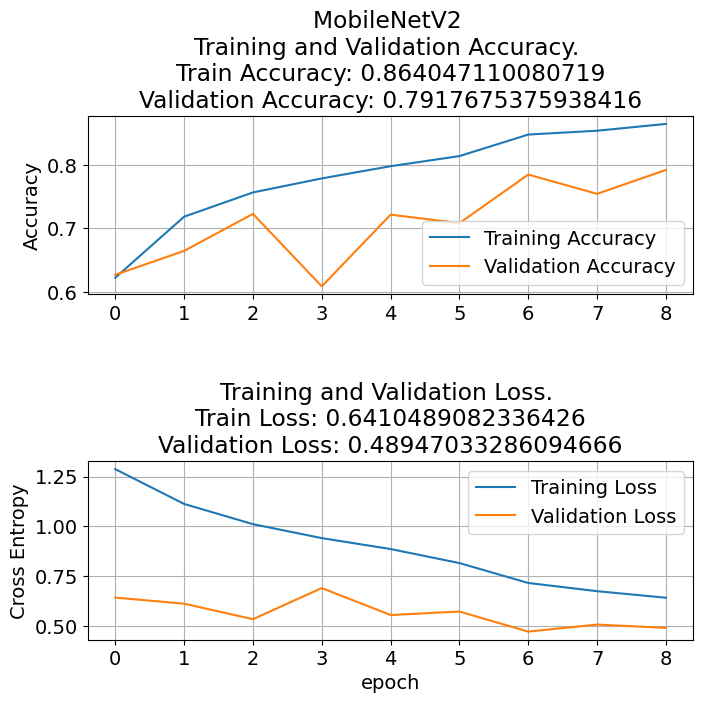

In [17]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [18]:
class0_train = []
for file in os.listdir("/kaggle/input/preprocessing-koa-dataset-binary/train/0/"):
    class0_train.append("/kaggle/input/preprocessing-koa-dataset-binary/train/0/"+file)
class1_train = []
for file in os.listdir("/kaggle/input/preprocessing-koa-dataset-binary/train/1/"):
    class1_train.append("/kaggle/input/preprocessing-koa-dataset-binary/train/1/"+file)

class0_test = []
for file in os.listdir("/kaggle/input/preprocessing-koa-dataset-binary/test/0/"):
    class0_test.append("/kaggle/input/preprocessing-koa-dataset-binary/test/0/"+file)
class1_test = []
for file in os.listdir("/kaggle/input/preprocessing-koa-dataset-binary/test/1/"):
    class1_test.append("/kaggle/input/preprocessing-koa-dataset-binary/test/1/"+file)

class0_val = []
for file in os.listdir("/kaggle/input/preprocessing-koa-dataset-binary/val/0/"):
    class0_val.append("/kaggle/input/preprocessing-koa-dataset-binary/val/0/"+file)
class1_val = []
for file in os.listdir("/kaggle/input/preprocessing-koa-dataset-binary/val/1/"):
    class1_val.append("/kaggle/input/preprocessing-koa-dataset-binary/val/1/"+file)

In [19]:
import cv2
import pandas as pd

In [20]:
# train
y_true = []
y_preds = []

for path in class0_train:
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    y_true.append(0)
    y_preds.append(model(tf.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),0))[0]._numpy().tolist())
print("DONE train_0")
for path in class1_train:
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    y_true.append(1)
    y_preds.append(model(tf.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),0))[0]._numpy().tolist())
print("DONE train_1")

pd.DataFrame({
    'FileName': class0_train + class1_train,
    'y_true': y_true,
    'm': [y[0] for y in y_preds]
}).to_csv("b_densenet_train.csv")

DONE train_0


DONE train_1


In [21]:
# val
y_true = []
y_preds = []

for path in class0_val:
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    y_true.append(0)
    y_preds.append(model(tf.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),0))[0]._numpy().tolist())
print("DONE val_0")
for path in class1_val:
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    y_true.append(1)
    y_preds.append(model(tf.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),0))[0]._numpy().tolist())
print("DONE val_1")

pd.DataFrame({
    'FileName': class0_val + class1_val,
    'y_true': y_true,
    'm': [y[0] for y in y_preds]
}).to_csv("b_densenet_val.csv")

DONE val_0


DONE val_1


In [22]:
# test
y_true = []
y_preds = []

for path in class0_test:
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    y_true.append(0)
    y_preds.append(model(tf.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),0))[0]._numpy().tolist())
print("DONE test_0")
for path in class1_test:
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    y_true.append(1)
    y_preds.append(model(tf.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),0))[0]._numpy().tolist())
print("DONE test_1")

pd.DataFrame({
    'FileName': class0_test + class1_test,
    'y_true': y_true,
    'm': [y[0] for y in y_preds]
}).to_csv("b_densenet_test.csv")

DONE test_0
